##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
!pip install -q tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

ERROR: tensorflow 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.


Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets).


In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`).

In [5]:
encoder = info.features['text'].encoder

In [6]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [7]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [8]:
assert original_string == sample_string

In [9]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Prepare the data for training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

Note: As of **TensorFlow 2.2** the padded_shapes argument is no longer required. The default behavior is to pad all axes to the longest in the batch.

In [12]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Compile the Keras model to configure the training process:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6930 - accuracy: 0.6250

  2/391 [..............................] - ETA: 17s - loss: 0.6934 - accuracy: 0.5391

  3/391 [..............................] - ETA: 26s - loss: 0.6933 - accuracy: 0.5260

  4/391 [..............................] - ETA: 29s - loss: 0.6932 - accuracy: 0.5195

  5/391 [..............................] - ETA: 29s - loss: 0.6932 - accuracy: 0.5250

  6/391 [..............................] - ETA: 33s - loss: 0.6933 - accuracy: 0.5130

  7/391 [..............................] - ETA: 33s - loss: 0.6933 - accuracy: 0.5045

  8/391 [..............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5078

  9/391 [..............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.5139

 10/391 [..............................] - ETA: 34s - loss: 0.6933 - accuracy: 0.4984

 11/391 [..............................] - ETA: 35s - loss: 0.6933 - accuracy: 0.4986

 12/391 [..............................] - ETA: 34s - loss: 0.6933 - accuracy: 0.4948

 13/391 [..............................] - ETA: 34s - loss: 0.6933 - accuracy: 0.4916

 14/391 [>.............................] - ETA: 34s - loss: 0.6933 - accuracy: 0.4922

 15/391 [>.............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5000

 16/391 [>.............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5020

 17/391 [>.............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5028

 18/391 [>.............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5061

 19/391 [>.............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5066

 20/391 [>.............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4961

 21/391 [>.............................] - ETA: 34s - loss: 0.6933 - accuracy: 0.4933

 22/391 [>.............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4929

 23/391 [>.............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4932

 24/391 [>.............................] - ETA: 34s - loss: 0.6933 - accuracy: 0.4883

 25/391 [>.............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4875

 26/391 [>.............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4898

 27/391 [=>............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4913

 28/391 [=>............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4916

 29/391 [=>............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4925

 30/391 [=>............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4922

 31/391 [=>............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4924

 32/391 [=>............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4927

 33/391 [=>............................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4938

 34/391 [=>............................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4931

 35/391 [=>............................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4933

 36/391 [=>............................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4961

 37/391 [=>............................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4941

 38/391 [=>............................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4942

 39/391 [=>............................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4952

 40/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4953

 41/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4970

 42/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4959

 43/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4953

 44/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4961

 45/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4951

 46/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4956

 47/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4934

 48/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4932

 49/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4923

 50/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4938

 51/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4926

 52/391 [==>...........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4934

 53/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4929

 54/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4925

 55/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4932

 56/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4939

 57/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4948

 58/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4957

 59/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4966

 60/391 [===>..........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.4943

 61/391 [===>..........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.4949

 62/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4937

 63/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4945

 64/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4944

 65/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4928

 66/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4908

 67/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4909

 68/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4903

 69/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4900

 70/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4900

 71/391 [====>.........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4894

 72/391 [====>.........................] - ETA: 30s - loss: 0.6929 - accuracy: 0.4887

 73/391 [====>.........................] - ETA: 30s - loss: 0.6929 - accuracy: 0.4880

 74/391 [====>.........................] - ETA: 30s - loss: 0.6929 - accuracy: 0.4886

 75/391 [====>.........................] - ETA: 30s - loss: 0.6929 - accuracy: 0.4894

 76/391 [====>.........................] - ETA: 30s - loss: 0.6929 - accuracy: 0.4895

 77/391 [====>.........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4899

 78/391 [====>.........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4902

 79/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4911

 80/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4924

 81/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4929

 82/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4914

 83/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4919

 84/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4935

 85/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4941

 86/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4942

 87/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4939

 88/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4931

 89/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4930

 90/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4929

 91/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4935

 92/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4947

 93/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4951

 94/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4955

 95/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4956

 96/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4954

 97/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4963

 98/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4973

 99/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4981

100/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4988

101/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4981

102/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4983

103/391 [======>.......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.4970

104/391 [======>.......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.4967

105/391 [=======>......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.4963

106/391 [=======>......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.4971

107/391 [=======>......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.4969

108/391 [=======>......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.4974

109/391 [=======>......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.4983

110/391 [=======>......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.4982

111/391 [=======>......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.4992

112/391 [=======>......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.4987

113/391 [=======>......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.4983

114/391 [=======>......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.4997

115/391 [=======>......................] - ETA: 26s - loss: 0.6929 - accuracy: 0.4999

116/391 [=======>......................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5007

117/391 [=======>......................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5000

118/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5008

119/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5011

120/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5014

121/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5012

122/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5014

123/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5015

124/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5006

125/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.4996

126/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.4995

127/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.4995

128/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.4988

129/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.4984

130/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.4988

131/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.4986

132/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.4979

133/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.4991

134/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.4995

135/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.4994

136/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.4991

137/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.4995

138/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5000

139/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.4999

140/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.4994

141/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.4994

142/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5002

143/391 [=========>....................] - ETA: 23s - loss: 0.6929 - accuracy: 0.4997

144/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5000

145/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.4999

146/391 [==========>...................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5000

147/391 [==========>...................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5001

148/391 [==========>...................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5004

149/391 [==========>...................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5005

150/391 [==========>...................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5009

151/391 [==========>...................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5010

152/391 [==========>...................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5011

153/391 [==========>...................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5006

154/391 [==========>...................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5012

155/391 [==========>...................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5008

156/391 [==========>...................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5015

157/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5020

158/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5016

159/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5020

160/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5022

161/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5022

162/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5022

163/391 [===========>..................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5022

164/391 [===========>..................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5025

165/391 [===========>..................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5018

166/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5014

167/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5013

168/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5009

169/391 [===========>..................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5012

170/391 [============>.................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5016

171/391 [============>.................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5019

172/391 [============>.................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5024

173/391 [============>.................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5022

174/391 [============>.................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5022

175/391 [============>.................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5022

176/391 [============>.................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5016

177/391 [============>.................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5010

178/391 [============>.................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5011

179/391 [============>.................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5010

180/391 [============>.................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5009

181/391 [============>.................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5002

182/391 [============>.................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5004

183/391 [=============>................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5001

184/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5000

185/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.4997

186/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5001

187/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5007

188/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.4998

189/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.4998

190/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.4991

191/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.4989

192/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.4986

193/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.4986

194/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.4985

195/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.4982

196/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.4982

197/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.4980

198/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.4983

199/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.4982

200/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.4983

201/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.4981

202/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.4982

203/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.4981

204/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.4984

205/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.4980

206/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.4978

207/391 [==============>...............] - ETA: 17s - loss: 0.6926 - accuracy: 0.4983

208/391 [==============>...............] - ETA: 17s - loss: 0.6926 - accuracy: 0.4985

209/391 [===============>..............] - ETA: 17s - loss: 0.6926 - accuracy: 0.4986

210/391 [===============>..............] - ETA: 17s - loss: 0.6926 - accuracy: 0.4988

211/391 [===============>..............] - ETA: 17s - loss: 0.6926 - accuracy: 0.4987

212/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.4988

213/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.4987

214/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.4987

215/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.4985

216/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.4987

217/391 [===============>..............] - ETA: 16s - loss: 0.6925 - accuracy: 0.4981

218/391 [===============>..............] - ETA: 16s - loss: 0.6925 - accuracy: 0.4981

219/391 [===============>..............] - ETA: 16s - loss: 0.6924 - accuracy: 0.4982

220/391 [===============>..............] - ETA: 16s - loss: 0.6924 - accuracy: 0.4991

221/391 [===============>..............] - ETA: 16s - loss: 0.6924 - accuracy: 0.4994

222/391 [================>.............] - ETA: 16s - loss: 0.6924 - accuracy: 0.4997

223/391 [================>.............] - ETA: 16s - loss: 0.6924 - accuracy: 0.4994

224/391 [================>.............] - ETA: 16s - loss: 0.6924 - accuracy: 0.4992

225/391 [================>.............] - ETA: 16s - loss: 0.6924 - accuracy: 0.4997

226/391 [================>.............] - ETA: 16s - loss: 0.6924 - accuracy: 0.4995

227/391 [================>.............] - ETA: 15s - loss: 0.6924 - accuracy: 0.4994

228/391 [================>.............] - ETA: 15s - loss: 0.6923 - accuracy: 0.4996

229/391 [================>.............] - ETA: 15s - loss: 0.6923 - accuracy: 0.4990

230/391 [================>.............] - ETA: 15s - loss: 0.6923 - accuracy: 0.4993

231/391 [================>.............] - ETA: 15s - loss: 0.6923 - accuracy: 0.4994

232/391 [================>.............] - ETA: 15s - loss: 0.6923 - accuracy: 0.4992

233/391 [================>.............] - ETA: 15s - loss: 0.6923 - accuracy: 0.4991

234/391 [================>.............] - ETA: 15s - loss: 0.6922 - accuracy: 0.4989

235/391 [=================>............] - ETA: 15s - loss: 0.6922 - accuracy: 0.4995

236/391 [=================>............] - ETA: 15s - loss: 0.6922 - accuracy: 0.4995

237/391 [=================>............] - ETA: 14s - loss: 0.6922 - accuracy: 0.4991

238/391 [=================>............] - ETA: 14s - loss: 0.6921 - accuracy: 0.4994

239/391 [=================>............] - ETA: 14s - loss: 0.6921 - accuracy: 0.4993

240/391 [=================>............] - ETA: 14s - loss: 0.6921 - accuracy: 0.4995

241/391 [=================>............] - ETA: 14s - loss: 0.6920 - accuracy: 0.4997

242/391 [=================>............] - ETA: 14s - loss: 0.6920 - accuracy: 0.4995

243/391 [=================>............] - ETA: 14s - loss: 0.6919 - accuracy: 0.4993

244/391 [=================>............] - ETA: 14s - loss: 0.6919 - accuracy: 0.4990

245/391 [=================>............] - ETA: 14s - loss: 0.6918 - accuracy: 0.4991

246/391 [=================>............] - ETA: 14s - loss: 0.6917 - accuracy: 0.4997

247/391 [=================>............] - ETA: 14s - loss: 0.6917 - accuracy: 0.4996

248/391 [==================>...........] - ETA: 13s - loss: 0.6917 - accuracy: 0.4996

249/391 [==================>...........] - ETA: 13s - loss: 0.6915 - accuracy: 0.4996

250/391 [==================>...........] - ETA: 13s - loss: 0.6914 - accuracy: 0.4990

251/391 [==================>...........] - ETA: 13s - loss: 0.6914 - accuracy: 0.4994

252/391 [==================>...........] - ETA: 13s - loss: 0.6914 - accuracy: 0.4994

253/391 [==================>...........] - ETA: 13s - loss: 0.6913 - accuracy: 0.4992

254/391 [==================>...........] - ETA: 13s - loss: 0.6912 - accuracy: 0.4992

255/391 [==================>...........] - ETA: 13s - loss: 0.6911 - accuracy: 0.4988

256/391 [==================>...........] - ETA: 13s - loss: 0.6910 - accuracy: 0.4993

257/391 [==================>...........] - ETA: 13s - loss: 0.6909 - accuracy: 0.4991

258/391 [==================>...........] - ETA: 13s - loss: 0.6908 - accuracy: 0.4992

259/391 [==================>...........] - ETA: 12s - loss: 0.6908 - accuracy: 0.4991

260/391 [==================>...........] - ETA: 12s - loss: 0.6907 - accuracy: 0.4990

261/391 [===================>..........] - ETA: 12s - loss: 0.6905 - accuracy: 0.4993

262/391 [===================>..........] - ETA: 12s - loss: 0.6904 - accuracy: 0.4991

263/391 [===================>..........] - ETA: 12s - loss: 0.6902 - accuracy: 0.4993

264/391 [===================>..........] - ETA: 12s - loss: 0.6900 - accuracy: 0.4992

265/391 [===================>..........] - ETA: 12s - loss: 0.6898 - accuracy: 0.4994

266/391 [===================>..........] - ETA: 12s - loss: 0.6896 - accuracy: 0.4996

267/391 [===================>..........] - ETA: 12s - loss: 0.6894 - accuracy: 0.4998

268/391 [===================>..........] - ETA: 12s - loss: 0.6891 - accuracy: 0.5002

269/391 [===================>..........] - ETA: 11s - loss: 0.6889 - accuracy: 0.5006

270/391 [===================>..........] - ETA: 11s - loss: 0.6887 - accuracy: 0.5010

271/391 [===================>..........] - ETA: 11s - loss: 0.6884 - accuracy: 0.5014

272/391 [===================>..........] - ETA: 11s - loss: 0.6881 - accuracy: 0.5019

273/391 [===================>..........] - ETA: 11s - loss: 0.6877 - accuracy: 0.5024

274/391 [====================>.........] - ETA: 11s - loss: 0.6875 - accuracy: 0.5030

275/391 [====================>.........] - ETA: 11s - loss: 0.6878 - accuracy: 0.5030

276/391 [====================>.........] - ETA: 11s - loss: 0.6879 - accuracy: 0.5031

277/391 [====================>.........] - ETA: 11s - loss: 0.6883 - accuracy: 0.5030

278/391 [====================>.........] - ETA: 11s - loss: 0.6884 - accuracy: 0.5032

279/391 [====================>.........] - ETA: 11s - loss: 0.6881 - accuracy: 0.5039

280/391 [====================>.........] - ETA: 10s - loss: 0.6878 - accuracy: 0.5039

281/391 [====================>.........] - ETA: 10s - loss: 0.6876 - accuracy: 0.5040

282/391 [====================>.........] - ETA: 10s - loss: 0.6875 - accuracy: 0.5037

283/391 [====================>.........] - ETA: 10s - loss: 0.6873 - accuracy: 0.5039

284/391 [====================>.........] - ETA: 10s - loss: 0.6873 - accuracy: 0.5035

285/391 [====================>.........] - ETA: 10s - loss: 0.6870 - accuracy: 0.5036

286/391 [====================>.........] - ETA: 10s - loss: 0.6869 - accuracy: 0.5036

287/391 [=====================>........] - ETA: 10s - loss: 0.6868 - accuracy: 0.5038

288/391 [=====================>........] - ETA: 10s - loss: 0.6866 - accuracy: 0.5034

289/391 [=====================>........] - ETA: 10s - loss: 0.6865 - accuracy: 0.5031

290/391 [=====================>........] - ETA: 9s - loss: 0.6863 - accuracy: 0.5027 

291/391 [=====================>........] - ETA: 9s - loss: 0.6862 - accuracy: 0.5029

292/391 [=====================>........] - ETA: 9s - loss: 0.6859 - accuracy: 0.5026

293/391 [=====================>........] - ETA: 9s - loss: 0.6857 - accuracy: 0.5030

294/391 [=====================>........] - ETA: 9s - loss: 0.6855 - accuracy: 0.5030

295/391 [=====================>........] - ETA: 9s - loss: 0.6853 - accuracy: 0.5030

296/391 [=====================>........] - ETA: 9s - loss: 0.6851 - accuracy: 0.5031

297/391 [=====================>........] - ETA: 9s - loss: 0.6848 - accuracy: 0.5034

298/391 [=====================>........] - ETA: 9s - loss: 0.6845 - accuracy: 0.5034

299/391 [=====================>........] - ETA: 9s - loss: 0.6842 - accuracy: 0.5037

300/391 [======================>.......] - ETA: 8s - loss: 0.6838 - accuracy: 0.5040

301/391 [======================>.......] - ETA: 8s - loss: 0.6834 - accuracy: 0.5044

302/391 [======================>.......] - ETA: 8s - loss: 0.6830 - accuracy: 0.5051

303/391 [======================>.......] - ETA: 8s - loss: 0.6824 - accuracy: 0.5061

304/391 [======================>.......] - ETA: 8s - loss: 0.6829 - accuracy: 0.5058

305/391 [======================>.......] - ETA: 8s - loss: 0.6826 - accuracy: 0.5063

306/391 [======================>.......] - ETA: 8s - loss: 0.6824 - accuracy: 0.5068

307/391 [======================>.......] - ETA: 8s - loss: 0.6821 - accuracy: 0.5074

308/391 [======================>.......] - ETA: 8s - loss: 0.6816 - accuracy: 0.5084

309/391 [======================>.......] - ETA: 8s - loss: 0.6814 - accuracy: 0.5091

310/391 [======================>.......] - ETA: 7s - loss: 0.6810 - accuracy: 0.5100

311/391 [======================>.......] - ETA: 7s - loss: 0.6804 - accuracy: 0.5111

312/391 [======================>.......] - ETA: 7s - loss: 0.6800 - accuracy: 0.5119

313/391 [=======================>......] - ETA: 7s - loss: 0.6798 - accuracy: 0.5125

314/391 [=======================>......] - ETA: 7s - loss: 0.6794 - accuracy: 0.5131

315/391 [=======================>......] - ETA: 7s - loss: 0.6790 - accuracy: 0.5131

316/391 [=======================>......] - ETA: 7s - loss: 0.6787 - accuracy: 0.5133

317/391 [=======================>......] - ETA: 7s - loss: 0.6784 - accuracy: 0.5134

318/391 [=======================>......] - ETA: 7s - loss: 0.6780 - accuracy: 0.5138

319/391 [=======================>......] - ETA: 7s - loss: 0.6775 - accuracy: 0.5144

320/391 [=======================>......] - ETA: 6s - loss: 0.6771 - accuracy: 0.5149

321/391 [=======================>......] - ETA: 6s - loss: 0.6766 - accuracy: 0.5157

322/391 [=======================>......] - ETA: 6s - loss: 0.6763 - accuracy: 0.5160

323/391 [=======================>......] - ETA: 6s - loss: 0.6757 - accuracy: 0.5167

324/391 [=======================>......] - ETA: 6s - loss: 0.6753 - accuracy: 0.5175

325/391 [=======================>......] - ETA: 6s - loss: 0.6749 - accuracy: 0.5183

326/391 [========================>.....] - ETA: 6s - loss: 0.6745 - accuracy: 0.5191

327/391 [========================>.....] - ETA: 6s - loss: 0.6742 - accuracy: 0.5197

328/391 [========================>.....] - ETA: 6s - loss: 0.6738 - accuracy: 0.5202

329/391 [========================>.....] - ETA: 6s - loss: 0.6733 - accuracy: 0.5209

330/391 [========================>.....] - ETA: 5s - loss: 0.6730 - accuracy: 0.5215

331/391 [========================>.....] - ETA: 5s - loss: 0.6724 - accuracy: 0.5222

332/391 [========================>.....] - ETA: 5s - loss: 0.6718 - accuracy: 0.5230

333/391 [========================>.....] - ETA: 5s - loss: 0.6717 - accuracy: 0.5231

334/391 [========================>.....] - ETA: 5s - loss: 0.6710 - accuracy: 0.5240

335/391 [========================>.....] - ETA: 5s - loss: 0.6705 - accuracy: 0.5247

336/391 [========================>.....] - ETA: 5s - loss: 0.6699 - accuracy: 0.5251

337/391 [========================>.....] - ETA: 5s - loss: 0.6694 - accuracy: 0.5257

338/391 [========================>.....] - ETA: 5s - loss: 0.6690 - accuracy: 0.5261

339/391 [=========================>....] - ETA: 5s - loss: 0.6684 - accuracy: 0.5268

340/391 [=========================>....] - ETA: 5s - loss: 0.6679 - accuracy: 0.5275

341/391 [=========================>....] - ETA: 4s - loss: 0.6673 - accuracy: 0.5282

342/391 [=========================>....] - ETA: 4s - loss: 0.6668 - accuracy: 0.5286

343/391 [=========================>....] - ETA: 4s - loss: 0.6664 - accuracy: 0.5293

344/391 [=========================>....] - ETA: 4s - loss: 0.6659 - accuracy: 0.5301

345/391 [=========================>....] - ETA: 4s - loss: 0.6657 - accuracy: 0.5308

346/391 [=========================>....] - ETA: 4s - loss: 0.6652 - accuracy: 0.5314

347/391 [=========================>....] - ETA: 4s - loss: 0.6646 - accuracy: 0.5322

348/391 [=========================>....] - ETA: 4s - loss: 0.6638 - accuracy: 0.5328

349/391 [=========================>....] - ETA: 4s - loss: 0.6635 - accuracy: 0.5332

350/391 [=========================>....] - ETA: 4s - loss: 0.6627 - accuracy: 0.5341

351/391 [=========================>....] - ETA: 3s - loss: 0.6619 - accuracy: 0.5349

352/391 [==========================>...] - ETA: 3s - loss: 0.6616 - accuracy: 0.5353

353/391 [==========================>...] - ETA: 3s - loss: 0.6612 - accuracy: 0.5356

354/391 [==========================>...] - ETA: 3s - loss: 0.6605 - accuracy: 0.5365

355/391 [==========================>...] - ETA: 3s - loss: 0.6599 - accuracy: 0.5372

356/391 [==========================>...] - ETA: 3s - loss: 0.6591 - accuracy: 0.5382

357/391 [==========================>...] - ETA: 3s - loss: 0.6588 - accuracy: 0.5388

358/391 [==========================>...] - ETA: 3s - loss: 0.6581 - accuracy: 0.5397

359/391 [==========================>...] - ETA: 3s - loss: 0.6575 - accuracy: 0.5403

360/391 [==========================>...] - ETA: 3s - loss: 0.6569 - accuracy: 0.5411

361/391 [==========================>...] - ETA: 2s - loss: 0.6562 - accuracy: 0.5420

362/391 [==========================>...] - ETA: 2s - loss: 0.6556 - accuracy: 0.5428

363/391 [==========================>...] - ETA: 2s - loss: 0.6553 - accuracy: 0.5433

364/391 [==========================>...] - ETA: 2s - loss: 0.6549 - accuracy: 0.5437

365/391 [===========================>..] - ETA: 2s - loss: 0.6543 - accuracy: 0.5443

366/391 [===========================>..] - ETA: 2s - loss: 0.6538 - accuracy: 0.5450

367/391 [===========================>..] - ETA: 2s - loss: 0.6531 - accuracy: 0.5458

368/391 [===========================>..] - ETA: 2s - loss: 0.6524 - accuracy: 0.5466

369/391 [===========================>..] - ETA: 2s - loss: 0.6521 - accuracy: 0.5473

370/391 [===========================>..] - ETA: 2s - loss: 0.6516 - accuracy: 0.5480

371/391 [===========================>..] - ETA: 1s - loss: 0.6509 - accuracy: 0.5486

372/391 [===========================>..] - ETA: 1s - loss: 0.6504 - accuracy: 0.5494

373/391 [===========================>..] - ETA: 1s - loss: 0.6499 - accuracy: 0.5500

374/391 [===========================>..] - ETA: 1s - loss: 0.6494 - accuracy: 0.5506

375/391 [===========================>..] - ETA: 1s - loss: 0.6487 - accuracy: 0.5512

376/391 [===========================>..] - ETA: 1s - loss: 0.6484 - accuracy: 0.5518

377/391 [===========================>..] - ETA: 1s - loss: 0.6479 - accuracy: 0.5522

378/391 [============================>.] - ETA: 1s - loss: 0.6473 - accuracy: 0.5528

379/391 [============================>.] - ETA: 1s - loss: 0.6467 - accuracy: 0.5535

380/391 [============================>.] - ETA: 1s - loss: 0.6462 - accuracy: 0.5541

381/391 [============================>.] - ETA: 0s - loss: 0.6455 - accuracy: 0.5549

382/391 [============================>.] - ETA: 0s - loss: 0.6452 - accuracy: 0.5554

383/391 [============================>.] - ETA: 0s - loss: 0.6446 - accuracy: 0.5560

384/391 [============================>.] - ETA: 0s - loss: 0.6439 - accuracy: 0.5568

385/391 [============================>.] - ETA: 0s - loss: 0.6434 - accuracy: 0.5574

386/391 [============================>.] - ETA: 0s - loss: 0.6429 - accuracy: 0.5581

387/391 [============================>.] - ETA: 0s - loss: 0.6427 - accuracy: 0.5586

388/391 [============================>.] - ETA: 0s - loss: 0.6424 - accuracy: 0.5591

389/391 [============================>.] - ETA: 0s - loss: 0.6419 - accuracy: 0.5597

390/391 [============================>.] - ETA: 0s - loss: 0.6412 - accuracy: 0.5605

391/391 [==============================] - ETA: 0s - loss: 0.6406 - accuracy: 0.5610

391/391 [==============================] - 40s 103ms/step - loss: 0.6406 - accuracy: 0.5610 - val_loss: 0.4282 - val_accuracy: 0.8078


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.3068 - accuracy: 0.9062

  2/391 [..............................] - ETA: 22s - loss: 0.3427 - accuracy: 0.8672

  3/391 [..............................] - ETA: 29s - loss: 0.4641 - accuracy: 0.8021

  4/391 [..............................] - ETA: 32s - loss: 0.4505 - accuracy: 0.8164

  5/391 [..............................] - ETA: 36s - loss: 0.4347 - accuracy: 0.8250

  6/391 [..............................] - ETA: 37s - loss: 0.4261 - accuracy: 0.8333

  7/391 [..............................] - ETA: 37s - loss: 0.4306 - accuracy: 0.8326

  8/391 [..............................] - ETA: 38s - loss: 0.4325 - accuracy: 0.8281

  9/391 [..............................] - ETA: 38s - loss: 0.4353 - accuracy: 0.8264

 10/391 [..............................] - ETA: 37s - loss: 0.4291 - accuracy: 0.8297

 11/391 [..............................] - ETA: 38s - loss: 0.4418 - accuracy: 0.8224

 12/391 [..............................] - ETA: 39s - loss: 0.4398 - accuracy: 0.8216

 13/391 [..............................] - ETA: 38s - loss: 0.4518 - accuracy: 0.8137

 14/391 [>.............................] - ETA: 38s - loss: 0.4501 - accuracy: 0.8125

 15/391 [>.............................] - ETA: 38s - loss: 0.4519 - accuracy: 0.8115

 16/391 [>.............................] - ETA: 39s - loss: 0.4535 - accuracy: 0.8115

 17/391 [>.............................] - ETA: 38s - loss: 0.4566 - accuracy: 0.8079

 18/391 [>.............................] - ETA: 38s - loss: 0.4554 - accuracy: 0.8073

 19/391 [>.............................] - ETA: 38s - loss: 0.4537 - accuracy: 0.8084

 20/391 [>.............................] - ETA: 38s - loss: 0.4536 - accuracy: 0.8047

 21/391 [>.............................] - ETA: 38s - loss: 0.4520 - accuracy: 0.8043

 22/391 [>.............................] - ETA: 38s - loss: 0.4542 - accuracy: 0.8040

 23/391 [>.............................] - ETA: 38s - loss: 0.4554 - accuracy: 0.8030

 24/391 [>.............................] - ETA: 37s - loss: 0.4555 - accuracy: 0.8040

 25/391 [>.............................] - ETA: 37s - loss: 0.4581 - accuracy: 0.8025

 26/391 [>.............................] - ETA: 37s - loss: 0.4578 - accuracy: 0.8023

 27/391 [=>............................] - ETA: 37s - loss: 0.4552 - accuracy: 0.8050

 28/391 [=>............................] - ETA: 37s - loss: 0.4550 - accuracy: 0.8058

 29/391 [=>............................] - ETA: 37s - loss: 0.4536 - accuracy: 0.8071

 30/391 [=>............................] - ETA: 37s - loss: 0.4525 - accuracy: 0.8078

 31/391 [=>............................] - ETA: 37s - loss: 0.4501 - accuracy: 0.8090

 32/391 [=>............................] - ETA: 37s - loss: 0.4468 - accuracy: 0.8125

 33/391 [=>............................] - ETA: 37s - loss: 0.4457 - accuracy: 0.8120

 34/391 [=>............................] - ETA: 36s - loss: 0.4441 - accuracy: 0.8134

 35/391 [=>............................] - ETA: 36s - loss: 0.4433 - accuracy: 0.8138

 36/391 [=>............................] - ETA: 36s - loss: 0.4447 - accuracy: 0.8112

 37/391 [=>............................] - ETA: 36s - loss: 0.4422 - accuracy: 0.8117

 38/391 [=>............................] - ETA: 36s - loss: 0.4412 - accuracy: 0.8121

 39/391 [=>............................] - ETA: 36s - loss: 0.4385 - accuracy: 0.8137

 40/391 [==>...........................] - ETA: 36s - loss: 0.4362 - accuracy: 0.8145

 41/391 [==>...........................] - ETA: 36s - loss: 0.4356 - accuracy: 0.8152

 42/391 [==>...........................] - ETA: 36s - loss: 0.4347 - accuracy: 0.8147

 43/391 [==>...........................] - ETA: 36s - loss: 0.4333 - accuracy: 0.8158

 44/391 [==>...........................] - ETA: 35s - loss: 0.4328 - accuracy: 0.8164

 45/391 [==>...........................] - ETA: 35s - loss: 0.4358 - accuracy: 0.8135

 46/391 [==>...........................] - ETA: 35s - loss: 0.4353 - accuracy: 0.8139

 47/391 [==>...........................] - ETA: 35s - loss: 0.4337 - accuracy: 0.8145

 48/391 [==>...........................] - ETA: 35s - loss: 0.4313 - accuracy: 0.8154

 49/391 [==>...........................] - ETA: 35s - loss: 0.4305 - accuracy: 0.8163

 50/391 [==>...........................] - ETA: 35s - loss: 0.4289 - accuracy: 0.8172

 51/391 [==>...........................] - ETA: 34s - loss: 0.4283 - accuracy: 0.8183

 52/391 [==>...........................] - ETA: 34s - loss: 0.4269 - accuracy: 0.8191

 53/391 [===>..........................] - ETA: 34s - loss: 0.4269 - accuracy: 0.8193

 54/391 [===>..........................] - ETA: 34s - loss: 0.4268 - accuracy: 0.8189

 55/391 [===>..........................] - ETA: 33s - loss: 0.4238 - accuracy: 0.8213

 56/391 [===>..........................] - ETA: 33s - loss: 0.4252 - accuracy: 0.8203

 57/391 [===>..........................] - ETA: 33s - loss: 0.4238 - accuracy: 0.8213

 58/391 [===>..........................] - ETA: 33s - loss: 0.4215 - accuracy: 0.8219

 59/391 [===>..........................] - ETA: 33s - loss: 0.4211 - accuracy: 0.8231

 60/391 [===>..........................] - ETA: 33s - loss: 0.4219 - accuracy: 0.8221

 61/391 [===>..........................] - ETA: 33s - loss: 0.4192 - accuracy: 0.8233

 62/391 [===>..........................] - ETA: 33s - loss: 0.4175 - accuracy: 0.8241

 63/391 [===>..........................] - ETA: 32s - loss: 0.4192 - accuracy: 0.8222

 64/391 [===>..........................] - ETA: 33s - loss: 0.4203 - accuracy: 0.8206

 65/391 [===>..........................] - ETA: 33s - loss: 0.4182 - accuracy: 0.8204

 66/391 [====>.........................] - ETA: 33s - loss: 0.4181 - accuracy: 0.8203

 67/391 [====>.........................] - ETA: 33s - loss: 0.4183 - accuracy: 0.8204

 68/391 [====>.........................] - ETA: 33s - loss: 0.4172 - accuracy: 0.8215

 69/391 [====>.........................] - ETA: 33s - loss: 0.4165 - accuracy: 0.8218

 70/391 [====>.........................] - ETA: 33s - loss: 0.4156 - accuracy: 0.8223

 71/391 [====>.........................] - ETA: 33s - loss: 0.4156 - accuracy: 0.8224

 72/391 [====>.........................] - ETA: 33s - loss: 0.4159 - accuracy: 0.8225

 73/391 [====>.........................] - ETA: 32s - loss: 0.4166 - accuracy: 0.8228

 74/391 [====>.........................] - ETA: 32s - loss: 0.4169 - accuracy: 0.8228

 75/391 [====>.........................] - ETA: 32s - loss: 0.4160 - accuracy: 0.8229

 76/391 [====>.........................] - ETA: 32s - loss: 0.4146 - accuracy: 0.8236

 77/391 [====>.........................] - ETA: 32s - loss: 0.4139 - accuracy: 0.8245

 78/391 [====>.........................] - ETA: 32s - loss: 0.4135 - accuracy: 0.8249

 79/391 [=====>........................] - ETA: 32s - loss: 0.4131 - accuracy: 0.8248

 80/391 [=====>........................] - ETA: 32s - loss: 0.4120 - accuracy: 0.8250

 81/391 [=====>........................] - ETA: 32s - loss: 0.4106 - accuracy: 0.8256

 82/391 [=====>........................] - ETA: 32s - loss: 0.4088 - accuracy: 0.8266

 83/391 [=====>........................] - ETA: 32s - loss: 0.4093 - accuracy: 0.8257

 84/391 [=====>........................] - ETA: 31s - loss: 0.4087 - accuracy: 0.8257

 85/391 [=====>........................] - ETA: 31s - loss: 0.4078 - accuracy: 0.8265

 86/391 [=====>........................] - ETA: 31s - loss: 0.4069 - accuracy: 0.8263

 87/391 [=====>........................] - ETA: 31s - loss: 0.4054 - accuracy: 0.8270

 88/391 [=====>........................] - ETA: 31s - loss: 0.4057 - accuracy: 0.8269

 89/391 [=====>........................] - ETA: 31s - loss: 0.4056 - accuracy: 0.8267

 90/391 [=====>........................] - ETA: 31s - loss: 0.4036 - accuracy: 0.8281

 91/391 [=====>........................] - ETA: 31s - loss: 0.4030 - accuracy: 0.8283

 92/391 [======>.......................] - ETA: 30s - loss: 0.4018 - accuracy: 0.8290

 93/391 [======>.......................] - ETA: 30s - loss: 0.4020 - accuracy: 0.8291

 94/391 [======>.......................] - ETA: 30s - loss: 0.4018 - accuracy: 0.8290

 95/391 [======>.......................] - ETA: 30s - loss: 0.4018 - accuracy: 0.8291

 96/391 [======>.......................] - ETA: 30s - loss: 0.4018 - accuracy: 0.8289

 97/391 [======>.......................] - ETA: 30s - loss: 0.4009 - accuracy: 0.8297

 98/391 [======>.......................] - ETA: 30s - loss: 0.4014 - accuracy: 0.8296

 99/391 [======>.......................] - ETA: 30s - loss: 0.4003 - accuracy: 0.8307

100/391 [======>.......................] - ETA: 30s - loss: 0.3999 - accuracy: 0.8308

101/391 [======>.......................] - ETA: 30s - loss: 0.4006 - accuracy: 0.8304

102/391 [======>.......................] - ETA: 29s - loss: 0.3994 - accuracy: 0.8312

103/391 [======>.......................] - ETA: 29s - loss: 0.3998 - accuracy: 0.8304

104/391 [======>.......................] - ETA: 29s - loss: 0.4007 - accuracy: 0.8295

105/391 [=======>......................] - ETA: 29s - loss: 0.4016 - accuracy: 0.8284

106/391 [=======>......................] - ETA: 29s - loss: 0.4019 - accuracy: 0.8278

107/391 [=======>......................] - ETA: 29s - loss: 0.4016 - accuracy: 0.8281

108/391 [=======>......................] - ETA: 28s - loss: 0.4014 - accuracy: 0.8280

109/391 [=======>......................] - ETA: 28s - loss: 0.4009 - accuracy: 0.8283

110/391 [=======>......................] - ETA: 28s - loss: 0.4005 - accuracy: 0.8286

111/391 [=======>......................] - ETA: 28s - loss: 0.4001 - accuracy: 0.8288

112/391 [=======>......................] - ETA: 28s - loss: 0.3993 - accuracy: 0.8299

113/391 [=======>......................] - ETA: 28s - loss: 0.3990 - accuracy: 0.8303

114/391 [=======>......................] - ETA: 28s - loss: 0.3985 - accuracy: 0.8309

115/391 [=======>......................] - ETA: 28s - loss: 0.3981 - accuracy: 0.8307

116/391 [=======>......................] - ETA: 28s - loss: 0.3981 - accuracy: 0.8311

117/391 [=======>......................] - ETA: 28s - loss: 0.3977 - accuracy: 0.8316

118/391 [========>.....................] - ETA: 28s - loss: 0.3968 - accuracy: 0.8322

119/391 [========>.....................] - ETA: 27s - loss: 0.3959 - accuracy: 0.8329

120/391 [========>.....................] - ETA: 27s - loss: 0.3958 - accuracy: 0.8328

121/391 [========>.....................] - ETA: 27s - loss: 0.3956 - accuracy: 0.8329

122/391 [========>.....................] - ETA: 27s - loss: 0.3958 - accuracy: 0.8327

123/391 [========>.....................] - ETA: 27s - loss: 0.3949 - accuracy: 0.8331

124/391 [========>.....................] - ETA: 27s - loss: 0.3944 - accuracy: 0.8330

125/391 [========>.....................] - ETA: 27s - loss: 0.3943 - accuracy: 0.8332

126/391 [========>.....................] - ETA: 27s - loss: 0.3946 - accuracy: 0.8332

127/391 [========>.....................] - ETA: 27s - loss: 0.3942 - accuracy: 0.8333

128/391 [========>.....................] - ETA: 27s - loss: 0.3933 - accuracy: 0.8337

129/391 [========>.....................] - ETA: 26s - loss: 0.3930 - accuracy: 0.8337

130/391 [========>.....................] - ETA: 26s - loss: 0.3919 - accuracy: 0.8344

131/391 [=========>....................] - ETA: 26s - loss: 0.3915 - accuracy: 0.8347

132/391 [=========>....................] - ETA: 26s - loss: 0.3915 - accuracy: 0.8345

133/391 [=========>....................] - ETA: 26s - loss: 0.3908 - accuracy: 0.8349

134/391 [=========>....................] - ETA: 26s - loss: 0.3900 - accuracy: 0.8356

135/391 [=========>....................] - ETA: 26s - loss: 0.3895 - accuracy: 0.8359

136/391 [=========>....................] - ETA: 26s - loss: 0.3890 - accuracy: 0.8362

137/391 [=========>....................] - ETA: 26s - loss: 0.3887 - accuracy: 0.8363

138/391 [=========>....................] - ETA: 25s - loss: 0.3885 - accuracy: 0.8366

139/391 [=========>....................] - ETA: 25s - loss: 0.3880 - accuracy: 0.8372

140/391 [=========>....................] - ETA: 25s - loss: 0.3878 - accuracy: 0.8372

141/391 [=========>....................] - ETA: 25s - loss: 0.3872 - accuracy: 0.8373

142/391 [=========>....................] - ETA: 25s - loss: 0.3877 - accuracy: 0.8366

143/391 [=========>....................] - ETA: 25s - loss: 0.3878 - accuracy: 0.8365

144/391 [==========>...................] - ETA: 25s - loss: 0.3865 - accuracy: 0.8372

145/391 [==========>...................] - ETA: 25s - loss: 0.3858 - accuracy: 0.8375

146/391 [==========>...................] - ETA: 25s - loss: 0.3864 - accuracy: 0.8373

147/391 [==========>...................] - ETA: 24s - loss: 0.3865 - accuracy: 0.8375

148/391 [==========>...................] - ETA: 24s - loss: 0.3857 - accuracy: 0.8376

149/391 [==========>...................] - ETA: 24s - loss: 0.3855 - accuracy: 0.8376

150/391 [==========>...................] - ETA: 24s - loss: 0.3848 - accuracy: 0.8378

151/391 [==========>...................] - ETA: 24s - loss: 0.3845 - accuracy: 0.8381

152/391 [==========>...................] - ETA: 24s - loss: 0.3842 - accuracy: 0.8384

153/391 [==========>...................] - ETA: 24s - loss: 0.3843 - accuracy: 0.8384

154/391 [==========>...................] - ETA: 24s - loss: 0.3839 - accuracy: 0.8388

155/391 [==========>...................] - ETA: 24s - loss: 0.3838 - accuracy: 0.8388

156/391 [==========>...................] - ETA: 23s - loss: 0.3831 - accuracy: 0.8392

157/391 [===========>..................] - ETA: 23s - loss: 0.3832 - accuracy: 0.8394

158/391 [===========>..................] - ETA: 23s - loss: 0.3830 - accuracy: 0.8394

159/391 [===========>..................] - ETA: 23s - loss: 0.3824 - accuracy: 0.8398

160/391 [===========>..................] - ETA: 23s - loss: 0.3827 - accuracy: 0.8393

161/391 [===========>..................] - ETA: 23s - loss: 0.3827 - accuracy: 0.8392

162/391 [===========>..................] - ETA: 23s - loss: 0.3826 - accuracy: 0.8392

163/391 [===========>..................] - ETA: 23s - loss: 0.3827 - accuracy: 0.8392

164/391 [===========>..................] - ETA: 23s - loss: 0.3825 - accuracy: 0.8394

165/391 [===========>..................] - ETA: 23s - loss: 0.3820 - accuracy: 0.8398

166/391 [===========>..................] - ETA: 22s - loss: 0.3820 - accuracy: 0.8396

167/391 [===========>..................] - ETA: 22s - loss: 0.3818 - accuracy: 0.8399

168/391 [===========>..................] - ETA: 22s - loss: 0.3812 - accuracy: 0.8401

169/391 [===========>..................] - ETA: 22s - loss: 0.3806 - accuracy: 0.8403

170/391 [============>.................] - ETA: 22s - loss: 0.3802 - accuracy: 0.8407

171/391 [============>.................] - ETA: 22s - loss: 0.3801 - accuracy: 0.8408

172/391 [============>.................] - ETA: 22s - loss: 0.3796 - accuracy: 0.8410

173/391 [============>.................] - ETA: 22s - loss: 0.3795 - accuracy: 0.8409

174/391 [============>.................] - ETA: 22s - loss: 0.3790 - accuracy: 0.8410

175/391 [============>.................] - ETA: 22s - loss: 0.3793 - accuracy: 0.8407

176/391 [============>.................] - ETA: 21s - loss: 0.3788 - accuracy: 0.8410

177/391 [============>.................] - ETA: 21s - loss: 0.3786 - accuracy: 0.8409

178/391 [============>.................] - ETA: 21s - loss: 0.3777 - accuracy: 0.8414

179/391 [============>.................] - ETA: 21s - loss: 0.3779 - accuracy: 0.8414

180/391 [============>.................] - ETA: 21s - loss: 0.3776 - accuracy: 0.8416

181/391 [============>.................] - ETA: 21s - loss: 0.3780 - accuracy: 0.8412

182/391 [============>.................] - ETA: 21s - loss: 0.3770 - accuracy: 0.8417

183/391 [=============>................] - ETA: 21s - loss: 0.3769 - accuracy: 0.8418

184/391 [=============>................] - ETA: 21s - loss: 0.3766 - accuracy: 0.8421

185/391 [=============>................] - ETA: 21s - loss: 0.3767 - accuracy: 0.8421

186/391 [=============>................] - ETA: 20s - loss: 0.3764 - accuracy: 0.8423

187/391 [=============>................] - ETA: 20s - loss: 0.3763 - accuracy: 0.8422

188/391 [=============>................] - ETA: 20s - loss: 0.3755 - accuracy: 0.8428

189/391 [=============>................] - ETA: 20s - loss: 0.3752 - accuracy: 0.8432

190/391 [=============>................] - ETA: 20s - loss: 0.3751 - accuracy: 0.8433

191/391 [=============>................] - ETA: 20s - loss: 0.3745 - accuracy: 0.8435

192/391 [=============>................] - ETA: 20s - loss: 0.3746 - accuracy: 0.8434

193/391 [=============>................] - ETA: 20s - loss: 0.3742 - accuracy: 0.8433

194/391 [=============>................] - ETA: 20s - loss: 0.3738 - accuracy: 0.8437

195/391 [=============>................] - ETA: 19s - loss: 0.3735 - accuracy: 0.8438

196/391 [==============>...............] - ETA: 19s - loss: 0.3734 - accuracy: 0.8434

197/391 [==============>...............] - ETA: 19s - loss: 0.3732 - accuracy: 0.8436

198/391 [==============>...............] - ETA: 19s - loss: 0.3729 - accuracy: 0.8436

199/391 [==============>...............] - ETA: 19s - loss: 0.3729 - accuracy: 0.8437

200/391 [==============>...............] - ETA: 19s - loss: 0.3732 - accuracy: 0.8438

201/391 [==============>...............] - ETA: 19s - loss: 0.3728 - accuracy: 0.8441

202/391 [==============>...............] - ETA: 19s - loss: 0.3725 - accuracy: 0.8442

203/391 [==============>...............] - ETA: 19s - loss: 0.3725 - accuracy: 0.8443

204/391 [==============>...............] - ETA: 19s - loss: 0.3724 - accuracy: 0.8444

205/391 [==============>...............] - ETA: 18s - loss: 0.3722 - accuracy: 0.8444

206/391 [==============>...............] - ETA: 18s - loss: 0.3720 - accuracy: 0.8444

207/391 [==============>...............] - ETA: 18s - loss: 0.3720 - accuracy: 0.8444

208/391 [==============>...............] - ETA: 18s - loss: 0.3714 - accuracy: 0.8447

209/391 [===============>..............] - ETA: 18s - loss: 0.3714 - accuracy: 0.8449

210/391 [===============>..............] - ETA: 18s - loss: 0.3714 - accuracy: 0.8447

211/391 [===============>..............] - ETA: 18s - loss: 0.3716 - accuracy: 0.8444

212/391 [===============>..............] - ETA: 18s - loss: 0.3712 - accuracy: 0.8445

213/391 [===============>..............] - ETA: 18s - loss: 0.3712 - accuracy: 0.8447

214/391 [===============>..............] - ETA: 17s - loss: 0.3710 - accuracy: 0.8448

215/391 [===============>..............] - ETA: 17s - loss: 0.3706 - accuracy: 0.8450

216/391 [===============>..............] - ETA: 17s - loss: 0.3703 - accuracy: 0.8450

217/391 [===============>..............] - ETA: 17s - loss: 0.3700 - accuracy: 0.8450

218/391 [===============>..............] - ETA: 17s - loss: 0.3700 - accuracy: 0.8449

219/391 [===============>..............] - ETA: 17s - loss: 0.3694 - accuracy: 0.8452

220/391 [===============>..............] - ETA: 17s - loss: 0.3690 - accuracy: 0.8456

221/391 [===============>..............] - ETA: 17s - loss: 0.3684 - accuracy: 0.8461

222/391 [================>.............] - ETA: 17s - loss: 0.3687 - accuracy: 0.8457

223/391 [================>.............] - ETA: 17s - loss: 0.3689 - accuracy: 0.8456

224/391 [================>.............] - ETA: 17s - loss: 0.3690 - accuracy: 0.8456

225/391 [================>.............] - ETA: 16s - loss: 0.3684 - accuracy: 0.8459

226/391 [================>.............] - ETA: 16s - loss: 0.3677 - accuracy: 0.8464

227/391 [================>.............] - ETA: 16s - loss: 0.3674 - accuracy: 0.8466

228/391 [================>.............] - ETA: 16s - loss: 0.3670 - accuracy: 0.8468

229/391 [================>.............] - ETA: 16s - loss: 0.3663 - accuracy: 0.8471

230/391 [================>.............] - ETA: 16s - loss: 0.3659 - accuracy: 0.8473

231/391 [================>.............] - ETA: 16s - loss: 0.3657 - accuracy: 0.8473

232/391 [================>.............] - ETA: 16s - loss: 0.3662 - accuracy: 0.8473

233/391 [================>.............] - ETA: 16s - loss: 0.3658 - accuracy: 0.8474

234/391 [================>.............] - ETA: 16s - loss: 0.3655 - accuracy: 0.8476

235/391 [=================>............] - ETA: 15s - loss: 0.3654 - accuracy: 0.8474

236/391 [=================>............] - ETA: 15s - loss: 0.3656 - accuracy: 0.8473

237/391 [=================>............] - ETA: 15s - loss: 0.3661 - accuracy: 0.8470

238/391 [=================>............] - ETA: 15s - loss: 0.3659 - accuracy: 0.8473

239/391 [=================>............] - ETA: 15s - loss: 0.3658 - accuracy: 0.8474

240/391 [=================>............] - ETA: 15s - loss: 0.3660 - accuracy: 0.8471

241/391 [=================>............] - ETA: 15s - loss: 0.3653 - accuracy: 0.8474

242/391 [=================>............] - ETA: 15s - loss: 0.3651 - accuracy: 0.8475

243/391 [=================>............] - ETA: 15s - loss: 0.3651 - accuracy: 0.8475

244/391 [=================>............] - ETA: 14s - loss: 0.3646 - accuracy: 0.8478

245/391 [=================>............] - ETA: 14s - loss: 0.3641 - accuracy: 0.8481

246/391 [=================>............] - ETA: 14s - loss: 0.3641 - accuracy: 0.8482

247/391 [=================>............] - ETA: 14s - loss: 0.3640 - accuracy: 0.8482

248/391 [==================>...........] - ETA: 14s - loss: 0.3638 - accuracy: 0.8483

249/391 [==================>...........] - ETA: 14s - loss: 0.3633 - accuracy: 0.8485

250/391 [==================>...........] - ETA: 14s - loss: 0.3627 - accuracy: 0.8487

251/391 [==================>...........] - ETA: 14s - loss: 0.3624 - accuracy: 0.8488

252/391 [==================>...........] - ETA: 14s - loss: 0.3620 - accuracy: 0.8491

253/391 [==================>...........] - ETA: 14s - loss: 0.3620 - accuracy: 0.8491

254/391 [==================>...........] - ETA: 13s - loss: 0.3621 - accuracy: 0.8491

255/391 [==================>...........] - ETA: 13s - loss: 0.3619 - accuracy: 0.8492

256/391 [==================>...........] - ETA: 13s - loss: 0.3622 - accuracy: 0.8491

257/391 [==================>...........] - ETA: 13s - loss: 0.3620 - accuracy: 0.8492

258/391 [==================>...........] - ETA: 13s - loss: 0.3616 - accuracy: 0.8494

259/391 [==================>...........] - ETA: 13s - loss: 0.3611 - accuracy: 0.8495

260/391 [==================>...........] - ETA: 13s - loss: 0.3610 - accuracy: 0.8495

261/391 [===================>..........] - ETA: 13s - loss: 0.3608 - accuracy: 0.8496

262/391 [===================>..........] - ETA: 13s - loss: 0.3603 - accuracy: 0.8498

263/391 [===================>..........] - ETA: 13s - loss: 0.3598 - accuracy: 0.8499

264/391 [===================>..........] - ETA: 12s - loss: 0.3600 - accuracy: 0.8497

265/391 [===================>..........] - ETA: 12s - loss: 0.3601 - accuracy: 0.8495

266/391 [===================>..........] - ETA: 12s - loss: 0.3599 - accuracy: 0.8494

267/391 [===================>..........] - ETA: 12s - loss: 0.3596 - accuracy: 0.8497

268/391 [===================>..........] - ETA: 12s - loss: 0.3597 - accuracy: 0.8496

269/391 [===================>..........] - ETA: 12s - loss: 0.3596 - accuracy: 0.8495

270/391 [===================>..........] - ETA: 12s - loss: 0.3595 - accuracy: 0.8494

271/391 [===================>..........] - ETA: 12s - loss: 0.3595 - accuracy: 0.8493

272/391 [===================>..........] - ETA: 12s - loss: 0.3596 - accuracy: 0.8490

273/391 [===================>..........] - ETA: 11s - loss: 0.3595 - accuracy: 0.8490

274/391 [====================>.........] - ETA: 11s - loss: 0.3588 - accuracy: 0.8493

275/391 [====================>.........] - ETA: 11s - loss: 0.3586 - accuracy: 0.8495

276/391 [====================>.........] - ETA: 11s - loss: 0.3588 - accuracy: 0.8495

277/391 [====================>.........] - ETA: 11s - loss: 0.3590 - accuracy: 0.8495

278/391 [====================>.........] - ETA: 11s - loss: 0.3586 - accuracy: 0.8498

279/391 [====================>.........] - ETA: 11s - loss: 0.3584 - accuracy: 0.8499

280/391 [====================>.........] - ETA: 11s - loss: 0.3581 - accuracy: 0.8501

281/391 [====================>.........] - ETA: 11s - loss: 0.3577 - accuracy: 0.8503

282/391 [====================>.........] - ETA: 11s - loss: 0.3578 - accuracy: 0.8503

283/391 [====================>.........] - ETA: 10s - loss: 0.3576 - accuracy: 0.8503

284/391 [====================>.........] - ETA: 10s - loss: 0.3573 - accuracy: 0.8505

285/391 [====================>.........] - ETA: 10s - loss: 0.3568 - accuracy: 0.8508

286/391 [====================>.........] - ETA: 10s - loss: 0.3569 - accuracy: 0.8507

287/391 [=====================>........] - ETA: 10s - loss: 0.3573 - accuracy: 0.8506

288/391 [=====================>........] - ETA: 10s - loss: 0.3569 - accuracy: 0.8508

289/391 [=====================>........] - ETA: 10s - loss: 0.3568 - accuracy: 0.8508

290/391 [=====================>........] - ETA: 10s - loss: 0.3566 - accuracy: 0.8508

291/391 [=====================>........] - ETA: 10s - loss: 0.3564 - accuracy: 0.8509

292/391 [=====================>........] - ETA: 10s - loss: 0.3565 - accuracy: 0.8510

293/391 [=====================>........] - ETA: 9s - loss: 0.3564 - accuracy: 0.8511 

294/391 [=====================>........] - ETA: 9s - loss: 0.3562 - accuracy: 0.8511

295/391 [=====================>........] - ETA: 9s - loss: 0.3562 - accuracy: 0.8510

296/391 [=====================>........] - ETA: 9s - loss: 0.3559 - accuracy: 0.8511

297/391 [=====================>........] - ETA: 9s - loss: 0.3561 - accuracy: 0.8510

298/391 [=====================>........] - ETA: 9s - loss: 0.3557 - accuracy: 0.8512

299/391 [=====================>........] - ETA: 9s - loss: 0.3553 - accuracy: 0.8515

300/391 [======================>.......] - ETA: 9s - loss: 0.3552 - accuracy: 0.8516

301/391 [======================>.......] - ETA: 9s - loss: 0.3556 - accuracy: 0.8514

302/391 [======================>.......] - ETA: 9s - loss: 0.3552 - accuracy: 0.8516

303/391 [======================>.......] - ETA: 8s - loss: 0.3547 - accuracy: 0.8519

304/391 [======================>.......] - ETA: 8s - loss: 0.3543 - accuracy: 0.8520

305/391 [======================>.......] - ETA: 8s - loss: 0.3544 - accuracy: 0.8520

306/391 [======================>.......] - ETA: 8s - loss: 0.3542 - accuracy: 0.8522

307/391 [======================>.......] - ETA: 8s - loss: 0.3547 - accuracy: 0.8521

308/391 [======================>.......] - ETA: 8s - loss: 0.3545 - accuracy: 0.8521

309/391 [======================>.......] - ETA: 8s - loss: 0.3544 - accuracy: 0.8522

310/391 [======================>.......] - ETA: 8s - loss: 0.3541 - accuracy: 0.8525

311/391 [======================>.......] - ETA: 8s - loss: 0.3537 - accuracy: 0.8527

312/391 [======================>.......] - ETA: 7s - loss: 0.3534 - accuracy: 0.8528

313/391 [=======================>......] - ETA: 7s - loss: 0.3532 - accuracy: 0.8528

314/391 [=======================>......] - ETA: 7s - loss: 0.3532 - accuracy: 0.8528

315/391 [=======================>......] - ETA: 7s - loss: 0.3531 - accuracy: 0.8527

316/391 [=======================>......] - ETA: 7s - loss: 0.3529 - accuracy: 0.8527

317/391 [=======================>......] - ETA: 7s - loss: 0.3526 - accuracy: 0.8530

318/391 [=======================>......] - ETA: 7s - loss: 0.3523 - accuracy: 0.8532

319/391 [=======================>......] - ETA: 7s - loss: 0.3523 - accuracy: 0.8532

320/391 [=======================>......] - ETA: 7s - loss: 0.3521 - accuracy: 0.8535

321/391 [=======================>......] - ETA: 7s - loss: 0.3518 - accuracy: 0.8534

322/391 [=======================>......] - ETA: 6s - loss: 0.3514 - accuracy: 0.8536

323/391 [=======================>......] - ETA: 6s - loss: 0.3512 - accuracy: 0.8537

324/391 [=======================>......] - ETA: 6s - loss: 0.3510 - accuracy: 0.8539

325/391 [=======================>......] - ETA: 6s - loss: 0.3510 - accuracy: 0.8540

326/391 [========================>.....] - ETA: 6s - loss: 0.3509 - accuracy: 0.8541

327/391 [========================>.....] - ETA: 6s - loss: 0.3505 - accuracy: 0.8542

328/391 [========================>.....] - ETA: 6s - loss: 0.3501 - accuracy: 0.8544

329/391 [========================>.....] - ETA: 6s - loss: 0.3499 - accuracy: 0.8544

330/391 [========================>.....] - ETA: 6s - loss: 0.3497 - accuracy: 0.8546

331/391 [========================>.....] - ETA: 6s - loss: 0.3495 - accuracy: 0.8546

332/391 [========================>.....] - ETA: 5s - loss: 0.3495 - accuracy: 0.8546

333/391 [========================>.....] - ETA: 5s - loss: 0.3494 - accuracy: 0.8546

334/391 [========================>.....] - ETA: 5s - loss: 0.3490 - accuracy: 0.8548

335/391 [========================>.....] - ETA: 5s - loss: 0.3489 - accuracy: 0.8548

336/391 [========================>.....] - ETA: 5s - loss: 0.3488 - accuracy: 0.8549

337/391 [========================>.....] - ETA: 5s - loss: 0.3485 - accuracy: 0.8550

338/391 [========================>.....] - ETA: 5s - loss: 0.3486 - accuracy: 0.8549

339/391 [=========================>....] - ETA: 5s - loss: 0.3489 - accuracy: 0.8548

340/391 [=========================>....] - ETA: 5s - loss: 0.3487 - accuracy: 0.8549

341/391 [=========================>....] - ETA: 5s - loss: 0.3487 - accuracy: 0.8549

342/391 [=========================>....] - ETA: 4s - loss: 0.3485 - accuracy: 0.8551

343/391 [=========================>....] - ETA: 4s - loss: 0.3483 - accuracy: 0.8552

344/391 [=========================>....] - ETA: 4s - loss: 0.3484 - accuracy: 0.8552

345/391 [=========================>....] - ETA: 4s - loss: 0.3481 - accuracy: 0.8553

346/391 [=========================>....] - ETA: 4s - loss: 0.3479 - accuracy: 0.8554

347/391 [=========================>....] - ETA: 4s - loss: 0.3479 - accuracy: 0.8553

348/391 [=========================>....] - ETA: 4s - loss: 0.3478 - accuracy: 0.8553

349/391 [=========================>....] - ETA: 4s - loss: 0.3477 - accuracy: 0.8554

350/391 [=========================>....] - ETA: 4s - loss: 0.3475 - accuracy: 0.8554

351/391 [=========================>....] - ETA: 4s - loss: 0.3471 - accuracy: 0.8557

352/391 [==========================>...] - ETA: 3s - loss: 0.3470 - accuracy: 0.8556

353/391 [==========================>...] - ETA: 3s - loss: 0.3467 - accuracy: 0.8558

354/391 [==========================>...] - ETA: 3s - loss: 0.3466 - accuracy: 0.8559

355/391 [==========================>...] - ETA: 3s - loss: 0.3465 - accuracy: 0.8559

356/391 [==========================>...] - ETA: 3s - loss: 0.3462 - accuracy: 0.8562

357/391 [==========================>...] - ETA: 3s - loss: 0.3459 - accuracy: 0.8563

358/391 [==========================>...] - ETA: 3s - loss: 0.3457 - accuracy: 0.8564

359/391 [==========================>...] - ETA: 3s - loss: 0.3456 - accuracy: 0.8566

360/391 [==========================>...] - ETA: 3s - loss: 0.3455 - accuracy: 0.8567

361/391 [==========================>...] - ETA: 3s - loss: 0.3453 - accuracy: 0.8568

362/391 [==========================>...] - ETA: 2s - loss: 0.3451 - accuracy: 0.8570

363/391 [==========================>...] - ETA: 2s - loss: 0.3449 - accuracy: 0.8570

364/391 [==========================>...] - ETA: 2s - loss: 0.3447 - accuracy: 0.8571

365/391 [===========================>..] - ETA: 2s - loss: 0.3444 - accuracy: 0.8574

366/391 [===========================>..] - ETA: 2s - loss: 0.3444 - accuracy: 0.8573

367/391 [===========================>..] - ETA: 2s - loss: 0.3444 - accuracy: 0.8573

368/391 [===========================>..] - ETA: 2s - loss: 0.3445 - accuracy: 0.8572

369/391 [===========================>..] - ETA: 2s - loss: 0.3444 - accuracy: 0.8572

370/391 [===========================>..] - ETA: 2s - loss: 0.3441 - accuracy: 0.8573

371/391 [===========================>..] - ETA: 2s - loss: 0.3441 - accuracy: 0.8573

372/391 [===========================>..] - ETA: 1s - loss: 0.3441 - accuracy: 0.8574

373/391 [===========================>..] - ETA: 1s - loss: 0.3442 - accuracy: 0.8573

374/391 [===========================>..] - ETA: 1s - loss: 0.3441 - accuracy: 0.8573

375/391 [===========================>..] - ETA: 1s - loss: 0.3440 - accuracy: 0.8573

376/391 [===========================>..] - ETA: 1s - loss: 0.3438 - accuracy: 0.8572

377/391 [===========================>..] - ETA: 1s - loss: 0.3435 - accuracy: 0.8574

378/391 [============================>.] - ETA: 1s - loss: 0.3434 - accuracy: 0.8576

379/391 [============================>.] - ETA: 1s - loss: 0.3433 - accuracy: 0.8577

380/391 [============================>.] - ETA: 1s - loss: 0.3436 - accuracy: 0.8576

381/391 [============================>.] - ETA: 1s - loss: 0.3437 - accuracy: 0.8576

382/391 [============================>.] - ETA: 0s - loss: 0.3436 - accuracy: 0.8577

383/391 [============================>.] - ETA: 0s - loss: 0.3436 - accuracy: 0.8577

384/391 [============================>.] - ETA: 0s - loss: 0.3435 - accuracy: 0.8577

385/391 [============================>.] - ETA: 0s - loss: 0.3434 - accuracy: 0.8577

386/391 [============================>.] - ETA: 0s - loss: 0.3433 - accuracy: 0.8578

387/391 [============================>.] - ETA: 0s - loss: 0.3432 - accuracy: 0.8578

388/391 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8578

389/391 [============================>.] - ETA: 0s - loss: 0.3428 - accuracy: 0.8578

390/391 [============================>.] - ETA: 0s - loss: 0.3427 - accuracy: 0.8579

391/391 [==============================] - ETA: 0s - loss: 0.3428 - accuracy: 0.8578

391/391 [==============================] - 41s 104ms/step - loss: 0.3428 - accuracy: 0.8578 - val_loss: 0.3380 - val_accuracy: 0.8510


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.2996 - accuracy: 0.8906

  2/391 [..............................] - ETA: 19s - loss: 0.3112 - accuracy: 0.8672

  3/391 [..............................] - ETA: 26s - loss: 0.3045 - accuracy: 0.8906

  4/391 [..............................] - ETA: 26s - loss: 0.3064 - accuracy: 0.8945

  5/391 [..............................] - ETA: 28s - loss: 0.2782 - accuracy: 0.9062

  6/391 [..............................] - ETA: 31s - loss: 0.2742 - accuracy: 0.9089

  7/391 [..............................] - ETA: 32s - loss: 0.2707 - accuracy: 0.9129

  8/391 [..............................] - ETA: 31s - loss: 0.2648 - accuracy: 0.9180

  9/391 [..............................] - ETA: 32s - loss: 0.2715 - accuracy: 0.9149

 10/391 [..............................] - ETA: 33s - loss: 0.2651 - accuracy: 0.9141

 11/391 [..............................] - ETA: 33s - loss: 0.2653 - accuracy: 0.9148

 12/391 [..............................] - ETA: 33s - loss: 0.2685 - accuracy: 0.9115

 13/391 [..............................] - ETA: 34s - loss: 0.2802 - accuracy: 0.9062

 14/391 [>.............................] - ETA: 35s - loss: 0.2835 - accuracy: 0.9040

 15/391 [>.............................] - ETA: 35s - loss: 0.2833 - accuracy: 0.9010

 16/391 [>.............................] - ETA: 34s - loss: 0.2767 - accuracy: 0.9043

 17/391 [>.............................] - ETA: 35s - loss: 0.2747 - accuracy: 0.9053

 18/391 [>.............................] - ETA: 35s - loss: 0.2720 - accuracy: 0.9062

 19/391 [>.............................] - ETA: 35s - loss: 0.2715 - accuracy: 0.9062

 20/391 [>.............................] - ETA: 34s - loss: 0.2767 - accuracy: 0.9039

 21/391 [>.............................] - ETA: 34s - loss: 0.2788 - accuracy: 0.9033

 22/391 [>.............................] - ETA: 34s - loss: 0.2765 - accuracy: 0.9041

 23/391 [>.............................] - ETA: 34s - loss: 0.2714 - accuracy: 0.9069

 24/391 [>.............................] - ETA: 34s - loss: 0.2692 - accuracy: 0.9089

 25/391 [>.............................] - ETA: 34s - loss: 0.2757 - accuracy: 0.9050

 26/391 [>.............................] - ETA: 34s - loss: 0.2738 - accuracy: 0.9050

 27/391 [=>............................] - ETA: 34s - loss: 0.2741 - accuracy: 0.9051

 28/391 [=>............................] - ETA: 34s - loss: 0.2713 - accuracy: 0.9051

 29/391 [=>............................] - ETA: 33s - loss: 0.2717 - accuracy: 0.9041

 30/391 [=>............................] - ETA: 33s - loss: 0.2684 - accuracy: 0.9047

 31/391 [=>............................] - ETA: 33s - loss: 0.2668 - accuracy: 0.9047

 32/391 [=>............................] - ETA: 33s - loss: 0.2641 - accuracy: 0.9053

 33/391 [=>............................] - ETA: 33s - loss: 0.2689 - accuracy: 0.9006

 34/391 [=>............................] - ETA: 33s - loss: 0.2669 - accuracy: 0.9012

 35/391 [=>............................] - ETA: 33s - loss: 0.2645 - accuracy: 0.9027

 36/391 [=>............................] - ETA: 33s - loss: 0.2639 - accuracy: 0.9023

 37/391 [=>............................] - ETA: 33s - loss: 0.2642 - accuracy: 0.9016

 38/391 [=>............................] - ETA: 33s - loss: 0.2641 - accuracy: 0.9013

 39/391 [=>............................] - ETA: 33s - loss: 0.2633 - accuracy: 0.9014

 40/391 [==>...........................] - ETA: 32s - loss: 0.2618 - accuracy: 0.9027

 41/391 [==>...........................] - ETA: 32s - loss: 0.2598 - accuracy: 0.9040

 42/391 [==>...........................] - ETA: 32s - loss: 0.2572 - accuracy: 0.9048

 43/391 [==>...........................] - ETA: 32s - loss: 0.2558 - accuracy: 0.9052

 44/391 [==>...........................] - ETA: 32s - loss: 0.2544 - accuracy: 0.9059

 45/391 [==>...........................] - ETA: 32s - loss: 0.2541 - accuracy: 0.9056

 46/391 [==>...........................] - ETA: 32s - loss: 0.2521 - accuracy: 0.9066

 47/391 [==>...........................] - ETA: 32s - loss: 0.2527 - accuracy: 0.9059

 48/391 [==>...........................] - ETA: 32s - loss: 0.2540 - accuracy: 0.9053

 49/391 [==>...........................] - ETA: 32s - loss: 0.2561 - accuracy: 0.9047

 50/391 [==>...........................] - ETA: 32s - loss: 0.2563 - accuracy: 0.9053

 51/391 [==>...........................] - ETA: 32s - loss: 0.2559 - accuracy: 0.9047

 52/391 [==>...........................] - ETA: 32s - loss: 0.2556 - accuracy: 0.9041

 53/391 [===>..........................] - ETA: 32s - loss: 0.2558 - accuracy: 0.9042

 54/391 [===>..........................] - ETA: 32s - loss: 0.2561 - accuracy: 0.9039

 55/391 [===>..........................] - ETA: 32s - loss: 0.2581 - accuracy: 0.9028

 56/391 [===>..........................] - ETA: 32s - loss: 0.2577 - accuracy: 0.9035

 57/391 [===>..........................] - ETA: 32s - loss: 0.2570 - accuracy: 0.9038

 58/391 [===>..........................] - ETA: 31s - loss: 0.2571 - accuracy: 0.9041

 59/391 [===>..........................] - ETA: 31s - loss: 0.2572 - accuracy: 0.9041

 60/391 [===>..........................] - ETA: 31s - loss: 0.2584 - accuracy: 0.9036

 61/391 [===>..........................] - ETA: 31s - loss: 0.2585 - accuracy: 0.9034

 62/391 [===>..........................] - ETA: 31s - loss: 0.2580 - accuracy: 0.9037

 63/391 [===>..........................] - ETA: 31s - loss: 0.2590 - accuracy: 0.9033

 64/391 [===>..........................] - ETA: 31s - loss: 0.2579 - accuracy: 0.9036

 65/391 [===>..........................] - ETA: 31s - loss: 0.2565 - accuracy: 0.9041

 66/391 [====>.........................] - ETA: 31s - loss: 0.2556 - accuracy: 0.9041

 67/391 [====>.........................] - ETA: 31s - loss: 0.2538 - accuracy: 0.9046

 68/391 [====>.........................] - ETA: 31s - loss: 0.2539 - accuracy: 0.9046

 69/391 [====>.........................] - ETA: 31s - loss: 0.2552 - accuracy: 0.9033

 70/391 [====>.........................] - ETA: 31s - loss: 0.2565 - accuracy: 0.9033

 71/391 [====>.........................] - ETA: 31s - loss: 0.2561 - accuracy: 0.9036

 72/391 [====>.........................] - ETA: 31s - loss: 0.2571 - accuracy: 0.9032

 73/391 [====>.........................] - ETA: 31s - loss: 0.2564 - accuracy: 0.9037

 74/391 [====>.........................] - ETA: 31s - loss: 0.2567 - accuracy: 0.9033

 75/391 [====>.........................] - ETA: 31s - loss: 0.2559 - accuracy: 0.9033

 76/391 [====>.........................] - ETA: 30s - loss: 0.2555 - accuracy: 0.9036

 77/391 [====>.........................] - ETA: 30s - loss: 0.2551 - accuracy: 0.9036

 78/391 [====>.........................] - ETA: 30s - loss: 0.2553 - accuracy: 0.9032

 79/391 [=====>........................] - ETA: 30s - loss: 0.2553 - accuracy: 0.9037

 80/391 [=====>........................] - ETA: 30s - loss: 0.2562 - accuracy: 0.9031

 81/391 [=====>........................] - ETA: 30s - loss: 0.2575 - accuracy: 0.9028

 82/391 [=====>........................] - ETA: 30s - loss: 0.2573 - accuracy: 0.9032

 83/391 [=====>........................] - ETA: 30s - loss: 0.2578 - accuracy: 0.9034

 84/391 [=====>........................] - ETA: 30s - loss: 0.2586 - accuracy: 0.9023

 85/391 [=====>........................] - ETA: 30s - loss: 0.2594 - accuracy: 0.9024

 86/391 [=====>........................] - ETA: 30s - loss: 0.2590 - accuracy: 0.9030

 87/391 [=====>........................] - ETA: 30s - loss: 0.2584 - accuracy: 0.9032

 88/391 [=====>........................] - ETA: 30s - loss: 0.2582 - accuracy: 0.9031

 89/391 [=====>........................] - ETA: 29s - loss: 0.2586 - accuracy: 0.9027

 90/391 [=====>........................] - ETA: 29s - loss: 0.2584 - accuracy: 0.9023

 91/391 [=====>........................] - ETA: 29s - loss: 0.2577 - accuracy: 0.9028

 92/391 [======>.......................] - ETA: 29s - loss: 0.2572 - accuracy: 0.9029

 93/391 [======>.......................] - ETA: 29s - loss: 0.2573 - accuracy: 0.9027

 94/391 [======>.......................] - ETA: 29s - loss: 0.2563 - accuracy: 0.9033

 95/391 [======>.......................] - ETA: 29s - loss: 0.2549 - accuracy: 0.9038

 96/391 [======>.......................] - ETA: 29s - loss: 0.2548 - accuracy: 0.9041

 97/391 [======>.......................] - ETA: 29s - loss: 0.2556 - accuracy: 0.9040

 98/391 [======>.......................] - ETA: 29s - loss: 0.2558 - accuracy: 0.9042

 99/391 [======>.......................] - ETA: 28s - loss: 0.2551 - accuracy: 0.9042

100/391 [======>.......................] - ETA: 28s - loss: 0.2549 - accuracy: 0.9044

101/391 [======>.......................] - ETA: 28s - loss: 0.2555 - accuracy: 0.9041

102/391 [======>.......................] - ETA: 28s - loss: 0.2567 - accuracy: 0.9036

103/391 [======>.......................] - ETA: 28s - loss: 0.2561 - accuracy: 0.9040

104/391 [======>.......................] - ETA: 28s - loss: 0.2561 - accuracy: 0.9038

105/391 [=======>......................] - ETA: 28s - loss: 0.2562 - accuracy: 0.9040

106/391 [=======>......................] - ETA: 28s - loss: 0.2557 - accuracy: 0.9042

107/391 [=======>......................] - ETA: 28s - loss: 0.2550 - accuracy: 0.9044

108/391 [=======>......................] - ETA: 28s - loss: 0.2549 - accuracy: 0.9041

109/391 [=======>......................] - ETA: 28s - loss: 0.2544 - accuracy: 0.9044

110/391 [=======>......................] - ETA: 27s - loss: 0.2542 - accuracy: 0.9045

111/391 [=======>......................] - ETA: 27s - loss: 0.2543 - accuracy: 0.9044

112/391 [=======>......................] - ETA: 27s - loss: 0.2547 - accuracy: 0.9042

113/391 [=======>......................] - ETA: 27s - loss: 0.2554 - accuracy: 0.9040

114/391 [=======>......................] - ETA: 27s - loss: 0.2547 - accuracy: 0.9043

115/391 [=======>......................] - ETA: 27s - loss: 0.2540 - accuracy: 0.9048

116/391 [=======>......................] - ETA: 27s - loss: 0.2535 - accuracy: 0.9049

117/391 [=======>......................] - ETA: 27s - loss: 0.2535 - accuracy: 0.9048

118/391 [========>.....................] - ETA: 27s - loss: 0.2523 - accuracy: 0.9053

119/391 [========>.....................] - ETA: 27s - loss: 0.2525 - accuracy: 0.9049

120/391 [========>.....................] - ETA: 27s - loss: 0.2528 - accuracy: 0.9048

121/391 [========>.....................] - ETA: 27s - loss: 0.2535 - accuracy: 0.9047

122/391 [========>.....................] - ETA: 27s - loss: 0.2526 - accuracy: 0.9052

123/391 [========>.....................] - ETA: 26s - loss: 0.2538 - accuracy: 0.9046

124/391 [========>.....................] - ETA: 26s - loss: 0.2525 - accuracy: 0.9052

125/391 [========>.....................] - ETA: 26s - loss: 0.2529 - accuracy: 0.9051

126/391 [========>.....................] - ETA: 26s - loss: 0.2522 - accuracy: 0.9053

127/391 [========>.....................] - ETA: 26s - loss: 0.2529 - accuracy: 0.9049

128/391 [========>.....................] - ETA: 26s - loss: 0.2537 - accuracy: 0.9047

129/391 [========>.....................] - ETA: 26s - loss: 0.2537 - accuracy: 0.9048

130/391 [========>.....................] - ETA: 26s - loss: 0.2531 - accuracy: 0.9049

131/391 [=========>....................] - ETA: 26s - loss: 0.2530 - accuracy: 0.9052

132/391 [=========>....................] - ETA: 26s - loss: 0.2532 - accuracy: 0.9049

133/391 [=========>....................] - ETA: 25s - loss: 0.2532 - accuracy: 0.9050

134/391 [=========>....................] - ETA: 25s - loss: 0.2530 - accuracy: 0.9049

135/391 [=========>....................] - ETA: 25s - loss: 0.2536 - accuracy: 0.9044

136/391 [=========>....................] - ETA: 25s - loss: 0.2534 - accuracy: 0.9043

137/391 [=========>....................] - ETA: 25s - loss: 0.2539 - accuracy: 0.9039

138/391 [=========>....................] - ETA: 25s - loss: 0.2535 - accuracy: 0.9039

139/391 [=========>....................] - ETA: 25s - loss: 0.2535 - accuracy: 0.9037

140/391 [=========>....................] - ETA: 25s - loss: 0.2538 - accuracy: 0.9031

141/391 [=========>....................] - ETA: 24s - loss: 0.2541 - accuracy: 0.9033

142/391 [=========>....................] - ETA: 24s - loss: 0.2548 - accuracy: 0.9028

143/391 [=========>....................] - ETA: 24s - loss: 0.2549 - accuracy: 0.9028

144/391 [==========>...................] - ETA: 24s - loss: 0.2543 - accuracy: 0.9032

145/391 [==========>...................] - ETA: 24s - loss: 0.2543 - accuracy: 0.9033

146/391 [==========>...................] - ETA: 24s - loss: 0.2537 - accuracy: 0.9037

147/391 [==========>...................] - ETA: 24s - loss: 0.2535 - accuracy: 0.9039

148/391 [==========>...................] - ETA: 24s - loss: 0.2537 - accuracy: 0.9038

149/391 [==========>...................] - ETA: 24s - loss: 0.2538 - accuracy: 0.9037

150/391 [==========>...................] - ETA: 24s - loss: 0.2541 - accuracy: 0.9038

151/391 [==========>...................] - ETA: 23s - loss: 0.2552 - accuracy: 0.9037

152/391 [==========>...................] - ETA: 23s - loss: 0.2551 - accuracy: 0.9037

153/391 [==========>...................] - ETA: 23s - loss: 0.2551 - accuracy: 0.9035

154/391 [==========>...................] - ETA: 23s - loss: 0.2562 - accuracy: 0.9030

155/391 [==========>...................] - ETA: 23s - loss: 0.2561 - accuracy: 0.9032

156/391 [==========>...................] - ETA: 23s - loss: 0.2563 - accuracy: 0.9032

157/391 [===========>..................] - ETA: 23s - loss: 0.2570 - accuracy: 0.9030

158/391 [===========>..................] - ETA: 23s - loss: 0.2575 - accuracy: 0.9026

159/391 [===========>..................] - ETA: 23s - loss: 0.2582 - accuracy: 0.9021

160/391 [===========>..................] - ETA: 22s - loss: 0.2590 - accuracy: 0.9021

161/391 [===========>..................] - ETA: 22s - loss: 0.2595 - accuracy: 0.9019

162/391 [===========>..................] - ETA: 22s - loss: 0.2599 - accuracy: 0.9018

163/391 [===========>..................] - ETA: 22s - loss: 0.2599 - accuracy: 0.9019

164/391 [===========>..................] - ETA: 22s - loss: 0.2601 - accuracy: 0.9019

165/391 [===========>..................] - ETA: 22s - loss: 0.2606 - accuracy: 0.9014

166/391 [===========>..................] - ETA: 22s - loss: 0.2605 - accuracy: 0.9014

167/391 [===========>..................] - ETA: 22s - loss: 0.2606 - accuracy: 0.9015

168/391 [===========>..................] - ETA: 22s - loss: 0.2605 - accuracy: 0.9016

169/391 [===========>..................] - ETA: 22s - loss: 0.2611 - accuracy: 0.9013

170/391 [============>.................] - ETA: 21s - loss: 0.2608 - accuracy: 0.9013

171/391 [============>.................] - ETA: 21s - loss: 0.2604 - accuracy: 0.9014

172/391 [============>.................] - ETA: 21s - loss: 0.2600 - accuracy: 0.9014

173/391 [============>.................] - ETA: 21s - loss: 0.2604 - accuracy: 0.9014

174/391 [============>.................] - ETA: 21s - loss: 0.2608 - accuracy: 0.9012

175/391 [============>.................] - ETA: 21s - loss: 0.2610 - accuracy: 0.9012

176/391 [============>.................] - ETA: 21s - loss: 0.2607 - accuracy: 0.9015

177/391 [============>.................] - ETA: 21s - loss: 0.2608 - accuracy: 0.9015

178/391 [============>.................] - ETA: 21s - loss: 0.2606 - accuracy: 0.9015

179/391 [============>.................] - ETA: 21s - loss: 0.2612 - accuracy: 0.9013

180/391 [============>.................] - ETA: 21s - loss: 0.2610 - accuracy: 0.9012

181/391 [============>.................] - ETA: 20s - loss: 0.2606 - accuracy: 0.9015

182/391 [============>.................] - ETA: 20s - loss: 0.2613 - accuracy: 0.9011

183/391 [=============>................] - ETA: 20s - loss: 0.2613 - accuracy: 0.9012

184/391 [=============>................] - ETA: 20s - loss: 0.2611 - accuracy: 0.9012

185/391 [=============>................] - ETA: 20s - loss: 0.2613 - accuracy: 0.9013

186/391 [=============>................] - ETA: 20s - loss: 0.2613 - accuracy: 0.9012

187/391 [=============>................] - ETA: 20s - loss: 0.2612 - accuracy: 0.9011

188/391 [=============>................] - ETA: 20s - loss: 0.2608 - accuracy: 0.9013

189/391 [=============>................] - ETA: 20s - loss: 0.2613 - accuracy: 0.9012

190/391 [=============>................] - ETA: 19s - loss: 0.2615 - accuracy: 0.9011

191/391 [=============>................] - ETA: 19s - loss: 0.2612 - accuracy: 0.9012

192/391 [=============>................] - ETA: 19s - loss: 0.2609 - accuracy: 0.9012

193/391 [=============>................] - ETA: 19s - loss: 0.2610 - accuracy: 0.9011

194/391 [=============>................] - ETA: 19s - loss: 0.2611 - accuracy: 0.9011

195/391 [=============>................] - ETA: 19s - loss: 0.2611 - accuracy: 0.9009

196/391 [==============>...............] - ETA: 19s - loss: 0.2618 - accuracy: 0.9006

197/391 [==============>...............] - ETA: 19s - loss: 0.2621 - accuracy: 0.9004

198/391 [==============>...............] - ETA: 19s - loss: 0.2619 - accuracy: 0.9003

199/391 [==============>...............] - ETA: 19s - loss: 0.2621 - accuracy: 0.9003

200/391 [==============>...............] - ETA: 19s - loss: 0.2621 - accuracy: 0.9004

201/391 [==============>...............] - ETA: 18s - loss: 0.2615 - accuracy: 0.9007

202/391 [==============>...............] - ETA: 18s - loss: 0.2611 - accuracy: 0.9008

203/391 [==============>...............] - ETA: 18s - loss: 0.2607 - accuracy: 0.9009

204/391 [==============>...............] - ETA: 18s - loss: 0.2609 - accuracy: 0.9009

205/391 [==============>...............] - ETA: 18s - loss: 0.2608 - accuracy: 0.9008

206/391 [==============>...............] - ETA: 18s - loss: 0.2606 - accuracy: 0.9009

207/391 [==============>...............] - ETA: 18s - loss: 0.2603 - accuracy: 0.9011

208/391 [==============>...............] - ETA: 18s - loss: 0.2601 - accuracy: 0.9011

209/391 [===============>..............] - ETA: 18s - loss: 0.2602 - accuracy: 0.9010

210/391 [===============>..............] - ETA: 18s - loss: 0.2601 - accuracy: 0.9011

211/391 [===============>..............] - ETA: 17s - loss: 0.2602 - accuracy: 0.9011

212/391 [===============>..............] - ETA: 17s - loss: 0.2603 - accuracy: 0.9011

213/391 [===============>..............] - ETA: 17s - loss: 0.2604 - accuracy: 0.9010

214/391 [===============>..............] - ETA: 17s - loss: 0.2602 - accuracy: 0.9012

215/391 [===============>..............] - ETA: 17s - loss: 0.2601 - accuracy: 0.9012

216/391 [===============>..............] - ETA: 17s - loss: 0.2599 - accuracy: 0.9013

217/391 [===============>..............] - ETA: 17s - loss: 0.2600 - accuracy: 0.9011

218/391 [===============>..............] - ETA: 17s - loss: 0.2602 - accuracy: 0.9010

219/391 [===============>..............] - ETA: 17s - loss: 0.2607 - accuracy: 0.9008

220/391 [===============>..............] - ETA: 17s - loss: 0.2612 - accuracy: 0.9006

221/391 [===============>..............] - ETA: 16s - loss: 0.2616 - accuracy: 0.9003

222/391 [================>.............] - ETA: 16s - loss: 0.2613 - accuracy: 0.9003

223/391 [================>.............] - ETA: 16s - loss: 0.2610 - accuracy: 0.9003

224/391 [================>.............] - ETA: 16s - loss: 0.2612 - accuracy: 0.9002

225/391 [================>.............] - ETA: 16s - loss: 0.2609 - accuracy: 0.9004

226/391 [================>.............] - ETA: 16s - loss: 0.2612 - accuracy: 0.9003

227/391 [================>.............] - ETA: 16s - loss: 0.2610 - accuracy: 0.9003

228/391 [================>.............] - ETA: 16s - loss: 0.2608 - accuracy: 0.9004

229/391 [================>.............] - ETA: 16s - loss: 0.2607 - accuracy: 0.9007

230/391 [================>.............] - ETA: 16s - loss: 0.2609 - accuracy: 0.9007

231/391 [================>.............] - ETA: 15s - loss: 0.2607 - accuracy: 0.9007

232/391 [================>.............] - ETA: 15s - loss: 0.2604 - accuracy: 0.9008

233/391 [================>.............] - ETA: 15s - loss: 0.2606 - accuracy: 0.9007

234/391 [================>.............] - ETA: 15s - loss: 0.2602 - accuracy: 0.9008

235/391 [=================>............] - ETA: 15s - loss: 0.2601 - accuracy: 0.9007

236/391 [=================>............] - ETA: 15s - loss: 0.2599 - accuracy: 0.9007

237/391 [=================>............] - ETA: 15s - loss: 0.2598 - accuracy: 0.9006

238/391 [=================>............] - ETA: 15s - loss: 0.2601 - accuracy: 0.9005

239/391 [=================>............] - ETA: 15s - loss: 0.2599 - accuracy: 0.9006

240/391 [=================>............] - ETA: 15s - loss: 0.2596 - accuracy: 0.9007

241/391 [=================>............] - ETA: 14s - loss: 0.2592 - accuracy: 0.9010

242/391 [=================>............] - ETA: 14s - loss: 0.2591 - accuracy: 0.9011

243/391 [=================>............] - ETA: 14s - loss: 0.2590 - accuracy: 0.9011

244/391 [=================>............] - ETA: 14s - loss: 0.2591 - accuracy: 0.9011

245/391 [=================>............] - ETA: 14s - loss: 0.2591 - accuracy: 0.9011

246/391 [=================>............] - ETA: 14s - loss: 0.2589 - accuracy: 0.9013

247/391 [=================>............] - ETA: 14s - loss: 0.2593 - accuracy: 0.9011

248/391 [==================>...........] - ETA: 14s - loss: 0.2590 - accuracy: 0.9012

249/391 [==================>...........] - ETA: 14s - loss: 0.2591 - accuracy: 0.9011

250/391 [==================>...........] - ETA: 14s - loss: 0.2592 - accuracy: 0.9010

251/391 [==================>...........] - ETA: 13s - loss: 0.2592 - accuracy: 0.9010

252/391 [==================>...........] - ETA: 13s - loss: 0.2591 - accuracy: 0.9011

253/391 [==================>...........] - ETA: 13s - loss: 0.2601 - accuracy: 0.9008

254/391 [==================>...........] - ETA: 13s - loss: 0.2600 - accuracy: 0.9007

255/391 [==================>...........] - ETA: 13s - loss: 0.2599 - accuracy: 0.9008

256/391 [==================>...........] - ETA: 13s - loss: 0.2599 - accuracy: 0.9009

257/391 [==================>...........] - ETA: 13s - loss: 0.2603 - accuracy: 0.9007

258/391 [==================>...........] - ETA: 13s - loss: 0.2602 - accuracy: 0.9005

259/391 [==================>...........] - ETA: 13s - loss: 0.2605 - accuracy: 0.9001

260/391 [==================>...........] - ETA: 13s - loss: 0.2607 - accuracy: 0.8999

261/391 [===================>..........] - ETA: 12s - loss: 0.2604 - accuracy: 0.8999

262/391 [===================>..........] - ETA: 12s - loss: 0.2604 - accuracy: 0.8998

263/391 [===================>..........] - ETA: 12s - loss: 0.2603 - accuracy: 0.8998

264/391 [===================>..........] - ETA: 12s - loss: 0.2601 - accuracy: 0.9000

265/391 [===================>..........] - ETA: 12s - loss: 0.2599 - accuracy: 0.9001

266/391 [===================>..........] - ETA: 12s - loss: 0.2600 - accuracy: 0.9000

267/391 [===================>..........] - ETA: 12s - loss: 0.2604 - accuracy: 0.8998

268/391 [===================>..........] - ETA: 12s - loss: 0.2606 - accuracy: 0.8999

269/391 [===================>..........] - ETA: 12s - loss: 0.2609 - accuracy: 0.8995

270/391 [===================>..........] - ETA: 12s - loss: 0.2609 - accuracy: 0.8994

271/391 [===================>..........] - ETA: 11s - loss: 0.2612 - accuracy: 0.8992

272/391 [===================>..........] - ETA: 11s - loss: 0.2608 - accuracy: 0.8993

273/391 [===================>..........] - ETA: 11s - loss: 0.2604 - accuracy: 0.8994

274/391 [====================>.........] - ETA: 11s - loss: 0.2605 - accuracy: 0.8993

275/391 [====================>.........] - ETA: 11s - loss: 0.2604 - accuracy: 0.8992

276/391 [====================>.........] - ETA: 11s - loss: 0.2602 - accuracy: 0.8993

277/391 [====================>.........] - ETA: 11s - loss: 0.2600 - accuracy: 0.8994

278/391 [====================>.........] - ETA: 11s - loss: 0.2600 - accuracy: 0.8993

279/391 [====================>.........] - ETA: 11s - loss: 0.2603 - accuracy: 0.8992

280/391 [====================>.........] - ETA: 11s - loss: 0.2598 - accuracy: 0.8994

281/391 [====================>.........] - ETA: 10s - loss: 0.2601 - accuracy: 0.8992

282/391 [====================>.........] - ETA: 10s - loss: 0.2600 - accuracy: 0.8993

283/391 [====================>.........] - ETA: 10s - loss: 0.2599 - accuracy: 0.8994

284/391 [====================>.........] - ETA: 10s - loss: 0.2601 - accuracy: 0.8993

285/391 [====================>.........] - ETA: 10s - loss: 0.2600 - accuracy: 0.8995

286/391 [====================>.........] - ETA: 10s - loss: 0.2596 - accuracy: 0.8994

287/391 [=====================>........] - ETA: 10s - loss: 0.2597 - accuracy: 0.8995

288/391 [=====================>........] - ETA: 10s - loss: 0.2594 - accuracy: 0.8995

289/391 [=====================>........] - ETA: 10s - loss: 0.2590 - accuracy: 0.8995

290/391 [=====================>........] - ETA: 10s - loss: 0.2589 - accuracy: 0.8996

291/391 [=====================>........] - ETA: 10s - loss: 0.2591 - accuracy: 0.8993

292/391 [=====================>........] - ETA: 9s - loss: 0.2589 - accuracy: 0.8995 

293/391 [=====================>........] - ETA: 9s - loss: 0.2590 - accuracy: 0.8994

294/391 [=====================>........] - ETA: 9s - loss: 0.2591 - accuracy: 0.8994

295/391 [=====================>........] - ETA: 9s - loss: 0.2591 - accuracy: 0.8994

296/391 [=====================>........] - ETA: 9s - loss: 0.2593 - accuracy: 0.8992

297/391 [=====================>........] - ETA: 9s - loss: 0.2591 - accuracy: 0.8994

298/391 [=====================>........] - ETA: 9s - loss: 0.2588 - accuracy: 0.8995

299/391 [=====================>........] - ETA: 9s - loss: 0.2589 - accuracy: 0.8996

300/391 [======================>.......] - ETA: 9s - loss: 0.2587 - accuracy: 0.8997

301/391 [======================>.......] - ETA: 9s - loss: 0.2588 - accuracy: 0.8997

302/391 [======================>.......] - ETA: 8s - loss: 0.2587 - accuracy: 0.8998

303/391 [======================>.......] - ETA: 8s - loss: 0.2582 - accuracy: 0.9001

304/391 [======================>.......] - ETA: 8s - loss: 0.2582 - accuracy: 0.9000

305/391 [======================>.......] - ETA: 8s - loss: 0.2584 - accuracy: 0.8999

306/391 [======================>.......] - ETA: 8s - loss: 0.2587 - accuracy: 0.8997

307/391 [======================>.......] - ETA: 8s - loss: 0.2589 - accuracy: 0.8996

308/391 [======================>.......] - ETA: 8s - loss: 0.2589 - accuracy: 0.8997

309/391 [======================>.......] - ETA: 8s - loss: 0.2588 - accuracy: 0.8996

310/391 [======================>.......] - ETA: 8s - loss: 0.2590 - accuracy: 0.8995

311/391 [======================>.......] - ETA: 8s - loss: 0.2589 - accuracy: 0.8995

312/391 [======================>.......] - ETA: 7s - loss: 0.2588 - accuracy: 0.8994

313/391 [=======================>......] - ETA: 7s - loss: 0.2588 - accuracy: 0.8995

314/391 [=======================>......] - ETA: 7s - loss: 0.2588 - accuracy: 0.8996

315/391 [=======================>......] - ETA: 7s - loss: 0.2588 - accuracy: 0.8996

316/391 [=======================>......] - ETA: 7s - loss: 0.2588 - accuracy: 0.8998

317/391 [=======================>......] - ETA: 7s - loss: 0.2589 - accuracy: 0.8996

318/391 [=======================>......] - ETA: 7s - loss: 0.2592 - accuracy: 0.8997

319/391 [=======================>......] - ETA: 7s - loss: 0.2590 - accuracy: 0.8997

320/391 [=======================>......] - ETA: 7s - loss: 0.2589 - accuracy: 0.8996

321/391 [=======================>......] - ETA: 7s - loss: 0.2587 - accuracy: 0.8995

322/391 [=======================>......] - ETA: 6s - loss: 0.2586 - accuracy: 0.8995

323/391 [=======================>......] - ETA: 6s - loss: 0.2580 - accuracy: 0.8998

324/391 [=======================>......] - ETA: 6s - loss: 0.2578 - accuracy: 0.8999

325/391 [=======================>......] - ETA: 6s - loss: 0.2581 - accuracy: 0.8998

326/391 [========================>.....] - ETA: 6s - loss: 0.2583 - accuracy: 0.8998

327/391 [========================>.....] - ETA: 6s - loss: 0.2580 - accuracy: 0.8999

328/391 [========================>.....] - ETA: 6s - loss: 0.2579 - accuracy: 0.9000

329/391 [========================>.....] - ETA: 6s - loss: 0.2577 - accuracy: 0.9000

330/391 [========================>.....] - ETA: 6s - loss: 0.2577 - accuracy: 0.9000

331/391 [========================>.....] - ETA: 6s - loss: 0.2573 - accuracy: 0.9003

332/391 [========================>.....] - ETA: 5s - loss: 0.2569 - accuracy: 0.9004

333/391 [========================>.....] - ETA: 5s - loss: 0.2567 - accuracy: 0.9005

334/391 [========================>.....] - ETA: 5s - loss: 0.2569 - accuracy: 0.9004

335/391 [========================>.....] - ETA: 5s - loss: 0.2568 - accuracy: 0.9005

336/391 [========================>.....] - ETA: 5s - loss: 0.2569 - accuracy: 0.9004

337/391 [========================>.....] - ETA: 5s - loss: 0.2567 - accuracy: 0.9006

338/391 [========================>.....] - ETA: 5s - loss: 0.2564 - accuracy: 0.9007

339/391 [=========================>....] - ETA: 5s - loss: 0.2564 - accuracy: 0.9006

340/391 [=========================>....] - ETA: 5s - loss: 0.2565 - accuracy: 0.9006

341/391 [=========================>....] - ETA: 5s - loss: 0.2566 - accuracy: 0.9006

342/391 [=========================>....] - ETA: 4s - loss: 0.2563 - accuracy: 0.9007

343/391 [=========================>....] - ETA: 4s - loss: 0.2565 - accuracy: 0.9006

344/391 [=========================>....] - ETA: 4s - loss: 0.2566 - accuracy: 0.9006

345/391 [=========================>....] - ETA: 4s - loss: 0.2565 - accuracy: 0.9006

346/391 [=========================>....] - ETA: 4s - loss: 0.2563 - accuracy: 0.9007

347/391 [=========================>....] - ETA: 4s - loss: 0.2562 - accuracy: 0.9008

348/391 [=========================>....] - ETA: 4s - loss: 0.2561 - accuracy: 0.9009

349/391 [=========================>....] - ETA: 4s - loss: 0.2563 - accuracy: 0.9008

350/391 [=========================>....] - ETA: 4s - loss: 0.2564 - accuracy: 0.9008

351/391 [=========================>....] - ETA: 4s - loss: 0.2563 - accuracy: 0.9008

352/391 [==========================>...] - ETA: 3s - loss: 0.2561 - accuracy: 0.9008

353/391 [==========================>...] - ETA: 3s - loss: 0.2567 - accuracy: 0.9007

354/391 [==========================>...] - ETA: 3s - loss: 0.2567 - accuracy: 0.9007

355/391 [==========================>...] - ETA: 3s - loss: 0.2567 - accuracy: 0.9007

356/391 [==========================>...] - ETA: 3s - loss: 0.2570 - accuracy: 0.9007

357/391 [==========================>...] - ETA: 3s - loss: 0.2566 - accuracy: 0.9009

358/391 [==========================>...] - ETA: 3s - loss: 0.2566 - accuracy: 0.9010

359/391 [==========================>...] - ETA: 3s - loss: 0.2563 - accuracy: 0.9012

360/391 [==========================>...] - ETA: 3s - loss: 0.2560 - accuracy: 0.9014

361/391 [==========================>...] - ETA: 3s - loss: 0.2559 - accuracy: 0.9014

362/391 [==========================>...] - ETA: 2s - loss: 0.2560 - accuracy: 0.9013

363/391 [==========================>...] - ETA: 2s - loss: 0.2561 - accuracy: 0.9011

364/391 [==========================>...] - ETA: 2s - loss: 0.2561 - accuracy: 0.9010

365/391 [===========================>..] - ETA: 2s - loss: 0.2560 - accuracy: 0.9011

366/391 [===========================>..] - ETA: 2s - loss: 0.2560 - accuracy: 0.9010

367/391 [===========================>..] - ETA: 2s - loss: 0.2563 - accuracy: 0.9010

368/391 [===========================>..] - ETA: 2s - loss: 0.2562 - accuracy: 0.9010

369/391 [===========================>..] - ETA: 2s - loss: 0.2562 - accuracy: 0.9010

370/391 [===========================>..] - ETA: 2s - loss: 0.2562 - accuracy: 0.9010

371/391 [===========================>..] - ETA: 2s - loss: 0.2563 - accuracy: 0.9010

372/391 [===========================>..] - ETA: 1s - loss: 0.2565 - accuracy: 0.9010

373/391 [===========================>..] - ETA: 1s - loss: 0.2563 - accuracy: 0.9011

374/391 [===========================>..] - ETA: 1s - loss: 0.2561 - accuracy: 0.9012

375/391 [===========================>..] - ETA: 1s - loss: 0.2561 - accuracy: 0.9012

376/391 [===========================>..] - ETA: 1s - loss: 0.2560 - accuracy: 0.9012

377/391 [===========================>..] - ETA: 1s - loss: 0.2560 - accuracy: 0.9012

378/391 [============================>.] - ETA: 1s - loss: 0.2558 - accuracy: 0.9012

379/391 [============================>.] - ETA: 1s - loss: 0.2559 - accuracy: 0.9013

380/391 [============================>.] - ETA: 1s - loss: 0.2560 - accuracy: 0.9012

381/391 [============================>.] - ETA: 1s - loss: 0.2566 - accuracy: 0.9010

382/391 [============================>.] - ETA: 0s - loss: 0.2564 - accuracy: 0.9010

383/391 [============================>.] - ETA: 0s - loss: 0.2562 - accuracy: 0.9012

384/391 [============================>.] - ETA: 0s - loss: 0.2563 - accuracy: 0.9012

385/391 [============================>.] - ETA: 0s - loss: 0.2564 - accuracy: 0.9012

386/391 [============================>.] - ETA: 0s - loss: 0.2562 - accuracy: 0.9014

387/391 [============================>.] - ETA: 0s - loss: 0.2561 - accuracy: 0.9014

388/391 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy: 0.9015

389/391 [============================>.] - ETA: 0s - loss: 0.2558 - accuracy: 0.9015

390/391 [============================>.] - ETA: 0s - loss: 0.2557 - accuracy: 0.9015

391/391 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.9014

391/391 [==============================] - 41s 104ms/step - loss: 0.2560 - accuracy: 0.9014 - val_loss: 0.3209 - val_accuracy: 0.8646


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.1803 - accuracy: 0.9219

  2/391 [..............................] - ETA: 18s - loss: 0.1829 - accuracy: 0.9375

  3/391 [..............................] - ETA: 22s - loss: 0.1717 - accuracy: 0.9323

  4/391 [..............................] - ETA: 25s - loss: 0.1638 - accuracy: 0.9336

  5/391 [..............................] - ETA: 28s - loss: 0.1805 - accuracy: 0.9312

  6/391 [..............................] - ETA: 29s - loss: 0.1710 - accuracy: 0.9401

  7/391 [..............................] - ETA: 30s - loss: 0.2011 - accuracy: 0.9353

  8/391 [..............................] - ETA: 30s - loss: 0.1902 - accuracy: 0.9375

  9/391 [..............................] - ETA: 31s - loss: 0.1856 - accuracy: 0.9392

 10/391 [..............................] - ETA: 32s - loss: 0.2030 - accuracy: 0.9344

 11/391 [..............................] - ETA: 33s - loss: 0.2063 - accuracy: 0.9332

 12/391 [..............................] - ETA: 33s - loss: 0.2037 - accuracy: 0.9336

 13/391 [..............................] - ETA: 33s - loss: 0.2063 - accuracy: 0.9291

 14/391 [>.............................] - ETA: 33s - loss: 0.1987 - accuracy: 0.9319

 15/391 [>.............................] - ETA: 33s - loss: 0.1976 - accuracy: 0.9333

 16/391 [>.............................] - ETA: 33s - loss: 0.1955 - accuracy: 0.9326

 17/391 [>.............................] - ETA: 33s - loss: 0.1938 - accuracy: 0.9338

 18/391 [>.............................] - ETA: 33s - loss: 0.1998 - accuracy: 0.9323

 19/391 [>.............................] - ETA: 33s - loss: 0.2055 - accuracy: 0.9309

 20/391 [>.............................] - ETA: 33s - loss: 0.2055 - accuracy: 0.9312

 21/391 [>.............................] - ETA: 33s - loss: 0.2054 - accuracy: 0.9308

 22/391 [>.............................] - ETA: 33s - loss: 0.2068 - accuracy: 0.9290

 23/391 [>.............................] - ETA: 33s - loss: 0.2117 - accuracy: 0.9260

 24/391 [>.............................] - ETA: 33s - loss: 0.2105 - accuracy: 0.9258

 25/391 [>.............................] - ETA: 33s - loss: 0.2080 - accuracy: 0.9275

 26/391 [>.............................] - ETA: 33s - loss: 0.2042 - accuracy: 0.9291

 27/391 [=>............................] - ETA: 33s - loss: 0.2040 - accuracy: 0.9282

 28/391 [=>............................] - ETA: 34s - loss: 0.2039 - accuracy: 0.9269

 29/391 [=>............................] - ETA: 34s - loss: 0.2010 - accuracy: 0.9278

 30/391 [=>............................] - ETA: 34s - loss: 0.2001 - accuracy: 0.9281

 31/391 [=>............................] - ETA: 34s - loss: 0.2000 - accuracy: 0.9289

 32/391 [=>............................] - ETA: 34s - loss: 0.1992 - accuracy: 0.9302

 33/391 [=>............................] - ETA: 34s - loss: 0.1992 - accuracy: 0.9304

 34/391 [=>............................] - ETA: 34s - loss: 0.1978 - accuracy: 0.9306

 35/391 [=>............................] - ETA: 34s - loss: 0.2007 - accuracy: 0.9295

 36/391 [=>............................] - ETA: 34s - loss: 0.1989 - accuracy: 0.9297

 37/391 [=>............................] - ETA: 33s - loss: 0.2046 - accuracy: 0.9278

 38/391 [=>............................] - ETA: 33s - loss: 0.2029 - accuracy: 0.9276

 39/391 [=>............................] - ETA: 33s - loss: 0.2029 - accuracy: 0.9279

 40/391 [==>...........................] - ETA: 33s - loss: 0.2018 - accuracy: 0.9277

 41/391 [==>...........................] - ETA: 34s - loss: 0.1993 - accuracy: 0.9287

 42/391 [==>...........................] - ETA: 33s - loss: 0.2003 - accuracy: 0.9286

 43/391 [==>...........................] - ETA: 33s - loss: 0.2013 - accuracy: 0.9281

 44/391 [==>...........................] - ETA: 33s - loss: 0.2040 - accuracy: 0.9272

 45/391 [==>...........................] - ETA: 33s - loss: 0.2088 - accuracy: 0.9257

 46/391 [==>...........................] - ETA: 33s - loss: 0.2072 - accuracy: 0.9263

 47/391 [==>...........................] - ETA: 33s - loss: 0.2074 - accuracy: 0.9262

 48/391 [==>...........................] - ETA: 33s - loss: 0.2092 - accuracy: 0.9255

 49/391 [==>...........................] - ETA: 33s - loss: 0.2120 - accuracy: 0.9244

 50/391 [==>...........................] - ETA: 33s - loss: 0.2108 - accuracy: 0.9250

 51/391 [==>...........................] - ETA: 33s - loss: 0.2127 - accuracy: 0.9234

 52/391 [==>...........................] - ETA: 33s - loss: 0.2128 - accuracy: 0.9234

 53/391 [===>..........................] - ETA: 33s - loss: 0.2150 - accuracy: 0.9216

 54/391 [===>..........................] - ETA: 33s - loss: 0.2153 - accuracy: 0.9219

 55/391 [===>..........................] - ETA: 33s - loss: 0.2150 - accuracy: 0.9222

 56/391 [===>..........................] - ETA: 33s - loss: 0.2155 - accuracy: 0.9224

 57/391 [===>..........................] - ETA: 33s - loss: 0.2148 - accuracy: 0.9221

 58/391 [===>..........................] - ETA: 32s - loss: 0.2141 - accuracy: 0.9224

 59/391 [===>..........................] - ETA: 32s - loss: 0.2126 - accuracy: 0.9229

 60/391 [===>..........................] - ETA: 32s - loss: 0.2117 - accuracy: 0.9232

 61/391 [===>..........................] - ETA: 32s - loss: 0.2117 - accuracy: 0.9232

 62/391 [===>..........................] - ETA: 32s - loss: 0.2111 - accuracy: 0.9236

 63/391 [===>..........................] - ETA: 32s - loss: 0.2138 - accuracy: 0.9226

 64/391 [===>..........................] - ETA: 32s - loss: 0.2137 - accuracy: 0.9229

 65/391 [===>..........................] - ETA: 32s - loss: 0.2153 - accuracy: 0.9224

 66/391 [====>.........................] - ETA: 32s - loss: 0.2134 - accuracy: 0.9233

 67/391 [====>.........................] - ETA: 32s - loss: 0.2152 - accuracy: 0.9223

 68/391 [====>.........................] - ETA: 32s - loss: 0.2153 - accuracy: 0.9219

 69/391 [====>.........................] - ETA: 32s - loss: 0.2167 - accuracy: 0.9219

 70/391 [====>.........................] - ETA: 31s - loss: 0.2148 - accuracy: 0.9225

 71/391 [====>.........................] - ETA: 31s - loss: 0.2144 - accuracy: 0.9223

 72/391 [====>.........................] - ETA: 31s - loss: 0.2134 - accuracy: 0.9223

 73/391 [====>.........................] - ETA: 31s - loss: 0.2123 - accuracy: 0.9227

 74/391 [====>.........................] - ETA: 31s - loss: 0.2113 - accuracy: 0.9229

 75/391 [====>.........................] - ETA: 31s - loss: 0.2113 - accuracy: 0.9227

 76/391 [====>.........................] - ETA: 31s - loss: 0.2107 - accuracy: 0.9225

 77/391 [====>.........................] - ETA: 31s - loss: 0.2098 - accuracy: 0.9229

 78/391 [====>.........................] - ETA: 31s - loss: 0.2102 - accuracy: 0.9225

 79/391 [=====>........................] - ETA: 31s - loss: 0.2092 - accuracy: 0.9231

 80/391 [=====>........................] - ETA: 31s - loss: 0.2108 - accuracy: 0.9229

 81/391 [=====>........................] - ETA: 31s - loss: 0.2112 - accuracy: 0.9225

 82/391 [=====>........................] - ETA: 31s - loss: 0.2111 - accuracy: 0.9228

 83/391 [=====>........................] - ETA: 31s - loss: 0.2120 - accuracy: 0.9223

 84/391 [=====>........................] - ETA: 31s - loss: 0.2112 - accuracy: 0.9226

 85/391 [=====>........................] - ETA: 30s - loss: 0.2131 - accuracy: 0.9221

 86/391 [=====>........................] - ETA: 30s - loss: 0.2132 - accuracy: 0.9224

 87/391 [=====>........................] - ETA: 30s - loss: 0.2134 - accuracy: 0.9224

 88/391 [=====>........................] - ETA: 30s - loss: 0.2138 - accuracy: 0.9226

 89/391 [=====>........................] - ETA: 30s - loss: 0.2136 - accuracy: 0.9228

 90/391 [=====>........................] - ETA: 30s - loss: 0.2151 - accuracy: 0.9226

 91/391 [=====>........................] - ETA: 30s - loss: 0.2151 - accuracy: 0.9222

 92/391 [======>.......................] - ETA: 30s - loss: 0.2141 - accuracy: 0.9224

 93/391 [======>.......................] - ETA: 30s - loss: 0.2148 - accuracy: 0.9219

 94/391 [======>.......................] - ETA: 30s - loss: 0.2151 - accuracy: 0.9222

 95/391 [======>.......................] - ETA: 29s - loss: 0.2141 - accuracy: 0.9225

 96/391 [======>.......................] - ETA: 29s - loss: 0.2138 - accuracy: 0.9229

 97/391 [======>.......................] - ETA: 29s - loss: 0.2135 - accuracy: 0.9228

 98/391 [======>.......................] - ETA: 29s - loss: 0.2134 - accuracy: 0.9230

 99/391 [======>.......................] - ETA: 29s - loss: 0.2138 - accuracy: 0.9230

100/391 [======>.......................] - ETA: 29s - loss: 0.2133 - accuracy: 0.9234

101/391 [======>.......................] - ETA: 29s - loss: 0.2135 - accuracy: 0.9233

102/391 [======>.......................] - ETA: 29s - loss: 0.2127 - accuracy: 0.9236

103/391 [======>.......................] - ETA: 29s - loss: 0.2121 - accuracy: 0.9238

104/391 [======>.......................] - ETA: 29s - loss: 0.2116 - accuracy: 0.9241

105/391 [=======>......................] - ETA: 28s - loss: 0.2120 - accuracy: 0.9243

106/391 [=======>......................] - ETA: 28s - loss: 0.2114 - accuracy: 0.9247

107/391 [=======>......................] - ETA: 28s - loss: 0.2107 - accuracy: 0.9249

108/391 [=======>......................] - ETA: 28s - loss: 0.2120 - accuracy: 0.9243

109/391 [=======>......................] - ETA: 28s - loss: 0.2124 - accuracy: 0.9242

110/391 [=======>......................] - ETA: 28s - loss: 0.2143 - accuracy: 0.9229

111/391 [=======>......................] - ETA: 28s - loss: 0.2152 - accuracy: 0.9217

112/391 [=======>......................] - ETA: 28s - loss: 0.2144 - accuracy: 0.9222

113/391 [=======>......................] - ETA: 28s - loss: 0.2156 - accuracy: 0.9213

114/391 [=======>......................] - ETA: 27s - loss: 0.2161 - accuracy: 0.9208

115/391 [=======>......................] - ETA: 27s - loss: 0.2179 - accuracy: 0.9198

116/391 [=======>......................] - ETA: 27s - loss: 0.2188 - accuracy: 0.9193

117/391 [=======>......................] - ETA: 27s - loss: 0.2194 - accuracy: 0.9188

118/391 [========>.....................] - ETA: 27s - loss: 0.2197 - accuracy: 0.9187

119/391 [========>.....................] - ETA: 27s - loss: 0.2190 - accuracy: 0.9190

120/391 [========>.....................] - ETA: 27s - loss: 0.2198 - accuracy: 0.9187

121/391 [========>.....................] - ETA: 27s - loss: 0.2193 - accuracy: 0.9190

122/391 [========>.....................] - ETA: 27s - loss: 0.2190 - accuracy: 0.9192

123/391 [========>.....................] - ETA: 26s - loss: 0.2186 - accuracy: 0.9195

124/391 [========>.....................] - ETA: 26s - loss: 0.2192 - accuracy: 0.9190

125/391 [========>.....................] - ETA: 26s - loss: 0.2193 - accuracy: 0.9190

126/391 [========>.....................] - ETA: 26s - loss: 0.2200 - accuracy: 0.9188

127/391 [========>.....................] - ETA: 26s - loss: 0.2203 - accuracy: 0.9187

128/391 [========>.....................] - ETA: 26s - loss: 0.2192 - accuracy: 0.9193

129/391 [========>.....................] - ETA: 26s - loss: 0.2185 - accuracy: 0.9196

130/391 [========>.....................] - ETA: 26s - loss: 0.2185 - accuracy: 0.9196

131/391 [=========>....................] - ETA: 26s - loss: 0.2184 - accuracy: 0.9193

132/391 [=========>....................] - ETA: 25s - loss: 0.2190 - accuracy: 0.9189

133/391 [=========>....................] - ETA: 25s - loss: 0.2181 - accuracy: 0.9194

134/391 [=========>....................] - ETA: 25s - loss: 0.2186 - accuracy: 0.9192

135/391 [=========>....................] - ETA: 25s - loss: 0.2180 - accuracy: 0.9194

136/391 [=========>....................] - ETA: 25s - loss: 0.2176 - accuracy: 0.9196

137/391 [=========>....................] - ETA: 25s - loss: 0.2176 - accuracy: 0.9196

138/391 [=========>....................] - ETA: 25s - loss: 0.2175 - accuracy: 0.9198

139/391 [=========>....................] - ETA: 25s - loss: 0.2172 - accuracy: 0.9200

140/391 [=========>....................] - ETA: 25s - loss: 0.2169 - accuracy: 0.9200

141/391 [=========>....................] - ETA: 24s - loss: 0.2167 - accuracy: 0.9202

142/391 [=========>....................] - ETA: 24s - loss: 0.2169 - accuracy: 0.9201

143/391 [=========>....................] - ETA: 24s - loss: 0.2167 - accuracy: 0.9203

144/391 [==========>...................] - ETA: 24s - loss: 0.2167 - accuracy: 0.9204

145/391 [==========>...................] - ETA: 24s - loss: 0.2171 - accuracy: 0.9204

146/391 [==========>...................] - ETA: 24s - loss: 0.2167 - accuracy: 0.9205

147/391 [==========>...................] - ETA: 24s - loss: 0.2166 - accuracy: 0.9206

148/391 [==========>...................] - ETA: 24s - loss: 0.2168 - accuracy: 0.9203

149/391 [==========>...................] - ETA: 24s - loss: 0.2172 - accuracy: 0.9201

150/391 [==========>...................] - ETA: 24s - loss: 0.2173 - accuracy: 0.9202

151/391 [==========>...................] - ETA: 24s - loss: 0.2172 - accuracy: 0.9202

152/391 [==========>...................] - ETA: 23s - loss: 0.2165 - accuracy: 0.9203

153/391 [==========>...................] - ETA: 23s - loss: 0.2159 - accuracy: 0.9206

154/391 [==========>...................] - ETA: 23s - loss: 0.2153 - accuracy: 0.9209

155/391 [==========>...................] - ETA: 23s - loss: 0.2147 - accuracy: 0.9211

156/391 [==========>...................] - ETA: 23s - loss: 0.2143 - accuracy: 0.9211

157/391 [===========>..................] - ETA: 23s - loss: 0.2145 - accuracy: 0.9209

158/391 [===========>..................] - ETA: 23s - loss: 0.2143 - accuracy: 0.9210

159/391 [===========>..................] - ETA: 23s - loss: 0.2144 - accuracy: 0.9209

160/391 [===========>..................] - ETA: 23s - loss: 0.2142 - accuracy: 0.9211

161/391 [===========>..................] - ETA: 23s - loss: 0.2140 - accuracy: 0.9211

162/391 [===========>..................] - ETA: 23s - loss: 0.2139 - accuracy: 0.9209

163/391 [===========>..................] - ETA: 22s - loss: 0.2141 - accuracy: 0.9208

164/391 [===========>..................] - ETA: 22s - loss: 0.2137 - accuracy: 0.9210

165/391 [===========>..................] - ETA: 22s - loss: 0.2145 - accuracy: 0.9208

166/391 [===========>..................] - ETA: 22s - loss: 0.2147 - accuracy: 0.9209

167/391 [===========>..................] - ETA: 22s - loss: 0.2151 - accuracy: 0.9209

168/391 [===========>..................] - ETA: 22s - loss: 0.2152 - accuracy: 0.9209

169/391 [===========>..................] - ETA: 22s - loss: 0.2147 - accuracy: 0.9212

170/391 [============>.................] - ETA: 22s - loss: 0.2143 - accuracy: 0.9211

171/391 [============>.................] - ETA: 22s - loss: 0.2149 - accuracy: 0.9211

172/391 [============>.................] - ETA: 22s - loss: 0.2150 - accuracy: 0.9211

173/391 [============>.................] - ETA: 22s - loss: 0.2151 - accuracy: 0.9211

174/391 [============>.................] - ETA: 21s - loss: 0.2149 - accuracy: 0.9211

175/391 [============>.................] - ETA: 21s - loss: 0.2161 - accuracy: 0.9207

176/391 [============>.................] - ETA: 21s - loss: 0.2162 - accuracy: 0.9209

177/391 [============>.................] - ETA: 21s - loss: 0.2158 - accuracy: 0.9211

178/391 [============>.................] - ETA: 21s - loss: 0.2167 - accuracy: 0.9206

179/391 [============>.................] - ETA: 21s - loss: 0.2178 - accuracy: 0.9201

180/391 [============>.................] - ETA: 21s - loss: 0.2173 - accuracy: 0.9205

181/391 [============>.................] - ETA: 21s - loss: 0.2176 - accuracy: 0.9201

182/391 [============>.................] - ETA: 21s - loss: 0.2177 - accuracy: 0.9202

183/391 [=============>................] - ETA: 21s - loss: 0.2180 - accuracy: 0.9203

184/391 [=============>................] - ETA: 21s - loss: 0.2181 - accuracy: 0.9203

185/391 [=============>................] - ETA: 20s - loss: 0.2183 - accuracy: 0.9202

186/391 [=============>................] - ETA: 20s - loss: 0.2183 - accuracy: 0.9200

187/391 [=============>................] - ETA: 20s - loss: 0.2182 - accuracy: 0.9199

188/391 [=============>................] - ETA: 20s - loss: 0.2179 - accuracy: 0.9201

189/391 [=============>................] - ETA: 20s - loss: 0.2175 - accuracy: 0.9202

190/391 [=============>................] - ETA: 20s - loss: 0.2173 - accuracy: 0.9203

191/391 [=============>................] - ETA: 20s - loss: 0.2173 - accuracy: 0.9204

192/391 [=============>................] - ETA: 20s - loss: 0.2169 - accuracy: 0.9204

193/391 [=============>................] - ETA: 20s - loss: 0.2165 - accuracy: 0.9206

194/391 [=============>................] - ETA: 20s - loss: 0.2166 - accuracy: 0.9206

195/391 [=============>................] - ETA: 20s - loss: 0.2171 - accuracy: 0.9205

196/391 [==============>...............] - ETA: 19s - loss: 0.2171 - accuracy: 0.9205

197/391 [==============>...............] - ETA: 19s - loss: 0.2171 - accuracy: 0.9205

198/391 [==============>...............] - ETA: 19s - loss: 0.2170 - accuracy: 0.9206

199/391 [==============>...............] - ETA: 19s - loss: 0.2180 - accuracy: 0.9201

200/391 [==============>...............] - ETA: 19s - loss: 0.2174 - accuracy: 0.9203

201/391 [==============>...............] - ETA: 19s - loss: 0.2172 - accuracy: 0.9204

202/391 [==============>...............] - ETA: 19s - loss: 0.2176 - accuracy: 0.9204

203/391 [==============>...............] - ETA: 19s - loss: 0.2180 - accuracy: 0.9203

204/391 [==============>...............] - ETA: 19s - loss: 0.2179 - accuracy: 0.9203

205/391 [==============>...............] - ETA: 18s - loss: 0.2173 - accuracy: 0.9205

206/391 [==============>...............] - ETA: 18s - loss: 0.2174 - accuracy: 0.9205

207/391 [==============>...............] - ETA: 18s - loss: 0.2175 - accuracy: 0.9204

208/391 [==============>...............] - ETA: 18s - loss: 0.2177 - accuracy: 0.9205

209/391 [===============>..............] - ETA: 18s - loss: 0.2181 - accuracy: 0.9204

210/391 [===============>..............] - ETA: 18s - loss: 0.2180 - accuracy: 0.9205

211/391 [===============>..............] - ETA: 18s - loss: 0.2178 - accuracy: 0.9205

212/391 [===============>..............] - ETA: 18s - loss: 0.2173 - accuracy: 0.9207

213/391 [===============>..............] - ETA: 18s - loss: 0.2168 - accuracy: 0.9210

214/391 [===============>..............] - ETA: 17s - loss: 0.2164 - accuracy: 0.9214

215/391 [===============>..............] - ETA: 17s - loss: 0.2163 - accuracy: 0.9212

216/391 [===============>..............] - ETA: 17s - loss: 0.2160 - accuracy: 0.9214

217/391 [===============>..............] - ETA: 17s - loss: 0.2160 - accuracy: 0.9215

218/391 [===============>..............] - ETA: 17s - loss: 0.2156 - accuracy: 0.9217

219/391 [===============>..............] - ETA: 17s - loss: 0.2152 - accuracy: 0.9219

220/391 [===============>..............] - ETA: 17s - loss: 0.2147 - accuracy: 0.9222

221/391 [===============>..............] - ETA: 17s - loss: 0.2147 - accuracy: 0.9223

222/391 [================>.............] - ETA: 17s - loss: 0.2147 - accuracy: 0.9224

223/391 [================>.............] - ETA: 17s - loss: 0.2147 - accuracy: 0.9223

224/391 [================>.............] - ETA: 16s - loss: 0.2154 - accuracy: 0.9219

225/391 [================>.............] - ETA: 16s - loss: 0.2157 - accuracy: 0.9217

226/391 [================>.............] - ETA: 16s - loss: 0.2152 - accuracy: 0.9219

227/391 [================>.............] - ETA: 16s - loss: 0.2154 - accuracy: 0.9219

228/391 [================>.............] - ETA: 16s - loss: 0.2160 - accuracy: 0.9216

229/391 [================>.............] - ETA: 16s - loss: 0.2162 - accuracy: 0.9215

230/391 [================>.............] - ETA: 16s - loss: 0.2161 - accuracy: 0.9216

231/391 [================>.............] - ETA: 16s - loss: 0.2162 - accuracy: 0.9214

232/391 [================>.............] - ETA: 16s - loss: 0.2159 - accuracy: 0.9215

233/391 [================>.............] - ETA: 16s - loss: 0.2159 - accuracy: 0.9214

234/391 [================>.............] - ETA: 15s - loss: 0.2166 - accuracy: 0.9213

235/391 [=================>............] - ETA: 15s - loss: 0.2166 - accuracy: 0.9213

236/391 [=================>............] - ETA: 15s - loss: 0.2172 - accuracy: 0.9212

237/391 [=================>............] - ETA: 15s - loss: 0.2176 - accuracy: 0.9210

238/391 [=================>............] - ETA: 15s - loss: 0.2175 - accuracy: 0.9210

239/391 [=================>............] - ETA: 15s - loss: 0.2168 - accuracy: 0.9213

240/391 [=================>............] - ETA: 15s - loss: 0.2167 - accuracy: 0.9214

241/391 [=================>............] - ETA: 15s - loss: 0.2167 - accuracy: 0.9214

242/391 [=================>............] - ETA: 15s - loss: 0.2167 - accuracy: 0.9214

243/391 [=================>............] - ETA: 15s - loss: 0.2167 - accuracy: 0.9215

244/391 [=================>............] - ETA: 14s - loss: 0.2168 - accuracy: 0.9214

245/391 [=================>............] - ETA: 14s - loss: 0.2165 - accuracy: 0.9215

246/391 [=================>............] - ETA: 14s - loss: 0.2167 - accuracy: 0.9212

247/391 [=================>............] - ETA: 14s - loss: 0.2168 - accuracy: 0.9211

248/391 [==================>...........] - ETA: 14s - loss: 0.2169 - accuracy: 0.9210

249/391 [==================>...........] - ETA: 14s - loss: 0.2167 - accuracy: 0.9211

250/391 [==================>...........] - ETA: 14s - loss: 0.2167 - accuracy: 0.9211

251/391 [==================>...........] - ETA: 14s - loss: 0.2168 - accuracy: 0.9211

252/391 [==================>...........] - ETA: 14s - loss: 0.2166 - accuracy: 0.9211

253/391 [==================>...........] - ETA: 14s - loss: 0.2163 - accuracy: 0.9212

254/391 [==================>...........] - ETA: 13s - loss: 0.2162 - accuracy: 0.9212

255/391 [==================>...........] - ETA: 13s - loss: 0.2163 - accuracy: 0.9211

256/391 [==================>...........] - ETA: 13s - loss: 0.2165 - accuracy: 0.9210

257/391 [==================>...........] - ETA: 13s - loss: 0.2164 - accuracy: 0.9209

258/391 [==================>...........] - ETA: 13s - loss: 0.2160 - accuracy: 0.9211

259/391 [==================>...........] - ETA: 13s - loss: 0.2157 - accuracy: 0.9212

260/391 [==================>...........] - ETA: 13s - loss: 0.2154 - accuracy: 0.9214

261/391 [===================>..........] - ETA: 13s - loss: 0.2150 - accuracy: 0.9214

262/391 [===================>..........] - ETA: 13s - loss: 0.2150 - accuracy: 0.9212

263/391 [===================>..........] - ETA: 12s - loss: 0.2153 - accuracy: 0.9211

264/391 [===================>..........] - ETA: 12s - loss: 0.2154 - accuracy: 0.9210

265/391 [===================>..........] - ETA: 12s - loss: 0.2153 - accuracy: 0.9210

266/391 [===================>..........] - ETA: 12s - loss: 0.2156 - accuracy: 0.9209

267/391 [===================>..........] - ETA: 12s - loss: 0.2159 - accuracy: 0.9208

268/391 [===================>..........] - ETA: 12s - loss: 0.2158 - accuracy: 0.9208

269/391 [===================>..........] - ETA: 12s - loss: 0.2160 - accuracy: 0.9208

270/391 [===================>..........] - ETA: 12s - loss: 0.2155 - accuracy: 0.9210

271/391 [===================>..........] - ETA: 12s - loss: 0.2156 - accuracy: 0.9211

272/391 [===================>..........] - ETA: 12s - loss: 0.2157 - accuracy: 0.9211

273/391 [===================>..........] - ETA: 11s - loss: 0.2159 - accuracy: 0.9211

274/391 [====================>.........] - ETA: 11s - loss: 0.2161 - accuracy: 0.9209

275/391 [====================>.........] - ETA: 11s - loss: 0.2160 - accuracy: 0.9209

276/391 [====================>.........] - ETA: 11s - loss: 0.2157 - accuracy: 0.9208

277/391 [====================>.........] - ETA: 11s - loss: 0.2156 - accuracy: 0.9208

278/391 [====================>.........] - ETA: 11s - loss: 0.2155 - accuracy: 0.9209

279/391 [====================>.........] - ETA: 11s - loss: 0.2158 - accuracy: 0.9206

280/391 [====================>.........] - ETA: 11s - loss: 0.2157 - accuracy: 0.9205

281/391 [====================>.........] - ETA: 11s - loss: 0.2156 - accuracy: 0.9206

282/391 [====================>.........] - ETA: 11s - loss: 0.2153 - accuracy: 0.9207

283/391 [====================>.........] - ETA: 10s - loss: 0.2153 - accuracy: 0.9207

284/391 [====================>.........] - ETA: 10s - loss: 0.2150 - accuracy: 0.9208

285/391 [====================>.........] - ETA: 10s - loss: 0.2148 - accuracy: 0.9209

286/391 [====================>.........] - ETA: 10s - loss: 0.2147 - accuracy: 0.9211

287/391 [=====================>........] - ETA: 10s - loss: 0.2150 - accuracy: 0.9209

288/391 [=====================>........] - ETA: 10s - loss: 0.2148 - accuracy: 0.9208

289/391 [=====================>........] - ETA: 10s - loss: 0.2149 - accuracy: 0.9208

290/391 [=====================>........] - ETA: 10s - loss: 0.2150 - accuracy: 0.9208

291/391 [=====================>........] - ETA: 10s - loss: 0.2149 - accuracy: 0.9207

292/391 [=====================>........] - ETA: 10s - loss: 0.2146 - accuracy: 0.9208

293/391 [=====================>........] - ETA: 9s - loss: 0.2144 - accuracy: 0.9208 

294/391 [=====================>........] - ETA: 9s - loss: 0.2143 - accuracy: 0.9208

295/391 [=====================>........] - ETA: 9s - loss: 0.2142 - accuracy: 0.9209

296/391 [=====================>........] - ETA: 9s - loss: 0.2139 - accuracy: 0.9211

297/391 [=====================>........] - ETA: 9s - loss: 0.2138 - accuracy: 0.9211

298/391 [=====================>........] - ETA: 9s - loss: 0.2137 - accuracy: 0.9210

299/391 [=====================>........] - ETA: 9s - loss: 0.2141 - accuracy: 0.9209

300/391 [======================>.......] - ETA: 9s - loss: 0.2147 - accuracy: 0.9206

301/391 [======================>.......] - ETA: 9s - loss: 0.2151 - accuracy: 0.9206

302/391 [======================>.......] - ETA: 9s - loss: 0.2149 - accuracy: 0.9207

303/391 [======================>.......] - ETA: 8s - loss: 0.2149 - accuracy: 0.9207

304/391 [======================>.......] - ETA: 8s - loss: 0.2149 - accuracy: 0.9206

305/391 [======================>.......] - ETA: 8s - loss: 0.2148 - accuracy: 0.9207

306/391 [======================>.......] - ETA: 8s - loss: 0.2145 - accuracy: 0.9209

307/391 [======================>.......] - ETA: 8s - loss: 0.2148 - accuracy: 0.9209

308/391 [======================>.......] - ETA: 8s - loss: 0.2147 - accuracy: 0.9209

309/391 [======================>.......] - ETA: 8s - loss: 0.2147 - accuracy: 0.9210

310/391 [======================>.......] - ETA: 8s - loss: 0.2145 - accuracy: 0.9210

311/391 [======================>.......] - ETA: 8s - loss: 0.2142 - accuracy: 0.9211

312/391 [======================>.......] - ETA: 8s - loss: 0.2144 - accuracy: 0.9211

313/391 [=======================>......] - ETA: 7s - loss: 0.2144 - accuracy: 0.9210

314/391 [=======================>......] - ETA: 7s - loss: 0.2142 - accuracy: 0.9211

315/391 [=======================>......] - ETA: 7s - loss: 0.2141 - accuracy: 0.9211

316/391 [=======================>......] - ETA: 7s - loss: 0.2138 - accuracy: 0.9212

317/391 [=======================>......] - ETA: 7s - loss: 0.2137 - accuracy: 0.9212

318/391 [=======================>......] - ETA: 7s - loss: 0.2137 - accuracy: 0.9212

319/391 [=======================>......] - ETA: 7s - loss: 0.2137 - accuracy: 0.9211

320/391 [=======================>......] - ETA: 7s - loss: 0.2138 - accuracy: 0.9211

321/391 [=======================>......] - ETA: 7s - loss: 0.2138 - accuracy: 0.9211

322/391 [=======================>......] - ETA: 7s - loss: 0.2137 - accuracy: 0.9211

323/391 [=======================>......] - ETA: 6s - loss: 0.2136 - accuracy: 0.9212

324/391 [=======================>......] - ETA: 6s - loss: 0.2141 - accuracy: 0.9211

325/391 [=======================>......] - ETA: 6s - loss: 0.2139 - accuracy: 0.9212

326/391 [========================>.....] - ETA: 6s - loss: 0.2141 - accuracy: 0.9210

327/391 [========================>.....] - ETA: 6s - loss: 0.2140 - accuracy: 0.9210

328/391 [========================>.....] - ETA: 6s - loss: 0.2140 - accuracy: 0.9210

329/391 [========================>.....] - ETA: 6s - loss: 0.2141 - accuracy: 0.9209

330/391 [========================>.....] - ETA: 6s - loss: 0.2141 - accuracy: 0.9210

331/391 [========================>.....] - ETA: 6s - loss: 0.2141 - accuracy: 0.9210

332/391 [========================>.....] - ETA: 5s - loss: 0.2139 - accuracy: 0.9210

333/391 [========================>.....] - ETA: 5s - loss: 0.2140 - accuracy: 0.9209

334/391 [========================>.....] - ETA: 5s - loss: 0.2140 - accuracy: 0.9209

335/391 [========================>.....] - ETA: 5s - loss: 0.2140 - accuracy: 0.9209

336/391 [========================>.....] - ETA: 5s - loss: 0.2142 - accuracy: 0.9209

337/391 [========================>.....] - ETA: 5s - loss: 0.2149 - accuracy: 0.9207

338/391 [========================>.....] - ETA: 5s - loss: 0.2151 - accuracy: 0.9205

339/391 [=========================>....] - ETA: 5s - loss: 0.2148 - accuracy: 0.9206

340/391 [=========================>....] - ETA: 5s - loss: 0.2150 - accuracy: 0.9205

341/391 [=========================>....] - ETA: 5s - loss: 0.2152 - accuracy: 0.9204

342/391 [=========================>....] - ETA: 4s - loss: 0.2152 - accuracy: 0.9203

343/391 [=========================>....] - ETA: 4s - loss: 0.2150 - accuracy: 0.9203

344/391 [=========================>....] - ETA: 4s - loss: 0.2149 - accuracy: 0.9203

345/391 [=========================>....] - ETA: 4s - loss: 0.2148 - accuracy: 0.9204

346/391 [=========================>....] - ETA: 4s - loss: 0.2149 - accuracy: 0.9205

347/391 [=========================>....] - ETA: 4s - loss: 0.2149 - accuracy: 0.9205

348/391 [=========================>....] - ETA: 4s - loss: 0.2150 - accuracy: 0.9206

349/391 [=========================>....] - ETA: 4s - loss: 0.2148 - accuracy: 0.9207

350/391 [=========================>....] - ETA: 4s - loss: 0.2149 - accuracy: 0.9206

351/391 [=========================>....] - ETA: 4s - loss: 0.2147 - accuracy: 0.9208

352/391 [==========================>...] - ETA: 3s - loss: 0.2145 - accuracy: 0.9209

353/391 [==========================>...] - ETA: 3s - loss: 0.2146 - accuracy: 0.9207

354/391 [==========================>...] - ETA: 3s - loss: 0.2146 - accuracy: 0.9207

355/391 [==========================>...] - ETA: 3s - loss: 0.2145 - accuracy: 0.9206

356/391 [==========================>...] - ETA: 3s - loss: 0.2145 - accuracy: 0.9206

357/391 [==========================>...] - ETA: 3s - loss: 0.2147 - accuracy: 0.9206

358/391 [==========================>...] - ETA: 3s - loss: 0.2144 - accuracy: 0.9207

359/391 [==========================>...] - ETA: 3s - loss: 0.2143 - accuracy: 0.9207

360/391 [==========================>...] - ETA: 3s - loss: 0.2142 - accuracy: 0.9207

361/391 [==========================>...] - ETA: 3s - loss: 0.2142 - accuracy: 0.9206

362/391 [==========================>...] - ETA: 2s - loss: 0.2139 - accuracy: 0.9207

363/391 [==========================>...] - ETA: 2s - loss: 0.2138 - accuracy: 0.9208

364/391 [==========================>...] - ETA: 2s - loss: 0.2136 - accuracy: 0.9210

365/391 [===========================>..] - ETA: 2s - loss: 0.2139 - accuracy: 0.9208

366/391 [===========================>..] - ETA: 2s - loss: 0.2144 - accuracy: 0.9207

367/391 [===========================>..] - ETA: 2s - loss: 0.2145 - accuracy: 0.9207

368/391 [===========================>..] - ETA: 2s - loss: 0.2145 - accuracy: 0.9207

369/391 [===========================>..] - ETA: 2s - loss: 0.2145 - accuracy: 0.9207

370/391 [===========================>..] - ETA: 2s - loss: 0.2145 - accuracy: 0.9207

371/391 [===========================>..] - ETA: 2s - loss: 0.2148 - accuracy: 0.9206

372/391 [===========================>..] - ETA: 1s - loss: 0.2146 - accuracy: 0.9207

373/391 [===========================>..] - ETA: 1s - loss: 0.2144 - accuracy: 0.9207

374/391 [===========================>..] - ETA: 1s - loss: 0.2144 - accuracy: 0.9206

375/391 [===========================>..] - ETA: 1s - loss: 0.2145 - accuracy: 0.9206

376/391 [===========================>..] - ETA: 1s - loss: 0.2144 - accuracy: 0.9206

377/391 [===========================>..] - ETA: 1s - loss: 0.2143 - accuracy: 0.9206

378/391 [============================>.] - ETA: 1s - loss: 0.2143 - accuracy: 0.9206

379/391 [============================>.] - ETA: 1s - loss: 0.2142 - accuracy: 0.9206

380/391 [============================>.] - ETA: 1s - loss: 0.2139 - accuracy: 0.9208

381/391 [============================>.] - ETA: 1s - loss: 0.2139 - accuracy: 0.9209

382/391 [============================>.] - ETA: 0s - loss: 0.2139 - accuracy: 0.9208

383/391 [============================>.] - ETA: 0s - loss: 0.2136 - accuracy: 0.9209

384/391 [============================>.] - ETA: 0s - loss: 0.2135 - accuracy: 0.9209

385/391 [============================>.] - ETA: 0s - loss: 0.2136 - accuracy: 0.9210

386/391 [============================>.] - ETA: 0s - loss: 0.2134 - accuracy: 0.9211

387/391 [============================>.] - ETA: 0s - loss: 0.2135 - accuracy: 0.9211

388/391 [============================>.] - ETA: 0s - loss: 0.2135 - accuracy: 0.9211

389/391 [============================>.] - ETA: 0s - loss: 0.2140 - accuracy: 0.9211

390/391 [============================>.] - ETA: 0s - loss: 0.2139 - accuracy: 0.9212

391/391 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9211

391/391 [==============================] - 41s 104ms/step - loss: 0.2138 - accuracy: 0.9211 - val_loss: 0.3430 - val_accuracy: 0.8714


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.0718 - accuracy: 0.9844

  2/391 [..............................] - ETA: 19s - loss: 0.0795 - accuracy: 0.9844

  3/391 [..............................] - ETA: 27s - loss: 0.1052 - accuracy: 0.9740

  4/391 [..............................] - ETA: 31s - loss: 0.1100 - accuracy: 0.9727

  5/391 [..............................] - ETA: 34s - loss: 0.1366 - accuracy: 0.9625

  6/391 [..............................] - ETA: 34s - loss: 0.1563 - accuracy: 0.9557

  7/391 [..............................] - ETA: 34s - loss: 0.1529 - accuracy: 0.9598

  8/391 [..............................] - ETA: 35s - loss: 0.1500 - accuracy: 0.9570

  9/391 [..............................] - ETA: 36s - loss: 0.1578 - accuracy: 0.9549

 10/391 [..............................] - ETA: 36s - loss: 0.1541 - accuracy: 0.9563

 11/391 [..............................] - ETA: 37s - loss: 0.1642 - accuracy: 0.9503

 12/391 [..............................] - ETA: 37s - loss: 0.1715 - accuracy: 0.9479

 13/391 [..............................] - ETA: 37s - loss: 0.1779 - accuracy: 0.9435

 14/391 [>.............................] - ETA: 37s - loss: 0.1765 - accuracy: 0.9453

 15/391 [>.............................] - ETA: 36s - loss: 0.1794 - accuracy: 0.9458

 16/391 [>.............................] - ETA: 35s - loss: 0.1780 - accuracy: 0.9473

 17/391 [>.............................] - ETA: 35s - loss: 0.1743 - accuracy: 0.9485

 18/391 [>.............................] - ETA: 35s - loss: 0.1741 - accuracy: 0.9479

 19/391 [>.............................] - ETA: 36s - loss: 0.1777 - accuracy: 0.9449

 20/391 [>.............................] - ETA: 36s - loss: 0.1748 - accuracy: 0.9461

 21/391 [>.............................] - ETA: 36s - loss: 0.1774 - accuracy: 0.9457

 22/391 [>.............................] - ETA: 36s - loss: 0.1792 - accuracy: 0.9439

 23/391 [>.............................] - ETA: 36s - loss: 0.1806 - accuracy: 0.9436

 24/391 [>.............................] - ETA: 36s - loss: 0.1792 - accuracy: 0.9440

 25/391 [>.............................] - ETA: 36s - loss: 0.1828 - accuracy: 0.9425

 26/391 [>.............................] - ETA: 35s - loss: 0.1853 - accuracy: 0.9399

 27/391 [=>............................] - ETA: 35s - loss: 0.1851 - accuracy: 0.9398

 28/391 [=>............................] - ETA: 35s - loss: 0.1827 - accuracy: 0.9408

 29/391 [=>............................] - ETA: 35s - loss: 0.1825 - accuracy: 0.9413

 30/391 [=>............................] - ETA: 35s - loss: 0.1812 - accuracy: 0.9401

 31/391 [=>............................] - ETA: 35s - loss: 0.1798 - accuracy: 0.9400

 32/391 [=>............................] - ETA: 35s - loss: 0.1825 - accuracy: 0.9395

 33/391 [=>............................] - ETA: 35s - loss: 0.1837 - accuracy: 0.9384

 34/391 [=>............................] - ETA: 35s - loss: 0.1837 - accuracy: 0.9380

 35/391 [=>............................] - ETA: 34s - loss: 0.1892 - accuracy: 0.9366

 36/391 [=>............................] - ETA: 34s - loss: 0.1887 - accuracy: 0.9371

 37/391 [=>............................] - ETA: 35s - loss: 0.1893 - accuracy: 0.9362

 38/391 [=>............................] - ETA: 34s - loss: 0.1913 - accuracy: 0.9350

 39/391 [=>............................] - ETA: 34s - loss: 0.1907 - accuracy: 0.9355

 40/391 [==>...........................] - ETA: 34s - loss: 0.1918 - accuracy: 0.9355

 41/391 [==>...........................] - ETA: 34s - loss: 0.1919 - accuracy: 0.9348

 42/391 [==>...........................] - ETA: 34s - loss: 0.1902 - accuracy: 0.9349

 43/391 [==>...........................] - ETA: 34s - loss: 0.1930 - accuracy: 0.9342

 44/391 [==>...........................] - ETA: 34s - loss: 0.1931 - accuracy: 0.9343

 45/391 [==>...........................] - ETA: 34s - loss: 0.1916 - accuracy: 0.9337

 46/391 [==>...........................] - ETA: 33s - loss: 0.1906 - accuracy: 0.9341

 47/391 [==>...........................] - ETA: 33s - loss: 0.1882 - accuracy: 0.9352

 48/391 [==>...........................] - ETA: 34s - loss: 0.1874 - accuracy: 0.9355

 49/391 [==>...........................] - ETA: 33s - loss: 0.1898 - accuracy: 0.9346

 50/391 [==>...........................] - ETA: 33s - loss: 0.1894 - accuracy: 0.9347

 51/391 [==>...........................] - ETA: 33s - loss: 0.1887 - accuracy: 0.9354

 52/391 [==>...........................] - ETA: 33s - loss: 0.1873 - accuracy: 0.9360

 53/391 [===>..........................] - ETA: 33s - loss: 0.1887 - accuracy: 0.9354

 54/391 [===>..........................] - ETA: 33s - loss: 0.1900 - accuracy: 0.9349

 55/391 [===>..........................] - ETA: 33s - loss: 0.1891 - accuracy: 0.9352

 56/391 [===>..........................] - ETA: 33s - loss: 0.1894 - accuracy: 0.9350

 57/391 [===>..........................] - ETA: 33s - loss: 0.1877 - accuracy: 0.9353

 58/391 [===>..........................] - ETA: 33s - loss: 0.1879 - accuracy: 0.9351

 59/391 [===>..........................] - ETA: 32s - loss: 0.1875 - accuracy: 0.9349

 60/391 [===>..........................] - ETA: 32s - loss: 0.1870 - accuracy: 0.9352

 61/391 [===>..........................] - ETA: 32s - loss: 0.1860 - accuracy: 0.9357

 62/391 [===>..........................] - ETA: 32s - loss: 0.1869 - accuracy: 0.9355

 63/391 [===>..........................] - ETA: 32s - loss: 0.1878 - accuracy: 0.9353

 64/391 [===>..........................] - ETA: 32s - loss: 0.1896 - accuracy: 0.9343

 65/391 [===>..........................] - ETA: 32s - loss: 0.1889 - accuracy: 0.9346

 66/391 [====>.........................] - ETA: 32s - loss: 0.1889 - accuracy: 0.9347

 67/391 [====>.........................] - ETA: 32s - loss: 0.1912 - accuracy: 0.9338

 68/391 [====>.........................] - ETA: 32s - loss: 0.1907 - accuracy: 0.9336

 69/391 [====>.........................] - ETA: 32s - loss: 0.1897 - accuracy: 0.9339

 70/391 [====>.........................] - ETA: 32s - loss: 0.1890 - accuracy: 0.9346

 71/391 [====>.........................] - ETA: 32s - loss: 0.1897 - accuracy: 0.9342

 72/391 [====>.........................] - ETA: 32s - loss: 0.1901 - accuracy: 0.9340

 73/391 [====>.........................] - ETA: 32s - loss: 0.1903 - accuracy: 0.9341

 74/391 [====>.........................] - ETA: 31s - loss: 0.1906 - accuracy: 0.9337

 75/391 [====>.........................] - ETA: 31s - loss: 0.1904 - accuracy: 0.9335

 76/391 [====>.........................] - ETA: 31s - loss: 0.1899 - accuracy: 0.9340

 77/391 [====>.........................] - ETA: 31s - loss: 0.1903 - accuracy: 0.9338

 78/391 [====>.........................] - ETA: 31s - loss: 0.1911 - accuracy: 0.9333

 79/391 [=====>........................] - ETA: 31s - loss: 0.1900 - accuracy: 0.9335

 80/391 [=====>........................] - ETA: 31s - loss: 0.1895 - accuracy: 0.9336

 81/391 [=====>........................] - ETA: 31s - loss: 0.1885 - accuracy: 0.9342

 82/391 [=====>........................] - ETA: 31s - loss: 0.1890 - accuracy: 0.9337

 83/391 [=====>........................] - ETA: 31s - loss: 0.1894 - accuracy: 0.9334

 84/391 [=====>........................] - ETA: 31s - loss: 0.1888 - accuracy: 0.9336

 85/391 [=====>........................] - ETA: 30s - loss: 0.1895 - accuracy: 0.9336

 86/391 [=====>........................] - ETA: 30s - loss: 0.1897 - accuracy: 0.9337

 87/391 [=====>........................] - ETA: 30s - loss: 0.1889 - accuracy: 0.9339

 88/391 [=====>........................] - ETA: 30s - loss: 0.1886 - accuracy: 0.9341

 89/391 [=====>........................] - ETA: 30s - loss: 0.1871 - accuracy: 0.9347

 90/391 [=====>........................] - ETA: 30s - loss: 0.1867 - accuracy: 0.9349

 91/391 [=====>........................] - ETA: 30s - loss: 0.1863 - accuracy: 0.9348

 92/391 [======>.......................] - ETA: 30s - loss: 0.1853 - accuracy: 0.9351

 93/391 [======>.......................] - ETA: 30s - loss: 0.1845 - accuracy: 0.9355

 94/391 [======>.......................] - ETA: 30s - loss: 0.1853 - accuracy: 0.9350

 95/391 [======>.......................] - ETA: 30s - loss: 0.1858 - accuracy: 0.9349

 96/391 [======>.......................] - ETA: 29s - loss: 0.1856 - accuracy: 0.9349

 97/391 [======>.......................] - ETA: 29s - loss: 0.1852 - accuracy: 0.9352

 98/391 [======>.......................] - ETA: 29s - loss: 0.1851 - accuracy: 0.9353

 99/391 [======>.......................] - ETA: 29s - loss: 0.1847 - accuracy: 0.9358

100/391 [======>.......................] - ETA: 29s - loss: 0.1844 - accuracy: 0.9359

101/391 [======>.......................] - ETA: 29s - loss: 0.1835 - accuracy: 0.9363

102/391 [======>.......................] - ETA: 29s - loss: 0.1836 - accuracy: 0.9360

103/391 [======>.......................] - ETA: 29s - loss: 0.1831 - accuracy: 0.9361

104/391 [======>.......................] - ETA: 29s - loss: 0.1827 - accuracy: 0.9361

105/391 [=======>......................] - ETA: 29s - loss: 0.1838 - accuracy: 0.9356

106/391 [=======>......................] - ETA: 28s - loss: 0.1841 - accuracy: 0.9354

107/391 [=======>......................] - ETA: 28s - loss: 0.1841 - accuracy: 0.9350

108/391 [=======>......................] - ETA: 28s - loss: 0.1836 - accuracy: 0.9355

109/391 [=======>......................] - ETA: 28s - loss: 0.1840 - accuracy: 0.9355

110/391 [=======>......................] - ETA: 28s - loss: 0.1843 - accuracy: 0.9352

111/391 [=======>......................] - ETA: 28s - loss: 0.1832 - accuracy: 0.9357

112/391 [=======>......................] - ETA: 28s - loss: 0.1825 - accuracy: 0.9360

113/391 [=======>......................] - ETA: 28s - loss: 0.1818 - accuracy: 0.9364

114/391 [=======>......................] - ETA: 28s - loss: 0.1821 - accuracy: 0.9361

115/391 [=======>......................] - ETA: 28s - loss: 0.1809 - accuracy: 0.9365

116/391 [=======>......................] - ETA: 27s - loss: 0.1810 - accuracy: 0.9367

117/391 [=======>......................] - ETA: 27s - loss: 0.1800 - accuracy: 0.9370

118/391 [========>.....................] - ETA: 27s - loss: 0.1799 - accuracy: 0.9371

119/391 [========>.....................] - ETA: 27s - loss: 0.1797 - accuracy: 0.9374

120/391 [========>.....................] - ETA: 27s - loss: 0.1797 - accuracy: 0.9371

121/391 [========>.....................] - ETA: 27s - loss: 0.1798 - accuracy: 0.9370

122/391 [========>.....................] - ETA: 27s - loss: 0.1801 - accuracy: 0.9370

123/391 [========>.....................] - ETA: 27s - loss: 0.1811 - accuracy: 0.9367

124/391 [========>.....................] - ETA: 27s - loss: 0.1804 - accuracy: 0.9370

125/391 [========>.....................] - ETA: 26s - loss: 0.1812 - accuracy: 0.9369

126/391 [========>.....................] - ETA: 26s - loss: 0.1816 - accuracy: 0.9366

127/391 [========>.....................] - ETA: 26s - loss: 0.1812 - accuracy: 0.9369

128/391 [========>.....................] - ETA: 26s - loss: 0.1812 - accuracy: 0.9370

129/391 [========>.....................] - ETA: 26s - loss: 0.1804 - accuracy: 0.9374

130/391 [========>.....................] - ETA: 26s - loss: 0.1806 - accuracy: 0.9373

131/391 [=========>....................] - ETA: 26s - loss: 0.1812 - accuracy: 0.9370

132/391 [=========>....................] - ETA: 26s - loss: 0.1814 - accuracy: 0.9369

133/391 [=========>....................] - ETA: 26s - loss: 0.1810 - accuracy: 0.9370

134/391 [=========>....................] - ETA: 25s - loss: 0.1809 - accuracy: 0.9370

135/391 [=========>....................] - ETA: 25s - loss: 0.1807 - accuracy: 0.9369

136/391 [=========>....................] - ETA: 25s - loss: 0.1803 - accuracy: 0.9372

137/391 [=========>....................] - ETA: 25s - loss: 0.1813 - accuracy: 0.9366

138/391 [=========>....................] - ETA: 25s - loss: 0.1818 - accuracy: 0.9366

139/391 [=========>....................] - ETA: 25s - loss: 0.1823 - accuracy: 0.9364

140/391 [=========>....................] - ETA: 25s - loss: 0.1821 - accuracy: 0.9365

141/391 [=========>....................] - ETA: 25s - loss: 0.1821 - accuracy: 0.9364

142/391 [=========>....................] - ETA: 25s - loss: 0.1830 - accuracy: 0.9361

143/391 [=========>....................] - ETA: 24s - loss: 0.1826 - accuracy: 0.9362

144/391 [==========>...................] - ETA: 24s - loss: 0.1826 - accuracy: 0.9361

145/391 [==========>...................] - ETA: 24s - loss: 0.1822 - accuracy: 0.9363

146/391 [==========>...................] - ETA: 24s - loss: 0.1822 - accuracy: 0.9364

147/391 [==========>...................] - ETA: 24s - loss: 0.1822 - accuracy: 0.9365

148/391 [==========>...................] - ETA: 24s - loss: 0.1824 - accuracy: 0.9364

149/391 [==========>...................] - ETA: 24s - loss: 0.1822 - accuracy: 0.9365

150/391 [==========>...................] - ETA: 24s - loss: 0.1830 - accuracy: 0.9361

151/391 [==========>...................] - ETA: 24s - loss: 0.1835 - accuracy: 0.9358

152/391 [==========>...................] - ETA: 24s - loss: 0.1840 - accuracy: 0.9359

153/391 [==========>...................] - ETA: 23s - loss: 0.1837 - accuracy: 0.9362

154/391 [==========>...................] - ETA: 23s - loss: 0.1834 - accuracy: 0.9363

155/391 [==========>...................] - ETA: 23s - loss: 0.1838 - accuracy: 0.9362

156/391 [==========>...................] - ETA: 23s - loss: 0.1843 - accuracy: 0.9361

157/391 [===========>..................] - ETA: 23s - loss: 0.1845 - accuracy: 0.9358

158/391 [===========>..................] - ETA: 23s - loss: 0.1849 - accuracy: 0.9356

159/391 [===========>..................] - ETA: 23s - loss: 0.1847 - accuracy: 0.9356

160/391 [===========>..................] - ETA: 23s - loss: 0.1847 - accuracy: 0.9354

161/391 [===========>..................] - ETA: 23s - loss: 0.1847 - accuracy: 0.9353

162/391 [===========>..................] - ETA: 23s - loss: 0.1845 - accuracy: 0.9355

163/391 [===========>..................] - ETA: 23s - loss: 0.1849 - accuracy: 0.9352

164/391 [===========>..................] - ETA: 23s - loss: 0.1842 - accuracy: 0.9355

165/391 [===========>..................] - ETA: 22s - loss: 0.1840 - accuracy: 0.9356

166/391 [===========>..................] - ETA: 22s - loss: 0.1838 - accuracy: 0.9357

167/391 [===========>..................] - ETA: 22s - loss: 0.1831 - accuracy: 0.9360

168/391 [===========>..................] - ETA: 22s - loss: 0.1835 - accuracy: 0.9360

169/391 [===========>..................] - ETA: 22s - loss: 0.1839 - accuracy: 0.9358

170/391 [============>.................] - ETA: 22s - loss: 0.1842 - accuracy: 0.9357

171/391 [============>.................] - ETA: 22s - loss: 0.1843 - accuracy: 0.9356

172/391 [============>.................] - ETA: 22s - loss: 0.1840 - accuracy: 0.9356

173/391 [============>.................] - ETA: 22s - loss: 0.1849 - accuracy: 0.9352

174/391 [============>.................] - ETA: 21s - loss: 0.1844 - accuracy: 0.9353

175/391 [============>.................] - ETA: 21s - loss: 0.1842 - accuracy: 0.9355

176/391 [============>.................] - ETA: 21s - loss: 0.1839 - accuracy: 0.9355

177/391 [============>.................] - ETA: 21s - loss: 0.1842 - accuracy: 0.9353

178/391 [============>.................] - ETA: 21s - loss: 0.1841 - accuracy: 0.9353

179/391 [============>.................] - ETA: 21s - loss: 0.1840 - accuracy: 0.9355

180/391 [============>.................] - ETA: 21s - loss: 0.1839 - accuracy: 0.9357

181/391 [============>.................] - ETA: 21s - loss: 0.1840 - accuracy: 0.9357

182/391 [============>.................] - ETA: 21s - loss: 0.1837 - accuracy: 0.9360

183/391 [=============>................] - ETA: 20s - loss: 0.1836 - accuracy: 0.9361

184/391 [=============>................] - ETA: 20s - loss: 0.1841 - accuracy: 0.9360

185/391 [=============>................] - ETA: 20s - loss: 0.1839 - accuracy: 0.9361

186/391 [=============>................] - ETA: 20s - loss: 0.1839 - accuracy: 0.9362

187/391 [=============>................] - ETA: 20s - loss: 0.1837 - accuracy: 0.9362

188/391 [=============>................] - ETA: 20s - loss: 0.1835 - accuracy: 0.9363

189/391 [=============>................] - ETA: 20s - loss: 0.1832 - accuracy: 0.9363

190/391 [=============>................] - ETA: 20s - loss: 0.1838 - accuracy: 0.9362

191/391 [=============>................] - ETA: 20s - loss: 0.1835 - accuracy: 0.9363

192/391 [=============>................] - ETA: 20s - loss: 0.1835 - accuracy: 0.9364

193/391 [=============>................] - ETA: 19s - loss: 0.1834 - accuracy: 0.9363

194/391 [=============>................] - ETA: 19s - loss: 0.1832 - accuracy: 0.9363

195/391 [=============>................] - ETA: 19s - loss: 0.1832 - accuracy: 0.9363

196/391 [==============>...............] - ETA: 19s - loss: 0.1832 - accuracy: 0.9364

197/391 [==============>...............] - ETA: 19s - loss: 0.1831 - accuracy: 0.9365

198/391 [==============>...............] - ETA: 19s - loss: 0.1828 - accuracy: 0.9366

199/391 [==============>...............] - ETA: 19s - loss: 0.1831 - accuracy: 0.9366

200/391 [==============>...............] - ETA: 19s - loss: 0.1833 - accuracy: 0.9367

201/391 [==============>...............] - ETA: 19s - loss: 0.1835 - accuracy: 0.9366

202/391 [==============>...............] - ETA: 18s - loss: 0.1834 - accuracy: 0.9366

203/391 [==============>...............] - ETA: 18s - loss: 0.1834 - accuracy: 0.9365

204/391 [==============>...............] - ETA: 18s - loss: 0.1839 - accuracy: 0.9364

205/391 [==============>...............] - ETA: 18s - loss: 0.1843 - accuracy: 0.9361

206/391 [==============>...............] - ETA: 18s - loss: 0.1841 - accuracy: 0.9361

207/391 [==============>...............] - ETA: 18s - loss: 0.1844 - accuracy: 0.9359

208/391 [==============>...............] - ETA: 18s - loss: 0.1846 - accuracy: 0.9358

209/391 [===============>..............] - ETA: 18s - loss: 0.1845 - accuracy: 0.9358

210/391 [===============>..............] - ETA: 18s - loss: 0.1845 - accuracy: 0.9358

211/391 [===============>..............] - ETA: 18s - loss: 0.1847 - accuracy: 0.9359

212/391 [===============>..............] - ETA: 17s - loss: 0.1846 - accuracy: 0.9359

213/391 [===============>..............] - ETA: 17s - loss: 0.1849 - accuracy: 0.9358

214/391 [===============>..............] - ETA: 17s - loss: 0.1850 - accuracy: 0.9358

215/391 [===============>..............] - ETA: 17s - loss: 0.1857 - accuracy: 0.9357

216/391 [===============>..............] - ETA: 17s - loss: 0.1856 - accuracy: 0.9358

217/391 [===============>..............] - ETA: 17s - loss: 0.1862 - accuracy: 0.9356

218/391 [===============>..............] - ETA: 17s - loss: 0.1864 - accuracy: 0.9356

219/391 [===============>..............] - ETA: 17s - loss: 0.1863 - accuracy: 0.9357

220/391 [===============>..............] - ETA: 17s - loss: 0.1859 - accuracy: 0.9359

221/391 [===============>..............] - ETA: 17s - loss: 0.1857 - accuracy: 0.9358

222/391 [================>.............] - ETA: 16s - loss: 0.1855 - accuracy: 0.9357

223/391 [================>.............] - ETA: 16s - loss: 0.1855 - accuracy: 0.9355

224/391 [================>.............] - ETA: 16s - loss: 0.1854 - accuracy: 0.9356

225/391 [================>.............] - ETA: 16s - loss: 0.1855 - accuracy: 0.9354

226/391 [================>.............] - ETA: 16s - loss: 0.1852 - accuracy: 0.9354

227/391 [================>.............] - ETA: 16s - loss: 0.1853 - accuracy: 0.9354

228/391 [================>.............] - ETA: 16s - loss: 0.1853 - accuracy: 0.9354

229/391 [================>.............] - ETA: 16s - loss: 0.1853 - accuracy: 0.9354

230/391 [================>.............] - ETA: 16s - loss: 0.1853 - accuracy: 0.9353

231/391 [================>.............] - ETA: 16s - loss: 0.1854 - accuracy: 0.9353

232/391 [================>.............] - ETA: 15s - loss: 0.1858 - accuracy: 0.9352

233/391 [================>.............] - ETA: 15s - loss: 0.1858 - accuracy: 0.9352

234/391 [================>.............] - ETA: 15s - loss: 0.1859 - accuracy: 0.9351

235/391 [=================>............] - ETA: 15s - loss: 0.1857 - accuracy: 0.9351

236/391 [=================>............] - ETA: 15s - loss: 0.1858 - accuracy: 0.9349

237/391 [=================>............] - ETA: 15s - loss: 0.1857 - accuracy: 0.9348

238/391 [=================>............] - ETA: 15s - loss: 0.1858 - accuracy: 0.9347

239/391 [=================>............] - ETA: 15s - loss: 0.1861 - accuracy: 0.9347

240/391 [=================>............] - ETA: 15s - loss: 0.1858 - accuracy: 0.9348

241/391 [=================>............] - ETA: 14s - loss: 0.1857 - accuracy: 0.9349

242/391 [=================>............] - ETA: 14s - loss: 0.1858 - accuracy: 0.9348

243/391 [=================>............] - ETA: 14s - loss: 0.1857 - accuracy: 0.9347

244/391 [=================>............] - ETA: 14s - loss: 0.1858 - accuracy: 0.9347

245/391 [=================>............] - ETA: 14s - loss: 0.1857 - accuracy: 0.9347

246/391 [=================>............] - ETA: 14s - loss: 0.1857 - accuracy: 0.9347

247/391 [=================>............] - ETA: 14s - loss: 0.1857 - accuracy: 0.9347

248/391 [==================>...........] - ETA: 14s - loss: 0.1855 - accuracy: 0.9347

249/391 [==================>...........] - ETA: 14s - loss: 0.1855 - accuracy: 0.9347

250/391 [==================>...........] - ETA: 14s - loss: 0.1855 - accuracy: 0.9348

251/391 [==================>...........] - ETA: 14s - loss: 0.1855 - accuracy: 0.9346

252/391 [==================>...........] - ETA: 13s - loss: 0.1865 - accuracy: 0.9343

253/391 [==================>...........] - ETA: 13s - loss: 0.1869 - accuracy: 0.9342

254/391 [==================>...........] - ETA: 13s - loss: 0.1870 - accuracy: 0.9341

255/391 [==================>...........] - ETA: 13s - loss: 0.1868 - accuracy: 0.9341

256/391 [==================>...........] - ETA: 13s - loss: 0.1869 - accuracy: 0.9341

257/391 [==================>...........] - ETA: 13s - loss: 0.1870 - accuracy: 0.9339

258/391 [==================>...........] - ETA: 13s - loss: 0.1876 - accuracy: 0.9336

259/391 [==================>...........] - ETA: 13s - loss: 0.1876 - accuracy: 0.9335

260/391 [==================>...........] - ETA: 13s - loss: 0.1875 - accuracy: 0.9335

261/391 [===================>..........] - ETA: 13s - loss: 0.1873 - accuracy: 0.9335

262/391 [===================>..........] - ETA: 12s - loss: 0.1872 - accuracy: 0.9335

263/391 [===================>..........] - ETA: 12s - loss: 0.1870 - accuracy: 0.9336

264/391 [===================>..........] - ETA: 12s - loss: 0.1868 - accuracy: 0.9335

265/391 [===================>..........] - ETA: 12s - loss: 0.1872 - accuracy: 0.9334

266/391 [===================>..........] - ETA: 12s - loss: 0.1877 - accuracy: 0.9332

267/391 [===================>..........] - ETA: 12s - loss: 0.1881 - accuracy: 0.9330

268/391 [===================>..........] - ETA: 12s - loss: 0.1877 - accuracy: 0.9331

269/391 [===================>..........] - ETA: 12s - loss: 0.1877 - accuracy: 0.9332

270/391 [===================>..........] - ETA: 12s - loss: 0.1879 - accuracy: 0.9332

271/391 [===================>..........] - ETA: 12s - loss: 0.1875 - accuracy: 0.9333

272/391 [===================>..........] - ETA: 11s - loss: 0.1875 - accuracy: 0.9333

273/391 [===================>..........] - ETA: 11s - loss: 0.1874 - accuracy: 0.9334

274/391 [====================>.........] - ETA: 11s - loss: 0.1872 - accuracy: 0.9335

275/391 [====================>.........] - ETA: 11s - loss: 0.1873 - accuracy: 0.9334

276/391 [====================>.........] - ETA: 11s - loss: 0.1873 - accuracy: 0.9334

277/391 [====================>.........] - ETA: 11s - loss: 0.1869 - accuracy: 0.9336

278/391 [====================>.........] - ETA: 11s - loss: 0.1873 - accuracy: 0.9334

279/391 [====================>.........] - ETA: 11s - loss: 0.1871 - accuracy: 0.9335

280/391 [====================>.........] - ETA: 11s - loss: 0.1872 - accuracy: 0.9335

281/391 [====================>.........] - ETA: 11s - loss: 0.1874 - accuracy: 0.9334

282/391 [====================>.........] - ETA: 11s - loss: 0.1874 - accuracy: 0.9334

283/391 [====================>.........] - ETA: 10s - loss: 0.1874 - accuracy: 0.9334

284/391 [====================>.........] - ETA: 10s - loss: 0.1874 - accuracy: 0.9333

285/391 [====================>.........] - ETA: 10s - loss: 0.1872 - accuracy: 0.9333

286/391 [====================>.........] - ETA: 10s - loss: 0.1871 - accuracy: 0.9333

287/391 [=====================>........] - ETA: 10s - loss: 0.1873 - accuracy: 0.9330

288/391 [=====================>........] - ETA: 10s - loss: 0.1872 - accuracy: 0.9331

289/391 [=====================>........] - ETA: 10s - loss: 0.1869 - accuracy: 0.9332

290/391 [=====================>........] - ETA: 10s - loss: 0.1866 - accuracy: 0.9332

291/391 [=====================>........] - ETA: 10s - loss: 0.1866 - accuracy: 0.9333

292/391 [=====================>........] - ETA: 10s - loss: 0.1864 - accuracy: 0.9334

293/391 [=====================>........] - ETA: 9s - loss: 0.1859 - accuracy: 0.9337 

294/391 [=====================>........] - ETA: 9s - loss: 0.1857 - accuracy: 0.9338

295/391 [=====================>........] - ETA: 9s - loss: 0.1859 - accuracy: 0.9337

296/391 [=====================>........] - ETA: 9s - loss: 0.1857 - accuracy: 0.9338

297/391 [=====================>........] - ETA: 9s - loss: 0.1861 - accuracy: 0.9336

298/391 [=====================>........] - ETA: 9s - loss: 0.1858 - accuracy: 0.9337

299/391 [=====================>........] - ETA: 9s - loss: 0.1857 - accuracy: 0.9337

300/391 [======================>.......] - ETA: 9s - loss: 0.1859 - accuracy: 0.9335

301/391 [======================>.......] - ETA: 9s - loss: 0.1860 - accuracy: 0.9335

302/391 [======================>.......] - ETA: 9s - loss: 0.1860 - accuracy: 0.9335

303/391 [======================>.......] - ETA: 8s - loss: 0.1860 - accuracy: 0.9335

304/391 [======================>.......] - ETA: 8s - loss: 0.1861 - accuracy: 0.9335

305/391 [======================>.......] - ETA: 8s - loss: 0.1858 - accuracy: 0.9335

306/391 [======================>.......] - ETA: 8s - loss: 0.1856 - accuracy: 0.9336

307/391 [======================>.......] - ETA: 8s - loss: 0.1856 - accuracy: 0.9336

308/391 [======================>.......] - ETA: 8s - loss: 0.1856 - accuracy: 0.9337

309/391 [======================>.......] - ETA: 8s - loss: 0.1860 - accuracy: 0.9336

310/391 [======================>.......] - ETA: 8s - loss: 0.1862 - accuracy: 0.9336

311/391 [======================>.......] - ETA: 8s - loss: 0.1859 - accuracy: 0.9336

312/391 [======================>.......] - ETA: 8s - loss: 0.1857 - accuracy: 0.9337

313/391 [=======================>......] - ETA: 7s - loss: 0.1858 - accuracy: 0.9337

314/391 [=======================>......] - ETA: 7s - loss: 0.1862 - accuracy: 0.9334

315/391 [=======================>......] - ETA: 7s - loss: 0.1863 - accuracy: 0.9334

316/391 [=======================>......] - ETA: 7s - loss: 0.1864 - accuracy: 0.9332

317/391 [=======================>......] - ETA: 7s - loss: 0.1861 - accuracy: 0.9334

318/391 [=======================>......] - ETA: 7s - loss: 0.1860 - accuracy: 0.9334

319/391 [=======================>......] - ETA: 7s - loss: 0.1861 - accuracy: 0.9334

320/391 [=======================>......] - ETA: 7s - loss: 0.1860 - accuracy: 0.9334

321/391 [=======================>......] - ETA: 7s - loss: 0.1860 - accuracy: 0.9335

322/391 [=======================>......] - ETA: 7s - loss: 0.1861 - accuracy: 0.9334

323/391 [=======================>......] - ETA: 6s - loss: 0.1862 - accuracy: 0.9333

324/391 [=======================>......] - ETA: 6s - loss: 0.1862 - accuracy: 0.9333

325/391 [=======================>......] - ETA: 6s - loss: 0.1861 - accuracy: 0.9334

326/391 [========================>.....] - ETA: 6s - loss: 0.1861 - accuracy: 0.9334

327/391 [========================>.....] - ETA: 6s - loss: 0.1863 - accuracy: 0.9332

328/391 [========================>.....] - ETA: 6s - loss: 0.1862 - accuracy: 0.9333

329/391 [========================>.....] - ETA: 6s - loss: 0.1863 - accuracy: 0.9332

330/391 [========================>.....] - ETA: 6s - loss: 0.1864 - accuracy: 0.9332

331/391 [========================>.....] - ETA: 6s - loss: 0.1864 - accuracy: 0.9332

332/391 [========================>.....] - ETA: 6s - loss: 0.1862 - accuracy: 0.9332

333/391 [========================>.....] - ETA: 5s - loss: 0.1863 - accuracy: 0.9331

334/391 [========================>.....] - ETA: 5s - loss: 0.1864 - accuracy: 0.9331

335/391 [========================>.....] - ETA: 5s - loss: 0.1865 - accuracy: 0.9332

336/391 [========================>.....] - ETA: 5s - loss: 0.1864 - accuracy: 0.9334

337/391 [========================>.....] - ETA: 5s - loss: 0.1865 - accuracy: 0.9332

338/391 [========================>.....] - ETA: 5s - loss: 0.1867 - accuracy: 0.9332

339/391 [=========================>....] - ETA: 5s - loss: 0.1868 - accuracy: 0.9331

340/391 [=========================>....] - ETA: 5s - loss: 0.1866 - accuracy: 0.9331

341/391 [=========================>....] - ETA: 5s - loss: 0.1868 - accuracy: 0.9330

342/391 [=========================>....] - ETA: 5s - loss: 0.1870 - accuracy: 0.9328

343/391 [=========================>....] - ETA: 4s - loss: 0.1872 - accuracy: 0.9327

344/391 [=========================>....] - ETA: 4s - loss: 0.1875 - accuracy: 0.9325

345/391 [=========================>....] - ETA: 4s - loss: 0.1873 - accuracy: 0.9327

346/391 [=========================>....] - ETA: 4s - loss: 0.1874 - accuracy: 0.9326

347/391 [=========================>....] - ETA: 4s - loss: 0.1872 - accuracy: 0.9327

348/391 [=========================>....] - ETA: 4s - loss: 0.1870 - accuracy: 0.9328

349/391 [=========================>....] - ETA: 4s - loss: 0.1868 - accuracy: 0.9329

350/391 [=========================>....] - ETA: 4s - loss: 0.1867 - accuracy: 0.9329

351/391 [=========================>....] - ETA: 4s - loss: 0.1870 - accuracy: 0.9328

352/391 [==========================>...] - ETA: 3s - loss: 0.1873 - accuracy: 0.9327

353/391 [==========================>...] - ETA: 3s - loss: 0.1873 - accuracy: 0.9327

354/391 [==========================>...] - ETA: 3s - loss: 0.1873 - accuracy: 0.9326

355/391 [==========================>...] - ETA: 3s - loss: 0.1871 - accuracy: 0.9327

356/391 [==========================>...] - ETA: 3s - loss: 0.1871 - accuracy: 0.9327

357/391 [==========================>...] - ETA: 3s - loss: 0.1867 - accuracy: 0.9328

358/391 [==========================>...] - ETA: 3s - loss: 0.1871 - accuracy: 0.9327

359/391 [==========================>...] - ETA: 3s - loss: 0.1874 - accuracy: 0.9327

360/391 [==========================>...] - ETA: 3s - loss: 0.1875 - accuracy: 0.9328

361/391 [==========================>...] - ETA: 3s - loss: 0.1874 - accuracy: 0.9328

362/391 [==========================>...] - ETA: 2s - loss: 0.1873 - accuracy: 0.9329

363/391 [==========================>...] - ETA: 2s - loss: 0.1872 - accuracy: 0.9331

364/391 [==========================>...] - ETA: 2s - loss: 0.1870 - accuracy: 0.9332

365/391 [===========================>..] - ETA: 2s - loss: 0.1871 - accuracy: 0.9332

366/391 [===========================>..] - ETA: 2s - loss: 0.1870 - accuracy: 0.9332

367/391 [===========================>..] - ETA: 2s - loss: 0.1873 - accuracy: 0.9330

368/391 [===========================>..] - ETA: 2s - loss: 0.1873 - accuracy: 0.9330

369/391 [===========================>..] - ETA: 2s - loss: 0.1873 - accuracy: 0.9330

370/391 [===========================>..] - ETA: 2s - loss: 0.1873 - accuracy: 0.9330

371/391 [===========================>..] - ETA: 2s - loss: 0.1873 - accuracy: 0.9330

372/391 [===========================>..] - ETA: 1s - loss: 0.1871 - accuracy: 0.9330

373/391 [===========================>..] - ETA: 1s - loss: 0.1873 - accuracy: 0.9329

374/391 [===========================>..] - ETA: 1s - loss: 0.1875 - accuracy: 0.9328

375/391 [===========================>..] - ETA: 1s - loss: 0.1875 - accuracy: 0.9329

376/391 [===========================>..] - ETA: 1s - loss: 0.1874 - accuracy: 0.9328

377/391 [===========================>..] - ETA: 1s - loss: 0.1873 - accuracy: 0.9328

378/391 [============================>.] - ETA: 1s - loss: 0.1873 - accuracy: 0.9328

379/391 [============================>.] - ETA: 1s - loss: 0.1872 - accuracy: 0.9328

380/391 [============================>.] - ETA: 1s - loss: 0.1872 - accuracy: 0.9329

381/391 [============================>.] - ETA: 1s - loss: 0.1872 - accuracy: 0.9328

382/391 [============================>.] - ETA: 0s - loss: 0.1875 - accuracy: 0.9327

383/391 [============================>.] - ETA: 0s - loss: 0.1873 - accuracy: 0.9328

384/391 [============================>.] - ETA: 0s - loss: 0.1872 - accuracy: 0.9328

385/391 [============================>.] - ETA: 0s - loss: 0.1874 - accuracy: 0.9328

386/391 [============================>.] - ETA: 0s - loss: 0.1872 - accuracy: 0.9329

387/391 [============================>.] - ETA: 0s - loss: 0.1871 - accuracy: 0.9330

388/391 [============================>.] - ETA: 0s - loss: 0.1870 - accuracy: 0.9331

389/391 [============================>.] - ETA: 0s - loss: 0.1870 - accuracy: 0.9330

390/391 [============================>.] - ETA: 0s - loss: 0.1870 - accuracy: 0.9330

391/391 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.9330

391/391 [==============================] - 41s 105ms/step - loss: 0.1869 - accuracy: 0.9330 - val_loss: 0.3498 - val_accuracy: 0.8677


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.1098 - accuracy: 0.9688

  2/391 [..............................] - ETA: 17s - loss: 0.1126 - accuracy: 0.9688

  3/391 [..............................] - ETA: 21s - loss: 0.1114 - accuracy: 0.9583

  4/391 [..............................] - ETA: 26s - loss: 0.1350 - accuracy: 0.9531

  5/391 [..............................] - ETA: 27s - loss: 0.1291 - accuracy: 0.9594

  6/391 [..............................] - ETA: 29s - loss: 0.1386 - accuracy: 0.9531

  7/391 [..............................] - ETA: 30s - loss: 0.1469 - accuracy: 0.9531

  8/391 [..............................] - ETA: 30s - loss: 0.1373 - accuracy: 0.9551

  9/391 [..............................] - ETA: 31s - loss: 0.1340 - accuracy: 0.9583

 10/391 [..............................] - ETA: 30s - loss: 0.1298 - accuracy: 0.9609

 11/391 [..............................] - ETA: 32s - loss: 0.1335 - accuracy: 0.9602

 12/391 [..............................] - ETA: 32s - loss: 0.1386 - accuracy: 0.9583

 13/391 [..............................] - ETA: 33s - loss: 0.1347 - accuracy: 0.9567

 14/391 [>.............................] - ETA: 34s - loss: 0.1299 - accuracy: 0.9587

 15/391 [>.............................] - ETA: 34s - loss: 0.1265 - accuracy: 0.9594

 16/391 [>.............................] - ETA: 35s - loss: 0.1292 - accuracy: 0.9570

 17/391 [>.............................] - ETA: 35s - loss: 0.1396 - accuracy: 0.9531

 18/391 [>.............................] - ETA: 35s - loss: 0.1370 - accuracy: 0.9549

 19/391 [>.............................] - ETA: 35s - loss: 0.1327 - accuracy: 0.9564

 20/391 [>.............................] - ETA: 35s - loss: 0.1325 - accuracy: 0.9563

 21/391 [>.............................] - ETA: 35s - loss: 0.1417 - accuracy: 0.9539

 22/391 [>.............................] - ETA: 35s - loss: 0.1410 - accuracy: 0.9531

 23/391 [>.............................] - ETA: 35s - loss: 0.1426 - accuracy: 0.9518

 24/391 [>.............................] - ETA: 35s - loss: 0.1447 - accuracy: 0.9505

 25/391 [>.............................] - ETA: 35s - loss: 0.1429 - accuracy: 0.9506

 26/391 [>.............................] - ETA: 37s - loss: 0.1426 - accuracy: 0.9507

 27/391 [=>............................] - ETA: 37s - loss: 0.1407 - accuracy: 0.9514

 28/391 [=>............................] - ETA: 37s - loss: 0.1418 - accuracy: 0.9515

 29/391 [=>............................] - ETA: 37s - loss: 0.1419 - accuracy: 0.9515

 30/391 [=>............................] - ETA: 36s - loss: 0.1432 - accuracy: 0.9510

 31/391 [=>............................] - ETA: 37s - loss: 0.1432 - accuracy: 0.9501

 32/391 [=>............................] - ETA: 36s - loss: 0.1483 - accuracy: 0.9478

 33/391 [=>............................] - ETA: 36s - loss: 0.1507 - accuracy: 0.9465

 34/391 [=>............................] - ETA: 36s - loss: 0.1497 - accuracy: 0.9472

 35/391 [=>............................] - ETA: 36s - loss: 0.1523 - accuracy: 0.9455

 36/391 [=>............................] - ETA: 35s - loss: 0.1535 - accuracy: 0.9453

 37/391 [=>............................] - ETA: 35s - loss: 0.1537 - accuracy: 0.9455

 38/391 [=>............................] - ETA: 35s - loss: 0.1541 - accuracy: 0.9449

 39/391 [=>............................] - ETA: 35s - loss: 0.1547 - accuracy: 0.9451

 40/391 [==>...........................] - ETA: 35s - loss: 0.1557 - accuracy: 0.9449

 41/391 [==>...........................] - ETA: 35s - loss: 0.1556 - accuracy: 0.9444

 42/391 [==>...........................] - ETA: 35s - loss: 0.1541 - accuracy: 0.9449

 43/391 [==>...........................] - ETA: 35s - loss: 0.1538 - accuracy: 0.9448

 44/391 [==>...........................] - ETA: 35s - loss: 0.1544 - accuracy: 0.9450

 45/391 [==>...........................] - ETA: 34s - loss: 0.1546 - accuracy: 0.9444

 46/391 [==>...........................] - ETA: 34s - loss: 0.1538 - accuracy: 0.9446

 47/391 [==>...........................] - ETA: 34s - loss: 0.1532 - accuracy: 0.9448

 48/391 [==>...........................] - ETA: 34s - loss: 0.1521 - accuracy: 0.9456

 49/391 [==>...........................] - ETA: 34s - loss: 0.1546 - accuracy: 0.9448

 50/391 [==>...........................] - ETA: 34s - loss: 0.1605 - accuracy: 0.9434

 51/391 [==>...........................] - ETA: 34s - loss: 0.1624 - accuracy: 0.9433

 52/391 [==>...........................] - ETA: 34s - loss: 0.1610 - accuracy: 0.9441

 53/391 [===>..........................] - ETA: 34s - loss: 0.1624 - accuracy: 0.9434

 54/391 [===>..........................] - ETA: 34s - loss: 0.1618 - accuracy: 0.9439

 55/391 [===>..........................] - ETA: 33s - loss: 0.1636 - accuracy: 0.9432

 56/391 [===>..........................] - ETA: 33s - loss: 0.1632 - accuracy: 0.9436

 57/391 [===>..........................] - ETA: 33s - loss: 0.1634 - accuracy: 0.9435

 58/391 [===>..........................] - ETA: 33s - loss: 0.1617 - accuracy: 0.9440

 59/391 [===>..........................] - ETA: 33s - loss: 0.1638 - accuracy: 0.9425

 60/391 [===>..........................] - ETA: 32s - loss: 0.1644 - accuracy: 0.9422

 61/391 [===>..........................] - ETA: 32s - loss: 0.1634 - accuracy: 0.9429

 62/391 [===>..........................] - ETA: 32s - loss: 0.1618 - accuracy: 0.9435

 63/391 [===>..........................] - ETA: 32s - loss: 0.1612 - accuracy: 0.9437

 64/391 [===>..........................] - ETA: 32s - loss: 0.1606 - accuracy: 0.9434

 65/391 [===>..........................] - ETA: 32s - loss: 0.1595 - accuracy: 0.9440

 66/391 [====>.........................] - ETA: 32s - loss: 0.1590 - accuracy: 0.9437

 67/391 [====>.........................] - ETA: 32s - loss: 0.1580 - accuracy: 0.9440

 68/391 [====>.........................] - ETA: 32s - loss: 0.1584 - accuracy: 0.9439

 69/391 [====>.........................] - ETA: 32s - loss: 0.1587 - accuracy: 0.9438

 70/391 [====>.........................] - ETA: 31s - loss: 0.1608 - accuracy: 0.9431

 71/391 [====>.........................] - ETA: 31s - loss: 0.1609 - accuracy: 0.9428

 72/391 [====>.........................] - ETA: 31s - loss: 0.1615 - accuracy: 0.9423

 73/391 [====>.........................] - ETA: 31s - loss: 0.1606 - accuracy: 0.9431

 74/391 [====>.........................] - ETA: 31s - loss: 0.1624 - accuracy: 0.9426

 75/391 [====>.........................] - ETA: 31s - loss: 0.1622 - accuracy: 0.9427

 76/391 [====>.........................] - ETA: 31s - loss: 0.1620 - accuracy: 0.9426

 77/391 [====>.........................] - ETA: 31s - loss: 0.1616 - accuracy: 0.9426

 78/391 [====>.........................] - ETA: 31s - loss: 0.1633 - accuracy: 0.9417

 79/391 [=====>........................] - ETA: 31s - loss: 0.1637 - accuracy: 0.9407

 80/391 [=====>........................] - ETA: 31s - loss: 0.1645 - accuracy: 0.9406

 81/391 [=====>........................] - ETA: 31s - loss: 0.1644 - accuracy: 0.9406

 82/391 [=====>........................] - ETA: 30s - loss: 0.1651 - accuracy: 0.9400

 83/391 [=====>........................] - ETA: 30s - loss: 0.1648 - accuracy: 0.9403

 84/391 [=====>........................] - ETA: 30s - loss: 0.1647 - accuracy: 0.9405

 85/391 [=====>........................] - ETA: 30s - loss: 0.1649 - accuracy: 0.9403

 86/391 [=====>........................] - ETA: 30s - loss: 0.1655 - accuracy: 0.9402

 87/391 [=====>........................] - ETA: 30s - loss: 0.1655 - accuracy: 0.9400

 88/391 [=====>........................] - ETA: 30s - loss: 0.1648 - accuracy: 0.9405

 89/391 [=====>........................] - ETA: 30s - loss: 0.1647 - accuracy: 0.9405

 90/391 [=====>........................] - ETA: 30s - loss: 0.1662 - accuracy: 0.9403

 91/391 [=====>........................] - ETA: 29s - loss: 0.1656 - accuracy: 0.9406

 92/391 [======>.......................] - ETA: 29s - loss: 0.1654 - accuracy: 0.9407

 93/391 [======>.......................] - ETA: 29s - loss: 0.1669 - accuracy: 0.9402

 94/391 [======>.......................] - ETA: 29s - loss: 0.1665 - accuracy: 0.9405

 95/391 [======>.......................] - ETA: 29s - loss: 0.1659 - accuracy: 0.9408

 96/391 [======>.......................] - ETA: 29s - loss: 0.1651 - accuracy: 0.9412

 97/391 [======>.......................] - ETA: 29s - loss: 0.1640 - accuracy: 0.9417

 98/391 [======>.......................] - ETA: 29s - loss: 0.1637 - accuracy: 0.9416

 99/391 [======>.......................] - ETA: 28s - loss: 0.1651 - accuracy: 0.9414

100/391 [======>.......................] - ETA: 28s - loss: 0.1654 - accuracy: 0.9414

101/391 [======>.......................] - ETA: 28s - loss: 0.1670 - accuracy: 0.9412

102/391 [======>.......................] - ETA: 28s - loss: 0.1663 - accuracy: 0.9413

103/391 [======>.......................] - ETA: 28s - loss: 0.1666 - accuracy: 0.9413

104/391 [======>.......................] - ETA: 28s - loss: 0.1659 - accuracy: 0.9417

105/391 [=======>......................] - ETA: 28s - loss: 0.1666 - accuracy: 0.9418

106/391 [=======>......................] - ETA: 28s - loss: 0.1663 - accuracy: 0.9418

107/391 [=======>......................] - ETA: 28s - loss: 0.1661 - accuracy: 0.9420

108/391 [=======>......................] - ETA: 28s - loss: 0.1662 - accuracy: 0.9418

109/391 [=======>......................] - ETA: 28s - loss: 0.1656 - accuracy: 0.9424

110/391 [=======>......................] - ETA: 28s - loss: 0.1667 - accuracy: 0.9420

111/391 [=======>......................] - ETA: 28s - loss: 0.1671 - accuracy: 0.9419

112/391 [=======>......................] - ETA: 27s - loss: 0.1667 - accuracy: 0.9421

113/391 [=======>......................] - ETA: 27s - loss: 0.1666 - accuracy: 0.9422

114/391 [=======>......................] - ETA: 27s - loss: 0.1670 - accuracy: 0.9420

115/391 [=======>......................] - ETA: 27s - loss: 0.1669 - accuracy: 0.9420

116/391 [=======>......................] - ETA: 27s - loss: 0.1680 - accuracy: 0.9417

117/391 [=======>......................] - ETA: 27s - loss: 0.1674 - accuracy: 0.9419

118/391 [========>.....................] - ETA: 27s - loss: 0.1667 - accuracy: 0.9423

119/391 [========>.....................] - ETA: 27s - loss: 0.1675 - accuracy: 0.9418

120/391 [========>.....................] - ETA: 26s - loss: 0.1674 - accuracy: 0.9419

121/391 [========>.....................] - ETA: 26s - loss: 0.1675 - accuracy: 0.9419

122/391 [========>.....................] - ETA: 26s - loss: 0.1669 - accuracy: 0.9422

123/391 [========>.....................] - ETA: 26s - loss: 0.1661 - accuracy: 0.9425

124/391 [========>.....................] - ETA: 26s - loss: 0.1658 - accuracy: 0.9423

125/391 [========>.....................] - ETA: 26s - loss: 0.1657 - accuracy: 0.9423

126/391 [========>.....................] - ETA: 26s - loss: 0.1662 - accuracy: 0.9421

127/391 [========>.....................] - ETA: 26s - loss: 0.1665 - accuracy: 0.9418

128/391 [========>.....................] - ETA: 26s - loss: 0.1666 - accuracy: 0.9419

129/391 [========>.....................] - ETA: 26s - loss: 0.1666 - accuracy: 0.9421

130/391 [========>.....................] - ETA: 25s - loss: 0.1674 - accuracy: 0.9416

131/391 [=========>....................] - ETA: 25s - loss: 0.1674 - accuracy: 0.9417

132/391 [=========>....................] - ETA: 25s - loss: 0.1678 - accuracy: 0.9416

133/391 [=========>....................] - ETA: 25s - loss: 0.1676 - accuracy: 0.9417

134/391 [=========>....................] - ETA: 25s - loss: 0.1684 - accuracy: 0.9415

135/391 [=========>....................] - ETA: 25s - loss: 0.1682 - accuracy: 0.9417

136/391 [=========>....................] - ETA: 25s - loss: 0.1686 - accuracy: 0.9415

137/391 [=========>....................] - ETA: 25s - loss: 0.1687 - accuracy: 0.9414

138/391 [=========>....................] - ETA: 25s - loss: 0.1683 - accuracy: 0.9416

139/391 [=========>....................] - ETA: 24s - loss: 0.1679 - accuracy: 0.9418

140/391 [=========>....................] - ETA: 24s - loss: 0.1678 - accuracy: 0.9416

141/391 [=========>....................] - ETA: 24s - loss: 0.1671 - accuracy: 0.9417

142/391 [=========>....................] - ETA: 24s - loss: 0.1670 - accuracy: 0.9417

143/391 [=========>....................] - ETA: 24s - loss: 0.1667 - accuracy: 0.9418

144/391 [==========>...................] - ETA: 24s - loss: 0.1661 - accuracy: 0.9418

145/391 [==========>...................] - ETA: 24s - loss: 0.1663 - accuracy: 0.9416

146/391 [==========>...................] - ETA: 24s - loss: 0.1660 - accuracy: 0.9417

147/391 [==========>...................] - ETA: 24s - loss: 0.1663 - accuracy: 0.9414

148/391 [==========>...................] - ETA: 24s - loss: 0.1664 - accuracy: 0.9414

149/391 [==========>...................] - ETA: 24s - loss: 0.1665 - accuracy: 0.9413

150/391 [==========>...................] - ETA: 23s - loss: 0.1662 - accuracy: 0.9415

151/391 [==========>...................] - ETA: 23s - loss: 0.1672 - accuracy: 0.9410

152/391 [==========>...................] - ETA: 23s - loss: 0.1669 - accuracy: 0.9413

153/391 [==========>...................] - ETA: 23s - loss: 0.1674 - accuracy: 0.9411

154/391 [==========>...................] - ETA: 23s - loss: 0.1680 - accuracy: 0.9407

155/391 [==========>...................] - ETA: 23s - loss: 0.1676 - accuracy: 0.9409

156/391 [==========>...................] - ETA: 23s - loss: 0.1677 - accuracy: 0.9409

157/391 [===========>..................] - ETA: 23s - loss: 0.1677 - accuracy: 0.9411

158/391 [===========>..................] - ETA: 23s - loss: 0.1672 - accuracy: 0.9414

159/391 [===========>..................] - ETA: 23s - loss: 0.1668 - accuracy: 0.9416

160/391 [===========>..................] - ETA: 22s - loss: 0.1675 - accuracy: 0.9414

161/391 [===========>..................] - ETA: 22s - loss: 0.1684 - accuracy: 0.9408

162/391 [===========>..................] - ETA: 22s - loss: 0.1684 - accuracy: 0.9408

163/391 [===========>..................] - ETA: 22s - loss: 0.1684 - accuracy: 0.9409

164/391 [===========>..................] - ETA: 22s - loss: 0.1685 - accuracy: 0.9409

165/391 [===========>..................] - ETA: 22s - loss: 0.1689 - accuracy: 0.9408

166/391 [===========>..................] - ETA: 22s - loss: 0.1703 - accuracy: 0.9405

167/391 [===========>..................] - ETA: 22s - loss: 0.1711 - accuracy: 0.9404

168/391 [===========>..................] - ETA: 22s - loss: 0.1725 - accuracy: 0.9397

169/391 [===========>..................] - ETA: 22s - loss: 0.1730 - accuracy: 0.9397

170/391 [============>.................] - ETA: 22s - loss: 0.1736 - accuracy: 0.9396

171/391 [============>.................] - ETA: 21s - loss: 0.1739 - accuracy: 0.9396

172/391 [============>.................] - ETA: 21s - loss: 0.1741 - accuracy: 0.9394

173/391 [============>.................] - ETA: 21s - loss: 0.1747 - accuracy: 0.9391

174/391 [============>.................] - ETA: 21s - loss: 0.1748 - accuracy: 0.9388

175/391 [============>.................] - ETA: 21s - loss: 0.1746 - accuracy: 0.9388

176/391 [============>.................] - ETA: 21s - loss: 0.1753 - accuracy: 0.9385

177/391 [============>.................] - ETA: 21s - loss: 0.1756 - accuracy: 0.9382

178/391 [============>.................] - ETA: 21s - loss: 0.1764 - accuracy: 0.9377

179/391 [============>.................] - ETA: 21s - loss: 0.1767 - accuracy: 0.9375

180/391 [============>.................] - ETA: 21s - loss: 0.1765 - accuracy: 0.9373

181/391 [============>.................] - ETA: 20s - loss: 0.1764 - accuracy: 0.9373

182/391 [============>.................] - ETA: 20s - loss: 0.1767 - accuracy: 0.9371

183/391 [=============>................] - ETA: 20s - loss: 0.1761 - accuracy: 0.9372

184/391 [=============>................] - ETA: 20s - loss: 0.1761 - accuracy: 0.9370

185/391 [=============>................] - ETA: 20s - loss: 0.1767 - accuracy: 0.9367

186/391 [=============>................] - ETA: 20s - loss: 0.1769 - accuracy: 0.9367

187/391 [=============>................] - ETA: 20s - loss: 0.1773 - accuracy: 0.9367

188/391 [=============>................] - ETA: 20s - loss: 0.1780 - accuracy: 0.9363

189/391 [=============>................] - ETA: 20s - loss: 0.1776 - accuracy: 0.9366

190/391 [=============>................] - ETA: 20s - loss: 0.1776 - accuracy: 0.9367

191/391 [=============>................] - ETA: 19s - loss: 0.1769 - accuracy: 0.9370

192/391 [=============>................] - ETA: 19s - loss: 0.1773 - accuracy: 0.9371

193/391 [=============>................] - ETA: 19s - loss: 0.1768 - accuracy: 0.9373

194/391 [=============>................] - ETA: 19s - loss: 0.1766 - accuracy: 0.9373

195/391 [=============>................] - ETA: 19s - loss: 0.1762 - accuracy: 0.9376

196/391 [==============>...............] - ETA: 19s - loss: 0.1759 - accuracy: 0.9378

197/391 [==============>...............] - ETA: 19s - loss: 0.1761 - accuracy: 0.9377

198/391 [==============>...............] - ETA: 19s - loss: 0.1760 - accuracy: 0.9377

199/391 [==============>...............] - ETA: 19s - loss: 0.1764 - accuracy: 0.9376

200/391 [==============>...............] - ETA: 19s - loss: 0.1763 - accuracy: 0.9377

201/391 [==============>...............] - ETA: 19s - loss: 0.1764 - accuracy: 0.9377

202/391 [==============>...............] - ETA: 18s - loss: 0.1761 - accuracy: 0.9378

203/391 [==============>...............] - ETA: 18s - loss: 0.1764 - accuracy: 0.9377

204/391 [==============>...............] - ETA: 18s - loss: 0.1762 - accuracy: 0.9377

205/391 [==============>...............] - ETA: 18s - loss: 0.1765 - accuracy: 0.9377

206/391 [==============>...............] - ETA: 18s - loss: 0.1764 - accuracy: 0.9377

207/391 [==============>...............] - ETA: 18s - loss: 0.1763 - accuracy: 0.9378

208/391 [==============>...............] - ETA: 18s - loss: 0.1764 - accuracy: 0.9377

209/391 [===============>..............] - ETA: 18s - loss: 0.1766 - accuracy: 0.9375

210/391 [===============>..............] - ETA: 18s - loss: 0.1765 - accuracy: 0.9374

211/391 [===============>..............] - ETA: 18s - loss: 0.1770 - accuracy: 0.9373

212/391 [===============>..............] - ETA: 17s - loss: 0.1771 - accuracy: 0.9373

213/391 [===============>..............] - ETA: 17s - loss: 0.1770 - accuracy: 0.9374

214/391 [===============>..............] - ETA: 17s - loss: 0.1771 - accuracy: 0.9374

215/391 [===============>..............] - ETA: 17s - loss: 0.1771 - accuracy: 0.9374

216/391 [===============>..............] - ETA: 17s - loss: 0.1773 - accuracy: 0.9374

217/391 [===============>..............] - ETA: 17s - loss: 0.1773 - accuracy: 0.9373

218/391 [===============>..............] - ETA: 17s - loss: 0.1773 - accuracy: 0.9374

219/391 [===============>..............] - ETA: 17s - loss: 0.1772 - accuracy: 0.9375

220/391 [===============>..............] - ETA: 17s - loss: 0.1768 - accuracy: 0.9376

221/391 [===============>..............] - ETA: 16s - loss: 0.1768 - accuracy: 0.9376

222/391 [================>.............] - ETA: 16s - loss: 0.1768 - accuracy: 0.9375

223/391 [================>.............] - ETA: 16s - loss: 0.1765 - accuracy: 0.9376

224/391 [================>.............] - ETA: 16s - loss: 0.1767 - accuracy: 0.9374

225/391 [================>.............] - ETA: 16s - loss: 0.1765 - accuracy: 0.9376

226/391 [================>.............] - ETA: 16s - loss: 0.1760 - accuracy: 0.9379

227/391 [================>.............] - ETA: 16s - loss: 0.1760 - accuracy: 0.9379

228/391 [================>.............] - ETA: 16s - loss: 0.1760 - accuracy: 0.9377

229/391 [================>.............] - ETA: 16s - loss: 0.1757 - accuracy: 0.9378

230/391 [================>.............] - ETA: 16s - loss: 0.1754 - accuracy: 0.9379

231/391 [================>.............] - ETA: 15s - loss: 0.1758 - accuracy: 0.9376

232/391 [================>.............] - ETA: 15s - loss: 0.1762 - accuracy: 0.9373

233/391 [================>.............] - ETA: 15s - loss: 0.1763 - accuracy: 0.9372

234/391 [================>.............] - ETA: 15s - loss: 0.1768 - accuracy: 0.9370

235/391 [=================>............] - ETA: 15s - loss: 0.1769 - accuracy: 0.9370

236/391 [=================>............] - ETA: 15s - loss: 0.1772 - accuracy: 0.9370

237/391 [=================>............] - ETA: 15s - loss: 0.1776 - accuracy: 0.9369

238/391 [=================>............] - ETA: 15s - loss: 0.1775 - accuracy: 0.9370

239/391 [=================>............] - ETA: 15s - loss: 0.1777 - accuracy: 0.9370

240/391 [=================>............] - ETA: 15s - loss: 0.1775 - accuracy: 0.9371

241/391 [=================>............] - ETA: 14s - loss: 0.1778 - accuracy: 0.9370

242/391 [=================>............] - ETA: 14s - loss: 0.1781 - accuracy: 0.9370

243/391 [=================>............] - ETA: 14s - loss: 0.1777 - accuracy: 0.9372

244/391 [=================>............] - ETA: 14s - loss: 0.1776 - accuracy: 0.9372

245/391 [=================>............] - ETA: 14s - loss: 0.1774 - accuracy: 0.9372

246/391 [=================>............] - ETA: 14s - loss: 0.1777 - accuracy: 0.9371

247/391 [=================>............] - ETA: 14s - loss: 0.1774 - accuracy: 0.9372

248/391 [==================>...........] - ETA: 14s - loss: 0.1773 - accuracy: 0.9372

249/391 [==================>...........] - ETA: 14s - loss: 0.1769 - accuracy: 0.9374

250/391 [==================>...........] - ETA: 14s - loss: 0.1767 - accuracy: 0.9374

251/391 [==================>...........] - ETA: 13s - loss: 0.1767 - accuracy: 0.9374

252/391 [==================>...........] - ETA: 13s - loss: 0.1767 - accuracy: 0.9376

253/391 [==================>...........] - ETA: 13s - loss: 0.1767 - accuracy: 0.9376

254/391 [==================>...........] - ETA: 13s - loss: 0.1768 - accuracy: 0.9376

255/391 [==================>...........] - ETA: 13s - loss: 0.1766 - accuracy: 0.9376

256/391 [==================>...........] - ETA: 13s - loss: 0.1763 - accuracy: 0.9377

257/391 [==================>...........] - ETA: 13s - loss: 0.1770 - accuracy: 0.9374

258/391 [==================>...........] - ETA: 13s - loss: 0.1772 - accuracy: 0.9372

259/391 [==================>...........] - ETA: 13s - loss: 0.1774 - accuracy: 0.9371

260/391 [==================>...........] - ETA: 13s - loss: 0.1773 - accuracy: 0.9372

261/391 [===================>..........] - ETA: 12s - loss: 0.1773 - accuracy: 0.9371

262/391 [===================>..........] - ETA: 12s - loss: 0.1774 - accuracy: 0.9371

263/391 [===================>..........] - ETA: 12s - loss: 0.1775 - accuracy: 0.9371

264/391 [===================>..........] - ETA: 12s - loss: 0.1772 - accuracy: 0.9373

265/391 [===================>..........] - ETA: 12s - loss: 0.1769 - accuracy: 0.9374

266/391 [===================>..........] - ETA: 12s - loss: 0.1769 - accuracy: 0.9373

267/391 [===================>..........] - ETA: 12s - loss: 0.1766 - accuracy: 0.9375

268/391 [===================>..........] - ETA: 12s - loss: 0.1768 - accuracy: 0.9374

269/391 [===================>..........] - ETA: 12s - loss: 0.1769 - accuracy: 0.9374

270/391 [===================>..........] - ETA: 12s - loss: 0.1771 - accuracy: 0.9374

271/391 [===================>..........] - ETA: 11s - loss: 0.1773 - accuracy: 0.9373

272/391 [===================>..........] - ETA: 11s - loss: 0.1776 - accuracy: 0.9373

273/391 [===================>..........] - ETA: 11s - loss: 0.1777 - accuracy: 0.9372

274/391 [====================>.........] - ETA: 11s - loss: 0.1775 - accuracy: 0.9373

275/391 [====================>.........] - ETA: 11s - loss: 0.1772 - accuracy: 0.9374

276/391 [====================>.........] - ETA: 11s - loss: 0.1772 - accuracy: 0.9373

277/391 [====================>.........] - ETA: 11s - loss: 0.1771 - accuracy: 0.9373

278/391 [====================>.........] - ETA: 11s - loss: 0.1771 - accuracy: 0.9374

279/391 [====================>.........] - ETA: 11s - loss: 0.1770 - accuracy: 0.9374

280/391 [====================>.........] - ETA: 11s - loss: 0.1768 - accuracy: 0.9376

281/391 [====================>.........] - ETA: 11s - loss: 0.1772 - accuracy: 0.9374

282/391 [====================>.........] - ETA: 10s - loss: 0.1771 - accuracy: 0.9373

283/391 [====================>.........] - ETA: 10s - loss: 0.1769 - accuracy: 0.9374

284/391 [====================>.........] - ETA: 10s - loss: 0.1767 - accuracy: 0.9376

285/391 [====================>.........] - ETA: 10s - loss: 0.1768 - accuracy: 0.9376

286/391 [====================>.........] - ETA: 10s - loss: 0.1765 - accuracy: 0.9377

287/391 [=====================>........] - ETA: 10s - loss: 0.1768 - accuracy: 0.9376

288/391 [=====================>........] - ETA: 10s - loss: 0.1765 - accuracy: 0.9376

289/391 [=====================>........] - ETA: 10s - loss: 0.1761 - accuracy: 0.9378

290/391 [=====================>........] - ETA: 10s - loss: 0.1763 - accuracy: 0.9377

291/391 [=====================>........] - ETA: 10s - loss: 0.1761 - accuracy: 0.9378

292/391 [=====================>........] - ETA: 9s - loss: 0.1759 - accuracy: 0.9378 

293/391 [=====================>........] - ETA: 9s - loss: 0.1758 - accuracy: 0.9379

294/391 [=====================>........] - ETA: 9s - loss: 0.1756 - accuracy: 0.9379

295/391 [=====================>........] - ETA: 9s - loss: 0.1756 - accuracy: 0.9378

296/391 [=====================>........] - ETA: 9s - loss: 0.1754 - accuracy: 0.9378

297/391 [=====================>........] - ETA: 9s - loss: 0.1754 - accuracy: 0.9377

298/391 [=====================>........] - ETA: 9s - loss: 0.1756 - accuracy: 0.9374

299/391 [=====================>........] - ETA: 9s - loss: 0.1754 - accuracy: 0.9376

300/391 [======================>.......] - ETA: 9s - loss: 0.1751 - accuracy: 0.9377

301/391 [======================>.......] - ETA: 9s - loss: 0.1753 - accuracy: 0.9377

302/391 [======================>.......] - ETA: 8s - loss: 0.1751 - accuracy: 0.9378

303/391 [======================>.......] - ETA: 8s - loss: 0.1754 - accuracy: 0.9378

304/391 [======================>.......] - ETA: 8s - loss: 0.1755 - accuracy: 0.9377

305/391 [======================>.......] - ETA: 8s - loss: 0.1760 - accuracy: 0.9376

306/391 [======================>.......] - ETA: 8s - loss: 0.1758 - accuracy: 0.9377

307/391 [======================>.......] - ETA: 8s - loss: 0.1761 - accuracy: 0.9376

308/391 [======================>.......] - ETA: 8s - loss: 0.1763 - accuracy: 0.9376

309/391 [======================>.......] - ETA: 8s - loss: 0.1762 - accuracy: 0.9375

310/391 [======================>.......] - ETA: 8s - loss: 0.1759 - accuracy: 0.9377

311/391 [======================>.......] - ETA: 8s - loss: 0.1761 - accuracy: 0.9377

312/391 [======================>.......] - ETA: 7s - loss: 0.1760 - accuracy: 0.9378

313/391 [=======================>......] - ETA: 7s - loss: 0.1767 - accuracy: 0.9376

314/391 [=======================>......] - ETA: 7s - loss: 0.1767 - accuracy: 0.9375

315/391 [=======================>......] - ETA: 7s - loss: 0.1763 - accuracy: 0.9377

316/391 [=======================>......] - ETA: 7s - loss: 0.1766 - accuracy: 0.9377

317/391 [=======================>......] - ETA: 7s - loss: 0.1762 - accuracy: 0.9378

318/391 [=======================>......] - ETA: 7s - loss: 0.1762 - accuracy: 0.9378

319/391 [=======================>......] - ETA: 7s - loss: 0.1759 - accuracy: 0.9378

320/391 [=======================>......] - ETA: 7s - loss: 0.1757 - accuracy: 0.9379

321/391 [=======================>......] - ETA: 7s - loss: 0.1758 - accuracy: 0.9379

322/391 [=======================>......] - ETA: 6s - loss: 0.1757 - accuracy: 0.9379

323/391 [=======================>......] - ETA: 6s - loss: 0.1759 - accuracy: 0.9379

324/391 [=======================>......] - ETA: 6s - loss: 0.1757 - accuracy: 0.9378

325/391 [=======================>......] - ETA: 6s - loss: 0.1756 - accuracy: 0.9377

326/391 [========================>.....] - ETA: 6s - loss: 0.1756 - accuracy: 0.9378

327/391 [========================>.....] - ETA: 6s - loss: 0.1753 - accuracy: 0.9379

328/391 [========================>.....] - ETA: 6s - loss: 0.1750 - accuracy: 0.9380

329/391 [========================>.....] - ETA: 6s - loss: 0.1748 - accuracy: 0.9381

330/391 [========================>.....] - ETA: 6s - loss: 0.1746 - accuracy: 0.9381

331/391 [========================>.....] - ETA: 6s - loss: 0.1747 - accuracy: 0.9380

332/391 [========================>.....] - ETA: 5s - loss: 0.1751 - accuracy: 0.9379

333/391 [========================>.....] - ETA: 5s - loss: 0.1753 - accuracy: 0.9376

334/391 [========================>.....] - ETA: 5s - loss: 0.1754 - accuracy: 0.9375

335/391 [========================>.....] - ETA: 5s - loss: 0.1754 - accuracy: 0.9375

336/391 [========================>.....] - ETA: 5s - loss: 0.1754 - accuracy: 0.9375

337/391 [========================>.....] - ETA: 5s - loss: 0.1752 - accuracy: 0.9375

338/391 [========================>.....] - ETA: 5s - loss: 0.1755 - accuracy: 0.9373

339/391 [=========================>....] - ETA: 5s - loss: 0.1757 - accuracy: 0.9373

340/391 [=========================>....] - ETA: 5s - loss: 0.1755 - accuracy: 0.9373

341/391 [=========================>....] - ETA: 5s - loss: 0.1757 - accuracy: 0.9373

342/391 [=========================>....] - ETA: 4s - loss: 0.1756 - accuracy: 0.9373

343/391 [=========================>....] - ETA: 4s - loss: 0.1757 - accuracy: 0.9373

344/391 [=========================>....] - ETA: 4s - loss: 0.1754 - accuracy: 0.9374

345/391 [=========================>....] - ETA: 4s - loss: 0.1758 - accuracy: 0.9372

346/391 [=========================>....] - ETA: 4s - loss: 0.1758 - accuracy: 0.9373

347/391 [=========================>....] - ETA: 4s - loss: 0.1756 - accuracy: 0.9374

348/391 [=========================>....] - ETA: 4s - loss: 0.1757 - accuracy: 0.9374

349/391 [=========================>....] - ETA: 4s - loss: 0.1758 - accuracy: 0.9373

350/391 [=========================>....] - ETA: 4s - loss: 0.1758 - accuracy: 0.9373

351/391 [=========================>....] - ETA: 4s - loss: 0.1760 - accuracy: 0.9372

352/391 [==========================>...] - ETA: 3s - loss: 0.1756 - accuracy: 0.9374

353/391 [==========================>...] - ETA: 3s - loss: 0.1756 - accuracy: 0.9372

354/391 [==========================>...] - ETA: 3s - loss: 0.1755 - accuracy: 0.9371

355/391 [==========================>...] - ETA: 3s - loss: 0.1756 - accuracy: 0.9371

356/391 [==========================>...] - ETA: 3s - loss: 0.1754 - accuracy: 0.9371

357/391 [==========================>...] - ETA: 3s - loss: 0.1756 - accuracy: 0.9370

358/391 [==========================>...] - ETA: 3s - loss: 0.1754 - accuracy: 0.9370

359/391 [==========================>...] - ETA: 3s - loss: 0.1753 - accuracy: 0.9371

360/391 [==========================>...] - ETA: 3s - loss: 0.1751 - accuracy: 0.9371

361/391 [==========================>...] - ETA: 3s - loss: 0.1749 - accuracy: 0.9372

362/391 [==========================>...] - ETA: 2s - loss: 0.1749 - accuracy: 0.9372

363/391 [==========================>...] - ETA: 2s - loss: 0.1748 - accuracy: 0.9373

364/391 [==========================>...] - ETA: 2s - loss: 0.1745 - accuracy: 0.9374

365/391 [===========================>..] - ETA: 2s - loss: 0.1742 - accuracy: 0.9376

366/391 [===========================>..] - ETA: 2s - loss: 0.1745 - accuracy: 0.9375

367/391 [===========================>..] - ETA: 2s - loss: 0.1744 - accuracy: 0.9376

368/391 [===========================>..] - ETA: 2s - loss: 0.1744 - accuracy: 0.9375

369/391 [===========================>..] - ETA: 2s - loss: 0.1746 - accuracy: 0.9375

370/391 [===========================>..] - ETA: 2s - loss: 0.1744 - accuracy: 0.9376

371/391 [===========================>..] - ETA: 2s - loss: 0.1744 - accuracy: 0.9376

372/391 [===========================>..] - ETA: 1s - loss: 0.1743 - accuracy: 0.9377

373/391 [===========================>..] - ETA: 1s - loss: 0.1747 - accuracy: 0.9375

374/391 [===========================>..] - ETA: 1s - loss: 0.1746 - accuracy: 0.9375

375/391 [===========================>..] - ETA: 1s - loss: 0.1745 - accuracy: 0.9376

376/391 [===========================>..] - ETA: 1s - loss: 0.1744 - accuracy: 0.9376

377/391 [===========================>..] - ETA: 1s - loss: 0.1743 - accuracy: 0.9377

378/391 [============================>.] - ETA: 1s - loss: 0.1742 - accuracy: 0.9377

379/391 [============================>.] - ETA: 1s - loss: 0.1741 - accuracy: 0.9377

380/391 [============================>.] - ETA: 1s - loss: 0.1740 - accuracy: 0.9378

381/391 [============================>.] - ETA: 1s - loss: 0.1739 - accuracy: 0.9378

382/391 [============================>.] - ETA: 0s - loss: 0.1738 - accuracy: 0.9378

383/391 [============================>.] - ETA: 0s - loss: 0.1736 - accuracy: 0.9379

384/391 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9379

385/391 [============================>.] - ETA: 0s - loss: 0.1733 - accuracy: 0.9379

386/391 [============================>.] - ETA: 0s - loss: 0.1733 - accuracy: 0.9378

387/391 [============================>.] - ETA: 0s - loss: 0.1737 - accuracy: 0.9376

388/391 [============================>.] - ETA: 0s - loss: 0.1737 - accuracy: 0.9377

389/391 [============================>.] - ETA: 0s - loss: 0.1739 - accuracy: 0.9377

390/391 [============================>.] - ETA: 0s - loss: 0.1739 - accuracy: 0.9377

391/391 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9378

391/391 [==============================] - 40s 103ms/step - loss: 0.1736 - accuracy: 0.9378 - val_loss: 0.3690 - val_accuracy: 0.8682


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.2356 - accuracy: 0.9375

  2/391 [..............................] - ETA: 23s - loss: 0.1785 - accuracy: 0.9375

  3/391 [..............................] - ETA: 26s - loss: 0.1337 - accuracy: 0.9531

  4/391 [..............................] - ETA: 30s - loss: 0.1331 - accuracy: 0.9570

  5/391 [..............................] - ETA: 32s - loss: 0.1386 - accuracy: 0.9563

  6/391 [..............................] - ETA: 34s - loss: 0.1429 - accuracy: 0.9531

  7/391 [..............................] - ETA: 35s - loss: 0.1337 - accuracy: 0.9576

  8/391 [..............................] - ETA: 35s - loss: 0.1314 - accuracy: 0.9570

  9/391 [..............................] - ETA: 34s - loss: 0.1288 - accuracy: 0.9601

 10/391 [..............................] - ETA: 34s - loss: 0.1314 - accuracy: 0.9578

 11/391 [..............................] - ETA: 35s - loss: 0.1343 - accuracy: 0.9517

 12/391 [..............................] - ETA: 36s - loss: 0.1354 - accuracy: 0.9505

 13/391 [..............................] - ETA: 36s - loss: 0.1338 - accuracy: 0.9507

 14/391 [>.............................] - ETA: 37s - loss: 0.1293 - accuracy: 0.9520

 15/391 [>.............................] - ETA: 36s - loss: 0.1232 - accuracy: 0.9552

 16/391 [>.............................] - ETA: 35s - loss: 0.1300 - accuracy: 0.9531

 17/391 [>.............................] - ETA: 36s - loss: 0.1293 - accuracy: 0.9531

 18/391 [>.............................] - ETA: 36s - loss: 0.1292 - accuracy: 0.9523

 19/391 [>.............................] - ETA: 36s - loss: 0.1333 - accuracy: 0.9498

 20/391 [>.............................] - ETA: 36s - loss: 0.1315 - accuracy: 0.9508

 21/391 [>.............................] - ETA: 36s - loss: 0.1311 - accuracy: 0.9509

 22/391 [>.............................] - ETA: 35s - loss: 0.1337 - accuracy: 0.9489

 23/391 [>.............................] - ETA: 36s - loss: 0.1311 - accuracy: 0.9504

 24/391 [>.............................] - ETA: 35s - loss: 0.1281 - accuracy: 0.9518

 25/391 [>.............................] - ETA: 35s - loss: 0.1258 - accuracy: 0.9538

 26/391 [>.............................] - ETA: 35s - loss: 0.1237 - accuracy: 0.9549

 27/391 [=>............................] - ETA: 35s - loss: 0.1243 - accuracy: 0.9549

 28/391 [=>............................] - ETA: 35s - loss: 0.1251 - accuracy: 0.9537

 29/391 [=>............................] - ETA: 35s - loss: 0.1224 - accuracy: 0.9553

 30/391 [=>............................] - ETA: 35s - loss: 0.1255 - accuracy: 0.9531

 31/391 [=>............................] - ETA: 35s - loss: 0.1281 - accuracy: 0.9526

 32/391 [=>............................] - ETA: 35s - loss: 0.1282 - accuracy: 0.9517

 33/391 [=>............................] - ETA: 35s - loss: 0.1297 - accuracy: 0.9517

 34/391 [=>............................] - ETA: 34s - loss: 0.1295 - accuracy: 0.9517

 35/391 [=>............................] - ETA: 36s - loss: 0.1299 - accuracy: 0.9522

 36/391 [=>............................] - ETA: 36s - loss: 0.1355 - accuracy: 0.9514

 37/391 [=>............................] - ETA: 36s - loss: 0.1365 - accuracy: 0.9510

 38/391 [=>............................] - ETA: 36s - loss: 0.1346 - accuracy: 0.9519

 39/391 [=>............................] - ETA: 35s - loss: 0.1336 - accuracy: 0.9519

 40/391 [==>...........................] - ETA: 35s - loss: 0.1364 - accuracy: 0.9512

 41/391 [==>...........................] - ETA: 35s - loss: 0.1346 - accuracy: 0.9520

 42/391 [==>...........................] - ETA: 35s - loss: 0.1358 - accuracy: 0.9524

 43/391 [==>...........................] - ETA: 35s - loss: 0.1395 - accuracy: 0.9509

 44/391 [==>...........................] - ETA: 35s - loss: 0.1390 - accuracy: 0.9517

 45/391 [==>...........................] - ETA: 34s - loss: 0.1391 - accuracy: 0.9521

 46/391 [==>...........................] - ETA: 34s - loss: 0.1403 - accuracy: 0.9511

 47/391 [==>...........................] - ETA: 34s - loss: 0.1392 - accuracy: 0.9518

 48/391 [==>...........................] - ETA: 34s - loss: 0.1426 - accuracy: 0.9508

 49/391 [==>...........................] - ETA: 34s - loss: 0.1429 - accuracy: 0.9509

 50/391 [==>...........................] - ETA: 34s - loss: 0.1414 - accuracy: 0.9516

 51/391 [==>...........................] - ETA: 34s - loss: 0.1421 - accuracy: 0.9513

 52/391 [==>...........................] - ETA: 34s - loss: 0.1415 - accuracy: 0.9519

 53/391 [===>..........................] - ETA: 34s - loss: 0.1417 - accuracy: 0.9519

 54/391 [===>..........................] - ETA: 33s - loss: 0.1415 - accuracy: 0.9525

 55/391 [===>..........................] - ETA: 33s - loss: 0.1416 - accuracy: 0.9523

 56/391 [===>..........................] - ETA: 33s - loss: 0.1423 - accuracy: 0.9523

 57/391 [===>..........................] - ETA: 33s - loss: 0.1424 - accuracy: 0.9523

 58/391 [===>..........................] - ETA: 33s - loss: 0.1429 - accuracy: 0.9520

 59/391 [===>..........................] - ETA: 33s - loss: 0.1434 - accuracy: 0.9515

 60/391 [===>..........................] - ETA: 33s - loss: 0.1441 - accuracy: 0.9513

 61/391 [===>..........................] - ETA: 33s - loss: 0.1455 - accuracy: 0.9508

 62/391 [===>..........................] - ETA: 33s - loss: 0.1473 - accuracy: 0.9501

 63/391 [===>..........................] - ETA: 33s - loss: 0.1490 - accuracy: 0.9497

 64/391 [===>..........................] - ETA: 33s - loss: 0.1482 - accuracy: 0.9495

 65/391 [===>..........................] - ETA: 33s - loss: 0.1486 - accuracy: 0.9493

 66/391 [====>.........................] - ETA: 33s - loss: 0.1502 - accuracy: 0.9491

 67/391 [====>.........................] - ETA: 32s - loss: 0.1498 - accuracy: 0.9496

 68/391 [====>.........................] - ETA: 32s - loss: 0.1497 - accuracy: 0.9492

 69/391 [====>.........................] - ETA: 32s - loss: 0.1491 - accuracy: 0.9495

 70/391 [====>.........................] - ETA: 32s - loss: 0.1486 - accuracy: 0.9498

 71/391 [====>.........................] - ETA: 32s - loss: 0.1481 - accuracy: 0.9496

 72/391 [====>.........................] - ETA: 32s - loss: 0.1486 - accuracy: 0.9497

 73/391 [====>.........................] - ETA: 32s - loss: 0.1488 - accuracy: 0.9497

 74/391 [====>.........................] - ETA: 32s - loss: 0.1491 - accuracy: 0.9495

 75/391 [====>.........................] - ETA: 32s - loss: 0.1483 - accuracy: 0.9500

 76/391 [====>.........................] - ETA: 32s - loss: 0.1483 - accuracy: 0.9500

 77/391 [====>.........................] - ETA: 31s - loss: 0.1477 - accuracy: 0.9501

 78/391 [====>.........................] - ETA: 31s - loss: 0.1494 - accuracy: 0.9497

 79/391 [=====>........................] - ETA: 31s - loss: 0.1512 - accuracy: 0.9494

 80/391 [=====>........................] - ETA: 31s - loss: 0.1506 - accuracy: 0.9496

 81/391 [=====>........................] - ETA: 31s - loss: 0.1506 - accuracy: 0.9498

 82/391 [=====>........................] - ETA: 31s - loss: 0.1492 - accuracy: 0.9505

 83/391 [=====>........................] - ETA: 31s - loss: 0.1489 - accuracy: 0.9507

 84/391 [=====>........................] - ETA: 31s - loss: 0.1478 - accuracy: 0.9513

 85/391 [=====>........................] - ETA: 30s - loss: 0.1479 - accuracy: 0.9515

 86/391 [=====>........................] - ETA: 30s - loss: 0.1472 - accuracy: 0.9517

 87/391 [=====>........................] - ETA: 30s - loss: 0.1474 - accuracy: 0.9517

 88/391 [=====>........................] - ETA: 30s - loss: 0.1474 - accuracy: 0.9519

 89/391 [=====>........................] - ETA: 30s - loss: 0.1467 - accuracy: 0.9521

 90/391 [=====>........................] - ETA: 30s - loss: 0.1464 - accuracy: 0.9524

 91/391 [=====>........................] - ETA: 30s - loss: 0.1464 - accuracy: 0.9526

 92/391 [======>.......................] - ETA: 30s - loss: 0.1462 - accuracy: 0.9524

 93/391 [======>.......................] - ETA: 30s - loss: 0.1452 - accuracy: 0.9528

 94/391 [======>.......................] - ETA: 30s - loss: 0.1446 - accuracy: 0.9528

 95/391 [======>.......................] - ETA: 29s - loss: 0.1444 - accuracy: 0.9530

 96/391 [======>.......................] - ETA: 29s - loss: 0.1464 - accuracy: 0.9525

 97/391 [======>.......................] - ETA: 29s - loss: 0.1453 - accuracy: 0.9530

 98/391 [======>.......................] - ETA: 29s - loss: 0.1444 - accuracy: 0.9533

 99/391 [======>.......................] - ETA: 29s - loss: 0.1434 - accuracy: 0.9536

100/391 [======>.......................] - ETA: 29s - loss: 0.1437 - accuracy: 0.9530

101/391 [======>.......................] - ETA: 29s - loss: 0.1460 - accuracy: 0.9524

102/391 [======>.......................] - ETA: 29s - loss: 0.1467 - accuracy: 0.9524

103/391 [======>.......................] - ETA: 28s - loss: 0.1465 - accuracy: 0.9525

104/391 [======>.......................] - ETA: 28s - loss: 0.1464 - accuracy: 0.9525

105/391 [=======>......................] - ETA: 28s - loss: 0.1464 - accuracy: 0.9524

106/391 [=======>......................] - ETA: 28s - loss: 0.1466 - accuracy: 0.9522

107/391 [=======>......................] - ETA: 28s - loss: 0.1471 - accuracy: 0.9522

108/391 [=======>......................] - ETA: 28s - loss: 0.1471 - accuracy: 0.9524

109/391 [=======>......................] - ETA: 28s - loss: 0.1474 - accuracy: 0.9521

110/391 [=======>......................] - ETA: 28s - loss: 0.1467 - accuracy: 0.9526

111/391 [=======>......................] - ETA: 28s - loss: 0.1468 - accuracy: 0.9523

112/391 [=======>......................] - ETA: 28s - loss: 0.1465 - accuracy: 0.9526

113/391 [=======>......................] - ETA: 28s - loss: 0.1458 - accuracy: 0.9528

114/391 [=======>......................] - ETA: 28s - loss: 0.1450 - accuracy: 0.9531

115/391 [=======>......................] - ETA: 27s - loss: 0.1446 - accuracy: 0.9533

116/391 [=======>......................] - ETA: 27s - loss: 0.1446 - accuracy: 0.9533

117/391 [=======>......................] - ETA: 27s - loss: 0.1439 - accuracy: 0.9535

118/391 [========>.....................] - ETA: 27s - loss: 0.1453 - accuracy: 0.9533

119/391 [========>.....................] - ETA: 27s - loss: 0.1460 - accuracy: 0.9530

120/391 [========>.....................] - ETA: 27s - loss: 0.1460 - accuracy: 0.9529

121/391 [========>.....................] - ETA: 27s - loss: 0.1458 - accuracy: 0.9526

122/391 [========>.....................] - ETA: 27s - loss: 0.1451 - accuracy: 0.9529

123/391 [========>.....................] - ETA: 27s - loss: 0.1450 - accuracy: 0.9527

124/391 [========>.....................] - ETA: 27s - loss: 0.1454 - accuracy: 0.9527

125/391 [========>.....................] - ETA: 26s - loss: 0.1450 - accuracy: 0.9529

126/391 [========>.....................] - ETA: 26s - loss: 0.1454 - accuracy: 0.9529

127/391 [========>.....................] - ETA: 26s - loss: 0.1457 - accuracy: 0.9526

128/391 [========>.....................] - ETA: 26s - loss: 0.1451 - accuracy: 0.9528

129/391 [========>.....................] - ETA: 26s - loss: 0.1448 - accuracy: 0.9529

130/391 [========>.....................] - ETA: 26s - loss: 0.1450 - accuracy: 0.9530

131/391 [=========>....................] - ETA: 26s - loss: 0.1453 - accuracy: 0.9530

132/391 [=========>....................] - ETA: 26s - loss: 0.1451 - accuracy: 0.9529

133/391 [=========>....................] - ETA: 26s - loss: 0.1450 - accuracy: 0.9529

134/391 [=========>....................] - ETA: 26s - loss: 0.1444 - accuracy: 0.9530

135/391 [=========>....................] - ETA: 25s - loss: 0.1438 - accuracy: 0.9531

136/391 [=========>....................] - ETA: 25s - loss: 0.1433 - accuracy: 0.9535

137/391 [=========>....................] - ETA: 25s - loss: 0.1432 - accuracy: 0.9537

138/391 [=========>....................] - ETA: 25s - loss: 0.1427 - accuracy: 0.9539

139/391 [=========>....................] - ETA: 25s - loss: 0.1429 - accuracy: 0.9537

140/391 [=========>....................] - ETA: 25s - loss: 0.1429 - accuracy: 0.9537

141/391 [=========>....................] - ETA: 25s - loss: 0.1434 - accuracy: 0.9536

142/391 [=========>....................] - ETA: 25s - loss: 0.1431 - accuracy: 0.9535

143/391 [=========>....................] - ETA: 25s - loss: 0.1438 - accuracy: 0.9530

144/391 [==========>...................] - ETA: 24s - loss: 0.1434 - accuracy: 0.9531

145/391 [==========>...................] - ETA: 24s - loss: 0.1433 - accuracy: 0.9531

146/391 [==========>...................] - ETA: 24s - loss: 0.1435 - accuracy: 0.9530

147/391 [==========>...................] - ETA: 24s - loss: 0.1441 - accuracy: 0.9530

148/391 [==========>...................] - ETA: 24s - loss: 0.1444 - accuracy: 0.9527

149/391 [==========>...................] - ETA: 24s - loss: 0.1442 - accuracy: 0.9527

150/391 [==========>...................] - ETA: 24s - loss: 0.1441 - accuracy: 0.9527

151/391 [==========>...................] - ETA: 24s - loss: 0.1439 - accuracy: 0.9529

152/391 [==========>...................] - ETA: 24s - loss: 0.1447 - accuracy: 0.9526

153/391 [==========>...................] - ETA: 23s - loss: 0.1453 - accuracy: 0.9524

154/391 [==========>...................] - ETA: 23s - loss: 0.1451 - accuracy: 0.9525

155/391 [==========>...................] - ETA: 23s - loss: 0.1454 - accuracy: 0.9523

156/391 [==========>...................] - ETA: 23s - loss: 0.1453 - accuracy: 0.9521

157/391 [===========>..................] - ETA: 23s - loss: 0.1452 - accuracy: 0.9522

158/391 [===========>..................] - ETA: 23s - loss: 0.1448 - accuracy: 0.9524

159/391 [===========>..................] - ETA: 23s - loss: 0.1449 - accuracy: 0.9524

160/391 [===========>..................] - ETA: 23s - loss: 0.1460 - accuracy: 0.9523

161/391 [===========>..................] - ETA: 23s - loss: 0.1467 - accuracy: 0.9522

162/391 [===========>..................] - ETA: 23s - loss: 0.1479 - accuracy: 0.9518

163/391 [===========>..................] - ETA: 23s - loss: 0.1481 - accuracy: 0.9519

164/391 [===========>..................] - ETA: 23s - loss: 0.1474 - accuracy: 0.9522

165/391 [===========>..................] - ETA: 22s - loss: 0.1475 - accuracy: 0.9520

166/391 [===========>..................] - ETA: 22s - loss: 0.1473 - accuracy: 0.9521

167/391 [===========>..................] - ETA: 22s - loss: 0.1474 - accuracy: 0.9522

168/391 [===========>..................] - ETA: 22s - loss: 0.1471 - accuracy: 0.9522

169/391 [===========>..................] - ETA: 22s - loss: 0.1481 - accuracy: 0.9520

170/391 [============>.................] - ETA: 22s - loss: 0.1482 - accuracy: 0.9520

171/391 [============>.................] - ETA: 22s - loss: 0.1481 - accuracy: 0.9521

172/391 [============>.................] - ETA: 22s - loss: 0.1476 - accuracy: 0.9524

173/391 [============>.................] - ETA: 22s - loss: 0.1473 - accuracy: 0.9525

174/391 [============>.................] - ETA: 21s - loss: 0.1469 - accuracy: 0.9527

175/391 [============>.................] - ETA: 21s - loss: 0.1471 - accuracy: 0.9524

176/391 [============>.................] - ETA: 21s - loss: 0.1471 - accuracy: 0.9526

177/391 [============>.................] - ETA: 21s - loss: 0.1476 - accuracy: 0.9522

178/391 [============>.................] - ETA: 21s - loss: 0.1480 - accuracy: 0.9522

179/391 [============>.................] - ETA: 21s - loss: 0.1478 - accuracy: 0.9522

180/391 [============>.................] - ETA: 21s - loss: 0.1478 - accuracy: 0.9520

181/391 [============>.................] - ETA: 21s - loss: 0.1484 - accuracy: 0.9517

182/391 [============>.................] - ETA: 21s - loss: 0.1486 - accuracy: 0.9516

183/391 [=============>................] - ETA: 21s - loss: 0.1485 - accuracy: 0.9517

184/391 [=============>................] - ETA: 20s - loss: 0.1491 - accuracy: 0.9515

185/391 [=============>................] - ETA: 20s - loss: 0.1488 - accuracy: 0.9516

186/391 [=============>................] - ETA: 20s - loss: 0.1484 - accuracy: 0.9519

187/391 [=============>................] - ETA: 20s - loss: 0.1484 - accuracy: 0.9520

188/391 [=============>................] - ETA: 20s - loss: 0.1484 - accuracy: 0.9520

189/391 [=============>................] - ETA: 20s - loss: 0.1483 - accuracy: 0.9521

190/391 [=============>................] - ETA: 20s - loss: 0.1482 - accuracy: 0.9521

191/391 [=============>................] - ETA: 20s - loss: 0.1482 - accuracy: 0.9520

192/391 [=============>................] - ETA: 20s - loss: 0.1486 - accuracy: 0.9518

193/391 [=============>................] - ETA: 20s - loss: 0.1488 - accuracy: 0.9517

194/391 [=============>................] - ETA: 19s - loss: 0.1496 - accuracy: 0.9512

195/391 [=============>................] - ETA: 19s - loss: 0.1491 - accuracy: 0.9514

196/391 [==============>...............] - ETA: 19s - loss: 0.1486 - accuracy: 0.9515

197/391 [==============>...............] - ETA: 19s - loss: 0.1484 - accuracy: 0.9516

198/391 [==============>...............] - ETA: 19s - loss: 0.1482 - accuracy: 0.9517

199/391 [==============>...............] - ETA: 19s - loss: 0.1479 - accuracy: 0.9519

200/391 [==============>...............] - ETA: 19s - loss: 0.1482 - accuracy: 0.9519

201/391 [==============>...............] - ETA: 19s - loss: 0.1482 - accuracy: 0.9519

202/391 [==============>...............] - ETA: 19s - loss: 0.1484 - accuracy: 0.9519

203/391 [==============>...............] - ETA: 19s - loss: 0.1486 - accuracy: 0.9518

204/391 [==============>...............] - ETA: 18s - loss: 0.1483 - accuracy: 0.9520

205/391 [==============>...............] - ETA: 18s - loss: 0.1487 - accuracy: 0.9518

206/391 [==============>...............] - ETA: 18s - loss: 0.1486 - accuracy: 0.9519

207/391 [==============>...............] - ETA: 18s - loss: 0.1484 - accuracy: 0.9520

208/391 [==============>...............] - ETA: 18s - loss: 0.1486 - accuracy: 0.9518

209/391 [===============>..............] - ETA: 18s - loss: 0.1486 - accuracy: 0.9517

210/391 [===============>..............] - ETA: 18s - loss: 0.1493 - accuracy: 0.9515

211/391 [===============>..............] - ETA: 18s - loss: 0.1500 - accuracy: 0.9513

212/391 [===============>..............] - ETA: 18s - loss: 0.1495 - accuracy: 0.9515

213/391 [===============>..............] - ETA: 18s - loss: 0.1495 - accuracy: 0.9515

214/391 [===============>..............] - ETA: 17s - loss: 0.1498 - accuracy: 0.9514

215/391 [===============>..............] - ETA: 17s - loss: 0.1495 - accuracy: 0.9514

216/391 [===============>..............] - ETA: 17s - loss: 0.1490 - accuracy: 0.9516

217/391 [===============>..............] - ETA: 17s - loss: 0.1489 - accuracy: 0.9517

218/391 [===============>..............] - ETA: 17s - loss: 0.1495 - accuracy: 0.9515

219/391 [===============>..............] - ETA: 17s - loss: 0.1493 - accuracy: 0.9516

220/391 [===============>..............] - ETA: 17s - loss: 0.1493 - accuracy: 0.9516

221/391 [===============>..............] - ETA: 17s - loss: 0.1491 - accuracy: 0.9516

222/391 [================>.............] - ETA: 17s - loss: 0.1488 - accuracy: 0.9517

223/391 [================>.............] - ETA: 17s - loss: 0.1491 - accuracy: 0.9517

224/391 [================>.............] - ETA: 16s - loss: 0.1490 - accuracy: 0.9518

225/391 [================>.............] - ETA: 16s - loss: 0.1493 - accuracy: 0.9517

226/391 [================>.............] - ETA: 16s - loss: 0.1489 - accuracy: 0.9517

227/391 [================>.............] - ETA: 16s - loss: 0.1492 - accuracy: 0.9516

228/391 [================>.............] - ETA: 16s - loss: 0.1490 - accuracy: 0.9518

229/391 [================>.............] - ETA: 16s - loss: 0.1486 - accuracy: 0.9519

230/391 [================>.............] - ETA: 16s - loss: 0.1484 - accuracy: 0.9518

231/391 [================>.............] - ETA: 16s - loss: 0.1484 - accuracy: 0.9519

232/391 [================>.............] - ETA: 16s - loss: 0.1482 - accuracy: 0.9520

233/391 [================>.............] - ETA: 16s - loss: 0.1482 - accuracy: 0.9520

234/391 [================>.............] - ETA: 15s - loss: 0.1483 - accuracy: 0.9521

235/391 [=================>............] - ETA: 15s - loss: 0.1482 - accuracy: 0.9521

236/391 [=================>............] - ETA: 15s - loss: 0.1482 - accuracy: 0.9521

237/391 [=================>............] - ETA: 15s - loss: 0.1486 - accuracy: 0.9519

238/391 [=================>............] - ETA: 15s - loss: 0.1484 - accuracy: 0.9519

239/391 [=================>............] - ETA: 15s - loss: 0.1484 - accuracy: 0.9519

240/391 [=================>............] - ETA: 15s - loss: 0.1481 - accuracy: 0.9520

241/391 [=================>............] - ETA: 15s - loss: 0.1486 - accuracy: 0.9518

242/391 [=================>............] - ETA: 15s - loss: 0.1487 - accuracy: 0.9517

243/391 [=================>............] - ETA: 14s - loss: 0.1485 - accuracy: 0.9516

244/391 [=================>............] - ETA: 14s - loss: 0.1483 - accuracy: 0.9518

245/391 [=================>............] - ETA: 14s - loss: 0.1483 - accuracy: 0.9517

246/391 [=================>............] - ETA: 14s - loss: 0.1483 - accuracy: 0.9517

247/391 [=================>............] - ETA: 14s - loss: 0.1484 - accuracy: 0.9517

248/391 [==================>...........] - ETA: 14s - loss: 0.1484 - accuracy: 0.9518

249/391 [==================>...........] - ETA: 14s - loss: 0.1489 - accuracy: 0.9517

250/391 [==================>...........] - ETA: 14s - loss: 0.1487 - accuracy: 0.9516

251/391 [==================>...........] - ETA: 14s - loss: 0.1487 - accuracy: 0.9516

252/391 [==================>...........] - ETA: 14s - loss: 0.1487 - accuracy: 0.9516

253/391 [==================>...........] - ETA: 13s - loss: 0.1487 - accuracy: 0.9515

254/391 [==================>...........] - ETA: 13s - loss: 0.1486 - accuracy: 0.9515

255/391 [==================>...........] - ETA: 13s - loss: 0.1483 - accuracy: 0.9516

256/391 [==================>...........] - ETA: 13s - loss: 0.1481 - accuracy: 0.9516

257/391 [==================>...........] - ETA: 13s - loss: 0.1479 - accuracy: 0.9516

258/391 [==================>...........] - ETA: 13s - loss: 0.1481 - accuracy: 0.9514

259/391 [==================>...........] - ETA: 13s - loss: 0.1479 - accuracy: 0.9514

260/391 [==================>...........] - ETA: 13s - loss: 0.1476 - accuracy: 0.9515

261/391 [===================>..........] - ETA: 13s - loss: 0.1476 - accuracy: 0.9514

262/391 [===================>..........] - ETA: 13s - loss: 0.1474 - accuracy: 0.9516

263/391 [===================>..........] - ETA: 12s - loss: 0.1473 - accuracy: 0.9516

264/391 [===================>..........] - ETA: 12s - loss: 0.1475 - accuracy: 0.9515

265/391 [===================>..........] - ETA: 12s - loss: 0.1473 - accuracy: 0.9515

266/391 [===================>..........] - ETA: 12s - loss: 0.1470 - accuracy: 0.9517

267/391 [===================>..........] - ETA: 12s - loss: 0.1474 - accuracy: 0.9514

268/391 [===================>..........] - ETA: 12s - loss: 0.1474 - accuracy: 0.9514

269/391 [===================>..........] - ETA: 12s - loss: 0.1472 - accuracy: 0.9514

270/391 [===================>..........] - ETA: 12s - loss: 0.1469 - accuracy: 0.9516

271/391 [===================>..........] - ETA: 12s - loss: 0.1471 - accuracy: 0.9515

272/391 [===================>..........] - ETA: 12s - loss: 0.1474 - accuracy: 0.9515

273/391 [===================>..........] - ETA: 11s - loss: 0.1472 - accuracy: 0.9515

274/391 [====================>.........] - ETA: 11s - loss: 0.1471 - accuracy: 0.9516

275/391 [====================>.........] - ETA: 11s - loss: 0.1471 - accuracy: 0.9515

276/391 [====================>.........] - ETA: 11s - loss: 0.1468 - accuracy: 0.9517

277/391 [====================>.........] - ETA: 11s - loss: 0.1474 - accuracy: 0.9515

278/391 [====================>.........] - ETA: 11s - loss: 0.1472 - accuracy: 0.9515

279/391 [====================>.........] - ETA: 11s - loss: 0.1473 - accuracy: 0.9514

280/391 [====================>.........] - ETA: 11s - loss: 0.1473 - accuracy: 0.9514

281/391 [====================>.........] - ETA: 11s - loss: 0.1473 - accuracy: 0.9514

282/391 [====================>.........] - ETA: 11s - loss: 0.1473 - accuracy: 0.9513

283/391 [====================>.........] - ETA: 10s - loss: 0.1475 - accuracy: 0.9513

284/391 [====================>.........] - ETA: 10s - loss: 0.1479 - accuracy: 0.9511

285/391 [====================>.........] - ETA: 10s - loss: 0.1485 - accuracy: 0.9509

286/391 [====================>.........] - ETA: 10s - loss: 0.1492 - accuracy: 0.9507

287/391 [=====================>........] - ETA: 10s - loss: 0.1490 - accuracy: 0.9506

288/391 [=====================>........] - ETA: 10s - loss: 0.1490 - accuracy: 0.9506

289/391 [=====================>........] - ETA: 10s - loss: 0.1490 - accuracy: 0.9506

290/391 [=====================>........] - ETA: 10s - loss: 0.1489 - accuracy: 0.9506

291/391 [=====================>........] - ETA: 10s - loss: 0.1492 - accuracy: 0.9505

292/391 [=====================>........] - ETA: 9s - loss: 0.1495 - accuracy: 0.9505 

293/391 [=====================>........] - ETA: 9s - loss: 0.1501 - accuracy: 0.9503

294/391 [=====================>........] - ETA: 9s - loss: 0.1500 - accuracy: 0.9503

295/391 [=====================>........] - ETA: 9s - loss: 0.1501 - accuracy: 0.9502

296/391 [=====================>........] - ETA: 9s - loss: 0.1503 - accuracy: 0.9501

297/391 [=====================>........] - ETA: 9s - loss: 0.1502 - accuracy: 0.9501

298/391 [=====================>........] - ETA: 9s - loss: 0.1501 - accuracy: 0.9500

299/391 [=====================>........] - ETA: 9s - loss: 0.1503 - accuracy: 0.9499

300/391 [======================>.......] - ETA: 9s - loss: 0.1503 - accuracy: 0.9499

301/391 [======================>.......] - ETA: 9s - loss: 0.1501 - accuracy: 0.9499

302/391 [======================>.......] - ETA: 8s - loss: 0.1501 - accuracy: 0.9498

303/391 [======================>.......] - ETA: 8s - loss: 0.1501 - accuracy: 0.9498

304/391 [======================>.......] - ETA: 8s - loss: 0.1500 - accuracy: 0.9498

305/391 [======================>.......] - ETA: 8s - loss: 0.1501 - accuracy: 0.9497

306/391 [======================>.......] - ETA: 8s - loss: 0.1500 - accuracy: 0.9498

307/391 [======================>.......] - ETA: 8s - loss: 0.1501 - accuracy: 0.9498

308/391 [======================>.......] - ETA: 8s - loss: 0.1505 - accuracy: 0.9496

309/391 [======================>.......] - ETA: 8s - loss: 0.1507 - accuracy: 0.9494

310/391 [======================>.......] - ETA: 8s - loss: 0.1510 - accuracy: 0.9493

311/391 [======================>.......] - ETA: 8s - loss: 0.1511 - accuracy: 0.9492

312/391 [======================>.......] - ETA: 7s - loss: 0.1511 - accuracy: 0.9492

313/391 [=======================>......] - ETA: 7s - loss: 0.1509 - accuracy: 0.9493

314/391 [=======================>......] - ETA: 7s - loss: 0.1508 - accuracy: 0.9493

315/391 [=======================>......] - ETA: 7s - loss: 0.1507 - accuracy: 0.9493

316/391 [=======================>......] - ETA: 7s - loss: 0.1507 - accuracy: 0.9493

317/391 [=======================>......] - ETA: 7s - loss: 0.1505 - accuracy: 0.9493

318/391 [=======================>......] - ETA: 7s - loss: 0.1505 - accuracy: 0.9492

319/391 [=======================>......] - ETA: 7s - loss: 0.1505 - accuracy: 0.9492

320/391 [=======================>......] - ETA: 7s - loss: 0.1506 - accuracy: 0.9492

321/391 [=======================>......] - ETA: 7s - loss: 0.1504 - accuracy: 0.9493

322/391 [=======================>......] - ETA: 6s - loss: 0.1503 - accuracy: 0.9493

323/391 [=======================>......] - ETA: 6s - loss: 0.1501 - accuracy: 0.9494

324/391 [=======================>......] - ETA: 6s - loss: 0.1502 - accuracy: 0.9494

325/391 [=======================>......] - ETA: 6s - loss: 0.1500 - accuracy: 0.9494

326/391 [========================>.....] - ETA: 6s - loss: 0.1500 - accuracy: 0.9494

327/391 [========================>.....] - ETA: 6s - loss: 0.1499 - accuracy: 0.9494

328/391 [========================>.....] - ETA: 6s - loss: 0.1500 - accuracy: 0.9494

329/391 [========================>.....] - ETA: 6s - loss: 0.1497 - accuracy: 0.9495

330/391 [========================>.....] - ETA: 6s - loss: 0.1497 - accuracy: 0.9494

331/391 [========================>.....] - ETA: 6s - loss: 0.1495 - accuracy: 0.9495

332/391 [========================>.....] - ETA: 5s - loss: 0.1496 - accuracy: 0.9495

333/391 [========================>.....] - ETA: 5s - loss: 0.1497 - accuracy: 0.9494

334/391 [========================>.....] - ETA: 5s - loss: 0.1495 - accuracy: 0.9494

335/391 [========================>.....] - ETA: 5s - loss: 0.1493 - accuracy: 0.9495

336/391 [========================>.....] - ETA: 5s - loss: 0.1490 - accuracy: 0.9496

337/391 [========================>.....] - ETA: 5s - loss: 0.1494 - accuracy: 0.9494

338/391 [========================>.....] - ETA: 5s - loss: 0.1494 - accuracy: 0.9494

339/391 [=========================>....] - ETA: 5s - loss: 0.1496 - accuracy: 0.9495

340/391 [=========================>....] - ETA: 5s - loss: 0.1497 - accuracy: 0.9494

341/391 [=========================>....] - ETA: 5s - loss: 0.1495 - accuracy: 0.9495

342/391 [=========================>....] - ETA: 4s - loss: 0.1495 - accuracy: 0.9496

343/391 [=========================>....] - ETA: 4s - loss: 0.1494 - accuracy: 0.9496

344/391 [=========================>....] - ETA: 4s - loss: 0.1493 - accuracy: 0.9496

345/391 [=========================>....] - ETA: 4s - loss: 0.1492 - accuracy: 0.9496

346/391 [=========================>....] - ETA: 4s - loss: 0.1492 - accuracy: 0.9496

347/391 [=========================>....] - ETA: 4s - loss: 0.1492 - accuracy: 0.9497

348/391 [=========================>....] - ETA: 4s - loss: 0.1492 - accuracy: 0.9497

349/391 [=========================>....] - ETA: 4s - loss: 0.1493 - accuracy: 0.9497

350/391 [=========================>....] - ETA: 4s - loss: 0.1490 - accuracy: 0.9498

351/391 [=========================>....] - ETA: 4s - loss: 0.1493 - accuracy: 0.9497

352/391 [==========================>...] - ETA: 3s - loss: 0.1494 - accuracy: 0.9497

353/391 [==========================>...] - ETA: 3s - loss: 0.1492 - accuracy: 0.9498

354/391 [==========================>...] - ETA: 3s - loss: 0.1494 - accuracy: 0.9497

355/391 [==========================>...] - ETA: 3s - loss: 0.1498 - accuracy: 0.9496

356/391 [==========================>...] - ETA: 3s - loss: 0.1498 - accuracy: 0.9496

357/391 [==========================>...] - ETA: 3s - loss: 0.1496 - accuracy: 0.9496

358/391 [==========================>...] - ETA: 3s - loss: 0.1494 - accuracy: 0.9498

359/391 [==========================>...] - ETA: 3s - loss: 0.1494 - accuracy: 0.9498

360/391 [==========================>...] - ETA: 3s - loss: 0.1497 - accuracy: 0.9496

361/391 [==========================>...] - ETA: 3s - loss: 0.1498 - accuracy: 0.9496

362/391 [==========================>...] - ETA: 2s - loss: 0.1496 - accuracy: 0.9497

363/391 [==========================>...] - ETA: 2s - loss: 0.1495 - accuracy: 0.9497

364/391 [==========================>...] - ETA: 2s - loss: 0.1496 - accuracy: 0.9497

365/391 [===========================>..] - ETA: 2s - loss: 0.1500 - accuracy: 0.9496

366/391 [===========================>..] - ETA: 2s - loss: 0.1500 - accuracy: 0.9496

367/391 [===========================>..] - ETA: 2s - loss: 0.1500 - accuracy: 0.9495

368/391 [===========================>..] - ETA: 2s - loss: 0.1502 - accuracy: 0.9494

369/391 [===========================>..] - ETA: 2s - loss: 0.1501 - accuracy: 0.9494

370/391 [===========================>..] - ETA: 2s - loss: 0.1503 - accuracy: 0.9493

371/391 [===========================>..] - ETA: 2s - loss: 0.1504 - accuracy: 0.9492

372/391 [===========================>..] - ETA: 1s - loss: 0.1503 - accuracy: 0.9492

373/391 [===========================>..] - ETA: 1s - loss: 0.1502 - accuracy: 0.9493

374/391 [===========================>..] - ETA: 1s - loss: 0.1503 - accuracy: 0.9493

375/391 [===========================>..] - ETA: 1s - loss: 0.1501 - accuracy: 0.9493

376/391 [===========================>..] - ETA: 1s - loss: 0.1501 - accuracy: 0.9493

377/391 [===========================>..] - ETA: 1s - loss: 0.1500 - accuracy: 0.9494

378/391 [============================>.] - ETA: 1s - loss: 0.1501 - accuracy: 0.9493

379/391 [============================>.] - ETA: 1s - loss: 0.1498 - accuracy: 0.9494

380/391 [============================>.] - ETA: 1s - loss: 0.1496 - accuracy: 0.9495

381/391 [============================>.] - ETA: 1s - loss: 0.1496 - accuracy: 0.9496

382/391 [============================>.] - ETA: 0s - loss: 0.1494 - accuracy: 0.9496

383/391 [============================>.] - ETA: 0s - loss: 0.1494 - accuracy: 0.9497

384/391 [============================>.] - ETA: 0s - loss: 0.1494 - accuracy: 0.9496

385/391 [============================>.] - ETA: 0s - loss: 0.1494 - accuracy: 0.9497

386/391 [============================>.] - ETA: 0s - loss: 0.1496 - accuracy: 0.9496

387/391 [============================>.] - ETA: 0s - loss: 0.1497 - accuracy: 0.9496

388/391 [============================>.] - ETA: 0s - loss: 0.1499 - accuracy: 0.9495

389/391 [============================>.] - ETA: 0s - loss: 0.1501 - accuracy: 0.9495

390/391 [============================>.] - ETA: 0s - loss: 0.1501 - accuracy: 0.9495

391/391 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9495

391/391 [==============================] - 40s 103ms/step - loss: 0.1502 - accuracy: 0.9495 - val_loss: 0.3648 - val_accuracy: 0.8573


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.1506 - accuracy: 0.9688

  2/391 [..............................] - ETA: 21s - loss: 0.1154 - accuracy: 0.9766

  3/391 [..............................] - ETA: 30s - loss: 0.0940 - accuracy: 0.9844

  4/391 [..............................] - ETA: 33s - loss: 0.0854 - accuracy: 0.9883

  5/391 [..............................] - ETA: 35s - loss: 0.1001 - accuracy: 0.9812

  6/391 [..............................] - ETA: 36s - loss: 0.0919 - accuracy: 0.9818

  7/391 [..............................] - ETA: 35s - loss: 0.0901 - accuracy: 0.9777

  8/391 [..............................] - ETA: 36s - loss: 0.0878 - accuracy: 0.9746

  9/391 [..............................] - ETA: 36s - loss: 0.0813 - accuracy: 0.9774

 10/391 [..............................] - ETA: 37s - loss: 0.0909 - accuracy: 0.9734

 11/391 [..............................] - ETA: 37s - loss: 0.0948 - accuracy: 0.9730

 12/391 [..............................] - ETA: 37s - loss: 0.0907 - accuracy: 0.9753

 13/391 [..............................] - ETA: 36s - loss: 0.0879 - accuracy: 0.9772

 14/391 [>.............................] - ETA: 36s - loss: 0.1006 - accuracy: 0.9732

 15/391 [>.............................] - ETA: 36s - loss: 0.1002 - accuracy: 0.9729

 16/391 [>.............................] - ETA: 36s - loss: 0.1028 - accuracy: 0.9727

 17/391 [>.............................] - ETA: 36s - loss: 0.0988 - accuracy: 0.9743

 18/391 [>.............................] - ETA: 36s - loss: 0.1058 - accuracy: 0.9722

 19/391 [>.............................] - ETA: 36s - loss: 0.1081 - accuracy: 0.9704

 20/391 [>.............................] - ETA: 36s - loss: 0.1068 - accuracy: 0.9703

 21/391 [>.............................] - ETA: 36s - loss: 0.1087 - accuracy: 0.9688

 22/391 [>.............................] - ETA: 36s - loss: 0.1086 - accuracy: 0.9666

 23/391 [>.............................] - ETA: 35s - loss: 0.1106 - accuracy: 0.9654

 24/391 [>.............................] - ETA: 36s - loss: 0.1117 - accuracy: 0.9655

 25/391 [>.............................] - ETA: 36s - loss: 0.1107 - accuracy: 0.9663

 26/391 [>.............................] - ETA: 35s - loss: 0.1131 - accuracy: 0.9645

 27/391 [=>............................] - ETA: 35s - loss: 0.1169 - accuracy: 0.9635

 28/391 [=>............................] - ETA: 35s - loss: 0.1219 - accuracy: 0.9615

 29/391 [=>............................] - ETA: 35s - loss: 0.1207 - accuracy: 0.9617

 30/391 [=>............................] - ETA: 34s - loss: 0.1191 - accuracy: 0.9625

 31/391 [=>............................] - ETA: 34s - loss: 0.1196 - accuracy: 0.9632

 32/391 [=>............................] - ETA: 34s - loss: 0.1179 - accuracy: 0.9634

 33/391 [=>............................] - ETA: 35s - loss: 0.1211 - accuracy: 0.9626

 34/391 [=>............................] - ETA: 34s - loss: 0.1216 - accuracy: 0.9619

 35/391 [=>............................] - ETA: 34s - loss: 0.1216 - accuracy: 0.9625

 36/391 [=>............................] - ETA: 34s - loss: 0.1230 - accuracy: 0.9622

 37/391 [=>............................] - ETA: 34s - loss: 0.1227 - accuracy: 0.9624

 38/391 [=>............................] - ETA: 34s - loss: 0.1213 - accuracy: 0.9630

 39/391 [=>............................] - ETA: 34s - loss: 0.1219 - accuracy: 0.9615

 40/391 [==>...........................] - ETA: 34s - loss: 0.1229 - accuracy: 0.9613

 41/391 [==>...........................] - ETA: 34s - loss: 0.1222 - accuracy: 0.9611

 42/391 [==>...........................] - ETA: 33s - loss: 0.1212 - accuracy: 0.9621

 43/391 [==>...........................] - ETA: 33s - loss: 0.1202 - accuracy: 0.9626

 44/391 [==>...........................] - ETA: 33s - loss: 0.1193 - accuracy: 0.9631

 45/391 [==>...........................] - ETA: 33s - loss: 0.1188 - accuracy: 0.9628

 46/391 [==>...........................] - ETA: 33s - loss: 0.1203 - accuracy: 0.9623

 47/391 [==>...........................] - ETA: 33s - loss: 0.1189 - accuracy: 0.9628

 48/391 [==>...........................] - ETA: 33s - loss: 0.1180 - accuracy: 0.9629

 49/391 [==>...........................] - ETA: 33s - loss: 0.1199 - accuracy: 0.9617

 50/391 [==>...........................] - ETA: 32s - loss: 0.1214 - accuracy: 0.9616

 51/391 [==>...........................] - ETA: 32s - loss: 0.1223 - accuracy: 0.9617

 52/391 [==>...........................] - ETA: 32s - loss: 0.1214 - accuracy: 0.9618

 53/391 [===>..........................] - ETA: 32s - loss: 0.1209 - accuracy: 0.9620

 54/391 [===>..........................] - ETA: 32s - loss: 0.1203 - accuracy: 0.9621

 55/391 [===>..........................] - ETA: 33s - loss: 0.1194 - accuracy: 0.9625

 56/391 [===>..........................] - ETA: 33s - loss: 0.1180 - accuracy: 0.9632

 57/391 [===>..........................] - ETA: 33s - loss: 0.1185 - accuracy: 0.9633

 58/391 [===>..........................] - ETA: 33s - loss: 0.1182 - accuracy: 0.9634

 59/391 [===>..........................] - ETA: 33s - loss: 0.1198 - accuracy: 0.9624

 60/391 [===>..........................] - ETA: 32s - loss: 0.1184 - accuracy: 0.9630

 61/391 [===>..........................] - ETA: 32s - loss: 0.1209 - accuracy: 0.9626

 62/391 [===>..........................] - ETA: 32s - loss: 0.1211 - accuracy: 0.9624

 63/391 [===>..........................] - ETA: 32s - loss: 0.1205 - accuracy: 0.9625

 64/391 [===>..........................] - ETA: 32s - loss: 0.1211 - accuracy: 0.9624

 65/391 [===>..........................] - ETA: 32s - loss: 0.1210 - accuracy: 0.9625

 66/391 [====>.........................] - ETA: 32s - loss: 0.1202 - accuracy: 0.9628

 67/391 [====>.........................] - ETA: 31s - loss: 0.1202 - accuracy: 0.9625

 68/391 [====>.........................] - ETA: 31s - loss: 0.1202 - accuracy: 0.9625

 69/391 [====>.........................] - ETA: 31s - loss: 0.1196 - accuracy: 0.9624

 70/391 [====>.........................] - ETA: 31s - loss: 0.1191 - accuracy: 0.9627

 71/391 [====>.........................] - ETA: 31s - loss: 0.1195 - accuracy: 0.9626

 72/391 [====>.........................] - ETA: 31s - loss: 0.1202 - accuracy: 0.9625

 73/391 [====>.........................] - ETA: 31s - loss: 0.1198 - accuracy: 0.9628

 74/391 [====>.........................] - ETA: 30s - loss: 0.1188 - accuracy: 0.9630

 75/391 [====>.........................] - ETA: 30s - loss: 0.1178 - accuracy: 0.9635

 76/391 [====>.........................] - ETA: 30s - loss: 0.1174 - accuracy: 0.9636

 77/391 [====>.........................] - ETA: 30s - loss: 0.1180 - accuracy: 0.9633

 78/391 [====>.........................] - ETA: 30s - loss: 0.1178 - accuracy: 0.9635

 79/391 [=====>........................] - ETA: 30s - loss: 0.1191 - accuracy: 0.9632

 80/391 [=====>........................] - ETA: 30s - loss: 0.1210 - accuracy: 0.9625

 81/391 [=====>........................] - ETA: 30s - loss: 0.1215 - accuracy: 0.9626

 82/391 [=====>........................] - ETA: 30s - loss: 0.1214 - accuracy: 0.9628

 83/391 [=====>........................] - ETA: 30s - loss: 0.1218 - accuracy: 0.9627

 84/391 [=====>........................] - ETA: 29s - loss: 0.1216 - accuracy: 0.9628

 85/391 [=====>........................] - ETA: 29s - loss: 0.1221 - accuracy: 0.9623

 86/391 [=====>........................] - ETA: 29s - loss: 0.1242 - accuracy: 0.9618

 87/391 [=====>........................] - ETA: 29s - loss: 0.1251 - accuracy: 0.9614

 88/391 [=====>........................] - ETA: 29s - loss: 0.1264 - accuracy: 0.9611

 89/391 [=====>........................] - ETA: 29s - loss: 0.1274 - accuracy: 0.9608

 90/391 [=====>........................] - ETA: 29s - loss: 0.1280 - accuracy: 0.9606

 91/391 [=====>........................] - ETA: 29s - loss: 0.1276 - accuracy: 0.9607

 92/391 [======>.......................] - ETA: 29s - loss: 0.1277 - accuracy: 0.9606

 93/391 [======>.......................] - ETA: 29s - loss: 0.1269 - accuracy: 0.9610

 94/391 [======>.......................] - ETA: 29s - loss: 0.1277 - accuracy: 0.9606

 95/391 [======>.......................] - ETA: 29s - loss: 0.1289 - accuracy: 0.9600

 96/391 [======>.......................] - ETA: 29s - loss: 0.1287 - accuracy: 0.9600

 97/391 [======>.......................] - ETA: 28s - loss: 0.1286 - accuracy: 0.9601

 98/391 [======>.......................] - ETA: 28s - loss: 0.1297 - accuracy: 0.9597

 99/391 [======>.......................] - ETA: 28s - loss: 0.1296 - accuracy: 0.9594

100/391 [======>.......................] - ETA: 28s - loss: 0.1293 - accuracy: 0.9595

101/391 [======>.......................] - ETA: 28s - loss: 0.1294 - accuracy: 0.9593

102/391 [======>.......................] - ETA: 28s - loss: 0.1294 - accuracy: 0.9591

103/391 [======>.......................] - ETA: 28s - loss: 0.1301 - accuracy: 0.9590

104/391 [======>.......................] - ETA: 28s - loss: 0.1293 - accuracy: 0.9594

105/391 [=======>......................] - ETA: 28s - loss: 0.1290 - accuracy: 0.9595

106/391 [=======>......................] - ETA: 28s - loss: 0.1287 - accuracy: 0.9596

107/391 [=======>......................] - ETA: 28s - loss: 0.1280 - accuracy: 0.9598

108/391 [=======>......................] - ETA: 27s - loss: 0.1273 - accuracy: 0.9601

109/391 [=======>......................] - ETA: 27s - loss: 0.1274 - accuracy: 0.9600

110/391 [=======>......................] - ETA: 27s - loss: 0.1275 - accuracy: 0.9598

111/391 [=======>......................] - ETA: 27s - loss: 0.1273 - accuracy: 0.9600

112/391 [=======>......................] - ETA: 27s - loss: 0.1282 - accuracy: 0.9593

113/391 [=======>......................] - ETA: 27s - loss: 0.1278 - accuracy: 0.9592

114/391 [=======>......................] - ETA: 27s - loss: 0.1273 - accuracy: 0.9593

115/391 [=======>......................] - ETA: 27s - loss: 0.1277 - accuracy: 0.9590

116/391 [=======>......................] - ETA: 27s - loss: 0.1271 - accuracy: 0.9593

117/391 [=======>......................] - ETA: 26s - loss: 0.1274 - accuracy: 0.9593

118/391 [========>.....................] - ETA: 26s - loss: 0.1280 - accuracy: 0.9591

119/391 [========>.....................] - ETA: 26s - loss: 0.1280 - accuracy: 0.9590

120/391 [========>.....................] - ETA: 26s - loss: 0.1279 - accuracy: 0.9591

121/391 [========>.....................] - ETA: 26s - loss: 0.1277 - accuracy: 0.9588

122/391 [========>.....................] - ETA: 26s - loss: 0.1270 - accuracy: 0.9591

123/391 [========>.....................] - ETA: 26s - loss: 0.1275 - accuracy: 0.9590

124/391 [========>.....................] - ETA: 26s - loss: 0.1281 - accuracy: 0.9584

125/391 [========>.....................] - ETA: 26s - loss: 0.1282 - accuracy: 0.9584

126/391 [========>.....................] - ETA: 26s - loss: 0.1291 - accuracy: 0.9582

127/391 [========>.....................] - ETA: 25s - loss: 0.1288 - accuracy: 0.9582

128/391 [========>.....................] - ETA: 25s - loss: 0.1289 - accuracy: 0.9583

129/391 [========>.....................] - ETA: 25s - loss: 0.1289 - accuracy: 0.9581

130/391 [========>.....................] - ETA: 25s - loss: 0.1293 - accuracy: 0.9581

131/391 [=========>....................] - ETA: 25s - loss: 0.1295 - accuracy: 0.9581

132/391 [=========>....................] - ETA: 25s - loss: 0.1296 - accuracy: 0.9581

133/391 [=========>....................] - ETA: 25s - loss: 0.1295 - accuracy: 0.9582

134/391 [=========>....................] - ETA: 25s - loss: 0.1295 - accuracy: 0.9584

135/391 [=========>....................] - ETA: 24s - loss: 0.1290 - accuracy: 0.9586

136/391 [=========>....................] - ETA: 24s - loss: 0.1283 - accuracy: 0.9589

137/391 [=========>....................] - ETA: 24s - loss: 0.1281 - accuracy: 0.9589

138/391 [=========>....................] - ETA: 24s - loss: 0.1286 - accuracy: 0.9589

139/391 [=========>....................] - ETA: 24s - loss: 0.1306 - accuracy: 0.9584

140/391 [=========>....................] - ETA: 24s - loss: 0.1300 - accuracy: 0.9587

141/391 [=========>....................] - ETA: 24s - loss: 0.1299 - accuracy: 0.9586

142/391 [=========>....................] - ETA: 24s - loss: 0.1299 - accuracy: 0.9582

143/391 [=========>....................] - ETA: 24s - loss: 0.1297 - accuracy: 0.9584

144/391 [==========>...................] - ETA: 24s - loss: 0.1300 - accuracy: 0.9582

145/391 [==========>...................] - ETA: 24s - loss: 0.1297 - accuracy: 0.9584

146/391 [==========>...................] - ETA: 24s - loss: 0.1293 - accuracy: 0.9586

147/391 [==========>...................] - ETA: 23s - loss: 0.1300 - accuracy: 0.9583

148/391 [==========>...................] - ETA: 23s - loss: 0.1308 - accuracy: 0.9580

149/391 [==========>...................] - ETA: 23s - loss: 0.1314 - accuracy: 0.9581

150/391 [==========>...................] - ETA: 23s - loss: 0.1312 - accuracy: 0.9579

151/391 [==========>...................] - ETA: 23s - loss: 0.1310 - accuracy: 0.9581

152/391 [==========>...................] - ETA: 23s - loss: 0.1313 - accuracy: 0.9581

153/391 [==========>...................] - ETA: 23s - loss: 0.1312 - accuracy: 0.9580

154/391 [==========>...................] - ETA: 23s - loss: 0.1317 - accuracy: 0.9580

155/391 [==========>...................] - ETA: 23s - loss: 0.1314 - accuracy: 0.9581

156/391 [==========>...................] - ETA: 23s - loss: 0.1317 - accuracy: 0.9580

157/391 [===========>..................] - ETA: 23s - loss: 0.1312 - accuracy: 0.9582

158/391 [===========>..................] - ETA: 23s - loss: 0.1308 - accuracy: 0.9583

159/391 [===========>..................] - ETA: 23s - loss: 0.1306 - accuracy: 0.9583

160/391 [===========>..................] - ETA: 22s - loss: 0.1318 - accuracy: 0.9579

161/391 [===========>..................] - ETA: 22s - loss: 0.1315 - accuracy: 0.9579

162/391 [===========>..................] - ETA: 22s - loss: 0.1317 - accuracy: 0.9579

163/391 [===========>..................] - ETA: 22s - loss: 0.1313 - accuracy: 0.9580

164/391 [===========>..................] - ETA: 22s - loss: 0.1312 - accuracy: 0.9580

165/391 [===========>..................] - ETA: 22s - loss: 0.1315 - accuracy: 0.9578

166/391 [===========>..................] - ETA: 22s - loss: 0.1312 - accuracy: 0.9577

167/391 [===========>..................] - ETA: 22s - loss: 0.1310 - accuracy: 0.9576

168/391 [===========>..................] - ETA: 22s - loss: 0.1308 - accuracy: 0.9577

169/391 [===========>..................] - ETA: 22s - loss: 0.1313 - accuracy: 0.9575

170/391 [============>.................] - ETA: 21s - loss: 0.1317 - accuracy: 0.9574

171/391 [============>.................] - ETA: 21s - loss: 0.1311 - accuracy: 0.9576

172/391 [============>.................] - ETA: 21s - loss: 0.1309 - accuracy: 0.9577

173/391 [============>.................] - ETA: 21s - loss: 0.1303 - accuracy: 0.9579

174/391 [============>.................] - ETA: 21s - loss: 0.1306 - accuracy: 0.9580

175/391 [============>.................] - ETA: 21s - loss: 0.1311 - accuracy: 0.9578

176/391 [============>.................] - ETA: 21s - loss: 0.1309 - accuracy: 0.9578

177/391 [============>.................] - ETA: 21s - loss: 0.1310 - accuracy: 0.9579

178/391 [============>.................] - ETA: 21s - loss: 0.1309 - accuracy: 0.9579

179/391 [============>.................] - ETA: 20s - loss: 0.1309 - accuracy: 0.9578

180/391 [============>.................] - ETA: 20s - loss: 0.1304 - accuracy: 0.9580

181/391 [============>.................] - ETA: 20s - loss: 0.1313 - accuracy: 0.9577

182/391 [============>.................] - ETA: 20s - loss: 0.1309 - accuracy: 0.9578

183/391 [=============>................] - ETA: 20s - loss: 0.1309 - accuracy: 0.9580

184/391 [=============>................] - ETA: 20s - loss: 0.1305 - accuracy: 0.9581

185/391 [=============>................] - ETA: 20s - loss: 0.1307 - accuracy: 0.9582

186/391 [=============>................] - ETA: 20s - loss: 0.1307 - accuracy: 0.9582

187/391 [=============>................] - ETA: 20s - loss: 0.1306 - accuracy: 0.9583

188/391 [=============>................] - ETA: 20s - loss: 0.1305 - accuracy: 0.9582

189/391 [=============>................] - ETA: 20s - loss: 0.1310 - accuracy: 0.9582

190/391 [=============>................] - ETA: 19s - loss: 0.1310 - accuracy: 0.9581

191/391 [=============>................] - ETA: 19s - loss: 0.1307 - accuracy: 0.9582

192/391 [=============>................] - ETA: 19s - loss: 0.1307 - accuracy: 0.9580

193/391 [=============>................] - ETA: 19s - loss: 0.1307 - accuracy: 0.9581

194/391 [=============>................] - ETA: 19s - loss: 0.1309 - accuracy: 0.9579

195/391 [=============>................] - ETA: 19s - loss: 0.1308 - accuracy: 0.9580

196/391 [==============>...............] - ETA: 19s - loss: 0.1305 - accuracy: 0.9581

197/391 [==============>...............] - ETA: 19s - loss: 0.1309 - accuracy: 0.9580

198/391 [==============>...............] - ETA: 19s - loss: 0.1310 - accuracy: 0.9579

199/391 [==============>...............] - ETA: 19s - loss: 0.1310 - accuracy: 0.9578

200/391 [==============>...............] - ETA: 18s - loss: 0.1309 - accuracy: 0.9579

201/391 [==============>...............] - ETA: 18s - loss: 0.1307 - accuracy: 0.9579

202/391 [==============>...............] - ETA: 18s - loss: 0.1310 - accuracy: 0.9579

203/391 [==============>...............] - ETA: 18s - loss: 0.1311 - accuracy: 0.9580

204/391 [==============>...............] - ETA: 18s - loss: 0.1310 - accuracy: 0.9581

205/391 [==============>...............] - ETA: 18s - loss: 0.1312 - accuracy: 0.9580

206/391 [==============>...............] - ETA: 18s - loss: 0.1323 - accuracy: 0.9577

207/391 [==============>...............] - ETA: 18s - loss: 0.1324 - accuracy: 0.9574

208/391 [==============>...............] - ETA: 18s - loss: 0.1327 - accuracy: 0.9571

209/391 [===============>..............] - ETA: 18s - loss: 0.1324 - accuracy: 0.9572

210/391 [===============>..............] - ETA: 18s - loss: 0.1320 - accuracy: 0.9574

211/391 [===============>..............] - ETA: 17s - loss: 0.1321 - accuracy: 0.9573

212/391 [===============>..............] - ETA: 17s - loss: 0.1331 - accuracy: 0.9571

213/391 [===============>..............] - ETA: 17s - loss: 0.1328 - accuracy: 0.9572

214/391 [===============>..............] - ETA: 17s - loss: 0.1328 - accuracy: 0.9573

215/391 [===============>..............] - ETA: 17s - loss: 0.1324 - accuracy: 0.9574

216/391 [===============>..............] - ETA: 17s - loss: 0.1322 - accuracy: 0.9575

217/391 [===============>..............] - ETA: 17s - loss: 0.1321 - accuracy: 0.9574

218/391 [===============>..............] - ETA: 17s - loss: 0.1319 - accuracy: 0.9575

219/391 [===============>..............] - ETA: 17s - loss: 0.1319 - accuracy: 0.9575

220/391 [===============>..............] - ETA: 16s - loss: 0.1318 - accuracy: 0.9576

221/391 [===============>..............] - ETA: 16s - loss: 0.1317 - accuracy: 0.9576

222/391 [================>.............] - ETA: 16s - loss: 0.1313 - accuracy: 0.9578

223/391 [================>.............] - ETA: 16s - loss: 0.1312 - accuracy: 0.9579

224/391 [================>.............] - ETA: 16s - loss: 0.1309 - accuracy: 0.9580

225/391 [================>.............] - ETA: 16s - loss: 0.1316 - accuracy: 0.9579

226/391 [================>.............] - ETA: 16s - loss: 0.1325 - accuracy: 0.9577

227/391 [================>.............] - ETA: 16s - loss: 0.1323 - accuracy: 0.9577

228/391 [================>.............] - ETA: 16s - loss: 0.1322 - accuracy: 0.9577

229/391 [================>.............] - ETA: 16s - loss: 0.1319 - accuracy: 0.9578

230/391 [================>.............] - ETA: 15s - loss: 0.1320 - accuracy: 0.9578

231/391 [================>.............] - ETA: 15s - loss: 0.1320 - accuracy: 0.9578

232/391 [================>.............] - ETA: 15s - loss: 0.1321 - accuracy: 0.9576

233/391 [================>.............] - ETA: 15s - loss: 0.1321 - accuracy: 0.9576

234/391 [================>.............] - ETA: 15s - loss: 0.1318 - accuracy: 0.9577

235/391 [=================>............] - ETA: 15s - loss: 0.1317 - accuracy: 0.9577

236/391 [=================>............] - ETA: 15s - loss: 0.1318 - accuracy: 0.9576

237/391 [=================>............] - ETA: 15s - loss: 0.1318 - accuracy: 0.9577

238/391 [=================>............] - ETA: 15s - loss: 0.1319 - accuracy: 0.9577

239/391 [=================>............] - ETA: 15s - loss: 0.1317 - accuracy: 0.9578

240/391 [=================>............] - ETA: 14s - loss: 0.1316 - accuracy: 0.9579

241/391 [=================>............] - ETA: 14s - loss: 0.1316 - accuracy: 0.9579

242/391 [=================>............] - ETA: 14s - loss: 0.1317 - accuracy: 0.9578

243/391 [=================>............] - ETA: 14s - loss: 0.1320 - accuracy: 0.9575

244/391 [=================>............] - ETA: 14s - loss: 0.1319 - accuracy: 0.9576

245/391 [=================>............] - ETA: 14s - loss: 0.1319 - accuracy: 0.9577

246/391 [=================>............] - ETA: 14s - loss: 0.1319 - accuracy: 0.9575

247/391 [=================>............] - ETA: 14s - loss: 0.1323 - accuracy: 0.9574

248/391 [==================>...........] - ETA: 14s - loss: 0.1326 - accuracy: 0.9574

249/391 [==================>...........] - ETA: 14s - loss: 0.1325 - accuracy: 0.9574

250/391 [==================>...........] - ETA: 14s - loss: 0.1325 - accuracy: 0.9574

251/391 [==================>...........] - ETA: 13s - loss: 0.1329 - accuracy: 0.9573

252/391 [==================>...........] - ETA: 13s - loss: 0.1326 - accuracy: 0.9574

253/391 [==================>...........] - ETA: 13s - loss: 0.1325 - accuracy: 0.9575

254/391 [==================>...........] - ETA: 13s - loss: 0.1326 - accuracy: 0.9574

255/391 [==================>...........] - ETA: 13s - loss: 0.1323 - accuracy: 0.9576

256/391 [==================>...........] - ETA: 13s - loss: 0.1322 - accuracy: 0.9575

257/391 [==================>...........] - ETA: 13s - loss: 0.1322 - accuracy: 0.9575

258/391 [==================>...........] - ETA: 13s - loss: 0.1326 - accuracy: 0.9573

259/391 [==================>...........] - ETA: 13s - loss: 0.1322 - accuracy: 0.9574

260/391 [==================>...........] - ETA: 13s - loss: 0.1322 - accuracy: 0.9574

261/391 [===================>..........] - ETA: 12s - loss: 0.1322 - accuracy: 0.9573

262/391 [===================>..........] - ETA: 12s - loss: 0.1323 - accuracy: 0.9572

263/391 [===================>..........] - ETA: 12s - loss: 0.1322 - accuracy: 0.9572

264/391 [===================>..........] - ETA: 12s - loss: 0.1320 - accuracy: 0.9571

265/391 [===================>..........] - ETA: 12s - loss: 0.1322 - accuracy: 0.9571

266/391 [===================>..........] - ETA: 12s - loss: 0.1323 - accuracy: 0.9571

267/391 [===================>..........] - ETA: 12s - loss: 0.1327 - accuracy: 0.9570

268/391 [===================>..........] - ETA: 12s - loss: 0.1327 - accuracy: 0.9569

269/391 [===================>..........] - ETA: 12s - loss: 0.1328 - accuracy: 0.9569

270/391 [===================>..........] - ETA: 12s - loss: 0.1327 - accuracy: 0.9569

271/391 [===================>..........] - ETA: 11s - loss: 0.1327 - accuracy: 0.9569

272/391 [===================>..........] - ETA: 11s - loss: 0.1327 - accuracy: 0.9569

273/391 [===================>..........] - ETA: 11s - loss: 0.1335 - accuracy: 0.9566

274/391 [====================>.........] - ETA: 11s - loss: 0.1334 - accuracy: 0.9567

275/391 [====================>.........] - ETA: 11s - loss: 0.1335 - accuracy: 0.9566

276/391 [====================>.........] - ETA: 11s - loss: 0.1335 - accuracy: 0.9567

277/391 [====================>.........] - ETA: 11s - loss: 0.1336 - accuracy: 0.9567

278/391 [====================>.........] - ETA: 11s - loss: 0.1337 - accuracy: 0.9568

279/391 [====================>.........] - ETA: 11s - loss: 0.1336 - accuracy: 0.9569

280/391 [====================>.........] - ETA: 11s - loss: 0.1340 - accuracy: 0.9568

281/391 [====================>.........] - ETA: 10s - loss: 0.1338 - accuracy: 0.9567

282/391 [====================>.........] - ETA: 10s - loss: 0.1335 - accuracy: 0.9567

283/391 [====================>.........] - ETA: 10s - loss: 0.1340 - accuracy: 0.9567

284/391 [====================>.........] - ETA: 10s - loss: 0.1339 - accuracy: 0.9567

285/391 [====================>.........] - ETA: 10s - loss: 0.1338 - accuracy: 0.9567

286/391 [====================>.........] - ETA: 10s - loss: 0.1339 - accuracy: 0.9567

287/391 [=====================>........] - ETA: 10s - loss: 0.1343 - accuracy: 0.9566

288/391 [=====================>........] - ETA: 10s - loss: 0.1346 - accuracy: 0.9565

289/391 [=====================>........] - ETA: 10s - loss: 0.1344 - accuracy: 0.9566

290/391 [=====================>........] - ETA: 10s - loss: 0.1342 - accuracy: 0.9566

291/391 [=====================>........] - ETA: 9s - loss: 0.1343 - accuracy: 0.9565 

292/391 [=====================>........] - ETA: 9s - loss: 0.1352 - accuracy: 0.9562

293/391 [=====================>........] - ETA: 9s - loss: 0.1350 - accuracy: 0.9562

294/391 [=====================>........] - ETA: 9s - loss: 0.1351 - accuracy: 0.9562

295/391 [=====================>........] - ETA: 9s - loss: 0.1350 - accuracy: 0.9563

296/391 [=====================>........] - ETA: 9s - loss: 0.1353 - accuracy: 0.9560

297/391 [=====================>........] - ETA: 9s - loss: 0.1359 - accuracy: 0.9558

298/391 [=====================>........] - ETA: 9s - loss: 0.1359 - accuracy: 0.9556

299/391 [=====================>........] - ETA: 9s - loss: 0.1364 - accuracy: 0.9554

300/391 [======================>.......] - ETA: 9s - loss: 0.1363 - accuracy: 0.9555

301/391 [======================>.......] - ETA: 8s - loss: 0.1366 - accuracy: 0.9552

302/391 [======================>.......] - ETA: 8s - loss: 0.1365 - accuracy: 0.9552

303/391 [======================>.......] - ETA: 8s - loss: 0.1367 - accuracy: 0.9552

304/391 [======================>.......] - ETA: 8s - loss: 0.1369 - accuracy: 0.9549

305/391 [======================>.......] - ETA: 8s - loss: 0.1370 - accuracy: 0.9548

306/391 [======================>.......] - ETA: 8s - loss: 0.1370 - accuracy: 0.9548

307/391 [======================>.......] - ETA: 8s - loss: 0.1370 - accuracy: 0.9549

308/391 [======================>.......] - ETA: 8s - loss: 0.1368 - accuracy: 0.9550

309/391 [======================>.......] - ETA: 8s - loss: 0.1367 - accuracy: 0.9550

310/391 [======================>.......] - ETA: 8s - loss: 0.1365 - accuracy: 0.9551

311/391 [======================>.......] - ETA: 7s - loss: 0.1364 - accuracy: 0.9551

312/391 [======================>.......] - ETA: 7s - loss: 0.1363 - accuracy: 0.9552

313/391 [=======================>......] - ETA: 7s - loss: 0.1366 - accuracy: 0.9551

314/391 [=======================>......] - ETA: 7s - loss: 0.1365 - accuracy: 0.9552

315/391 [=======================>......] - ETA: 7s - loss: 0.1367 - accuracy: 0.9551

316/391 [=======================>......] - ETA: 7s - loss: 0.1363 - accuracy: 0.9553

317/391 [=======================>......] - ETA: 7s - loss: 0.1369 - accuracy: 0.9550

318/391 [=======================>......] - ETA: 7s - loss: 0.1369 - accuracy: 0.9549

319/391 [=======================>......] - ETA: 7s - loss: 0.1369 - accuracy: 0.9548

320/391 [=======================>......] - ETA: 7s - loss: 0.1372 - accuracy: 0.9546

321/391 [=======================>......] - ETA: 6s - loss: 0.1369 - accuracy: 0.9548

322/391 [=======================>......] - ETA: 6s - loss: 0.1367 - accuracy: 0.9548

323/391 [=======================>......] - ETA: 6s - loss: 0.1369 - accuracy: 0.9547

324/391 [=======================>......] - ETA: 6s - loss: 0.1372 - accuracy: 0.9546

325/391 [=======================>......] - ETA: 6s - loss: 0.1372 - accuracy: 0.9546

326/391 [========================>.....] - ETA: 6s - loss: 0.1370 - accuracy: 0.9548

327/391 [========================>.....] - ETA: 6s - loss: 0.1368 - accuracy: 0.9548

328/391 [========================>.....] - ETA: 6s - loss: 0.1369 - accuracy: 0.9548

329/391 [========================>.....] - ETA: 6s - loss: 0.1367 - accuracy: 0.9549

330/391 [========================>.....] - ETA: 6s - loss: 0.1368 - accuracy: 0.9548

331/391 [========================>.....] - ETA: 5s - loss: 0.1367 - accuracy: 0.9549

332/391 [========================>.....] - ETA: 5s - loss: 0.1370 - accuracy: 0.9547

333/391 [========================>.....] - ETA: 5s - loss: 0.1368 - accuracy: 0.9548

334/391 [========================>.....] - ETA: 5s - loss: 0.1370 - accuracy: 0.9547

335/391 [========================>.....] - ETA: 5s - loss: 0.1370 - accuracy: 0.9547

336/391 [========================>.....] - ETA: 5s - loss: 0.1369 - accuracy: 0.9547

337/391 [========================>.....] - ETA: 5s - loss: 0.1368 - accuracy: 0.9547

338/391 [========================>.....] - ETA: 5s - loss: 0.1369 - accuracy: 0.9547

339/391 [=========================>....] - ETA: 5s - loss: 0.1369 - accuracy: 0.9547

340/391 [=========================>....] - ETA: 5s - loss: 0.1368 - accuracy: 0.9547

341/391 [=========================>....] - ETA: 4s - loss: 0.1368 - accuracy: 0.9547

342/391 [=========================>....] - ETA: 4s - loss: 0.1370 - accuracy: 0.9547

343/391 [=========================>....] - ETA: 4s - loss: 0.1369 - accuracy: 0.9548

344/391 [=========================>....] - ETA: 4s - loss: 0.1370 - accuracy: 0.9548

345/391 [=========================>....] - ETA: 4s - loss: 0.1369 - accuracy: 0.9548

346/391 [=========================>....] - ETA: 4s - loss: 0.1375 - accuracy: 0.9544

347/391 [=========================>....] - ETA: 4s - loss: 0.1376 - accuracy: 0.9544

348/391 [=========================>....] - ETA: 4s - loss: 0.1380 - accuracy: 0.9542

349/391 [=========================>....] - ETA: 4s - loss: 0.1383 - accuracy: 0.9541

350/391 [=========================>....] - ETA: 4s - loss: 0.1382 - accuracy: 0.9541

351/391 [=========================>....] - ETA: 3s - loss: 0.1383 - accuracy: 0.9541

352/391 [==========================>...] - ETA: 3s - loss: 0.1381 - accuracy: 0.9541

353/391 [==========================>...] - ETA: 3s - loss: 0.1382 - accuracy: 0.9540

354/391 [==========================>...] - ETA: 3s - loss: 0.1383 - accuracy: 0.9540

355/391 [==========================>...] - ETA: 3s - loss: 0.1386 - accuracy: 0.9538

356/391 [==========================>...] - ETA: 3s - loss: 0.1388 - accuracy: 0.9538

357/391 [==========================>...] - ETA: 3s - loss: 0.1387 - accuracy: 0.9537

358/391 [==========================>...] - ETA: 3s - loss: 0.1388 - accuracy: 0.9536

359/391 [==========================>...] - ETA: 3s - loss: 0.1389 - accuracy: 0.9535

360/391 [==========================>...] - ETA: 3s - loss: 0.1389 - accuracy: 0.9536

361/391 [==========================>...] - ETA: 2s - loss: 0.1389 - accuracy: 0.9535

362/391 [==========================>...] - ETA: 2s - loss: 0.1388 - accuracy: 0.9535

363/391 [==========================>...] - ETA: 2s - loss: 0.1387 - accuracy: 0.9536

364/391 [==========================>...] - ETA: 2s - loss: 0.1394 - accuracy: 0.9534

365/391 [===========================>..] - ETA: 2s - loss: 0.1392 - accuracy: 0.9535

366/391 [===========================>..] - ETA: 2s - loss: 0.1394 - accuracy: 0.9534

367/391 [===========================>..] - ETA: 2s - loss: 0.1396 - accuracy: 0.9533

368/391 [===========================>..] - ETA: 2s - loss: 0.1395 - accuracy: 0.9534

369/391 [===========================>..] - ETA: 2s - loss: 0.1397 - accuracy: 0.9533

370/391 [===========================>..] - ETA: 2s - loss: 0.1395 - accuracy: 0.9534

371/391 [===========================>..] - ETA: 1s - loss: 0.1398 - accuracy: 0.9533

372/391 [===========================>..] - ETA: 1s - loss: 0.1399 - accuracy: 0.9532

373/391 [===========================>..] - ETA: 1s - loss: 0.1398 - accuracy: 0.9531

374/391 [===========================>..] - ETA: 1s - loss: 0.1398 - accuracy: 0.9532

375/391 [===========================>..] - ETA: 1s - loss: 0.1399 - accuracy: 0.9531

376/391 [===========================>..] - ETA: 1s - loss: 0.1396 - accuracy: 0.9532

377/391 [===========================>..] - ETA: 1s - loss: 0.1398 - accuracy: 0.9531

378/391 [============================>.] - ETA: 1s - loss: 0.1402 - accuracy: 0.9530

379/391 [============================>.] - ETA: 1s - loss: 0.1400 - accuracy: 0.9531

380/391 [============================>.] - ETA: 1s - loss: 0.1401 - accuracy: 0.9530

381/391 [============================>.] - ETA: 0s - loss: 0.1399 - accuracy: 0.9531

382/391 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy: 0.9532

383/391 [============================>.] - ETA: 0s - loss: 0.1396 - accuracy: 0.9532

384/391 [============================>.] - ETA: 0s - loss: 0.1396 - accuracy: 0.9531

385/391 [============================>.] - ETA: 0s - loss: 0.1397 - accuracy: 0.9531

386/391 [============================>.] - ETA: 0s - loss: 0.1396 - accuracy: 0.9530

387/391 [============================>.] - ETA: 0s - loss: 0.1399 - accuracy: 0.9530

388/391 [============================>.] - ETA: 0s - loss: 0.1396 - accuracy: 0.9531

389/391 [============================>.] - ETA: 0s - loss: 0.1399 - accuracy: 0.9530

390/391 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy: 0.9530

391/391 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.9531

391/391 [==============================] - 40s 103ms/step - loss: 0.1397 - accuracy: 0.9531 - val_loss: 0.4227 - val_accuracy: 0.8547


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.0571 - accuracy: 0.9844

  2/391 [..............................] - ETA: 21s - loss: 0.1311 - accuracy: 0.9609

  3/391 [..............................] - ETA: 23s - loss: 0.1593 - accuracy: 0.9375

  4/391 [..............................] - ETA: 28s - loss: 0.1517 - accuracy: 0.9414

  5/391 [..............................] - ETA: 28s - loss: 0.1499 - accuracy: 0.9406

  6/391 [..............................] - ETA: 29s - loss: 0.1576 - accuracy: 0.9349

  7/391 [..............................] - ETA: 29s - loss: 0.1518 - accuracy: 0.9397

  8/391 [..............................] - ETA: 30s - loss: 0.1426 - accuracy: 0.9453

  9/391 [..............................] - ETA: 30s - loss: 0.1494 - accuracy: 0.9427

 10/391 [..............................] - ETA: 30s - loss: 0.1452 - accuracy: 0.9469

 11/391 [..............................] - ETA: 31s - loss: 0.1509 - accuracy: 0.9460

 12/391 [..............................] - ETA: 33s - loss: 0.1440 - accuracy: 0.9492

 13/391 [..............................] - ETA: 33s - loss: 0.1457 - accuracy: 0.9483

 14/391 [>.............................] - ETA: 33s - loss: 0.1518 - accuracy: 0.9498

 15/391 [>.............................] - ETA: 34s - loss: 0.1471 - accuracy: 0.9510

 16/391 [>.............................] - ETA: 34s - loss: 0.1428 - accuracy: 0.9531

 17/391 [>.............................] - ETA: 34s - loss: 0.1405 - accuracy: 0.9531

 18/391 [>.............................] - ETA: 34s - loss: 0.1344 - accuracy: 0.9557

 19/391 [>.............................] - ETA: 34s - loss: 0.1347 - accuracy: 0.9539

 20/391 [>.............................] - ETA: 34s - loss: 0.1379 - accuracy: 0.9523

 21/391 [>.............................] - ETA: 34s - loss: 0.1340 - accuracy: 0.9539

 22/391 [>.............................] - ETA: 35s - loss: 0.1330 - accuracy: 0.9545

 23/391 [>.............................] - ETA: 34s - loss: 0.1370 - accuracy: 0.9518

 24/391 [>.............................] - ETA: 34s - loss: 0.1329 - accuracy: 0.9538

 25/391 [>.............................] - ETA: 35s - loss: 0.1307 - accuracy: 0.9538

 26/391 [>.............................] - ETA: 35s - loss: 0.1274 - accuracy: 0.9549

 27/391 [=>............................] - ETA: 35s - loss: 0.1322 - accuracy: 0.9537

 28/391 [=>............................] - ETA: 35s - loss: 0.1288 - accuracy: 0.9554

 29/391 [=>............................] - ETA: 35s - loss: 0.1268 - accuracy: 0.9558

 30/391 [=>............................] - ETA: 35s - loss: 0.1275 - accuracy: 0.9563

 31/391 [=>............................] - ETA: 35s - loss: 0.1304 - accuracy: 0.9561

 32/391 [=>............................] - ETA: 35s - loss: 0.1275 - accuracy: 0.9575

 33/391 [=>............................] - ETA: 35s - loss: 0.1247 - accuracy: 0.9588

 34/391 [=>............................] - ETA: 34s - loss: 0.1226 - accuracy: 0.9596

 35/391 [=>............................] - ETA: 34s - loss: 0.1228 - accuracy: 0.9594

 36/391 [=>............................] - ETA: 34s - loss: 0.1213 - accuracy: 0.9601

 37/391 [=>............................] - ETA: 34s - loss: 0.1203 - accuracy: 0.9603

 38/391 [=>............................] - ETA: 34s - loss: 0.1194 - accuracy: 0.9609

 39/391 [=>............................] - ETA: 34s - loss: 0.1209 - accuracy: 0.9599

 40/391 [==>...........................] - ETA: 34s - loss: 0.1210 - accuracy: 0.9602

 41/391 [==>...........................] - ETA: 34s - loss: 0.1205 - accuracy: 0.9604

 42/391 [==>...........................] - ETA: 35s - loss: 0.1207 - accuracy: 0.9598

 43/391 [==>...........................] - ETA: 35s - loss: 0.1209 - accuracy: 0.9597

 44/391 [==>...........................] - ETA: 35s - loss: 0.1201 - accuracy: 0.9595

 45/391 [==>...........................] - ETA: 35s - loss: 0.1212 - accuracy: 0.9590

 46/391 [==>...........................] - ETA: 35s - loss: 0.1219 - accuracy: 0.9589

 47/391 [==>...........................] - ETA: 35s - loss: 0.1224 - accuracy: 0.9581

 48/391 [==>...........................] - ETA: 34s - loss: 0.1215 - accuracy: 0.9587

 49/391 [==>...........................] - ETA: 34s - loss: 0.1202 - accuracy: 0.9589

 50/391 [==>...........................] - ETA: 34s - loss: 0.1222 - accuracy: 0.9584

 51/391 [==>...........................] - ETA: 34s - loss: 0.1218 - accuracy: 0.9589

 52/391 [==>...........................] - ETA: 34s - loss: 0.1215 - accuracy: 0.9585

 53/391 [===>..........................] - ETA: 34s - loss: 0.1219 - accuracy: 0.9584

 54/391 [===>..........................] - ETA: 34s - loss: 0.1217 - accuracy: 0.9586

 55/391 [===>..........................] - ETA: 34s - loss: 0.1202 - accuracy: 0.9591

 56/391 [===>..........................] - ETA: 34s - loss: 0.1196 - accuracy: 0.9593

 57/391 [===>..........................] - ETA: 33s - loss: 0.1200 - accuracy: 0.9592

 58/391 [===>..........................] - ETA: 33s - loss: 0.1244 - accuracy: 0.9585

 59/391 [===>..........................] - ETA: 33s - loss: 0.1228 - accuracy: 0.9592

 60/391 [===>..........................] - ETA: 33s - loss: 0.1221 - accuracy: 0.9596

 61/391 [===>..........................] - ETA: 33s - loss: 0.1215 - accuracy: 0.9598

 62/391 [===>..........................] - ETA: 32s - loss: 0.1222 - accuracy: 0.9594

 63/391 [===>..........................] - ETA: 32s - loss: 0.1215 - accuracy: 0.9598

 64/391 [===>..........................] - ETA: 32s - loss: 0.1199 - accuracy: 0.9604

 65/391 [===>..........................] - ETA: 32s - loss: 0.1187 - accuracy: 0.9611

 66/391 [====>.........................] - ETA: 32s - loss: 0.1185 - accuracy: 0.9614

 67/391 [====>.........................] - ETA: 32s - loss: 0.1176 - accuracy: 0.9615

 68/391 [====>.........................] - ETA: 31s - loss: 0.1186 - accuracy: 0.9612

 69/391 [====>.........................] - ETA: 31s - loss: 0.1185 - accuracy: 0.9611

 70/391 [====>.........................] - ETA: 31s - loss: 0.1179 - accuracy: 0.9614

 71/391 [====>.........................] - ETA: 31s - loss: 0.1183 - accuracy: 0.9615

 72/391 [====>.........................] - ETA: 31s - loss: 0.1172 - accuracy: 0.9620

 73/391 [====>.........................] - ETA: 31s - loss: 0.1167 - accuracy: 0.9619

 74/391 [====>.........................] - ETA: 31s - loss: 0.1171 - accuracy: 0.9616

 75/391 [====>.........................] - ETA: 31s - loss: 0.1164 - accuracy: 0.9615

 76/391 [====>.........................] - ETA: 30s - loss: 0.1154 - accuracy: 0.9616

 77/391 [====>.........................] - ETA: 30s - loss: 0.1154 - accuracy: 0.9612

 78/391 [====>.........................] - ETA: 30s - loss: 0.1148 - accuracy: 0.9613

 79/391 [=====>........................] - ETA: 30s - loss: 0.1153 - accuracy: 0.9610

 80/391 [=====>........................] - ETA: 30s - loss: 0.1154 - accuracy: 0.9609

 81/391 [=====>........................] - ETA: 30s - loss: 0.1169 - accuracy: 0.9606

 82/391 [=====>........................] - ETA: 30s - loss: 0.1162 - accuracy: 0.9609

 83/391 [=====>........................] - ETA: 30s - loss: 0.1164 - accuracy: 0.9610

 84/391 [=====>........................] - ETA: 30s - loss: 0.1157 - accuracy: 0.9615

 85/391 [=====>........................] - ETA: 30s - loss: 0.1171 - accuracy: 0.9612

 86/391 [=====>........................] - ETA: 30s - loss: 0.1163 - accuracy: 0.9615

 87/391 [=====>........................] - ETA: 29s - loss: 0.1154 - accuracy: 0.9617

 88/391 [=====>........................] - ETA: 29s - loss: 0.1165 - accuracy: 0.9613

 89/391 [=====>........................] - ETA: 29s - loss: 0.1162 - accuracy: 0.9614

 90/391 [=====>........................] - ETA: 29s - loss: 0.1161 - accuracy: 0.9609

 91/391 [=====>........................] - ETA: 29s - loss: 0.1170 - accuracy: 0.9603

 92/391 [======>.......................] - ETA: 29s - loss: 0.1171 - accuracy: 0.9601

 93/391 [======>.......................] - ETA: 29s - loss: 0.1173 - accuracy: 0.9600

 94/391 [======>.......................] - ETA: 29s - loss: 0.1179 - accuracy: 0.9599

 95/391 [======>.......................] - ETA: 29s - loss: 0.1187 - accuracy: 0.9599

 96/391 [======>.......................] - ETA: 29s - loss: 0.1185 - accuracy: 0.9601

 97/391 [======>.......................] - ETA: 29s - loss: 0.1192 - accuracy: 0.9601

 98/391 [======>.......................] - ETA: 29s - loss: 0.1207 - accuracy: 0.9595

 99/391 [======>.......................] - ETA: 29s - loss: 0.1209 - accuracy: 0.9594

100/391 [======>.......................] - ETA: 29s - loss: 0.1208 - accuracy: 0.9595

101/391 [======>.......................] - ETA: 28s - loss: 0.1203 - accuracy: 0.9598

102/391 [======>.......................] - ETA: 28s - loss: 0.1215 - accuracy: 0.9594

103/391 [======>.......................] - ETA: 28s - loss: 0.1217 - accuracy: 0.9595

104/391 [======>.......................] - ETA: 28s - loss: 0.1217 - accuracy: 0.9594

105/391 [=======>......................] - ETA: 28s - loss: 0.1228 - accuracy: 0.9588

106/391 [=======>......................] - ETA: 28s - loss: 0.1226 - accuracy: 0.9589

107/391 [=======>......................] - ETA: 28s - loss: 0.1219 - accuracy: 0.9591

108/391 [=======>......................] - ETA: 28s - loss: 0.1216 - accuracy: 0.9591

109/391 [=======>......................] - ETA: 28s - loss: 0.1220 - accuracy: 0.9589

110/391 [=======>......................] - ETA: 28s - loss: 0.1211 - accuracy: 0.9592

111/391 [=======>......................] - ETA: 28s - loss: 0.1227 - accuracy: 0.9586

112/391 [=======>......................] - ETA: 27s - loss: 0.1222 - accuracy: 0.9587

113/391 [=======>......................] - ETA: 27s - loss: 0.1226 - accuracy: 0.9587

114/391 [=======>......................] - ETA: 27s - loss: 0.1222 - accuracy: 0.9587

115/391 [=======>......................] - ETA: 27s - loss: 0.1222 - accuracy: 0.9588

116/391 [=======>......................] - ETA: 27s - loss: 0.1229 - accuracy: 0.9588

117/391 [=======>......................] - ETA: 27s - loss: 0.1228 - accuracy: 0.9589

118/391 [========>.....................] - ETA: 27s - loss: 0.1230 - accuracy: 0.9588

119/391 [========>.....................] - ETA: 27s - loss: 0.1227 - accuracy: 0.9589

120/391 [========>.....................] - ETA: 27s - loss: 0.1226 - accuracy: 0.9590

121/391 [========>.....................] - ETA: 27s - loss: 0.1228 - accuracy: 0.9589

122/391 [========>.....................] - ETA: 26s - loss: 0.1223 - accuracy: 0.9591

123/391 [========>.....................] - ETA: 26s - loss: 0.1217 - accuracy: 0.9593

124/391 [========>.....................] - ETA: 26s - loss: 0.1217 - accuracy: 0.9590

125/391 [========>.....................] - ETA: 26s - loss: 0.1219 - accuracy: 0.9589

126/391 [========>.....................] - ETA: 26s - loss: 0.1220 - accuracy: 0.9587

127/391 [========>.....................] - ETA: 26s - loss: 0.1214 - accuracy: 0.9589

128/391 [========>.....................] - ETA: 26s - loss: 0.1219 - accuracy: 0.9586

129/391 [========>.....................] - ETA: 26s - loss: 0.1220 - accuracy: 0.9587

130/391 [========>.....................] - ETA: 26s - loss: 0.1218 - accuracy: 0.9589

131/391 [=========>....................] - ETA: 26s - loss: 0.1224 - accuracy: 0.9590

132/391 [=========>....................] - ETA: 25s - loss: 0.1223 - accuracy: 0.9590

133/391 [=========>....................] - ETA: 25s - loss: 0.1228 - accuracy: 0.9589

134/391 [=========>....................] - ETA: 25s - loss: 0.1221 - accuracy: 0.9592

135/391 [=========>....................] - ETA: 25s - loss: 0.1222 - accuracy: 0.9593

136/391 [=========>....................] - ETA: 25s - loss: 0.1215 - accuracy: 0.9596

137/391 [=========>....................] - ETA: 25s - loss: 0.1209 - accuracy: 0.9599

138/391 [=========>....................] - ETA: 25s - loss: 0.1211 - accuracy: 0.9598

139/391 [=========>....................] - ETA: 25s - loss: 0.1212 - accuracy: 0.9598

140/391 [=========>....................] - ETA: 25s - loss: 0.1219 - accuracy: 0.9596

141/391 [=========>....................] - ETA: 25s - loss: 0.1219 - accuracy: 0.9597

142/391 [=========>....................] - ETA: 24s - loss: 0.1231 - accuracy: 0.9592

143/391 [=========>....................] - ETA: 24s - loss: 0.1233 - accuracy: 0.9592

144/391 [==========>...................] - ETA: 24s - loss: 0.1229 - accuracy: 0.9594

145/391 [==========>...................] - ETA: 24s - loss: 0.1226 - accuracy: 0.9596

146/391 [==========>...................] - ETA: 24s - loss: 0.1221 - accuracy: 0.9598

147/391 [==========>...................] - ETA: 24s - loss: 0.1224 - accuracy: 0.9596

148/391 [==========>...................] - ETA: 24s - loss: 0.1221 - accuracy: 0.9597

149/391 [==========>...................] - ETA: 24s - loss: 0.1229 - accuracy: 0.9594

150/391 [==========>...................] - ETA: 24s - loss: 0.1228 - accuracy: 0.9595

151/391 [==========>...................] - ETA: 24s - loss: 0.1224 - accuracy: 0.9596

152/391 [==========>...................] - ETA: 23s - loss: 0.1222 - accuracy: 0.9596

153/391 [==========>...................] - ETA: 23s - loss: 0.1220 - accuracy: 0.9596

154/391 [==========>...................] - ETA: 23s - loss: 0.1219 - accuracy: 0.9594

155/391 [==========>...................] - ETA: 23s - loss: 0.1217 - accuracy: 0.9594

156/391 [==========>...................] - ETA: 23s - loss: 0.1214 - accuracy: 0.9594

157/391 [===========>..................] - ETA: 23s - loss: 0.1212 - accuracy: 0.9595

158/391 [===========>..................] - ETA: 23s - loss: 0.1213 - accuracy: 0.9597

159/391 [===========>..................] - ETA: 23s - loss: 0.1214 - accuracy: 0.9597

160/391 [===========>..................] - ETA: 23s - loss: 0.1217 - accuracy: 0.9596

161/391 [===========>..................] - ETA: 22s - loss: 0.1218 - accuracy: 0.9595

162/391 [===========>..................] - ETA: 22s - loss: 0.1213 - accuracy: 0.9598

163/391 [===========>..................] - ETA: 22s - loss: 0.1215 - accuracy: 0.9598

164/391 [===========>..................] - ETA: 22s - loss: 0.1211 - accuracy: 0.9599

165/391 [===========>..................] - ETA: 22s - loss: 0.1208 - accuracy: 0.9600

166/391 [===========>..................] - ETA: 22s - loss: 0.1205 - accuracy: 0.9602

167/391 [===========>..................] - ETA: 22s - loss: 0.1207 - accuracy: 0.9600

168/391 [===========>..................] - ETA: 22s - loss: 0.1203 - accuracy: 0.9601

169/391 [===========>..................] - ETA: 22s - loss: 0.1200 - accuracy: 0.9602

170/391 [============>.................] - ETA: 22s - loss: 0.1198 - accuracy: 0.9600

171/391 [============>.................] - ETA: 22s - loss: 0.1200 - accuracy: 0.9600

172/391 [============>.................] - ETA: 21s - loss: 0.1206 - accuracy: 0.9598

173/391 [============>.................] - ETA: 21s - loss: 0.1205 - accuracy: 0.9595

174/391 [============>.................] - ETA: 21s - loss: 0.1205 - accuracy: 0.9595

175/391 [============>.................] - ETA: 21s - loss: 0.1206 - accuracy: 0.9596

176/391 [============>.................] - ETA: 21s - loss: 0.1207 - accuracy: 0.9596

177/391 [============>.................] - ETA: 21s - loss: 0.1213 - accuracy: 0.9596

178/391 [============>.................] - ETA: 21s - loss: 0.1218 - accuracy: 0.9594

179/391 [============>.................] - ETA: 21s - loss: 0.1222 - accuracy: 0.9595

180/391 [============>.................] - ETA: 21s - loss: 0.1224 - accuracy: 0.9595

181/391 [============>.................] - ETA: 21s - loss: 0.1221 - accuracy: 0.9597

182/391 [============>.................] - ETA: 20s - loss: 0.1222 - accuracy: 0.9596

183/391 [=============>................] - ETA: 20s - loss: 0.1233 - accuracy: 0.9593

184/391 [=============>................] - ETA: 20s - loss: 0.1234 - accuracy: 0.9591

185/391 [=============>................] - ETA: 20s - loss: 0.1232 - accuracy: 0.9592

186/391 [=============>................] - ETA: 20s - loss: 0.1239 - accuracy: 0.9588

187/391 [=============>................] - ETA: 20s - loss: 0.1238 - accuracy: 0.9589

188/391 [=============>................] - ETA: 20s - loss: 0.1239 - accuracy: 0.9589

189/391 [=============>................] - ETA: 20s - loss: 0.1238 - accuracy: 0.9589

190/391 [=============>................] - ETA: 20s - loss: 0.1234 - accuracy: 0.9591

191/391 [=============>................] - ETA: 20s - loss: 0.1236 - accuracy: 0.9591

192/391 [=============>................] - ETA: 20s - loss: 0.1232 - accuracy: 0.9593

193/391 [=============>................] - ETA: 19s - loss: 0.1233 - accuracy: 0.9592

194/391 [=============>................] - ETA: 19s - loss: 0.1233 - accuracy: 0.9592

195/391 [=============>................] - ETA: 19s - loss: 0.1233 - accuracy: 0.9591

196/391 [==============>...............] - ETA: 19s - loss: 0.1231 - accuracy: 0.9593

197/391 [==============>...............] - ETA: 19s - loss: 0.1228 - accuracy: 0.9593

198/391 [==============>...............] - ETA: 19s - loss: 0.1227 - accuracy: 0.9594

199/391 [==============>...............] - ETA: 19s - loss: 0.1225 - accuracy: 0.9595

200/391 [==============>...............] - ETA: 19s - loss: 0.1223 - accuracy: 0.9595

201/391 [==============>...............] - ETA: 19s - loss: 0.1224 - accuracy: 0.9594

202/391 [==============>...............] - ETA: 19s - loss: 0.1228 - accuracy: 0.9594

203/391 [==============>...............] - ETA: 18s - loss: 0.1228 - accuracy: 0.9594

204/391 [==============>...............] - ETA: 18s - loss: 0.1227 - accuracy: 0.9595

205/391 [==============>...............] - ETA: 18s - loss: 0.1223 - accuracy: 0.9597

206/391 [==============>...............] - ETA: 18s - loss: 0.1220 - accuracy: 0.9598

207/391 [==============>...............] - ETA: 18s - loss: 0.1222 - accuracy: 0.9597

208/391 [==============>...............] - ETA: 18s - loss: 0.1229 - accuracy: 0.9595

209/391 [===============>..............] - ETA: 18s - loss: 0.1230 - accuracy: 0.9593

210/391 [===============>..............] - ETA: 18s - loss: 0.1231 - accuracy: 0.9594

211/391 [===============>..............] - ETA: 18s - loss: 0.1234 - accuracy: 0.9592

212/391 [===============>..............] - ETA: 17s - loss: 0.1232 - accuracy: 0.9592

213/391 [===============>..............] - ETA: 17s - loss: 0.1232 - accuracy: 0.9593

214/391 [===============>..............] - ETA: 17s - loss: 0.1231 - accuracy: 0.9594

215/391 [===============>..............] - ETA: 17s - loss: 0.1229 - accuracy: 0.9594

216/391 [===============>..............] - ETA: 17s - loss: 0.1232 - accuracy: 0.9594

217/391 [===============>..............] - ETA: 17s - loss: 0.1240 - accuracy: 0.9592

218/391 [===============>..............] - ETA: 17s - loss: 0.1236 - accuracy: 0.9594

219/391 [===============>..............] - ETA: 17s - loss: 0.1235 - accuracy: 0.9595

220/391 [===============>..............] - ETA: 17s - loss: 0.1236 - accuracy: 0.9596

221/391 [===============>..............] - ETA: 17s - loss: 0.1241 - accuracy: 0.9594

222/391 [================>.............] - ETA: 16s - loss: 0.1240 - accuracy: 0.9595

223/391 [================>.............] - ETA: 16s - loss: 0.1240 - accuracy: 0.9596

224/391 [================>.............] - ETA: 16s - loss: 0.1240 - accuracy: 0.9595

225/391 [================>.............] - ETA: 16s - loss: 0.1237 - accuracy: 0.9595

226/391 [================>.............] - ETA: 16s - loss: 0.1236 - accuracy: 0.9596

227/391 [================>.............] - ETA: 16s - loss: 0.1235 - accuracy: 0.9597

228/391 [================>.............] - ETA: 16s - loss: 0.1240 - accuracy: 0.9595

229/391 [================>.............] - ETA: 16s - loss: 0.1236 - accuracy: 0.9596

230/391 [================>.............] - ETA: 16s - loss: 0.1236 - accuracy: 0.9596

231/391 [================>.............] - ETA: 16s - loss: 0.1235 - accuracy: 0.9597

232/391 [================>.............] - ETA: 15s - loss: 0.1237 - accuracy: 0.9596

233/391 [================>.............] - ETA: 15s - loss: 0.1233 - accuracy: 0.9598

234/391 [================>.............] - ETA: 15s - loss: 0.1234 - accuracy: 0.9597

235/391 [=================>............] - ETA: 15s - loss: 0.1233 - accuracy: 0.9598

236/391 [=================>............] - ETA: 15s - loss: 0.1231 - accuracy: 0.9599

237/391 [=================>............] - ETA: 15s - loss: 0.1231 - accuracy: 0.9600

238/391 [=================>............] - ETA: 15s - loss: 0.1231 - accuracy: 0.9600

239/391 [=================>............] - ETA: 15s - loss: 0.1234 - accuracy: 0.9598

240/391 [=================>............] - ETA: 15s - loss: 0.1233 - accuracy: 0.9598

241/391 [=================>............] - ETA: 15s - loss: 0.1231 - accuracy: 0.9599

242/391 [=================>............] - ETA: 14s - loss: 0.1229 - accuracy: 0.9600

243/391 [=================>............] - ETA: 14s - loss: 0.1229 - accuracy: 0.9600

244/391 [=================>............] - ETA: 14s - loss: 0.1230 - accuracy: 0.9600

245/391 [=================>............] - ETA: 14s - loss: 0.1232 - accuracy: 0.9599

246/391 [=================>............] - ETA: 14s - loss: 0.1236 - accuracy: 0.9599

247/391 [=================>............] - ETA: 14s - loss: 0.1236 - accuracy: 0.9598

248/391 [==================>...........] - ETA: 14s - loss: 0.1234 - accuracy: 0.9598

249/391 [==================>...........] - ETA: 14s - loss: 0.1231 - accuracy: 0.9599

250/391 [==================>...........] - ETA: 14s - loss: 0.1230 - accuracy: 0.9599

251/391 [==================>...........] - ETA: 14s - loss: 0.1230 - accuracy: 0.9598

252/391 [==================>...........] - ETA: 13s - loss: 0.1231 - accuracy: 0.9598

253/391 [==================>...........] - ETA: 13s - loss: 0.1232 - accuracy: 0.9599

254/391 [==================>...........] - ETA: 13s - loss: 0.1231 - accuracy: 0.9599

255/391 [==================>...........] - ETA: 13s - loss: 0.1229 - accuracy: 0.9600

256/391 [==================>...........] - ETA: 13s - loss: 0.1227 - accuracy: 0.9600

257/391 [==================>...........] - ETA: 13s - loss: 0.1227 - accuracy: 0.9600

258/391 [==================>...........] - ETA: 13s - loss: 0.1228 - accuracy: 0.9600

259/391 [==================>...........] - ETA: 13s - loss: 0.1230 - accuracy: 0.9599

260/391 [==================>...........] - ETA: 13s - loss: 0.1230 - accuracy: 0.9597

261/391 [===================>..........] - ETA: 13s - loss: 0.1231 - accuracy: 0.9597

262/391 [===================>..........] - ETA: 12s - loss: 0.1234 - accuracy: 0.9596

263/391 [===================>..........] - ETA: 12s - loss: 0.1234 - accuracy: 0.9595

264/391 [===================>..........] - ETA: 12s - loss: 0.1233 - accuracy: 0.9596

265/391 [===================>..........] - ETA: 12s - loss: 0.1235 - accuracy: 0.9595

266/391 [===================>..........] - ETA: 12s - loss: 0.1237 - accuracy: 0.9594

267/391 [===================>..........] - ETA: 12s - loss: 0.1235 - accuracy: 0.9594

268/391 [===================>..........] - ETA: 12s - loss: 0.1238 - accuracy: 0.9592

269/391 [===================>..........] - ETA: 12s - loss: 0.1238 - accuracy: 0.9592

270/391 [===================>..........] - ETA: 12s - loss: 0.1236 - accuracy: 0.9593

271/391 [===================>..........] - ETA: 12s - loss: 0.1234 - accuracy: 0.9594

272/391 [===================>..........] - ETA: 11s - loss: 0.1237 - accuracy: 0.9594

273/391 [===================>..........] - ETA: 11s - loss: 0.1238 - accuracy: 0.9594

274/391 [====================>.........] - ETA: 11s - loss: 0.1246 - accuracy: 0.9592

275/391 [====================>.........] - ETA: 11s - loss: 0.1245 - accuracy: 0.9593

276/391 [====================>.........] - ETA: 11s - loss: 0.1244 - accuracy: 0.9594

277/391 [====================>.........] - ETA: 11s - loss: 0.1244 - accuracy: 0.9593

278/391 [====================>.........] - ETA: 11s - loss: 0.1241 - accuracy: 0.9595

279/391 [====================>.........] - ETA: 11s - loss: 0.1242 - accuracy: 0.9593

280/391 [====================>.........] - ETA: 11s - loss: 0.1243 - accuracy: 0.9593

281/391 [====================>.........] - ETA: 11s - loss: 0.1243 - accuracy: 0.9593

282/391 [====================>.........] - ETA: 10s - loss: 0.1243 - accuracy: 0.9593

283/391 [====================>.........] - ETA: 10s - loss: 0.1245 - accuracy: 0.9591

284/391 [====================>.........] - ETA: 10s - loss: 0.1242 - accuracy: 0.9592

285/391 [====================>.........] - ETA: 10s - loss: 0.1243 - accuracy: 0.9592

286/391 [====================>.........] - ETA: 10s - loss: 0.1244 - accuracy: 0.9592

287/391 [=====================>........] - ETA: 10s - loss: 0.1245 - accuracy: 0.9592

288/391 [=====================>........] - ETA: 10s - loss: 0.1243 - accuracy: 0.9593

289/391 [=====================>........] - ETA: 10s - loss: 0.1241 - accuracy: 0.9592

290/391 [=====================>........] - ETA: 10s - loss: 0.1242 - accuracy: 0.9592

291/391 [=====================>........] - ETA: 10s - loss: 0.1242 - accuracy: 0.9592

292/391 [=====================>........] - ETA: 9s - loss: 0.1242 - accuracy: 0.9592 

293/391 [=====================>........] - ETA: 9s - loss: 0.1242 - accuracy: 0.9592

294/391 [=====================>........] - ETA: 9s - loss: 0.1245 - accuracy: 0.9592

295/391 [=====================>........] - ETA: 9s - loss: 0.1250 - accuracy: 0.9591

296/391 [=====================>........] - ETA: 9s - loss: 0.1251 - accuracy: 0.9591

297/391 [=====================>........] - ETA: 9s - loss: 0.1252 - accuracy: 0.9591

298/391 [=====================>........] - ETA: 9s - loss: 0.1251 - accuracy: 0.9590

299/391 [=====================>........] - ETA: 9s - loss: 0.1254 - accuracy: 0.9590

300/391 [======================>.......] - ETA: 9s - loss: 0.1254 - accuracy: 0.9591

301/391 [======================>.......] - ETA: 9s - loss: 0.1251 - accuracy: 0.9591

302/391 [======================>.......] - ETA: 8s - loss: 0.1254 - accuracy: 0.9591

303/391 [======================>.......] - ETA: 8s - loss: 0.1256 - accuracy: 0.9590

304/391 [======================>.......] - ETA: 8s - loss: 0.1256 - accuracy: 0.9589

305/391 [======================>.......] - ETA: 8s - loss: 0.1254 - accuracy: 0.9590

306/391 [======================>.......] - ETA: 8s - loss: 0.1254 - accuracy: 0.9591

307/391 [======================>.......] - ETA: 8s - loss: 0.1254 - accuracy: 0.9592

308/391 [======================>.......] - ETA: 8s - loss: 0.1254 - accuracy: 0.9592

309/391 [======================>.......] - ETA: 8s - loss: 0.1255 - accuracy: 0.9591

310/391 [======================>.......] - ETA: 8s - loss: 0.1252 - accuracy: 0.9592

311/391 [======================>.......] - ETA: 8s - loss: 0.1250 - accuracy: 0.9593

312/391 [======================>.......] - ETA: 7s - loss: 0.1252 - accuracy: 0.9592

313/391 [=======================>......] - ETA: 7s - loss: 0.1255 - accuracy: 0.9591

314/391 [=======================>......] - ETA: 7s - loss: 0.1256 - accuracy: 0.9589

315/391 [=======================>......] - ETA: 7s - loss: 0.1255 - accuracy: 0.9588

316/391 [=======================>......] - ETA: 7s - loss: 0.1259 - accuracy: 0.9586

317/391 [=======================>......] - ETA: 7s - loss: 0.1257 - accuracy: 0.9587

318/391 [=======================>......] - ETA: 7s - loss: 0.1255 - accuracy: 0.9588

319/391 [=======================>......] - ETA: 7s - loss: 0.1254 - accuracy: 0.9589

320/391 [=======================>......] - ETA: 7s - loss: 0.1254 - accuracy: 0.9589

321/391 [=======================>......] - ETA: 6s - loss: 0.1254 - accuracy: 0.9588

322/391 [=======================>......] - ETA: 6s - loss: 0.1257 - accuracy: 0.9588

323/391 [=======================>......] - ETA: 6s - loss: 0.1258 - accuracy: 0.9588

324/391 [=======================>......] - ETA: 6s - loss: 0.1259 - accuracy: 0.9587

325/391 [=======================>......] - ETA: 6s - loss: 0.1265 - accuracy: 0.9586

326/391 [========================>.....] - ETA: 6s - loss: 0.1264 - accuracy: 0.9587

327/391 [========================>.....] - ETA: 6s - loss: 0.1261 - accuracy: 0.9588

328/391 [========================>.....] - ETA: 6s - loss: 0.1264 - accuracy: 0.9587

329/391 [========================>.....] - ETA: 6s - loss: 0.1263 - accuracy: 0.9587

330/391 [========================>.....] - ETA: 6s - loss: 0.1264 - accuracy: 0.9586

331/391 [========================>.....] - ETA: 6s - loss: 0.1269 - accuracy: 0.9583

332/391 [========================>.....] - ETA: 5s - loss: 0.1270 - accuracy: 0.9583

333/391 [========================>.....] - ETA: 5s - loss: 0.1271 - accuracy: 0.9581

334/391 [========================>.....] - ETA: 5s - loss: 0.1269 - accuracy: 0.9582

335/391 [========================>.....] - ETA: 5s - loss: 0.1267 - accuracy: 0.9583

336/391 [========================>.....] - ETA: 5s - loss: 0.1265 - accuracy: 0.9583

337/391 [========================>.....] - ETA: 5s - loss: 0.1266 - accuracy: 0.9583

338/391 [========================>.....] - ETA: 5s - loss: 0.1266 - accuracy: 0.9583

339/391 [=========================>....] - ETA: 5s - loss: 0.1266 - accuracy: 0.9582

340/391 [=========================>....] - ETA: 5s - loss: 0.1267 - accuracy: 0.9582

341/391 [=========================>....] - ETA: 5s - loss: 0.1268 - accuracy: 0.9581

342/391 [=========================>....] - ETA: 4s - loss: 0.1270 - accuracy: 0.9581

343/391 [=========================>....] - ETA: 4s - loss: 0.1271 - accuracy: 0.9580

344/391 [=========================>....] - ETA: 4s - loss: 0.1269 - accuracy: 0.9581

345/391 [=========================>....] - ETA: 4s - loss: 0.1269 - accuracy: 0.9582

346/391 [=========================>....] - ETA: 4s - loss: 0.1269 - accuracy: 0.9581

347/391 [=========================>....] - ETA: 4s - loss: 0.1269 - accuracy: 0.9581

348/391 [=========================>....] - ETA: 4s - loss: 0.1267 - accuracy: 0.9582

349/391 [=========================>....] - ETA: 4s - loss: 0.1267 - accuracy: 0.9582

350/391 [=========================>....] - ETA: 4s - loss: 0.1265 - accuracy: 0.9583

351/391 [=========================>....] - ETA: 3s - loss: 0.1265 - accuracy: 0.9582

352/391 [==========================>...] - ETA: 3s - loss: 0.1264 - accuracy: 0.9583

353/391 [==========================>...] - ETA: 3s - loss: 0.1265 - accuracy: 0.9581

354/391 [==========================>...] - ETA: 3s - loss: 0.1264 - accuracy: 0.9581

355/391 [==========================>...] - ETA: 3s - loss: 0.1263 - accuracy: 0.9581

356/391 [==========================>...] - ETA: 3s - loss: 0.1268 - accuracy: 0.9579

357/391 [==========================>...] - ETA: 3s - loss: 0.1269 - accuracy: 0.9579

358/391 [==========================>...] - ETA: 3s - loss: 0.1268 - accuracy: 0.9578

359/391 [==========================>...] - ETA: 3s - loss: 0.1268 - accuracy: 0.9578

360/391 [==========================>...] - ETA: 3s - loss: 0.1267 - accuracy: 0.9579

361/391 [==========================>...] - ETA: 2s - loss: 0.1268 - accuracy: 0.9578

362/391 [==========================>...] - ETA: 2s - loss: 0.1266 - accuracy: 0.9580

363/391 [==========================>...] - ETA: 2s - loss: 0.1264 - accuracy: 0.9581

364/391 [==========================>...] - ETA: 2s - loss: 0.1263 - accuracy: 0.9581

365/391 [===========================>..] - ETA: 2s - loss: 0.1262 - accuracy: 0.9582

366/391 [===========================>..] - ETA: 2s - loss: 0.1261 - accuracy: 0.9582

367/391 [===========================>..] - ETA: 2s - loss: 0.1260 - accuracy: 0.9583

368/391 [===========================>..] - ETA: 2s - loss: 0.1258 - accuracy: 0.9583

369/391 [===========================>..] - ETA: 2s - loss: 0.1259 - accuracy: 0.9582

370/391 [===========================>..] - ETA: 2s - loss: 0.1257 - accuracy: 0.9583

371/391 [===========================>..] - ETA: 1s - loss: 0.1256 - accuracy: 0.9583

372/391 [===========================>..] - ETA: 1s - loss: 0.1254 - accuracy: 0.9585

373/391 [===========================>..] - ETA: 1s - loss: 0.1257 - accuracy: 0.9583

374/391 [===========================>..] - ETA: 1s - loss: 0.1259 - accuracy: 0.9582

375/391 [===========================>..] - ETA: 1s - loss: 0.1260 - accuracy: 0.9581

376/391 [===========================>..] - ETA: 1s - loss: 0.1260 - accuracy: 0.9581

377/391 [===========================>..] - ETA: 1s - loss: 0.1258 - accuracy: 0.9581

378/391 [============================>.] - ETA: 1s - loss: 0.1257 - accuracy: 0.9582

379/391 [============================>.] - ETA: 1s - loss: 0.1256 - accuracy: 0.9581

380/391 [============================>.] - ETA: 1s - loss: 0.1259 - accuracy: 0.9580

381/391 [============================>.] - ETA: 0s - loss: 0.1259 - accuracy: 0.9581

382/391 [============================>.] - ETA: 0s - loss: 0.1260 - accuracy: 0.9581

383/391 [============================>.] - ETA: 0s - loss: 0.1259 - accuracy: 0.9580

384/391 [============================>.] - ETA: 0s - loss: 0.1258 - accuracy: 0.9581

385/391 [============================>.] - ETA: 0s - loss: 0.1257 - accuracy: 0.9581

386/391 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9581

387/391 [============================>.] - ETA: 0s - loss: 0.1255 - accuracy: 0.9582

388/391 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9581

389/391 [============================>.] - ETA: 0s - loss: 0.1262 - accuracy: 0.9579

390/391 [============================>.] - ETA: 0s - loss: 0.1261 - accuracy: 0.9580

391/391 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9581

391/391 [==============================] - 40s 103ms/step - loss: 0.1259 - accuracy: 0.9581 - val_loss: 0.4375 - val_accuracy: 0.8562


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.1136 - accuracy: 0.9688

  2/391 [..............................] - ETA: 16s - loss: 0.0775 - accuracy: 0.9844

  3/391 [..............................] - ETA: 25s - loss: 0.0729 - accuracy: 0.9792

  4/391 [..............................] - ETA: 27s - loss: 0.0953 - accuracy: 0.9766

  5/391 [..............................] - ETA: 29s - loss: 0.1021 - accuracy: 0.9688

  6/391 [..............................] - ETA: 31s - loss: 0.1235 - accuracy: 0.9583

  7/391 [..............................] - ETA: 33s - loss: 0.1077 - accuracy: 0.9643

  8/391 [..............................] - ETA: 32s - loss: 0.1183 - accuracy: 0.9590

  9/391 [..............................] - ETA: 33s - loss: 0.1218 - accuracy: 0.9566

 10/391 [..............................] - ETA: 33s - loss: 0.1159 - accuracy: 0.9594

 11/391 [..............................] - ETA: 33s - loss: 0.1164 - accuracy: 0.9602

 12/391 [..............................] - ETA: 33s - loss: 0.1175 - accuracy: 0.9609

 13/391 [..............................] - ETA: 34s - loss: 0.1150 - accuracy: 0.9615

 14/391 [>.............................] - ETA: 34s - loss: 0.1237 - accuracy: 0.9598

 15/391 [>.............................] - ETA: 34s - loss: 0.1269 - accuracy: 0.9594

 16/391 [>.............................] - ETA: 34s - loss: 0.1226 - accuracy: 0.9609

 17/391 [>.............................] - ETA: 34s - loss: 0.1215 - accuracy: 0.9623

 18/391 [>.............................] - ETA: 34s - loss: 0.1191 - accuracy: 0.9627

 19/391 [>.............................] - ETA: 34s - loss: 0.1233 - accuracy: 0.9613

 20/391 [>.............................] - ETA: 34s - loss: 0.1208 - accuracy: 0.9633

 21/391 [>.............................] - ETA: 34s - loss: 0.1181 - accuracy: 0.9643

 22/391 [>.............................] - ETA: 35s - loss: 0.1174 - accuracy: 0.9638

 23/391 [>.............................] - ETA: 34s - loss: 0.1206 - accuracy: 0.9633

 24/391 [>.............................] - ETA: 35s - loss: 0.1202 - accuracy: 0.9642

 25/391 [>.............................] - ETA: 37s - loss: 0.1172 - accuracy: 0.9656

 26/391 [>.............................] - ETA: 37s - loss: 0.1163 - accuracy: 0.9663

 27/391 [=>............................] - ETA: 37s - loss: 0.1148 - accuracy: 0.9670

 28/391 [=>............................] - ETA: 37s - loss: 0.1170 - accuracy: 0.9660

 29/391 [=>............................] - ETA: 37s - loss: 0.1156 - accuracy: 0.9661

 30/391 [=>............................] - ETA: 37s - loss: 0.1154 - accuracy: 0.9661

 31/391 [=>............................] - ETA: 37s - loss: 0.1157 - accuracy: 0.9662

 32/391 [=>............................] - ETA: 37s - loss: 0.1168 - accuracy: 0.9663

 33/391 [=>............................] - ETA: 37s - loss: 0.1161 - accuracy: 0.9664

 34/391 [=>............................] - ETA: 36s - loss: 0.1141 - accuracy: 0.9674

 35/391 [=>............................] - ETA: 36s - loss: 0.1146 - accuracy: 0.9674

 36/391 [=>............................] - ETA: 36s - loss: 0.1199 - accuracy: 0.9670

 37/391 [=>............................] - ETA: 36s - loss: 0.1209 - accuracy: 0.9666

 38/391 [=>............................] - ETA: 36s - loss: 0.1209 - accuracy: 0.9663

 39/391 [=>............................] - ETA: 35s - loss: 0.1192 - accuracy: 0.9671

 40/391 [==>...........................] - ETA: 35s - loss: 0.1193 - accuracy: 0.9676

 41/391 [==>...........................] - ETA: 35s - loss: 0.1193 - accuracy: 0.9676

 42/391 [==>...........................] - ETA: 35s - loss: 0.1174 - accuracy: 0.9684

 43/391 [==>...........................] - ETA: 35s - loss: 0.1163 - accuracy: 0.9688

 44/391 [==>...........................] - ETA: 35s - loss: 0.1146 - accuracy: 0.9695

 45/391 [==>...........................] - ETA: 35s - loss: 0.1172 - accuracy: 0.9691

 46/391 [==>...........................] - ETA: 35s - loss: 0.1161 - accuracy: 0.9694

 47/391 [==>...........................] - ETA: 35s - loss: 0.1154 - accuracy: 0.9694

 48/391 [==>...........................] - ETA: 35s - loss: 0.1135 - accuracy: 0.9701

 49/391 [==>...........................] - ETA: 34s - loss: 0.1153 - accuracy: 0.9697

 50/391 [==>...........................] - ETA: 34s - loss: 0.1181 - accuracy: 0.9691

 51/391 [==>...........................] - ETA: 34s - loss: 0.1183 - accuracy: 0.9694

 52/391 [==>...........................] - ETA: 34s - loss: 0.1177 - accuracy: 0.9694

 53/391 [===>..........................] - ETA: 34s - loss: 0.1183 - accuracy: 0.9690

 54/391 [===>..........................] - ETA: 34s - loss: 0.1193 - accuracy: 0.9679

 55/391 [===>..........................] - ETA: 34s - loss: 0.1194 - accuracy: 0.9679

 56/391 [===>..........................] - ETA: 33s - loss: 0.1180 - accuracy: 0.9682

 57/391 [===>..........................] - ETA: 33s - loss: 0.1179 - accuracy: 0.9682

 58/391 [===>..........................] - ETA: 33s - loss: 0.1166 - accuracy: 0.9685

 59/391 [===>..........................] - ETA: 33s - loss: 0.1161 - accuracy: 0.9685

 60/391 [===>..........................] - ETA: 33s - loss: 0.1150 - accuracy: 0.9688

 61/391 [===>..........................] - ETA: 33s - loss: 0.1151 - accuracy: 0.9688

 62/391 [===>..........................] - ETA: 33s - loss: 0.1143 - accuracy: 0.9690

 63/391 [===>..........................] - ETA: 33s - loss: 0.1136 - accuracy: 0.9690

 64/391 [===>..........................] - ETA: 32s - loss: 0.1139 - accuracy: 0.9688

 65/391 [===>..........................] - ETA: 32s - loss: 0.1146 - accuracy: 0.9688

 66/391 [====>.........................] - ETA: 32s - loss: 0.1148 - accuracy: 0.9688

 67/391 [====>.........................] - ETA: 32s - loss: 0.1160 - accuracy: 0.9685

 68/391 [====>.........................] - ETA: 32s - loss: 0.1171 - accuracy: 0.9681

 69/391 [====>.........................] - ETA: 32s - loss: 0.1160 - accuracy: 0.9685

 70/391 [====>.........................] - ETA: 32s - loss: 0.1154 - accuracy: 0.9688

 71/391 [====>.........................] - ETA: 32s - loss: 0.1154 - accuracy: 0.9685

 72/391 [====>.........................] - ETA: 32s - loss: 0.1157 - accuracy: 0.9685

 73/391 [====>.........................] - ETA: 32s - loss: 0.1171 - accuracy: 0.9683

 74/391 [====>.........................] - ETA: 31s - loss: 0.1174 - accuracy: 0.9681

 75/391 [====>.........................] - ETA: 31s - loss: 0.1168 - accuracy: 0.9683

 76/391 [====>.........................] - ETA: 31s - loss: 0.1162 - accuracy: 0.9688

 77/391 [====>.........................] - ETA: 31s - loss: 0.1158 - accuracy: 0.9688

 78/391 [====>.........................] - ETA: 31s - loss: 0.1174 - accuracy: 0.9685

 79/391 [=====>........................] - ETA: 31s - loss: 0.1176 - accuracy: 0.9684

 80/391 [=====>........................] - ETA: 31s - loss: 0.1164 - accuracy: 0.9688

 81/391 [=====>........................] - ETA: 31s - loss: 0.1162 - accuracy: 0.9688

 82/391 [=====>........................] - ETA: 30s - loss: 0.1154 - accuracy: 0.9689

 83/391 [=====>........................] - ETA: 30s - loss: 0.1145 - accuracy: 0.9693

 84/391 [=====>........................] - ETA: 30s - loss: 0.1141 - accuracy: 0.9695

 85/391 [=====>........................] - ETA: 30s - loss: 0.1148 - accuracy: 0.9695

 86/391 [=====>........................] - ETA: 30s - loss: 0.1146 - accuracy: 0.9695

 87/391 [=====>........................] - ETA: 30s - loss: 0.1139 - accuracy: 0.9696

 88/391 [=====>........................] - ETA: 30s - loss: 0.1133 - accuracy: 0.9698

 89/391 [=====>........................] - ETA: 30s - loss: 0.1132 - accuracy: 0.9698

 90/391 [=====>........................] - ETA: 30s - loss: 0.1129 - accuracy: 0.9700

 91/391 [=====>........................] - ETA: 30s - loss: 0.1130 - accuracy: 0.9696

 92/391 [======>.......................] - ETA: 30s - loss: 0.1129 - accuracy: 0.9693

 93/391 [======>.......................] - ETA: 30s - loss: 0.1124 - accuracy: 0.9691

 94/391 [======>.......................] - ETA: 29s - loss: 0.1125 - accuracy: 0.9692

 95/391 [======>.......................] - ETA: 29s - loss: 0.1116 - accuracy: 0.9694

 96/391 [======>.......................] - ETA: 29s - loss: 0.1120 - accuracy: 0.9691

 97/391 [======>.......................] - ETA: 29s - loss: 0.1118 - accuracy: 0.9691

 98/391 [======>.......................] - ETA: 29s - loss: 0.1110 - accuracy: 0.9692

 99/391 [======>.......................] - ETA: 29s - loss: 0.1113 - accuracy: 0.9692

100/391 [======>.......................] - ETA: 29s - loss: 0.1111 - accuracy: 0.9691

101/391 [======>.......................] - ETA: 29s - loss: 0.1112 - accuracy: 0.9691

102/391 [======>.......................] - ETA: 29s - loss: 0.1107 - accuracy: 0.9691

103/391 [======>.......................] - ETA: 29s - loss: 0.1108 - accuracy: 0.9691

104/391 [======>.......................] - ETA: 28s - loss: 0.1105 - accuracy: 0.9691

105/391 [=======>......................] - ETA: 28s - loss: 0.1108 - accuracy: 0.9690

106/391 [=======>......................] - ETA: 28s - loss: 0.1106 - accuracy: 0.9690

107/391 [=======>......................] - ETA: 28s - loss: 0.1106 - accuracy: 0.9689

108/391 [=======>......................] - ETA: 28s - loss: 0.1099 - accuracy: 0.9690

109/391 [=======>......................] - ETA: 28s - loss: 0.1094 - accuracy: 0.9692

110/391 [=======>......................] - ETA: 28s - loss: 0.1095 - accuracy: 0.9690

111/391 [=======>......................] - ETA: 28s - loss: 0.1096 - accuracy: 0.9690

112/391 [=======>......................] - ETA: 28s - loss: 0.1105 - accuracy: 0.9688

113/391 [=======>......................] - ETA: 27s - loss: 0.1099 - accuracy: 0.9689

114/391 [=======>......................] - ETA: 27s - loss: 0.1096 - accuracy: 0.9689

115/391 [=======>......................] - ETA: 27s - loss: 0.1091 - accuracy: 0.9692

116/391 [=======>......................] - ETA: 27s - loss: 0.1085 - accuracy: 0.9693

117/391 [=======>......................] - ETA: 27s - loss: 0.1090 - accuracy: 0.9693

118/391 [========>.....................] - ETA: 27s - loss: 0.1092 - accuracy: 0.9693

119/391 [========>.....................] - ETA: 27s - loss: 0.1096 - accuracy: 0.9691

120/391 [========>.....................] - ETA: 27s - loss: 0.1096 - accuracy: 0.9690

121/391 [========>.....................] - ETA: 27s - loss: 0.1095 - accuracy: 0.9691

122/391 [========>.....................] - ETA: 27s - loss: 0.1089 - accuracy: 0.9694

123/391 [========>.....................] - ETA: 26s - loss: 0.1087 - accuracy: 0.9695

124/391 [========>.....................] - ETA: 26s - loss: 0.1089 - accuracy: 0.9691

125/391 [========>.....................] - ETA: 26s - loss: 0.1100 - accuracy: 0.9688

126/391 [========>.....................] - ETA: 26s - loss: 0.1097 - accuracy: 0.9689

127/391 [========>.....................] - ETA: 26s - loss: 0.1091 - accuracy: 0.9690

128/391 [========>.....................] - ETA: 26s - loss: 0.1092 - accuracy: 0.9689

129/391 [========>.....................] - ETA: 26s - loss: 0.1086 - accuracy: 0.9691

130/391 [========>.....................] - ETA: 26s - loss: 0.1080 - accuracy: 0.9694

131/391 [=========>....................] - ETA: 26s - loss: 0.1082 - accuracy: 0.9692

132/391 [=========>....................] - ETA: 26s - loss: 0.1088 - accuracy: 0.9690

133/391 [=========>....................] - ETA: 25s - loss: 0.1087 - accuracy: 0.9690

134/391 [=========>....................] - ETA: 25s - loss: 0.1095 - accuracy: 0.9688

135/391 [=========>....................] - ETA: 25s - loss: 0.1096 - accuracy: 0.9689

136/391 [=========>....................] - ETA: 25s - loss: 0.1091 - accuracy: 0.9691

137/391 [=========>....................] - ETA: 25s - loss: 0.1098 - accuracy: 0.9690

138/391 [=========>....................] - ETA: 25s - loss: 0.1097 - accuracy: 0.9690

139/391 [=========>....................] - ETA: 25s - loss: 0.1101 - accuracy: 0.9690

140/391 [=========>....................] - ETA: 25s - loss: 0.1105 - accuracy: 0.9690

141/391 [=========>....................] - ETA: 25s - loss: 0.1112 - accuracy: 0.9686

142/391 [=========>....................] - ETA: 24s - loss: 0.1110 - accuracy: 0.9688

143/391 [=========>....................] - ETA: 24s - loss: 0.1105 - accuracy: 0.9688

144/391 [==========>...................] - ETA: 24s - loss: 0.1099 - accuracy: 0.9690

145/391 [==========>...................] - ETA: 24s - loss: 0.1100 - accuracy: 0.9689

146/391 [==========>...................] - ETA: 24s - loss: 0.1096 - accuracy: 0.9690

147/391 [==========>...................] - ETA: 24s - loss: 0.1101 - accuracy: 0.9686

148/391 [==========>...................] - ETA: 24s - loss: 0.1112 - accuracy: 0.9683

149/391 [==========>...................] - ETA: 24s - loss: 0.1111 - accuracy: 0.9683

150/391 [==========>...................] - ETA: 24s - loss: 0.1109 - accuracy: 0.9683

151/391 [==========>...................] - ETA: 24s - loss: 0.1107 - accuracy: 0.9683

152/391 [==========>...................] - ETA: 23s - loss: 0.1108 - accuracy: 0.9683

153/391 [==========>...................] - ETA: 23s - loss: 0.1104 - accuracy: 0.9683

154/391 [==========>...................] - ETA: 23s - loss: 0.1104 - accuracy: 0.9684

155/391 [==========>...................] - ETA: 23s - loss: 0.1102 - accuracy: 0.9684

156/391 [==========>...................] - ETA: 23s - loss: 0.1107 - accuracy: 0.9680

157/391 [===========>..................] - ETA: 23s - loss: 0.1105 - accuracy: 0.9681

158/391 [===========>..................] - ETA: 23s - loss: 0.1106 - accuracy: 0.9678

159/391 [===========>..................] - ETA: 23s - loss: 0.1110 - accuracy: 0.9677

160/391 [===========>..................] - ETA: 23s - loss: 0.1108 - accuracy: 0.9678

161/391 [===========>..................] - ETA: 22s - loss: 0.1104 - accuracy: 0.9679

162/391 [===========>..................] - ETA: 22s - loss: 0.1100 - accuracy: 0.9681

163/391 [===========>..................] - ETA: 22s - loss: 0.1113 - accuracy: 0.9678

164/391 [===========>..................] - ETA: 22s - loss: 0.1115 - accuracy: 0.9677

165/391 [===========>..................] - ETA: 22s - loss: 0.1113 - accuracy: 0.9677

166/391 [===========>..................] - ETA: 22s - loss: 0.1110 - accuracy: 0.9678

167/391 [===========>..................] - ETA: 22s - loss: 0.1105 - accuracy: 0.9680

168/391 [===========>..................] - ETA: 22s - loss: 0.1101 - accuracy: 0.9682

169/391 [===========>..................] - ETA: 22s - loss: 0.1100 - accuracy: 0.9683

170/391 [============>.................] - ETA: 22s - loss: 0.1096 - accuracy: 0.9685

171/391 [============>.................] - ETA: 21s - loss: 0.1093 - accuracy: 0.9686

172/391 [============>.................] - ETA: 21s - loss: 0.1104 - accuracy: 0.9683

173/391 [============>.................] - ETA: 21s - loss: 0.1103 - accuracy: 0.9682

174/391 [============>.................] - ETA: 21s - loss: 0.1102 - accuracy: 0.9682

175/391 [============>.................] - ETA: 21s - loss: 0.1102 - accuracy: 0.9682

176/391 [============>.................] - ETA: 21s - loss: 0.1101 - accuracy: 0.9683

177/391 [============>.................] - ETA: 21s - loss: 0.1097 - accuracy: 0.9685

178/391 [============>.................] - ETA: 21s - loss: 0.1098 - accuracy: 0.9684

179/391 [============>.................] - ETA: 21s - loss: 0.1100 - accuracy: 0.9681

180/391 [============>.................] - ETA: 20s - loss: 0.1097 - accuracy: 0.9681

181/391 [============>.................] - ETA: 20s - loss: 0.1099 - accuracy: 0.9681

182/391 [============>.................] - ETA: 20s - loss: 0.1094 - accuracy: 0.9682

183/391 [=============>................] - ETA: 20s - loss: 0.1091 - accuracy: 0.9683

184/391 [=============>................] - ETA: 20s - loss: 0.1092 - accuracy: 0.9683

185/391 [=============>................] - ETA: 20s - loss: 0.1094 - accuracy: 0.9682

186/391 [=============>................] - ETA: 20s - loss: 0.1099 - accuracy: 0.9681

187/391 [=============>................] - ETA: 20s - loss: 0.1095 - accuracy: 0.9682

188/391 [=============>................] - ETA: 20s - loss: 0.1095 - accuracy: 0.9681

189/391 [=============>................] - ETA: 20s - loss: 0.1090 - accuracy: 0.9683

190/391 [=============>................] - ETA: 20s - loss: 0.1087 - accuracy: 0.9683

191/391 [=============>................] - ETA: 19s - loss: 0.1089 - accuracy: 0.9683

192/391 [=============>................] - ETA: 19s - loss: 0.1094 - accuracy: 0.9682

193/391 [=============>................] - ETA: 19s - loss: 0.1094 - accuracy: 0.9683

194/391 [=============>................] - ETA: 19s - loss: 0.1092 - accuracy: 0.9682

195/391 [=============>................] - ETA: 19s - loss: 0.1089 - accuracy: 0.9683

196/391 [==============>...............] - ETA: 19s - loss: 0.1086 - accuracy: 0.9684

197/391 [==============>...............] - ETA: 19s - loss: 0.1086 - accuracy: 0.9684

198/391 [==============>...............] - ETA: 19s - loss: 0.1083 - accuracy: 0.9685

199/391 [==============>...............] - ETA: 19s - loss: 0.1084 - accuracy: 0.9683

200/391 [==============>...............] - ETA: 19s - loss: 0.1083 - accuracy: 0.9682

201/391 [==============>...............] - ETA: 18s - loss: 0.1085 - accuracy: 0.9681

202/391 [==============>...............] - ETA: 18s - loss: 0.1085 - accuracy: 0.9681

203/391 [==============>...............] - ETA: 18s - loss: 0.1091 - accuracy: 0.9680

204/391 [==============>...............] - ETA: 18s - loss: 0.1088 - accuracy: 0.9681

205/391 [==============>...............] - ETA: 18s - loss: 0.1092 - accuracy: 0.9679

206/391 [==============>...............] - ETA: 18s - loss: 0.1091 - accuracy: 0.9679

207/391 [==============>...............] - ETA: 18s - loss: 0.1093 - accuracy: 0.9678

208/391 [==============>...............] - ETA: 18s - loss: 0.1091 - accuracy: 0.9680

209/391 [===============>..............] - ETA: 18s - loss: 0.1099 - accuracy: 0.9677

210/391 [===============>..............] - ETA: 18s - loss: 0.1101 - accuracy: 0.9676

211/391 [===============>..............] - ETA: 18s - loss: 0.1102 - accuracy: 0.9676

212/391 [===============>..............] - ETA: 17s - loss: 0.1102 - accuracy: 0.9674

213/391 [===============>..............] - ETA: 17s - loss: 0.1112 - accuracy: 0.9670

214/391 [===============>..............] - ETA: 17s - loss: 0.1117 - accuracy: 0.9669

215/391 [===============>..............] - ETA: 17s - loss: 0.1115 - accuracy: 0.9669

216/391 [===============>..............] - ETA: 17s - loss: 0.1113 - accuracy: 0.9669

217/391 [===============>..............] - ETA: 17s - loss: 0.1112 - accuracy: 0.9670

218/391 [===============>..............] - ETA: 17s - loss: 0.1110 - accuracy: 0.9671

219/391 [===============>..............] - ETA: 17s - loss: 0.1110 - accuracy: 0.9672

220/391 [===============>..............] - ETA: 17s - loss: 0.1111 - accuracy: 0.9673

221/391 [===============>..............] - ETA: 17s - loss: 0.1107 - accuracy: 0.9674

222/391 [================>.............] - ETA: 17s - loss: 0.1105 - accuracy: 0.9674

223/391 [================>.............] - ETA: 16s - loss: 0.1104 - accuracy: 0.9675

224/391 [================>.............] - ETA: 16s - loss: 0.1107 - accuracy: 0.9674

225/391 [================>.............] - ETA: 16s - loss: 0.1106 - accuracy: 0.9674

226/391 [================>.............] - ETA: 16s - loss: 0.1110 - accuracy: 0.9672

227/391 [================>.............] - ETA: 16s - loss: 0.1109 - accuracy: 0.9671

228/391 [================>.............] - ETA: 16s - loss: 0.1108 - accuracy: 0.9672

229/391 [================>.............] - ETA: 16s - loss: 0.1104 - accuracy: 0.9672

230/391 [================>.............] - ETA: 16s - loss: 0.1102 - accuracy: 0.9673

231/391 [================>.............] - ETA: 16s - loss: 0.1100 - accuracy: 0.9673

232/391 [================>.............] - ETA: 16s - loss: 0.1104 - accuracy: 0.9671

233/391 [================>.............] - ETA: 15s - loss: 0.1103 - accuracy: 0.9670

234/391 [================>.............] - ETA: 15s - loss: 0.1102 - accuracy: 0.9671

235/391 [=================>............] - ETA: 15s - loss: 0.1103 - accuracy: 0.9671

236/391 [=================>............] - ETA: 15s - loss: 0.1107 - accuracy: 0.9670

237/391 [=================>............] - ETA: 15s - loss: 0.1106 - accuracy: 0.9671

238/391 [=================>............] - ETA: 15s - loss: 0.1115 - accuracy: 0.9667

239/391 [=================>............] - ETA: 15s - loss: 0.1142 - accuracy: 0.9663

240/391 [=================>............] - ETA: 15s - loss: 0.1154 - accuracy: 0.9660

241/391 [=================>............] - ETA: 15s - loss: 0.1168 - accuracy: 0.9656

242/391 [=================>............] - ETA: 15s - loss: 0.1182 - accuracy: 0.9653

243/391 [=================>............] - ETA: 14s - loss: 0.1187 - accuracy: 0.9653

244/391 [=================>............] - ETA: 14s - loss: 0.1194 - accuracy: 0.9652

245/391 [=================>............] - ETA: 14s - loss: 0.1196 - accuracy: 0.9648

246/391 [=================>............] - ETA: 14s - loss: 0.1205 - accuracy: 0.9646

247/391 [=================>............] - ETA: 14s - loss: 0.1208 - accuracy: 0.9644

248/391 [==================>...........] - ETA: 14s - loss: 0.1206 - accuracy: 0.9646

249/391 [==================>...........] - ETA: 14s - loss: 0.1207 - accuracy: 0.9645

250/391 [==================>...........] - ETA: 14s - loss: 0.1209 - accuracy: 0.9644

251/391 [==================>...........] - ETA: 14s - loss: 0.1217 - accuracy: 0.9640

252/391 [==================>...........] - ETA: 14s - loss: 0.1219 - accuracy: 0.9637

253/391 [==================>...........] - ETA: 13s - loss: 0.1223 - accuracy: 0.9633

254/391 [==================>...........] - ETA: 13s - loss: 0.1223 - accuracy: 0.9633

255/391 [==================>...........] - ETA: 13s - loss: 0.1230 - accuracy: 0.9629

256/391 [==================>...........] - ETA: 13s - loss: 0.1231 - accuracy: 0.9628

257/391 [==================>...........] - ETA: 13s - loss: 0.1236 - accuracy: 0.9625

258/391 [==================>...........] - ETA: 13s - loss: 0.1242 - accuracy: 0.9620

259/391 [==================>...........] - ETA: 13s - loss: 0.1247 - accuracy: 0.9618

260/391 [==================>...........] - ETA: 13s - loss: 0.1250 - accuracy: 0.9616

261/391 [===================>..........] - ETA: 13s - loss: 0.1250 - accuracy: 0.9615

262/391 [===================>..........] - ETA: 13s - loss: 0.1252 - accuracy: 0.9613

263/391 [===================>..........] - ETA: 12s - loss: 0.1251 - accuracy: 0.9613

264/391 [===================>..........] - ETA: 12s - loss: 0.1250 - accuracy: 0.9614

265/391 [===================>..........] - ETA: 12s - loss: 0.1250 - accuracy: 0.9613

266/391 [===================>..........] - ETA: 12s - loss: 0.1254 - accuracy: 0.9611

267/391 [===================>..........] - ETA: 12s - loss: 0.1255 - accuracy: 0.9610

268/391 [===================>..........] - ETA: 12s - loss: 0.1256 - accuracy: 0.9608

269/391 [===================>..........] - ETA: 12s - loss: 0.1255 - accuracy: 0.9608

270/391 [===================>..........] - ETA: 12s - loss: 0.1255 - accuracy: 0.9608

271/391 [===================>..........] - ETA: 12s - loss: 0.1257 - accuracy: 0.9607

272/391 [===================>..........] - ETA: 11s - loss: 0.1257 - accuracy: 0.9606

273/391 [===================>..........] - ETA: 11s - loss: 0.1258 - accuracy: 0.9606

274/391 [====================>.........] - ETA: 11s - loss: 0.1261 - accuracy: 0.9604

275/391 [====================>.........] - ETA: 11s - loss: 0.1262 - accuracy: 0.9602

276/391 [====================>.........] - ETA: 11s - loss: 0.1260 - accuracy: 0.9603

277/391 [====================>.........] - ETA: 11s - loss: 0.1259 - accuracy: 0.9602

278/391 [====================>.........] - ETA: 11s - loss: 0.1261 - accuracy: 0.9602

279/391 [====================>.........] - ETA: 11s - loss: 0.1260 - accuracy: 0.9602

280/391 [====================>.........] - ETA: 11s - loss: 0.1264 - accuracy: 0.9602

281/391 [====================>.........] - ETA: 11s - loss: 0.1261 - accuracy: 0.9602

282/391 [====================>.........] - ETA: 11s - loss: 0.1261 - accuracy: 0.9602

283/391 [====================>.........] - ETA: 10s - loss: 0.1261 - accuracy: 0.9601

284/391 [====================>.........] - ETA: 10s - loss: 0.1262 - accuracy: 0.9601

285/391 [====================>.........] - ETA: 10s - loss: 0.1266 - accuracy: 0.9600

286/391 [====================>.........] - ETA: 10s - loss: 0.1268 - accuracy: 0.9600

287/391 [=====================>........] - ETA: 10s - loss: 0.1266 - accuracy: 0.9600

288/391 [=====================>........] - ETA: 10s - loss: 0.1267 - accuracy: 0.9600

289/391 [=====================>........] - ETA: 10s - loss: 0.1268 - accuracy: 0.9600

290/391 [=====================>........] - ETA: 10s - loss: 0.1266 - accuracy: 0.9601

291/391 [=====================>........] - ETA: 10s - loss: 0.1267 - accuracy: 0.9601

292/391 [=====================>........] - ETA: 10s - loss: 0.1269 - accuracy: 0.9601

293/391 [=====================>........] - ETA: 9s - loss: 0.1268 - accuracy: 0.9601 

294/391 [=====================>........] - ETA: 9s - loss: 0.1266 - accuracy: 0.9600

295/391 [=====================>........] - ETA: 9s - loss: 0.1272 - accuracy: 0.9597

296/391 [=====================>........] - ETA: 9s - loss: 0.1271 - accuracy: 0.9598

297/391 [=====================>........] - ETA: 9s - loss: 0.1268 - accuracy: 0.9598

298/391 [=====================>........] - ETA: 9s - loss: 0.1267 - accuracy: 0.9598

299/391 [=====================>........] - ETA: 9s - loss: 0.1271 - accuracy: 0.9597

300/391 [======================>.......] - ETA: 9s - loss: 0.1269 - accuracy: 0.9598

301/391 [======================>.......] - ETA: 9s - loss: 0.1268 - accuracy: 0.9599

302/391 [======================>.......] - ETA: 8s - loss: 0.1266 - accuracy: 0.9600

303/391 [======================>.......] - ETA: 8s - loss: 0.1265 - accuracy: 0.9600

304/391 [======================>.......] - ETA: 8s - loss: 0.1262 - accuracy: 0.9601

305/391 [======================>.......] - ETA: 8s - loss: 0.1264 - accuracy: 0.9600

306/391 [======================>.......] - ETA: 8s - loss: 0.1262 - accuracy: 0.9601

307/391 [======================>.......] - ETA: 8s - loss: 0.1262 - accuracy: 0.9601

308/391 [======================>.......] - ETA: 8s - loss: 0.1260 - accuracy: 0.9602

309/391 [======================>.......] - ETA: 8s - loss: 0.1265 - accuracy: 0.9600

310/391 [======================>.......] - ETA: 8s - loss: 0.1264 - accuracy: 0.9599

311/391 [======================>.......] - ETA: 8s - loss: 0.1264 - accuracy: 0.9600

312/391 [======================>.......] - ETA: 7s - loss: 0.1264 - accuracy: 0.9599

313/391 [=======================>......] - ETA: 7s - loss: 0.1268 - accuracy: 0.9598

314/391 [=======================>......] - ETA: 7s - loss: 0.1268 - accuracy: 0.9597

315/391 [=======================>......] - ETA: 7s - loss: 0.1266 - accuracy: 0.9599

316/391 [=======================>......] - ETA: 7s - loss: 0.1267 - accuracy: 0.9598

317/391 [=======================>......] - ETA: 7s - loss: 0.1269 - accuracy: 0.9598

318/391 [=======================>......] - ETA: 7s - loss: 0.1268 - accuracy: 0.9598

319/391 [=======================>......] - ETA: 7s - loss: 0.1269 - accuracy: 0.9598

320/391 [=======================>......] - ETA: 7s - loss: 0.1273 - accuracy: 0.9597

321/391 [=======================>......] - ETA: 7s - loss: 0.1275 - accuracy: 0.9595

322/391 [=======================>......] - ETA: 6s - loss: 0.1276 - accuracy: 0.9594

323/391 [=======================>......] - ETA: 6s - loss: 0.1275 - accuracy: 0.9595

324/391 [=======================>......] - ETA: 6s - loss: 0.1272 - accuracy: 0.9595

325/391 [=======================>......] - ETA: 6s - loss: 0.1276 - accuracy: 0.9594

326/391 [========================>.....] - ETA: 6s - loss: 0.1276 - accuracy: 0.9594

327/391 [========================>.....] - ETA: 6s - loss: 0.1279 - accuracy: 0.9591

328/391 [========================>.....] - ETA: 6s - loss: 0.1277 - accuracy: 0.9592

329/391 [========================>.....] - ETA: 6s - loss: 0.1275 - accuracy: 0.9593

330/391 [========================>.....] - ETA: 6s - loss: 0.1272 - accuracy: 0.9594

331/391 [========================>.....] - ETA: 6s - loss: 0.1276 - accuracy: 0.9591

332/391 [========================>.....] - ETA: 5s - loss: 0.1279 - accuracy: 0.9589

333/391 [========================>.....] - ETA: 5s - loss: 0.1278 - accuracy: 0.9589

334/391 [========================>.....] - ETA: 5s - loss: 0.1279 - accuracy: 0.9589

335/391 [========================>.....] - ETA: 5s - loss: 0.1277 - accuracy: 0.9590

336/391 [========================>.....] - ETA: 5s - loss: 0.1275 - accuracy: 0.9590

337/391 [========================>.....] - ETA: 5s - loss: 0.1274 - accuracy: 0.9591

338/391 [========================>.....] - ETA: 5s - loss: 0.1275 - accuracy: 0.9591

339/391 [=========================>....] - ETA: 5s - loss: 0.1274 - accuracy: 0.9592

340/391 [=========================>....] - ETA: 5s - loss: 0.1274 - accuracy: 0.9591

341/391 [=========================>....] - ETA: 5s - loss: 0.1271 - accuracy: 0.9592

342/391 [=========================>....] - ETA: 4s - loss: 0.1272 - accuracy: 0.9592

343/391 [=========================>....] - ETA: 4s - loss: 0.1272 - accuracy: 0.9592

344/391 [=========================>....] - ETA: 4s - loss: 0.1271 - accuracy: 0.9593

345/391 [=========================>....] - ETA: 4s - loss: 0.1269 - accuracy: 0.9593

346/391 [=========================>....] - ETA: 4s - loss: 0.1267 - accuracy: 0.9594

347/391 [=========================>....] - ETA: 4s - loss: 0.1266 - accuracy: 0.9593

348/391 [=========================>....] - ETA: 4s - loss: 0.1263 - accuracy: 0.9594

349/391 [=========================>....] - ETA: 4s - loss: 0.1263 - accuracy: 0.9594

350/391 [=========================>....] - ETA: 4s - loss: 0.1262 - accuracy: 0.9594

351/391 [=========================>....] - ETA: 4s - loss: 0.1260 - accuracy: 0.9594

352/391 [==========================>...] - ETA: 3s - loss: 0.1259 - accuracy: 0.9595

353/391 [==========================>...] - ETA: 3s - loss: 0.1258 - accuracy: 0.9595

354/391 [==========================>...] - ETA: 3s - loss: 0.1258 - accuracy: 0.9596

355/391 [==========================>...] - ETA: 3s - loss: 0.1257 - accuracy: 0.9596

356/391 [==========================>...] - ETA: 3s - loss: 0.1260 - accuracy: 0.9594

357/391 [==========================>...] - ETA: 3s - loss: 0.1259 - accuracy: 0.9595

358/391 [==========================>...] - ETA: 3s - loss: 0.1257 - accuracy: 0.9596

359/391 [==========================>...] - ETA: 3s - loss: 0.1262 - accuracy: 0.9595

360/391 [==========================>...] - ETA: 3s - loss: 0.1264 - accuracy: 0.9595

361/391 [==========================>...] - ETA: 3s - loss: 0.1264 - accuracy: 0.9594

362/391 [==========================>...] - ETA: 2s - loss: 0.1262 - accuracy: 0.9596

363/391 [==========================>...] - ETA: 2s - loss: 0.1264 - accuracy: 0.9595

364/391 [==========================>...] - ETA: 2s - loss: 0.1264 - accuracy: 0.9595

365/391 [===========================>..] - ETA: 2s - loss: 0.1263 - accuracy: 0.9595

366/391 [===========================>..] - ETA: 2s - loss: 0.1266 - accuracy: 0.9594

367/391 [===========================>..] - ETA: 2s - loss: 0.1263 - accuracy: 0.9596

368/391 [===========================>..] - ETA: 2s - loss: 0.1261 - accuracy: 0.9597

369/391 [===========================>..] - ETA: 2s - loss: 0.1261 - accuracy: 0.9596

370/391 [===========================>..] - ETA: 2s - loss: 0.1258 - accuracy: 0.9598

371/391 [===========================>..] - ETA: 2s - loss: 0.1258 - accuracy: 0.9598

372/391 [===========================>..] - ETA: 1s - loss: 0.1257 - accuracy: 0.9598

373/391 [===========================>..] - ETA: 1s - loss: 0.1256 - accuracy: 0.9597

374/391 [===========================>..] - ETA: 1s - loss: 0.1256 - accuracy: 0.9598

375/391 [===========================>..] - ETA: 1s - loss: 0.1255 - accuracy: 0.9599

376/391 [===========================>..] - ETA: 1s - loss: 0.1255 - accuracy: 0.9599

377/391 [===========================>..] - ETA: 1s - loss: 0.1257 - accuracy: 0.9599

378/391 [============================>.] - ETA: 1s - loss: 0.1256 - accuracy: 0.9599

379/391 [============================>.] - ETA: 1s - loss: 0.1254 - accuracy: 0.9600

380/391 [============================>.] - ETA: 1s - loss: 0.1253 - accuracy: 0.9600

381/391 [============================>.] - ETA: 1s - loss: 0.1256 - accuracy: 0.9600

382/391 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9600

383/391 [============================>.] - ETA: 0s - loss: 0.1254 - accuracy: 0.9601

384/391 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9601

385/391 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9601

386/391 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9602

387/391 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.9603

388/391 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.9602

389/391 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.9602

390/391 [============================>.] - ETA: 0s - loss: 0.1249 - accuracy: 0.9601

391/391 [==============================] - ETA: 0s - loss: 0.1249 - accuracy: 0.9601

391/391 [==============================] - 40s 103ms/step - loss: 0.1249 - accuracy: 0.9601 - val_loss: 0.4373 - val_accuracy: 0.8547


In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.6408 - accuracy: 0.7969

  3/391 [..............................] - ETA: 12s - loss: 0.5318 - accuracy: 0.8125

  5/391 [..............................] - ETA: 13s - loss: 0.4925 - accuracy: 0.8375

  7/391 [..............................] - ETA: 13s - loss: 0.4682 - accuracy: 0.8460

  9/391 [..............................] - ETA: 14s - loss: 0.4595 - accuracy: 0.8524

 11/391 [..............................] - ETA: 14s - loss: 0.4557 - accuracy: 0.8537

 13/391 [..............................] - ETA: 14s - loss: 0.4633 - accuracy: 0.8522

 15/391 [>.............................] - ETA: 14s - loss: 0.4775 - accuracy: 0.8479

 17/391 [>.............................] - ETA: 14s - loss: 0.4617 - accuracy: 0.8520

 19/391 [>.............................] - ETA: 14s - loss: 0.4497 - accuracy: 0.8561

 21/391 [>.............................] - ETA: 14s - loss: 0.4431 - accuracy: 0.8571

 23/391 [>.............................] - ETA: 14s - loss: 0.4402 - accuracy: 0.8573

 25/391 [>.............................] - ETA: 14s - loss: 0.4500 - accuracy: 0.8556

 27/391 [=>............................] - ETA: 13s - loss: 0.4396 - accuracy: 0.8559

 29/391 [=>............................] - ETA: 13s - loss: 0.4377 - accuracy: 0.8545

 31/391 [=>............................] - ETA: 13s - loss: 0.4393 - accuracy: 0.8533

 33/391 [=>............................] - ETA: 13s - loss: 0.4353 - accuracy: 0.8551

 35/391 [=>............................] - ETA: 13s - loss: 0.4352 - accuracy: 0.8554

 37/391 [=>............................] - ETA: 13s - loss: 0.4332 - accuracy: 0.8560

 39/391 [=>............................] - ETA: 13s - loss: 0.4335 - accuracy: 0.8562

 41/391 [==>...........................] - ETA: 13s - loss: 0.4418 - accuracy: 0.8548

 43/391 [==>...........................] - ETA: 13s - loss: 0.4429 - accuracy: 0.8554

 45/391 [==>...........................] - ETA: 13s - loss: 0.4432 - accuracy: 0.8556

 47/391 [==>...........................] - ETA: 13s - loss: 0.4363 - accuracy: 0.8570

 49/391 [==>...........................] - ETA: 13s - loss: 0.4384 - accuracy: 0.8559

 51/391 [==>...........................] - ETA: 13s - loss: 0.4413 - accuracy: 0.8542

 53/391 [===>..........................] - ETA: 13s - loss: 0.4364 - accuracy: 0.8547

 55/391 [===>..........................] - ETA: 13s - loss: 0.4337 - accuracy: 0.8557

 57/391 [===>..........................] - ETA: 12s - loss: 0.4283 - accuracy: 0.8569

 59/391 [===>..........................] - ETA: 12s - loss: 0.4277 - accuracy: 0.8570

 61/391 [===>..........................] - ETA: 12s - loss: 0.4287 - accuracy: 0.8573

 63/391 [===>..........................] - ETA: 12s - loss: 0.4306 - accuracy: 0.8562

 65/391 [===>..........................] - ETA: 12s - loss: 0.4300 - accuracy: 0.8567

 67/391 [====>.........................] - ETA: 12s - loss: 0.4348 - accuracy: 0.8556

 69/391 [====>.........................] - ETA: 12s - loss: 0.4359 - accuracy: 0.8553

 71/391 [====>.........................] - ETA: 12s - loss: 0.4390 - accuracy: 0.8539

 73/391 [====>.........................] - ETA: 12s - loss: 0.4387 - accuracy: 0.8542

 75/391 [====>.........................] - ETA: 12s - loss: 0.4421 - accuracy: 0.8537

 77/391 [====>.........................] - ETA: 12s - loss: 0.4390 - accuracy: 0.8545

 79/391 [=====>........................] - ETA: 12s - loss: 0.4385 - accuracy: 0.8552

 81/391 [=====>........................] - ETA: 12s - loss: 0.4383 - accuracy: 0.8555

 83/391 [=====>........................] - ETA: 12s - loss: 0.4387 - accuracy: 0.8556

 85/391 [=====>........................] - ETA: 11s - loss: 0.4414 - accuracy: 0.8550

 87/391 [=====>........................] - ETA: 12s - loss: 0.4460 - accuracy: 0.8527

 89/391 [=====>........................] - ETA: 11s - loss: 0.4460 - accuracy: 0.8524

 91/391 [=====>........................] - ETA: 11s - loss: 0.4468 - accuracy: 0.8513

 93/391 [======>.......................] - ETA: 11s - loss: 0.4476 - accuracy: 0.8505

 95/391 [======>.......................] - ETA: 11s - loss: 0.4457 - accuracy: 0.8510

 97/391 [======>.......................] - ETA: 11s - loss: 0.4480 - accuracy: 0.8502

 99/391 [======>.......................] - ETA: 11s - loss: 0.4537 - accuracy: 0.8490

101/391 [======>.......................] - ETA: 11s - loss: 0.4523 - accuracy: 0.8498

103/391 [======>.......................] - ETA: 11s - loss: 0.4511 - accuracy: 0.8500

105/391 [=======>......................] - ETA: 11s - loss: 0.4481 - accuracy: 0.8510

107/391 [=======>......................] - ETA: 11s - loss: 0.4505 - accuracy: 0.8503

109/391 [=======>......................] - ETA: 11s - loss: 0.4527 - accuracy: 0.8499

111/391 [=======>......................] - ETA: 11s - loss: 0.4511 - accuracy: 0.8504

113/391 [=======>......................] - ETA: 11s - loss: 0.4500 - accuracy: 0.8505

115/391 [=======>......................] - ETA: 10s - loss: 0.4532 - accuracy: 0.8493

117/391 [=======>......................] - ETA: 10s - loss: 0.4546 - accuracy: 0.8496

119/391 [========>.....................] - ETA: 10s - loss: 0.4554 - accuracy: 0.8491

121/391 [========>.....................] - ETA: 10s - loss: 0.4544 - accuracy: 0.8497

123/391 [========>.....................] - ETA: 10s - loss: 0.4524 - accuracy: 0.8501

125/391 [========>.....................] - ETA: 10s - loss: 0.4534 - accuracy: 0.8500

127/391 [========>.....................] - ETA: 10s - loss: 0.4555 - accuracy: 0.8490

129/391 [========>.....................] - ETA: 10s - loss: 0.4512 - accuracy: 0.8502

131/391 [=========>....................] - ETA: 10s - loss: 0.4490 - accuracy: 0.8510

133/391 [=========>....................] - ETA: 10s - loss: 0.4485 - accuracy: 0.8514

135/391 [=========>....................] - ETA: 10s - loss: 0.4461 - accuracy: 0.8521

137/391 [=========>....................] - ETA: 10s - loss: 0.4449 - accuracy: 0.8528

139/391 [=========>....................] - ETA: 9s - loss: 0.4421 - accuracy: 0.8534 

141/391 [=========>....................] - ETA: 9s - loss: 0.4425 - accuracy: 0.8534

143/391 [=========>....................] - ETA: 9s - loss: 0.4412 - accuracy: 0.8540

145/391 [==========>...................] - ETA: 9s - loss: 0.4439 - accuracy: 0.8533

147/391 [==========>...................] - ETA: 9s - loss: 0.4416 - accuracy: 0.8542

149/391 [==========>...................] - ETA: 9s - loss: 0.4419 - accuracy: 0.8538

151/391 [==========>...................] - ETA: 9s - loss: 0.4405 - accuracy: 0.8539

153/391 [==========>...................] - ETA: 9s - loss: 0.4384 - accuracy: 0.8546

155/391 [==========>...................] - ETA: 9s - loss: 0.4369 - accuracy: 0.8550

157/391 [===========>..................] - ETA: 9s - loss: 0.4375 - accuracy: 0.8549

159/391 [===========>..................] - ETA: 9s - loss: 0.4387 - accuracy: 0.8544

160/391 [===========>..................] - ETA: 9s - loss: 0.4381 - accuracy: 0.8545

162/391 [===========>..................] - ETA: 9s - loss: 0.4393 - accuracy: 0.8543

163/391 [===========>..................] - ETA: 9s - loss: 0.4390 - accuracy: 0.8544

165/391 [===========>..................] - ETA: 9s - loss: 0.4393 - accuracy: 0.8543

167/391 [===========>..................] - ETA: 9s - loss: 0.4381 - accuracy: 0.8546

169/391 [===========>..................] - ETA: 8s - loss: 0.4406 - accuracy: 0.8538

171/391 [============>.................] - ETA: 8s - loss: 0.4418 - accuracy: 0.8536

173/391 [============>.................] - ETA: 8s - loss: 0.4415 - accuracy: 0.8540

175/391 [============>.................] - ETA: 8s - loss: 0.4425 - accuracy: 0.8536

177/391 [============>.................] - ETA: 8s - loss: 0.4427 - accuracy: 0.8538

179/391 [============>.................] - ETA: 8s - loss: 0.4439 - accuracy: 0.8537

181/391 [============>.................] - ETA: 8s - loss: 0.4425 - accuracy: 0.8542

183/391 [=============>................] - ETA: 8s - loss: 0.4421 - accuracy: 0.8543

185/391 [=============>................] - ETA: 8s - loss: 0.4427 - accuracy: 0.8540

187/391 [=============>................] - ETA: 8s - loss: 0.4405 - accuracy: 0.8547

189/391 [=============>................] - ETA: 8s - loss: 0.4397 - accuracy: 0.8549

191/391 [=============>................] - ETA: 8s - loss: 0.4387 - accuracy: 0.8554

193/391 [=============>................] - ETA: 7s - loss: 0.4402 - accuracy: 0.8548

195/391 [=============>................] - ETA: 7s - loss: 0.4398 - accuracy: 0.8549

197/391 [==============>...............] - ETA: 7s - loss: 0.4380 - accuracy: 0.8553

199/391 [==============>...............] - ETA: 7s - loss: 0.4389 - accuracy: 0.8551

201/391 [==============>...............] - ETA: 7s - loss: 0.4392 - accuracy: 0.8552

203/391 [==============>...............] - ETA: 7s - loss: 0.4404 - accuracy: 0.8550

205/391 [==============>...............] - ETA: 7s - loss: 0.4407 - accuracy: 0.8549

207/391 [==============>...............] - ETA: 7s - loss: 0.4420 - accuracy: 0.8542

209/391 [===============>..............] - ETA: 7s - loss: 0.4420 - accuracy: 0.8541

211/391 [===============>..............] - ETA: 7s - loss: 0.4427 - accuracy: 0.8541

213/391 [===============>..............] - ETA: 7s - loss: 0.4435 - accuracy: 0.8539

215/391 [===============>..............] - ETA: 7s - loss: 0.4436 - accuracy: 0.8539

217/391 [===============>..............] - ETA: 6s - loss: 0.4444 - accuracy: 0.8538

219/391 [===============>..............] - ETA: 6s - loss: 0.4459 - accuracy: 0.8532

221/391 [===============>..............] - ETA: 6s - loss: 0.4444 - accuracy: 0.8536

223/391 [================>.............] - ETA: 6s - loss: 0.4446 - accuracy: 0.8536

225/391 [================>.............] - ETA: 6s - loss: 0.4444 - accuracy: 0.8535

227/391 [================>.............] - ETA: 6s - loss: 0.4434 - accuracy: 0.8538

229/391 [================>.............] - ETA: 6s - loss: 0.4425 - accuracy: 0.8541

231/391 [================>.............] - ETA: 6s - loss: 0.4413 - accuracy: 0.8543

233/391 [================>.............] - ETA: 6s - loss: 0.4420 - accuracy: 0.8541

235/391 [=================>............] - ETA: 6s - loss: 0.4413 - accuracy: 0.8545

237/391 [=================>............] - ETA: 6s - loss: 0.4400 - accuracy: 0.8547

239/391 [=================>............] - ETA: 6s - loss: 0.4403 - accuracy: 0.8545

241/391 [=================>............] - ETA: 6s - loss: 0.4407 - accuracy: 0.8544

243/391 [=================>............] - ETA: 5s - loss: 0.4409 - accuracy: 0.8543

245/391 [=================>............] - ETA: 5s - loss: 0.4406 - accuracy: 0.8544

247/391 [=================>............] - ETA: 5s - loss: 0.4402 - accuracy: 0.8546

249/391 [==================>...........] - ETA: 5s - loss: 0.4410 - accuracy: 0.8544

251/391 [==================>...........] - ETA: 5s - loss: 0.4412 - accuracy: 0.8545

253/391 [==================>...........] - ETA: 5s - loss: 0.4399 - accuracy: 0.8548

255/391 [==================>...........] - ETA: 5s - loss: 0.4394 - accuracy: 0.8550

257/391 [==================>...........] - ETA: 5s - loss: 0.4387 - accuracy: 0.8551

259/391 [==================>...........] - ETA: 5s - loss: 0.4381 - accuracy: 0.8552

261/391 [===================>..........] - ETA: 5s - loss: 0.4368 - accuracy: 0.8557

263/391 [===================>..........] - ETA: 5s - loss: 0.4376 - accuracy: 0.8555

265/391 [===================>..........] - ETA: 5s - loss: 0.4374 - accuracy: 0.8557

267/391 [===================>..........] - ETA: 4s - loss: 0.4369 - accuracy: 0.8557

269/391 [===================>..........] - ETA: 4s - loss: 0.4372 - accuracy: 0.8558

271/391 [===================>..........] - ETA: 4s - loss: 0.4382 - accuracy: 0.8555

273/391 [===================>..........] - ETA: 4s - loss: 0.4376 - accuracy: 0.8554

275/391 [====================>.........] - ETA: 4s - loss: 0.4380 - accuracy: 0.8555

277/391 [====================>.........] - ETA: 4s - loss: 0.4384 - accuracy: 0.8554

279/391 [====================>.........] - ETA: 4s - loss: 0.4376 - accuracy: 0.8556

281/391 [====================>.........] - ETA: 4s - loss: 0.4375 - accuracy: 0.8559

283/391 [====================>.........] - ETA: 4s - loss: 0.4373 - accuracy: 0.8559

285/391 [====================>.........] - ETA: 4s - loss: 0.4377 - accuracy: 0.8558

287/391 [=====================>........] - ETA: 4s - loss: 0.4380 - accuracy: 0.8555

289/391 [=====================>........] - ETA: 4s - loss: 0.4376 - accuracy: 0.8555

291/391 [=====================>........] - ETA: 3s - loss: 0.4370 - accuracy: 0.8558

293/391 [=====================>........] - ETA: 3s - loss: 0.4369 - accuracy: 0.8559

295/391 [=====================>........] - ETA: 3s - loss: 0.4361 - accuracy: 0.8561

297/391 [=====================>........] - ETA: 3s - loss: 0.4351 - accuracy: 0.8564

299/391 [=====================>........] - ETA: 3s - loss: 0.4352 - accuracy: 0.8564

301/391 [======================>.......] - ETA: 3s - loss: 0.4355 - accuracy: 0.8563

303/391 [======================>.......] - ETA: 3s - loss: 0.4347 - accuracy: 0.8565

305/391 [======================>.......] - ETA: 3s - loss: 0.4336 - accuracy: 0.8568

307/391 [======================>.......] - ETA: 3s - loss: 0.4330 - accuracy: 0.8570

309/391 [======================>.......] - ETA: 3s - loss: 0.4333 - accuracy: 0.8568

311/391 [======================>.......] - ETA: 3s - loss: 0.4333 - accuracy: 0.8568

313/391 [=======================>......] - ETA: 3s - loss: 0.4338 - accuracy: 0.8565

315/391 [=======================>......] - ETA: 3s - loss: 0.4337 - accuracy: 0.8566

317/391 [=======================>......] - ETA: 2s - loss: 0.4335 - accuracy: 0.8569

318/391 [=======================>......] - ETA: 2s - loss: 0.4341 - accuracy: 0.8567

320/391 [=======================>......] - ETA: 2s - loss: 0.4344 - accuracy: 0.8565

322/391 [=======================>......] - ETA: 2s - loss: 0.4329 - accuracy: 0.8569

324/391 [=======================>......] - ETA: 2s - loss: 0.4330 - accuracy: 0.8568

326/391 [========================>.....] - ETA: 2s - loss: 0.4326 - accuracy: 0.8571

328/391 [========================>.....] - ETA: 2s - loss: 0.4321 - accuracy: 0.8571

330/391 [========================>.....] - ETA: 2s - loss: 0.4321 - accuracy: 0.8570

332/391 [========================>.....] - ETA: 2s - loss: 0.4327 - accuracy: 0.8568

334/391 [========================>.....] - ETA: 2s - loss: 0.4324 - accuracy: 0.8568

336/391 [========================>.....] - ETA: 2s - loss: 0.4330 - accuracy: 0.8569

338/391 [========================>.....] - ETA: 2s - loss: 0.4336 - accuracy: 0.8568

340/391 [=========================>....] - ETA: 2s - loss: 0.4337 - accuracy: 0.8568

342/391 [=========================>....] - ETA: 1s - loss: 0.4336 - accuracy: 0.8567

344/391 [=========================>....] - ETA: 1s - loss: 0.4331 - accuracy: 0.8569

346/391 [=========================>....] - ETA: 1s - loss: 0.4329 - accuracy: 0.8570

348/391 [=========================>....] - ETA: 1s - loss: 0.4324 - accuracy: 0.8571

350/391 [=========================>....] - ETA: 1s - loss: 0.4331 - accuracy: 0.8570

352/391 [==========================>...] - ETA: 1s - loss: 0.4329 - accuracy: 0.8568

354/391 [==========================>...] - ETA: 1s - loss: 0.4331 - accuracy: 0.8566

356/391 [==========================>...] - ETA: 1s - loss: 0.4334 - accuracy: 0.8566

358/391 [==========================>...] - ETA: 1s - loss: 0.4338 - accuracy: 0.8566

360/391 [==========================>...] - ETA: 1s - loss: 0.4341 - accuracy: 0.8566

362/391 [==========================>...] - ETA: 1s - loss: 0.4334 - accuracy: 0.8570

364/391 [==========================>...] - ETA: 1s - loss: 0.4333 - accuracy: 0.8569

366/391 [===========================>..] - ETA: 0s - loss: 0.4338 - accuracy: 0.8568

368/391 [===========================>..] - ETA: 0s - loss: 0.4338 - accuracy: 0.8567

370/391 [===========================>..] - ETA: 0s - loss: 0.4332 - accuracy: 0.8570

372/391 [===========================>..] - ETA: 0s - loss: 0.4340 - accuracy: 0.8567

373/391 [===========================>..] - ETA: 0s - loss: 0.4340 - accuracy: 0.8567

375/391 [===========================>..] - ETA: 0s - loss: 0.4346 - accuracy: 0.8565

377/391 [===========================>..] - ETA: 0s - loss: 0.4344 - accuracy: 0.8566

379/391 [============================>.] - ETA: 0s - loss: 0.4343 - accuracy: 0.8566

381/391 [============================>.] - ETA: 0s - loss: 0.4355 - accuracy: 0.8562

383/391 [============================>.] - ETA: 0s - loss: 0.4351 - accuracy: 0.8564

385/391 [============================>.] - ETA: 0s - loss: 0.4346 - accuracy: 0.8565

387/391 [============================>.] - ETA: 0s - loss: 0.4357 - accuracy: 0.8561

389/391 [============================>.] - ETA: 0s - loss: 0.4353 - accuracy: 0.8562

391/391 [==============================] - ETA: 0s - loss: 0.4355 - accuracy: 0.8561

391/391 [==============================] - 15s 40ms/step - loss: 0.4355 - accuracy: 0.8561


Test Loss: 0.4355419874191284
Test Accuracy: 0.8561199903488159


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would [use masking](../../guide/keras/masking_and_padding) to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [17]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [18]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [19]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.24708563]]


In [20]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.32349688]]


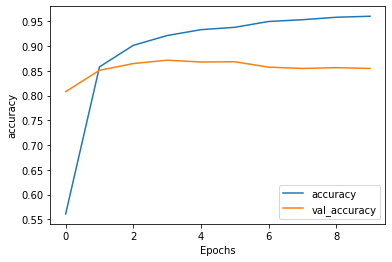

In [21]:
plot_graphs(history, 'accuracy')

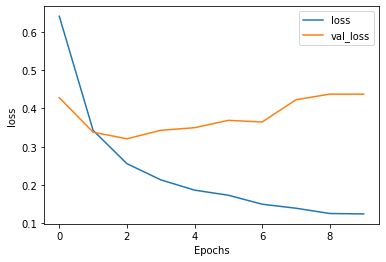

In [22]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6941 - accuracy: 0.5625

  2/391 [..............................] - ETA: 30s - loss: 0.6940 - accuracy: 0.5156

  3/391 [..............................] - ETA: 42s - loss: 0.6935 - accuracy: 0.5104

  4/391 [..............................] - ETA: 50s - loss: 0.6934 - accuracy: 0.4961

  5/391 [..............................] - ETA: 55s - loss: 0.6933 - accuracy: 0.4906

  6/391 [..............................] - ETA: 57s - loss: 0.6932 - accuracy: 0.4844

  7/391 [..............................] - ETA: 57s - loss: 0.6932 - accuracy: 0.4754

  8/391 [..............................] - ETA: 58s - loss: 0.6933 - accuracy: 0.4844

  9/391 [..............................] - ETA: 1:00 - loss: 0.6933 - accuracy: 0.4896

 10/391 [..............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4953

 11/391 [..............................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.5000

 12/391 [..............................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.4974

 13/391 [..............................] - ETA: 1:02 - loss: 0.6933 - accuracy: 0.4916

 14/391 [>.............................] - ETA: 1:03 - loss: 0.6933 - accuracy: 0.4967

 15/391 [>.............................] - ETA: 1:02 - loss: 0.6933 - accuracy: 0.4896

 16/391 [>.............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4883

 17/391 [>.............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4945

 18/391 [>.............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4974

 19/391 [>.............................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.4942

 20/391 [>.............................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.4867

 21/391 [>.............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.4896

 22/391 [>.............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.4844

 23/391 [>.............................] - ETA: 1:03 - loss: 0.6932 - accuracy: 0.4878

 24/391 [>.............................] - ETA: 1:03 - loss: 0.6932 - accuracy: 0.4850

 25/391 [>.............................] - ETA: 1:03 - loss: 0.6932 - accuracy: 0.4837

 26/391 [>.............................] - ETA: 1:03 - loss: 0.6932 - accuracy: 0.4832

 27/391 [=>............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.4809

 28/391 [=>............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.4855

 29/391 [=>............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.4838

 30/391 [=>............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.4849

 31/391 [=>............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.4859

 32/391 [=>............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.4883

 33/391 [=>............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.4863

 34/391 [=>............................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.4862

 35/391 [=>............................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.4879

 36/391 [=>............................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.4844

 37/391 [=>............................] - ETA: 1:02 - loss: 0.6930 - accuracy: 0.4823

 38/391 [=>............................] - ETA: 1:01 - loss: 0.6930 - accuracy: 0.4831

 39/391 [=>............................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.4860

 40/391 [==>...........................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.4852

 41/391 [==>...........................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.4859

 42/391 [==>...........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.4874

 43/391 [==>...........................] - ETA: 59s - loss: 0.6930 - accuracy: 0.4862 

 44/391 [==>...........................] - ETA: 59s - loss: 0.6930 - accuracy: 0.4851

 45/391 [==>...........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4861

 46/391 [==>...........................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.4857

 47/391 [==>...........................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.4857

 48/391 [==>...........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.4867

 49/391 [==>...........................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.4882

 50/391 [==>...........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4881 

 51/391 [==>...........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4893

 52/391 [==>...........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4883

 53/391 [===>..........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4879

 54/391 [===>..........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4876

 55/391 [===>..........................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4886

 56/391 [===>..........................] - ETA: 59s - loss: 0.6932 - accuracy: 0.4891

 57/391 [===>..........................] - ETA: 58s - loss: 0.6931 - accuracy: 0.4885

 58/391 [===>..........................] - ETA: 58s - loss: 0.6931 - accuracy: 0.4879

 59/391 [===>..........................] - ETA: 58s - loss: 0.6931 - accuracy: 0.4870

 60/391 [===>..........................] - ETA: 57s - loss: 0.6931 - accuracy: 0.4857

 61/391 [===>..........................] - ETA: 57s - loss: 0.6931 - accuracy: 0.4857

 62/391 [===>..........................] - ETA: 57s - loss: 0.6931 - accuracy: 0.4861

 63/391 [===>..........................] - ETA: 57s - loss: 0.6931 - accuracy: 0.4854

 64/391 [===>..........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.4861

 65/391 [===>..........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.4868

 66/391 [====>.........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.4870

 67/391 [====>.........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.4867

 68/391 [====>.........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.4878

 69/391 [====>.........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.4871

 70/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4871

 71/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4875

 72/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4883

 73/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4874

 74/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4865

 75/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4871

 76/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4879

 77/391 [====>.........................] - ETA: 54s - loss: 0.6932 - accuracy: 0.4882

 78/391 [====>.........................] - ETA: 54s - loss: 0.6932 - accuracy: 0.4880

 79/391 [=====>........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4881

 80/391 [=====>........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4879

 81/391 [=====>........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4884

 82/391 [=====>........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4869

 83/391 [=====>........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4872

 84/391 [=====>........................] - ETA: 53s - loss: 0.6931 - accuracy: 0.4874

 85/391 [=====>........................] - ETA: 53s - loss: 0.6931 - accuracy: 0.4877

 86/391 [=====>........................] - ETA: 53s - loss: 0.6931 - accuracy: 0.4871

 87/391 [=====>........................] - ETA: 53s - loss: 0.6931 - accuracy: 0.4865

 88/391 [=====>........................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4872

 89/391 [=====>........................] - ETA: 52s - loss: 0.6930 - accuracy: 0.4874

 90/391 [=====>........................] - ETA: 52s - loss: 0.6930 - accuracy: 0.4877

 91/391 [=====>........................] - ETA: 52s - loss: 0.6930 - accuracy: 0.4875

 92/391 [======>.......................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4881

 93/391 [======>.......................] - ETA: 52s - loss: 0.6930 - accuracy: 0.4879

 94/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.4880

 95/391 [======>.......................] - ETA: 51s - loss: 0.6930 - accuracy: 0.4875

 96/391 [======>.......................] - ETA: 51s - loss: 0.6930 - accuracy: 0.4875

 97/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.4892

 98/391 [======>.......................] - ETA: 51s - loss: 0.6930 - accuracy: 0.4893

 99/391 [======>.......................] - ETA: 50s - loss: 0.6930 - accuracy: 0.4890

100/391 [======>.......................] - ETA: 50s - loss: 0.6930 - accuracy: 0.4900

101/391 [======>.......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4909

102/391 [======>.......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4908

103/391 [======>.......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4912

104/391 [======>.......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4908

105/391 [=======>......................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4914

106/391 [=======>......................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4910

107/391 [=======>......................] - ETA: 49s - loss: 0.6930 - accuracy: 0.4911

108/391 [=======>......................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4920

109/391 [=======>......................] - ETA: 49s - loss: 0.6930 - accuracy: 0.4917

110/391 [=======>......................] - ETA: 49s - loss: 0.6930 - accuracy: 0.4906

111/391 [=======>......................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4910

112/391 [=======>......................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4918

113/391 [=======>......................] - ETA: 48s - loss: 0.6931 - accuracy: 0.4923

114/391 [=======>......................] - ETA: 48s - loss: 0.6931 - accuracy: 0.4929

115/391 [=======>......................] - ETA: 48s - loss: 0.6931 - accuracy: 0.4931

116/391 [=======>......................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4931

117/391 [=======>......................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4931

118/391 [========>.....................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4928

119/391 [========>.....................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4933

120/391 [========>.....................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4935

121/391 [========>.....................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4933

122/391 [========>.....................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4932

123/391 [========>.....................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4942

124/391 [========>.....................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4950

125/391 [========>.....................] - ETA: 46s - loss: 0.6931 - accuracy: 0.4961

126/391 [========>.....................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4959

127/391 [========>.....................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4961

128/391 [========>.....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4962

129/391 [========>.....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4966

130/391 [========>.....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4965

131/391 [=========>....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4965

132/391 [=========>....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4963

133/391 [=========>....................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4961

134/391 [=========>....................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4953

135/391 [=========>....................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4958

136/391 [=========>....................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4956

137/391 [=========>....................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4961

138/391 [=========>....................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4965

139/391 [=========>....................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4967

140/391 [=========>....................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4973

141/391 [=========>....................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4977

142/391 [=========>....................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4980

143/391 [=========>....................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4984

144/391 [==========>...................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4984

145/391 [==========>...................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4980

146/391 [==========>...................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4976

147/391 [==========>...................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4977

148/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4977

149/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4976

150/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4972

151/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4974

152/391 [==========>...................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4973

153/391 [==========>...................] - ETA: 41s - loss: 0.6930 - accuracy: 0.4977

154/391 [==========>...................] - ETA: 41s - loss: 0.6930 - accuracy: 0.4981

155/391 [==========>...................] - ETA: 41s - loss: 0.6930 - accuracy: 0.4982

156/391 [==========>...................] - ETA: 41s - loss: 0.6930 - accuracy: 0.4978

157/391 [===========>..................] - ETA: 41s - loss: 0.6930 - accuracy: 0.4973

158/391 [===========>..................] - ETA: 41s - loss: 0.6930 - accuracy: 0.4977

159/391 [===========>..................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4986

160/391 [===========>..................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4983

161/391 [===========>..................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4985

162/391 [===========>..................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4988

163/391 [===========>..................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4989

164/391 [===========>..................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4991

165/391 [===========>..................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4997

166/391 [===========>..................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4999

167/391 [===========>..................] - ETA: 39s - loss: 0.6929 - accuracy: 0.4996

168/391 [===========>..................] - ETA: 39s - loss: 0.6929 - accuracy: 0.5003

169/391 [===========>..................] - ETA: 39s - loss: 0.6929 - accuracy: 0.5008

170/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.5006

171/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.5004

172/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.5007

173/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.5010

174/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.5010

175/391 [============>.................] - ETA: 38s - loss: 0.6929 - accuracy: 0.5010

176/391 [============>.................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5007

177/391 [============>.................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5012

178/391 [============>.................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5009

179/391 [============>.................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5007

180/391 [============>.................] - ETA: 37s - loss: 0.6929 - accuracy: 0.5011

181/391 [============>.................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5012

182/391 [============>.................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5011

183/391 [=============>................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5009

184/391 [=============>................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5014

185/391 [=============>................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5015

186/391 [=============>................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5013

187/391 [=============>................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5016

188/391 [=============>................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5015

189/391 [=============>................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5017

190/391 [=============>................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5009

191/391 [=============>................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5007

192/391 [=============>................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5011

193/391 [=============>................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5011

194/391 [=============>................] - ETA: 34s - loss: 0.6928 - accuracy: 0.5010

195/391 [=============>................] - ETA: 34s - loss: 0.6928 - accuracy: 0.5006

196/391 [==============>...............] - ETA: 34s - loss: 0.6928 - accuracy: 0.5006

197/391 [==============>...............] - ETA: 34s - loss: 0.6928 - accuracy: 0.5005

198/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.5006

199/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.5005

200/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.5007

201/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.5002

202/391 [==============>...............] - ETA: 33s - loss: 0.6929 - accuracy: 0.5001

203/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.5006

204/391 [==============>...............] - ETA: 32s - loss: 0.6929 - accuracy: 0.5001

205/391 [==============>...............] - ETA: 32s - loss: 0.6929 - accuracy: 0.4996

206/391 [==============>...............] - ETA: 32s - loss: 0.6928 - accuracy: 0.5002

207/391 [==============>...............] - ETA: 32s - loss: 0.6928 - accuracy: 0.5003

208/391 [==============>...............] - ETA: 32s - loss: 0.6928 - accuracy: 0.4997

209/391 [===============>..............] - ETA: 32s - loss: 0.6928 - accuracy: 0.4998

210/391 [===============>..............] - ETA: 31s - loss: 0.6928 - accuracy: 0.4996

211/391 [===============>..............] - ETA: 31s - loss: 0.6928 - accuracy: 0.4993

212/391 [===============>..............] - ETA: 31s - loss: 0.6928 - accuracy: 0.4993

213/391 [===============>..............] - ETA: 31s - loss: 0.6928 - accuracy: 0.4992

214/391 [===============>..............] - ETA: 31s - loss: 0.6928 - accuracy: 0.4991

215/391 [===============>..............] - ETA: 30s - loss: 0.6928 - accuracy: 0.4992

216/391 [===============>..............] - ETA: 30s - loss: 0.6928 - accuracy: 0.4993

217/391 [===============>..............] - ETA: 30s - loss: 0.6928 - accuracy: 0.4988

218/391 [===============>..............] - ETA: 30s - loss: 0.6927 - accuracy: 0.4989

219/391 [===============>..............] - ETA: 30s - loss: 0.6927 - accuracy: 0.4989

220/391 [===============>..............] - ETA: 30s - loss: 0.6927 - accuracy: 0.4989

221/391 [===============>..............] - ETA: 29s - loss: 0.6927 - accuracy: 0.4997

222/391 [================>.............] - ETA: 29s - loss: 0.6927 - accuracy: 0.4996

223/391 [================>.............] - ETA: 29s - loss: 0.6927 - accuracy: 0.4996

224/391 [================>.............] - ETA: 29s - loss: 0.6927 - accuracy: 0.4998

225/391 [================>.............] - ETA: 29s - loss: 0.6927 - accuracy: 0.4994

226/391 [================>.............] - ETA: 29s - loss: 0.6927 - accuracy: 0.4992

227/391 [================>.............] - ETA: 28s - loss: 0.6927 - accuracy: 0.4991

228/391 [================>.............] - ETA: 28s - loss: 0.6927 - accuracy: 0.4992

229/391 [================>.............] - ETA: 28s - loss: 0.6927 - accuracy: 0.4997

230/391 [================>.............] - ETA: 28s - loss: 0.6927 - accuracy: 0.4997

231/391 [================>.............] - ETA: 28s - loss: 0.6927 - accuracy: 0.5002

232/391 [================>.............] - ETA: 27s - loss: 0.6926 - accuracy: 0.4997

233/391 [================>.............] - ETA: 27s - loss: 0.6926 - accuracy: 0.4997

234/391 [================>.............] - ETA: 27s - loss: 0.6926 - accuracy: 0.4993

235/391 [=================>............] - ETA: 27s - loss: 0.6926 - accuracy: 0.4993

236/391 [=================>............] - ETA: 27s - loss: 0.6926 - accuracy: 0.4993

237/391 [=================>............] - ETA: 27s - loss: 0.6926 - accuracy: 0.4992

238/391 [=================>............] - ETA: 26s - loss: 0.6926 - accuracy: 0.4991

239/391 [=================>............] - ETA: 26s - loss: 0.6926 - accuracy: 0.4989

240/391 [=================>............] - ETA: 26s - loss: 0.6925 - accuracy: 0.4986

241/391 [=================>............] - ETA: 26s - loss: 0.6925 - accuracy: 0.4984

242/391 [=================>............] - ETA: 26s - loss: 0.6925 - accuracy: 0.4989

243/391 [=================>............] - ETA: 25s - loss: 0.6925 - accuracy: 0.4988

244/391 [=================>............] - ETA: 25s - loss: 0.6925 - accuracy: 0.4990

245/391 [=================>............] - ETA: 25s - loss: 0.6925 - accuracy: 0.4990

246/391 [=================>............] - ETA: 25s - loss: 0.6925 - accuracy: 0.4990

247/391 [=================>............] - ETA: 25s - loss: 0.6925 - accuracy: 0.4992

248/391 [==================>...........] - ETA: 25s - loss: 0.6924 - accuracy: 0.4994

249/391 [==================>...........] - ETA: 24s - loss: 0.6924 - accuracy: 0.4989

250/391 [==================>...........] - ETA: 24s - loss: 0.6924 - accuracy: 0.4986

251/391 [==================>...........] - ETA: 24s - loss: 0.6924 - accuracy: 0.4986

252/391 [==================>...........] - ETA: 24s - loss: 0.6924 - accuracy: 0.4990

253/391 [==================>...........] - ETA: 24s - loss: 0.6923 - accuracy: 0.4991

254/391 [==================>...........] - ETA: 24s - loss: 0.6923 - accuracy: 0.4992

255/391 [==================>...........] - ETA: 23s - loss: 0.6923 - accuracy: 0.4990

256/391 [==================>...........] - ETA: 23s - loss: 0.6922 - accuracy: 0.4990

257/391 [==================>...........] - ETA: 23s - loss: 0.6922 - accuracy: 0.4988

258/391 [==================>...........] - ETA: 23s - loss: 0.6922 - accuracy: 0.4993

259/391 [==================>...........] - ETA: 23s - loss: 0.6921 - accuracy: 0.4993

260/391 [==================>...........] - ETA: 22s - loss: 0.6921 - accuracy: 0.4997

261/391 [===================>..........] - ETA: 22s - loss: 0.6921 - accuracy: 0.5000

262/391 [===================>..........] - ETA: 22s - loss: 0.6921 - accuracy: 0.5000

263/391 [===================>..........] - ETA: 22s - loss: 0.6920 - accuracy: 0.4998

264/391 [===================>..........] - ETA: 22s - loss: 0.6920 - accuracy: 0.5002

265/391 [===================>..........] - ETA: 22s - loss: 0.6919 - accuracy: 0.5001

266/391 [===================>..........] - ETA: 22s - loss: 0.6919 - accuracy: 0.4998

267/391 [===================>..........] - ETA: 21s - loss: 0.6918 - accuracy: 0.4997

268/391 [===================>..........] - ETA: 21s - loss: 0.6918 - accuracy: 0.4997

269/391 [===================>..........] - ETA: 21s - loss: 0.6918 - accuracy: 0.4994

270/391 [===================>..........] - ETA: 21s - loss: 0.6917 - accuracy: 0.4994

271/391 [===================>..........] - ETA: 21s - loss: 0.6916 - accuracy: 0.4993

272/391 [===================>..........] - ETA: 20s - loss: 0.6914 - accuracy: 0.4989

273/391 [===================>..........] - ETA: 20s - loss: 0.6914 - accuracy: 0.4989

274/391 [====================>.........] - ETA: 20s - loss: 0.6913 - accuracy: 0.4990

275/391 [====================>.........] - ETA: 20s - loss: 0.6912 - accuracy: 0.4991

276/391 [====================>.........] - ETA: 20s - loss: 0.6911 - accuracy: 0.4994

277/391 [====================>.........] - ETA: 20s - loss: 0.6909 - accuracy: 0.4990

278/391 [====================>.........] - ETA: 19s - loss: 0.6908 - accuracy: 0.4990

279/391 [====================>.........] - ETA: 19s - loss: 0.6906 - accuracy: 0.4989

280/391 [====================>.........] - ETA: 19s - loss: 0.6904 - accuracy: 0.4996

281/391 [====================>.........] - ETA: 19s - loss: 0.6903 - accuracy: 0.4998

282/391 [====================>.........] - ETA: 19s - loss: 0.6900 - accuracy: 0.5001

283/391 [====================>.........] - ETA: 19s - loss: 0.6899 - accuracy: 0.5003

284/391 [====================>.........] - ETA: 18s - loss: 0.6898 - accuracy: 0.5002

285/391 [====================>.........] - ETA: 18s - loss: 0.6896 - accuracy: 0.5004

286/391 [====================>.........] - ETA: 18s - loss: 0.6894 - accuracy: 0.5006

287/391 [=====================>........] - ETA: 18s - loss: 0.6893 - accuracy: 0.5007

288/391 [=====================>........] - ETA: 18s - loss: 0.6891 - accuracy: 0.5012

289/391 [=====================>........] - ETA: 17s - loss: 0.6888 - accuracy: 0.5015

290/391 [=====================>........] - ETA: 17s - loss: 0.6886 - accuracy: 0.5022

291/391 [=====================>........] - ETA: 17s - loss: 0.6882 - accuracy: 0.5031

292/391 [=====================>........] - ETA: 17s - loss: 0.6880 - accuracy: 0.5039

293/391 [=====================>........] - ETA: 17s - loss: 0.6879 - accuracy: 0.5044

294/391 [=====================>........] - ETA: 17s - loss: 0.6877 - accuracy: 0.5048

295/391 [=====================>........] - ETA: 16s - loss: 0.6874 - accuracy: 0.5051

296/391 [=====================>........] - ETA: 16s - loss: 0.6873 - accuracy: 0.5055

297/391 [=====================>........] - ETA: 16s - loss: 0.6870 - accuracy: 0.5059

298/391 [=====================>........] - ETA: 16s - loss: 0.6868 - accuracy: 0.5060

299/391 [=====================>........] - ETA: 16s - loss: 0.6865 - accuracy: 0.5065

300/391 [======================>.......] - ETA: 16s - loss: 0.6861 - accuracy: 0.5070

301/391 [======================>.......] - ETA: 15s - loss: 0.6859 - accuracy: 0.5074

302/391 [======================>.......] - ETA: 15s - loss: 0.6855 - accuracy: 0.5080

303/391 [======================>.......] - ETA: 15s - loss: 0.6851 - accuracy: 0.5086

304/391 [======================>.......] - ETA: 15s - loss: 0.6848 - accuracy: 0.5088

305/391 [======================>.......] - ETA: 15s - loss: 0.6844 - accuracy: 0.5098

306/391 [======================>.......] - ETA: 15s - loss: 0.6841 - accuracy: 0.5105

307/391 [======================>.......] - ETA: 14s - loss: 0.6840 - accuracy: 0.5110

308/391 [======================>.......] - ETA: 14s - loss: 0.6837 - accuracy: 0.5116

309/391 [======================>.......] - ETA: 14s - loss: 0.6834 - accuracy: 0.5123

310/391 [======================>.......] - ETA: 14s - loss: 0.6830 - accuracy: 0.5131

311/391 [======================>.......] - ETA: 14s - loss: 0.6824 - accuracy: 0.5140

312/391 [======================>.......] - ETA: 13s - loss: 0.6819 - accuracy: 0.5148

313/391 [=======================>......] - ETA: 13s - loss: 0.6817 - accuracy: 0.5153

314/391 [=======================>......] - ETA: 13s - loss: 0.6813 - accuracy: 0.5160

315/391 [=======================>......] - ETA: 13s - loss: 0.6808 - accuracy: 0.5166

316/391 [=======================>......] - ETA: 13s - loss: 0.6805 - accuracy: 0.5173

317/391 [=======================>......] - ETA: 13s - loss: 0.6798 - accuracy: 0.5182

318/391 [=======================>......] - ETA: 13s - loss: 0.6795 - accuracy: 0.5189

319/391 [=======================>......] - ETA: 12s - loss: 0.6792 - accuracy: 0.5195

320/391 [=======================>......] - ETA: 12s - loss: 0.6790 - accuracy: 0.5201

321/391 [=======================>......] - ETA: 12s - loss: 0.6788 - accuracy: 0.5207

322/391 [=======================>......] - ETA: 12s - loss: 0.6782 - accuracy: 0.5215

323/391 [=======================>......] - ETA: 12s - loss: 0.6778 - accuracy: 0.5221

324/391 [=======================>......] - ETA: 11s - loss: 0.6774 - accuracy: 0.5227

325/391 [=======================>......] - ETA: 11s - loss: 0.6772 - accuracy: 0.5231

326/391 [========================>.....] - ETA: 11s - loss: 0.6768 - accuracy: 0.5237

327/391 [========================>.....] - ETA: 11s - loss: 0.6765 - accuracy: 0.5241

328/391 [========================>.....] - ETA: 11s - loss: 0.6766 - accuracy: 0.5242

329/391 [========================>.....] - ETA: 11s - loss: 0.6762 - accuracy: 0.5247

330/391 [========================>.....] - ETA: 10s - loss: 0.6761 - accuracy: 0.5250

331/391 [========================>.....] - ETA: 10s - loss: 0.6758 - accuracy: 0.5253

332/391 [========================>.....] - ETA: 10s - loss: 0.6752 - accuracy: 0.5261

333/391 [========================>.....] - ETA: 10s - loss: 0.6748 - accuracy: 0.5266

334/391 [========================>.....] - ETA: 10s - loss: 0.6744 - accuracy: 0.5272

335/391 [========================>.....] - ETA: 10s - loss: 0.6740 - accuracy: 0.5278

336/391 [========================>.....] - ETA: 9s - loss: 0.6736 - accuracy: 0.5286 

337/391 [========================>.....] - ETA: 9s - loss: 0.6733 - accuracy: 0.5290

338/391 [========================>.....] - ETA: 9s - loss: 0.6729 - accuracy: 0.5295

339/391 [=========================>....] - ETA: 9s - loss: 0.6723 - accuracy: 0.5303

340/391 [=========================>....] - ETA: 9s - loss: 0.6717 - accuracy: 0.5310

341/391 [=========================>....] - ETA: 8s - loss: 0.6712 - accuracy: 0.5317

342/391 [=========================>....] - ETA: 8s - loss: 0.6708 - accuracy: 0.5324

343/391 [=========================>....] - ETA: 8s - loss: 0.6706 - accuracy: 0.5330

344/391 [=========================>....] - ETA: 8s - loss: 0.6704 - accuracy: 0.5335

345/391 [=========================>....] - ETA: 8s - loss: 0.6699 - accuracy: 0.5341

346/391 [=========================>....] - ETA: 8s - loss: 0.6696 - accuracy: 0.5346

347/391 [=========================>....] - ETA: 7s - loss: 0.6694 - accuracy: 0.5349

348/391 [=========================>....] - ETA: 7s - loss: 0.6693 - accuracy: 0.5352

349/391 [=========================>....] - ETA: 7s - loss: 0.6690 - accuracy: 0.5358

350/391 [=========================>....] - ETA: 7s - loss: 0.6690 - accuracy: 0.5360

351/391 [=========================>....] - ETA: 7s - loss: 0.6689 - accuracy: 0.5364

352/391 [==========================>...] - ETA: 6s - loss: 0.6685 - accuracy: 0.5371

353/391 [==========================>...] - ETA: 6s - loss: 0.6679 - accuracy: 0.5378

354/391 [==========================>...] - ETA: 6s - loss: 0.6674 - accuracy: 0.5384

355/391 [==========================>...] - ETA: 6s - loss: 0.6671 - accuracy: 0.5391

356/391 [==========================>...] - ETA: 6s - loss: 0.6666 - accuracy: 0.5399

357/391 [==========================>...] - ETA: 6s - loss: 0.6663 - accuracy: 0.5404

358/391 [==========================>...] - ETA: 5s - loss: 0.6659 - accuracy: 0.5412

359/391 [==========================>...] - ETA: 5s - loss: 0.6656 - accuracy: 0.5419

360/391 [==========================>...] - ETA: 5s - loss: 0.6652 - accuracy: 0.5425

361/391 [==========================>...] - ETA: 5s - loss: 0.6649 - accuracy: 0.5430

362/391 [==========================>...] - ETA: 5s - loss: 0.6648 - accuracy: 0.5435

363/391 [==========================>...] - ETA: 5s - loss: 0.6642 - accuracy: 0.5441

364/391 [==========================>...] - ETA: 4s - loss: 0.6638 - accuracy: 0.5447

365/391 [===========================>..] - ETA: 4s - loss: 0.6635 - accuracy: 0.5451

366/391 [===========================>..] - ETA: 4s - loss: 0.6631 - accuracy: 0.5455

367/391 [===========================>..] - ETA: 4s - loss: 0.6627 - accuracy: 0.5459

368/391 [===========================>..] - ETA: 4s - loss: 0.6622 - accuracy: 0.5464

369/391 [===========================>..] - ETA: 3s - loss: 0.6617 - accuracy: 0.5469

370/391 [===========================>..] - ETA: 3s - loss: 0.6613 - accuracy: 0.5475

371/391 [===========================>..] - ETA: 3s - loss: 0.6612 - accuracy: 0.5476

372/391 [===========================>..] - ETA: 3s - loss: 0.6607 - accuracy: 0.5482

373/391 [===========================>..] - ETA: 3s - loss: 0.6603 - accuracy: 0.5488

374/391 [===========================>..] - ETA: 3s - loss: 0.6601 - accuracy: 0.5493

375/391 [===========================>..] - ETA: 2s - loss: 0.6596 - accuracy: 0.5500

376/391 [===========================>..] - ETA: 2s - loss: 0.6591 - accuracy: 0.5505

377/391 [===========================>..] - ETA: 2s - loss: 0.6589 - accuracy: 0.5511

378/391 [============================>.] - ETA: 2s - loss: 0.6588 - accuracy: 0.5514

379/391 [============================>.] - ETA: 2s - loss: 0.6583 - accuracy: 0.5519

380/391 [============================>.] - ETA: 1s - loss: 0.6577 - accuracy: 0.5526

381/391 [============================>.] - ETA: 1s - loss: 0.6573 - accuracy: 0.5531

382/391 [============================>.] - ETA: 1s - loss: 0.6566 - accuracy: 0.5539

383/391 [============================>.] - ETA: 1s - loss: 0.6561 - accuracy: 0.5545

384/391 [============================>.] - ETA: 1s - loss: 0.6559 - accuracy: 0.5550

385/391 [============================>.] - ETA: 1s - loss: 0.6556 - accuracy: 0.5552

386/391 [============================>.] - ETA: 0s - loss: 0.6552 - accuracy: 0.5557

387/391 [============================>.] - ETA: 0s - loss: 0.6550 - accuracy: 0.5561

388/391 [============================>.] - ETA: 0s - loss: 0.6545 - accuracy: 0.5568

389/391 [============================>.] - ETA: 0s - loss: 0.6539 - accuracy: 0.5574

390/391 [============================>.] - ETA: 0s - loss: 0.6536 - accuracy: 0.5579

391/391 [==============================] - ETA: 0s - loss: 0.6533 - accuracy: 0.5583

391/391 [==============================] - 73s 188ms/step - loss: 0.6533 - accuracy: 0.5583 - val_loss: 0.5066 - val_accuracy: 0.7781


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.4415 - accuracy: 0.8281

  2/391 [..............................] - ETA: 31s - loss: 0.4512 - accuracy: 0.8438

  3/391 [..............................] - ETA: 45s - loss: 0.4373 - accuracy: 0.8333

  4/391 [..............................] - ETA: 55s - loss: 0.4639 - accuracy: 0.8203

  5/391 [..............................] - ETA: 55s - loss: 0.4546 - accuracy: 0.8250

  6/391 [..............................] - ETA: 56s - loss: 0.4521 - accuracy: 0.8229

  7/391 [..............................] - ETA: 57s - loss: 0.4497 - accuracy: 0.8192

  8/391 [..............................] - ETA: 1:06 - loss: 0.4656 - accuracy: 0.8086

  9/391 [..............................] - ETA: 1:05 - loss: 0.4821 - accuracy: 0.7986

 10/391 [..............................] - ETA: 1:05 - loss: 0.4937 - accuracy: 0.7922

 11/391 [..............................] - ETA: 1:04 - loss: 0.4979 - accuracy: 0.7940

 12/391 [..............................] - ETA: 1:05 - loss: 0.4967 - accuracy: 0.7943

 13/391 [..............................] - ETA: 1:06 - loss: 0.5046 - accuracy: 0.7897

 14/391 [>.............................] - ETA: 1:06 - loss: 0.5117 - accuracy: 0.7868

 15/391 [>.............................] - ETA: 1:06 - loss: 0.5175 - accuracy: 0.7844

 16/391 [>.............................] - ETA: 1:06 - loss: 0.5187 - accuracy: 0.7832

 17/391 [>.............................] - ETA: 1:06 - loss: 0.5222 - accuracy: 0.7803

 18/391 [>.............................] - ETA: 1:06 - loss: 0.5325 - accuracy: 0.7743

 19/391 [>.............................] - ETA: 1:06 - loss: 0.5376 - accuracy: 0.7689

 20/391 [>.............................] - ETA: 1:05 - loss: 0.5367 - accuracy: 0.7688

 21/391 [>.............................] - ETA: 1:05 - loss: 0.5366 - accuracy: 0.7693

 22/391 [>.............................] - ETA: 1:05 - loss: 0.5354 - accuracy: 0.7713

 23/391 [>.............................] - ETA: 1:04 - loss: 0.5350 - accuracy: 0.7711

 24/391 [>.............................] - ETA: 1:04 - loss: 0.5348 - accuracy: 0.7695

 25/391 [>.............................] - ETA: 1:04 - loss: 0.5392 - accuracy: 0.7656

 26/391 [>.............................] - ETA: 1:03 - loss: 0.5359 - accuracy: 0.7662

 27/391 [=>............................] - ETA: 1:04 - loss: 0.5316 - accuracy: 0.7685

 28/391 [=>............................] - ETA: 1:04 - loss: 0.5294 - accuracy: 0.7712

 29/391 [=>............................] - ETA: 1:03 - loss: 0.5284 - accuracy: 0.7721

 30/391 [=>............................] - ETA: 1:03 - loss: 0.5292 - accuracy: 0.7708

 31/391 [=>............................] - ETA: 1:03 - loss: 0.5278 - accuracy: 0.7717

 32/391 [=>............................] - ETA: 1:03 - loss: 0.5258 - accuracy: 0.7734

 33/391 [=>............................] - ETA: 1:03 - loss: 0.5271 - accuracy: 0.7713

 34/391 [=>............................] - ETA: 1:02 - loss: 0.5268 - accuracy: 0.7716

 35/391 [=>............................] - ETA: 1:02 - loss: 0.5248 - accuracy: 0.7732

 36/391 [=>............................] - ETA: 1:03 - loss: 0.5241 - accuracy: 0.7743

 37/391 [=>............................] - ETA: 1:02 - loss: 0.5214 - accuracy: 0.7758

 38/391 [=>............................] - ETA: 1:02 - loss: 0.5195 - accuracy: 0.7759

 39/391 [=>............................] - ETA: 1:02 - loss: 0.5171 - accuracy: 0.7780

 40/391 [==>...........................] - ETA: 1:02 - loss: 0.5181 - accuracy: 0.7773

 41/391 [==>...........................] - ETA: 1:02 - loss: 0.5175 - accuracy: 0.7782

 42/391 [==>...........................] - ETA: 1:02 - loss: 0.5160 - accuracy: 0.7768

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.5189 - accuracy: 0.7743

 44/391 [==>...........................] - ETA: 1:02 - loss: 0.5199 - accuracy: 0.7727

 45/391 [==>...........................] - ETA: 1:01 - loss: 0.5191 - accuracy: 0.7729

 46/391 [==>...........................] - ETA: 1:01 - loss: 0.5170 - accuracy: 0.7731

 47/391 [==>...........................] - ETA: 1:00 - loss: 0.5187 - accuracy: 0.7719

 48/391 [==>...........................] - ETA: 1:00 - loss: 0.5185 - accuracy: 0.7718

 49/391 [==>...........................] - ETA: 1:00 - loss: 0.5204 - accuracy: 0.7707

 50/391 [==>...........................] - ETA: 1:00 - loss: 0.5199 - accuracy: 0.7703

 51/391 [==>...........................] - ETA: 1:00 - loss: 0.5184 - accuracy: 0.7708

 52/391 [==>...........................] - ETA: 1:00 - loss: 0.5162 - accuracy: 0.7716

 53/391 [===>..........................] - ETA: 1:00 - loss: 0.5149 - accuracy: 0.7712

 54/391 [===>..........................] - ETA: 59s - loss: 0.5140 - accuracy: 0.7717 

 55/391 [===>..........................] - ETA: 59s - loss: 0.5110 - accuracy: 0.7744

 56/391 [===>..........................] - ETA: 59s - loss: 0.5095 - accuracy: 0.7759

 57/391 [===>..........................] - ETA: 59s - loss: 0.5084 - accuracy: 0.7769

 58/391 [===>..........................] - ETA: 59s - loss: 0.5065 - accuracy: 0.7772

 59/391 [===>..........................] - ETA: 59s - loss: 0.5071 - accuracy: 0.7775

 60/391 [===>..........................] - ETA: 59s - loss: 0.5067 - accuracy: 0.7784

 61/391 [===>..........................] - ETA: 58s - loss: 0.5049 - accuracy: 0.7792

 62/391 [===>..........................] - ETA: 58s - loss: 0.5065 - accuracy: 0.7767

 63/391 [===>..........................] - ETA: 58s - loss: 0.5064 - accuracy: 0.7768

 64/391 [===>..........................] - ETA: 58s - loss: 0.5067 - accuracy: 0.7764

 65/391 [===>..........................] - ETA: 57s - loss: 0.5082 - accuracy: 0.7757

 66/391 [====>.........................] - ETA: 57s - loss: 0.5076 - accuracy: 0.7763

 67/391 [====>.........................] - ETA: 57s - loss: 0.5067 - accuracy: 0.7761

 68/391 [====>.........................] - ETA: 57s - loss: 0.5050 - accuracy: 0.7771

 69/391 [====>.........................] - ETA: 57s - loss: 0.5045 - accuracy: 0.7769

 70/391 [====>.........................] - ETA: 57s - loss: 0.5045 - accuracy: 0.7763

 71/391 [====>.........................] - ETA: 57s - loss: 0.5041 - accuracy: 0.7755

 72/391 [====>.........................] - ETA: 57s - loss: 0.5033 - accuracy: 0.7758

 73/391 [====>.........................] - ETA: 57s - loss: 0.5034 - accuracy: 0.7757

 74/391 [====>.........................] - ETA: 57s - loss: 0.5023 - accuracy: 0.7764

 75/391 [====>.........................] - ETA: 57s - loss: 0.5015 - accuracy: 0.7765

 76/391 [====>.........................] - ETA: 57s - loss: 0.4995 - accuracy: 0.7778

 77/391 [====>.........................] - ETA: 56s - loss: 0.4998 - accuracy: 0.7772

 78/391 [====>.........................] - ETA: 56s - loss: 0.4987 - accuracy: 0.7774

 79/391 [=====>........................] - ETA: 56s - loss: 0.4984 - accuracy: 0.7777

 80/391 [=====>........................] - ETA: 56s - loss: 0.4973 - accuracy: 0.7787

 81/391 [=====>........................] - ETA: 56s - loss: 0.4966 - accuracy: 0.7785

 82/391 [=====>........................] - ETA: 55s - loss: 0.4972 - accuracy: 0.7784

 83/391 [=====>........................] - ETA: 55s - loss: 0.4962 - accuracy: 0.7786

 84/391 [=====>........................] - ETA: 55s - loss: 0.4961 - accuracy: 0.7785

 85/391 [=====>........................] - ETA: 55s - loss: 0.4963 - accuracy: 0.7778

 86/391 [=====>........................] - ETA: 56s - loss: 0.4952 - accuracy: 0.7785

 87/391 [=====>........................] - ETA: 56s - loss: 0.4953 - accuracy: 0.7786

 88/391 [=====>........................] - ETA: 55s - loss: 0.4942 - accuracy: 0.7789

 89/391 [=====>........................] - ETA: 55s - loss: 0.4938 - accuracy: 0.7793

 90/391 [=====>........................] - ETA: 55s - loss: 0.4931 - accuracy: 0.7799

 91/391 [=====>........................] - ETA: 54s - loss: 0.4928 - accuracy: 0.7797

 92/391 [======>.......................] - ETA: 54s - loss: 0.4920 - accuracy: 0.7801

 93/391 [======>.......................] - ETA: 54s - loss: 0.4919 - accuracy: 0.7799

 94/391 [======>.......................] - ETA: 54s - loss: 0.4910 - accuracy: 0.7806

 95/391 [======>.......................] - ETA: 54s - loss: 0.4903 - accuracy: 0.7812

 96/391 [======>.......................] - ETA: 53s - loss: 0.4897 - accuracy: 0.7821

 97/391 [======>.......................] - ETA: 53s - loss: 0.4892 - accuracy: 0.7824

 98/391 [======>.......................] - ETA: 53s - loss: 0.4881 - accuracy: 0.7830

 99/391 [======>.......................] - ETA: 53s - loss: 0.4884 - accuracy: 0.7827

100/391 [======>.......................] - ETA: 52s - loss: 0.4880 - accuracy: 0.7831

101/391 [======>.......................] - ETA: 52s - loss: 0.4879 - accuracy: 0.7834

102/391 [======>.......................] - ETA: 52s - loss: 0.4868 - accuracy: 0.7839

103/391 [======>.......................] - ETA: 52s - loss: 0.4877 - accuracy: 0.7832

104/391 [======>.......................] - ETA: 52s - loss: 0.4885 - accuracy: 0.7828

105/391 [=======>......................] - ETA: 51s - loss: 0.4869 - accuracy: 0.7836

106/391 [=======>......................] - ETA: 51s - loss: 0.4856 - accuracy: 0.7848

107/391 [=======>......................] - ETA: 51s - loss: 0.4849 - accuracy: 0.7852

108/391 [=======>......................] - ETA: 51s - loss: 0.4852 - accuracy: 0.7853

109/391 [=======>......................] - ETA: 51s - loss: 0.4843 - accuracy: 0.7861

110/391 [=======>......................] - ETA: 50s - loss: 0.4838 - accuracy: 0.7866

111/391 [=======>......................] - ETA: 50s - loss: 0.4830 - accuracy: 0.7870

112/391 [=======>......................] - ETA: 50s - loss: 0.4825 - accuracy: 0.7878

113/391 [=======>......................] - ETA: 50s - loss: 0.4815 - accuracy: 0.7886

114/391 [=======>......................] - ETA: 50s - loss: 0.4805 - accuracy: 0.7893

115/391 [=======>......................] - ETA: 50s - loss: 0.4804 - accuracy: 0.7894

116/391 [=======>......................] - ETA: 50s - loss: 0.4806 - accuracy: 0.7893

117/391 [=======>......................] - ETA: 49s - loss: 0.4800 - accuracy: 0.7901

118/391 [========>.....................] - ETA: 49s - loss: 0.4787 - accuracy: 0.7910

119/391 [========>.....................] - ETA: 49s - loss: 0.4770 - accuracy: 0.7924

120/391 [========>.....................] - ETA: 49s - loss: 0.4767 - accuracy: 0.7926

121/391 [========>.....................] - ETA: 49s - loss: 0.4749 - accuracy: 0.7938

122/391 [========>.....................] - ETA: 48s - loss: 0.4743 - accuracy: 0.7938

123/391 [========>.....................] - ETA: 48s - loss: 0.4739 - accuracy: 0.7943

124/391 [========>.....................] - ETA: 48s - loss: 0.4725 - accuracy: 0.7951

125/391 [========>.....................] - ETA: 48s - loss: 0.4720 - accuracy: 0.7956

126/391 [========>.....................] - ETA: 48s - loss: 0.4725 - accuracy: 0.7954

127/391 [========>.....................] - ETA: 48s - loss: 0.4728 - accuracy: 0.7953

128/391 [========>.....................] - ETA: 47s - loss: 0.4732 - accuracy: 0.7952

129/391 [========>.....................] - ETA: 47s - loss: 0.4723 - accuracy: 0.7955

130/391 [========>.....................] - ETA: 47s - loss: 0.4709 - accuracy: 0.7962

131/391 [=========>....................] - ETA: 47s - loss: 0.4706 - accuracy: 0.7965

132/391 [=========>....................] - ETA: 47s - loss: 0.4703 - accuracy: 0.7966

133/391 [=========>....................] - ETA: 47s - loss: 0.4699 - accuracy: 0.7971

134/391 [=========>....................] - ETA: 46s - loss: 0.4692 - accuracy: 0.7977

135/391 [=========>....................] - ETA: 46s - loss: 0.4682 - accuracy: 0.7981

136/391 [=========>....................] - ETA: 46s - loss: 0.4666 - accuracy: 0.7991

137/391 [=========>....................] - ETA: 46s - loss: 0.4661 - accuracy: 0.7993

138/391 [=========>....................] - ETA: 45s - loss: 0.4659 - accuracy: 0.7990

139/391 [=========>....................] - ETA: 45s - loss: 0.4663 - accuracy: 0.7989

140/391 [=========>....................] - ETA: 45s - loss: 0.4679 - accuracy: 0.7981

141/391 [=========>....................] - ETA: 45s - loss: 0.4668 - accuracy: 0.7988

142/391 [=========>....................] - ETA: 45s - loss: 0.4656 - accuracy: 0.7995

143/391 [=========>....................] - ETA: 45s - loss: 0.4642 - accuracy: 0.8004

144/391 [==========>...................] - ETA: 44s - loss: 0.4647 - accuracy: 0.7999

145/391 [==========>...................] - ETA: 44s - loss: 0.4644 - accuracy: 0.8001

146/391 [==========>...................] - ETA: 44s - loss: 0.4639 - accuracy: 0.8003

147/391 [==========>...................] - ETA: 44s - loss: 0.4632 - accuracy: 0.8007

148/391 [==========>...................] - ETA: 44s - loss: 0.4627 - accuracy: 0.8010

149/391 [==========>...................] - ETA: 44s - loss: 0.4620 - accuracy: 0.8015

150/391 [==========>...................] - ETA: 44s - loss: 0.4618 - accuracy: 0.8015

151/391 [==========>...................] - ETA: 44s - loss: 0.4623 - accuracy: 0.8012

152/391 [==========>...................] - ETA: 43s - loss: 0.4616 - accuracy: 0.8014

153/391 [==========>...................] - ETA: 43s - loss: 0.4611 - accuracy: 0.8018

154/391 [==========>...................] - ETA: 43s - loss: 0.4605 - accuracy: 0.8020

155/391 [==========>...................] - ETA: 43s - loss: 0.4605 - accuracy: 0.8020

156/391 [==========>...................] - ETA: 43s - loss: 0.4606 - accuracy: 0.8021

157/391 [===========>..................] - ETA: 43s - loss: 0.4607 - accuracy: 0.8021

158/391 [===========>..................] - ETA: 42s - loss: 0.4602 - accuracy: 0.8021

159/391 [===========>..................] - ETA: 42s - loss: 0.4603 - accuracy: 0.8020

160/391 [===========>..................] - ETA: 42s - loss: 0.4595 - accuracy: 0.8023

161/391 [===========>..................] - ETA: 42s - loss: 0.4591 - accuracy: 0.8023

162/391 [===========>..................] - ETA: 42s - loss: 0.4587 - accuracy: 0.8026

163/391 [===========>..................] - ETA: 41s - loss: 0.4581 - accuracy: 0.8031

164/391 [===========>..................] - ETA: 41s - loss: 0.4581 - accuracy: 0.8028

165/391 [===========>..................] - ETA: 41s - loss: 0.4574 - accuracy: 0.8034

166/391 [===========>..................] - ETA: 41s - loss: 0.4568 - accuracy: 0.8037

167/391 [===========>..................] - ETA: 41s - loss: 0.4562 - accuracy: 0.8042

168/391 [===========>..................] - ETA: 40s - loss: 0.4563 - accuracy: 0.8042

169/391 [===========>..................] - ETA: 40s - loss: 0.4572 - accuracy: 0.8038

170/391 [============>.................] - ETA: 40s - loss: 0.4564 - accuracy: 0.8044

171/391 [============>.................] - ETA: 40s - loss: 0.4559 - accuracy: 0.8049

172/391 [============>.................] - ETA: 40s - loss: 0.4564 - accuracy: 0.8045

173/391 [============>.................] - ETA: 40s - loss: 0.4567 - accuracy: 0.8045

174/391 [============>.................] - ETA: 39s - loss: 0.4564 - accuracy: 0.8045

175/391 [============>.................] - ETA: 39s - loss: 0.4560 - accuracy: 0.8048

176/391 [============>.................] - ETA: 39s - loss: 0.4562 - accuracy: 0.8046

177/391 [============>.................] - ETA: 39s - loss: 0.4561 - accuracy: 0.8046

178/391 [============>.................] - ETA: 39s - loss: 0.4554 - accuracy: 0.8050

179/391 [============>.................] - ETA: 39s - loss: 0.4551 - accuracy: 0.8053

180/391 [============>.................] - ETA: 38s - loss: 0.4546 - accuracy: 0.8056

181/391 [============>.................] - ETA: 38s - loss: 0.4548 - accuracy: 0.8054

182/391 [============>.................] - ETA: 38s - loss: 0.4552 - accuracy: 0.8049

183/391 [=============>................] - ETA: 38s - loss: 0.4553 - accuracy: 0.8049

184/391 [=============>................] - ETA: 38s - loss: 0.4553 - accuracy: 0.8048

185/391 [=============>................] - ETA: 37s - loss: 0.4545 - accuracy: 0.8050

186/391 [=============>................] - ETA: 37s - loss: 0.4538 - accuracy: 0.8053

187/391 [=============>................] - ETA: 37s - loss: 0.4537 - accuracy: 0.8053

188/391 [=============>................] - ETA: 37s - loss: 0.4529 - accuracy: 0.8058

189/391 [=============>................] - ETA: 37s - loss: 0.4522 - accuracy: 0.8063

190/391 [=============>................] - ETA: 36s - loss: 0.4516 - accuracy: 0.8066

191/391 [=============>................] - ETA: 36s - loss: 0.4511 - accuracy: 0.8068

192/391 [=============>................] - ETA: 36s - loss: 0.4512 - accuracy: 0.8066

193/391 [=============>................] - ETA: 36s - loss: 0.4512 - accuracy: 0.8068

194/391 [=============>................] - ETA: 36s - loss: 0.4514 - accuracy: 0.8068

195/391 [=============>................] - ETA: 36s - loss: 0.4509 - accuracy: 0.8071

196/391 [==============>...............] - ETA: 35s - loss: 0.4509 - accuracy: 0.8072

197/391 [==============>...............] - ETA: 35s - loss: 0.4509 - accuracy: 0.8073

198/391 [==============>...............] - ETA: 35s - loss: 0.4504 - accuracy: 0.8075

199/391 [==============>...............] - ETA: 35s - loss: 0.4505 - accuracy: 0.8072

200/391 [==============>...............] - ETA: 35s - loss: 0.4501 - accuracy: 0.8074

201/391 [==============>...............] - ETA: 34s - loss: 0.4499 - accuracy: 0.8074

202/391 [==============>...............] - ETA: 34s - loss: 0.4492 - accuracy: 0.8079

203/391 [==============>...............] - ETA: 34s - loss: 0.4485 - accuracy: 0.8083

204/391 [==============>...............] - ETA: 34s - loss: 0.4479 - accuracy: 0.8086

205/391 [==============>...............] - ETA: 34s - loss: 0.4478 - accuracy: 0.8085

206/391 [==============>...............] - ETA: 34s - loss: 0.4478 - accuracy: 0.8086

207/391 [==============>...............] - ETA: 33s - loss: 0.4475 - accuracy: 0.8086

208/391 [==============>...............] - ETA: 33s - loss: 0.4474 - accuracy: 0.8087

209/391 [===============>..............] - ETA: 33s - loss: 0.4471 - accuracy: 0.8089

210/391 [===============>..............] - ETA: 33s - loss: 0.4470 - accuracy: 0.8091

211/391 [===============>..............] - ETA: 33s - loss: 0.4460 - accuracy: 0.8097

212/391 [===============>..............] - ETA: 32s - loss: 0.4457 - accuracy: 0.8101

213/391 [===============>..............] - ETA: 32s - loss: 0.4462 - accuracy: 0.8098

214/391 [===============>..............] - ETA: 32s - loss: 0.4455 - accuracy: 0.8102

215/391 [===============>..............] - ETA: 32s - loss: 0.4454 - accuracy: 0.8104

216/391 [===============>..............] - ETA: 32s - loss: 0.4454 - accuracy: 0.8105

217/391 [===============>..............] - ETA: 32s - loss: 0.4455 - accuracy: 0.8105

218/391 [===============>..............] - ETA: 31s - loss: 0.4453 - accuracy: 0.8105

219/391 [===============>..............] - ETA: 31s - loss: 0.4453 - accuracy: 0.8106

220/391 [===============>..............] - ETA: 31s - loss: 0.4451 - accuracy: 0.8109

221/391 [===============>..............] - ETA: 31s - loss: 0.4453 - accuracy: 0.8110

222/391 [================>.............] - ETA: 31s - loss: 0.4449 - accuracy: 0.8112

223/391 [================>.............] - ETA: 30s - loss: 0.4452 - accuracy: 0.8110

224/391 [================>.............] - ETA: 30s - loss: 0.4450 - accuracy: 0.8113

225/391 [================>.............] - ETA: 30s - loss: 0.4446 - accuracy: 0.8113

226/391 [================>.............] - ETA: 30s - loss: 0.4441 - accuracy: 0.8117

227/391 [================>.............] - ETA: 30s - loss: 0.4437 - accuracy: 0.8119

228/391 [================>.............] - ETA: 29s - loss: 0.4434 - accuracy: 0.8122

229/391 [================>.............] - ETA: 29s - loss: 0.4430 - accuracy: 0.8126

230/391 [================>.............] - ETA: 29s - loss: 0.4429 - accuracy: 0.8126

231/391 [================>.............] - ETA: 29s - loss: 0.4428 - accuracy: 0.8128

232/391 [================>.............] - ETA: 29s - loss: 0.4422 - accuracy: 0.8132

233/391 [================>.............] - ETA: 28s - loss: 0.4424 - accuracy: 0.8130

234/391 [================>.............] - ETA: 28s - loss: 0.4419 - accuracy: 0.8132

235/391 [=================>............] - ETA: 28s - loss: 0.4416 - accuracy: 0.8133

236/391 [=================>............] - ETA: 28s - loss: 0.4419 - accuracy: 0.8127

237/391 [=================>............] - ETA: 28s - loss: 0.4415 - accuracy: 0.8130

238/391 [=================>............] - ETA: 28s - loss: 0.4413 - accuracy: 0.8131

239/391 [=================>............] - ETA: 27s - loss: 0.4409 - accuracy: 0.8133

240/391 [=================>............] - ETA: 27s - loss: 0.4408 - accuracy: 0.8132

241/391 [=================>............] - ETA: 27s - loss: 0.4407 - accuracy: 0.8132

242/391 [=================>............] - ETA: 27s - loss: 0.4407 - accuracy: 0.8130

243/391 [=================>............] - ETA: 27s - loss: 0.4403 - accuracy: 0.8131

244/391 [=================>............] - ETA: 26s - loss: 0.4399 - accuracy: 0.8132

245/391 [=================>............] - ETA: 26s - loss: 0.4398 - accuracy: 0.8133

246/391 [=================>............] - ETA: 26s - loss: 0.4392 - accuracy: 0.8136

247/391 [=================>............] - ETA: 26s - loss: 0.4389 - accuracy: 0.8138

248/391 [==================>...........] - ETA: 26s - loss: 0.4383 - accuracy: 0.8142

249/391 [==================>...........] - ETA: 26s - loss: 0.4379 - accuracy: 0.8143

250/391 [==================>...........] - ETA: 25s - loss: 0.4376 - accuracy: 0.8146

251/391 [==================>...........] - ETA: 25s - loss: 0.4371 - accuracy: 0.8149

252/391 [==================>...........] - ETA: 25s - loss: 0.4379 - accuracy: 0.8147

253/391 [==================>...........] - ETA: 25s - loss: 0.4378 - accuracy: 0.8148

254/391 [==================>...........] - ETA: 25s - loss: 0.4378 - accuracy: 0.8147

255/391 [==================>...........] - ETA: 24s - loss: 0.4376 - accuracy: 0.8148

256/391 [==================>...........] - ETA: 24s - loss: 0.4371 - accuracy: 0.8150

257/391 [==================>...........] - ETA: 24s - loss: 0.4369 - accuracy: 0.8151

258/391 [==================>...........] - ETA: 24s - loss: 0.4364 - accuracy: 0.8151

259/391 [==================>...........] - ETA: 24s - loss: 0.4359 - accuracy: 0.8153

260/391 [==================>...........] - ETA: 23s - loss: 0.4358 - accuracy: 0.8154

261/391 [===================>..........] - ETA: 23s - loss: 0.4353 - accuracy: 0.8159

262/391 [===================>..........] - ETA: 23s - loss: 0.4351 - accuracy: 0.8161

263/391 [===================>..........] - ETA: 23s - loss: 0.4349 - accuracy: 0.8162

264/391 [===================>..........] - ETA: 23s - loss: 0.4343 - accuracy: 0.8165

265/391 [===================>..........] - ETA: 23s - loss: 0.4342 - accuracy: 0.8166

266/391 [===================>..........] - ETA: 22s - loss: 0.4343 - accuracy: 0.8167

267/391 [===================>..........] - ETA: 22s - loss: 0.4339 - accuracy: 0.8169

268/391 [===================>..........] - ETA: 22s - loss: 0.4329 - accuracy: 0.8174

269/391 [===================>..........] - ETA: 22s - loss: 0.4325 - accuracy: 0.8177

270/391 [===================>..........] - ETA: 22s - loss: 0.4327 - accuracy: 0.8178

271/391 [===================>..........] - ETA: 21s - loss: 0.4333 - accuracy: 0.8177

272/391 [===================>..........] - ETA: 21s - loss: 0.4330 - accuracy: 0.8178

273/391 [===================>..........] - ETA: 21s - loss: 0.4328 - accuracy: 0.8179

274/391 [====================>.........] - ETA: 21s - loss: 0.4325 - accuracy: 0.8180

275/391 [====================>.........] - ETA: 21s - loss: 0.4325 - accuracy: 0.8182

276/391 [====================>.........] - ETA: 21s - loss: 0.4324 - accuracy: 0.8183

277/391 [====================>.........] - ETA: 20s - loss: 0.4328 - accuracy: 0.8181

278/391 [====================>.........] - ETA: 20s - loss: 0.4332 - accuracy: 0.8178

279/391 [====================>.........] - ETA: 20s - loss: 0.4341 - accuracy: 0.8173

280/391 [====================>.........] - ETA: 20s - loss: 0.4345 - accuracy: 0.8171

281/391 [====================>.........] - ETA: 20s - loss: 0.4342 - accuracy: 0.8171

282/391 [====================>.........] - ETA: 19s - loss: 0.4335 - accuracy: 0.8174

283/391 [====================>.........] - ETA: 19s - loss: 0.4333 - accuracy: 0.8176

284/391 [====================>.........] - ETA: 19s - loss: 0.4331 - accuracy: 0.8176

285/391 [====================>.........] - ETA: 19s - loss: 0.4327 - accuracy: 0.8178

286/391 [====================>.........] - ETA: 19s - loss: 0.4325 - accuracy: 0.8180

287/391 [=====================>........] - ETA: 19s - loss: 0.4323 - accuracy: 0.8180

288/391 [=====================>........] - ETA: 18s - loss: 0.4321 - accuracy: 0.8181

289/391 [=====================>........] - ETA: 18s - loss: 0.4317 - accuracy: 0.8182

290/391 [=====================>........] - ETA: 18s - loss: 0.4315 - accuracy: 0.8183

291/391 [=====================>........] - ETA: 18s - loss: 0.4312 - accuracy: 0.8186

292/391 [=====================>........] - ETA: 18s - loss: 0.4313 - accuracy: 0.8187

293/391 [=====================>........] - ETA: 17s - loss: 0.4312 - accuracy: 0.8189

294/391 [=====================>........] - ETA: 17s - loss: 0.4311 - accuracy: 0.8189

295/391 [=====================>........] - ETA: 17s - loss: 0.4307 - accuracy: 0.8192

296/391 [=====================>........] - ETA: 17s - loss: 0.4306 - accuracy: 0.8192

297/391 [=====================>........] - ETA: 17s - loss: 0.4306 - accuracy: 0.8194

298/391 [=====================>........] - ETA: 17s - loss: 0.4302 - accuracy: 0.8197

299/391 [=====================>........] - ETA: 16s - loss: 0.4302 - accuracy: 0.8198

300/391 [======================>.......] - ETA: 16s - loss: 0.4300 - accuracy: 0.8198

301/391 [======================>.......] - ETA: 16s - loss: 0.4295 - accuracy: 0.8200

302/391 [======================>.......] - ETA: 16s - loss: 0.4297 - accuracy: 0.8200

303/391 [======================>.......] - ETA: 16s - loss: 0.4297 - accuracy: 0.8200

304/391 [======================>.......] - ETA: 15s - loss: 0.4294 - accuracy: 0.8201

305/391 [======================>.......] - ETA: 15s - loss: 0.4291 - accuracy: 0.8202

306/391 [======================>.......] - ETA: 15s - loss: 0.4292 - accuracy: 0.8201

307/391 [======================>.......] - ETA: 15s - loss: 0.4290 - accuracy: 0.8201

308/391 [======================>.......] - ETA: 15s - loss: 0.4290 - accuracy: 0.8201

309/391 [======================>.......] - ETA: 14s - loss: 0.4287 - accuracy: 0.8202

310/391 [======================>.......] - ETA: 14s - loss: 0.4284 - accuracy: 0.8204

311/391 [======================>.......] - ETA: 14s - loss: 0.4282 - accuracy: 0.8204

312/391 [======================>.......] - ETA: 14s - loss: 0.4275 - accuracy: 0.8210

313/391 [=======================>......] - ETA: 14s - loss: 0.4274 - accuracy: 0.8211

314/391 [=======================>......] - ETA: 14s - loss: 0.4273 - accuracy: 0.8212

315/391 [=======================>......] - ETA: 13s - loss: 0.4271 - accuracy: 0.8213

316/391 [=======================>......] - ETA: 13s - loss: 0.4271 - accuracy: 0.8212

317/391 [=======================>......] - ETA: 13s - loss: 0.4268 - accuracy: 0.8214

318/391 [=======================>......] - ETA: 13s - loss: 0.4267 - accuracy: 0.8214

319/391 [=======================>......] - ETA: 13s - loss: 0.4265 - accuracy: 0.8216

320/391 [=======================>......] - ETA: 12s - loss: 0.4263 - accuracy: 0.8219

321/391 [=======================>......] - ETA: 12s - loss: 0.4262 - accuracy: 0.8219

322/391 [=======================>......] - ETA: 12s - loss: 0.4258 - accuracy: 0.8220

323/391 [=======================>......] - ETA: 12s - loss: 0.4256 - accuracy: 0.8221

324/391 [=======================>......] - ETA: 12s - loss: 0.4256 - accuracy: 0.8221

325/391 [=======================>......] - ETA: 12s - loss: 0.4255 - accuracy: 0.8220

326/391 [========================>.....] - ETA: 11s - loss: 0.4254 - accuracy: 0.8220

327/391 [========================>.....] - ETA: 11s - loss: 0.4252 - accuracy: 0.8220

328/391 [========================>.....] - ETA: 11s - loss: 0.4248 - accuracy: 0.8222

329/391 [========================>.....] - ETA: 11s - loss: 0.4246 - accuracy: 0.8222

330/391 [========================>.....] - ETA: 11s - loss: 0.4245 - accuracy: 0.8222

331/391 [========================>.....] - ETA: 10s - loss: 0.4242 - accuracy: 0.8223

332/391 [========================>.....] - ETA: 10s - loss: 0.4241 - accuracy: 0.8224

333/391 [========================>.....] - ETA: 10s - loss: 0.4238 - accuracy: 0.8226

334/391 [========================>.....] - ETA: 10s - loss: 0.4240 - accuracy: 0.8226

335/391 [========================>.....] - ETA: 10s - loss: 0.4242 - accuracy: 0.8225

336/391 [========================>.....] - ETA: 10s - loss: 0.4243 - accuracy: 0.8224

337/391 [========================>.....] - ETA: 9s - loss: 0.4240 - accuracy: 0.8225 

338/391 [========================>.....] - ETA: 9s - loss: 0.4236 - accuracy: 0.8228

339/391 [=========================>....] - ETA: 9s - loss: 0.4235 - accuracy: 0.8228

340/391 [=========================>....] - ETA: 9s - loss: 0.4232 - accuracy: 0.8230

341/391 [=========================>....] - ETA: 9s - loss: 0.4229 - accuracy: 0.8231

342/391 [=========================>....] - ETA: 8s - loss: 0.4227 - accuracy: 0.8232

343/391 [=========================>....] - ETA: 8s - loss: 0.4225 - accuracy: 0.8231

344/391 [=========================>....] - ETA: 8s - loss: 0.4221 - accuracy: 0.8232

345/391 [=========================>....] - ETA: 8s - loss: 0.4222 - accuracy: 0.8232

346/391 [=========================>....] - ETA: 8s - loss: 0.4222 - accuracy: 0.8232

347/391 [=========================>....] - ETA: 8s - loss: 0.4219 - accuracy: 0.8233

348/391 [=========================>....] - ETA: 7s - loss: 0.4215 - accuracy: 0.8235

349/391 [=========================>....] - ETA: 7s - loss: 0.4211 - accuracy: 0.8237

350/391 [=========================>....] - ETA: 7s - loss: 0.4209 - accuracy: 0.8238

351/391 [=========================>....] - ETA: 7s - loss: 0.4206 - accuracy: 0.8239

352/391 [==========================>...] - ETA: 7s - loss: 0.4204 - accuracy: 0.8240

353/391 [==========================>...] - ETA: 6s - loss: 0.4202 - accuracy: 0.8241

354/391 [==========================>...] - ETA: 6s - loss: 0.4199 - accuracy: 0.8242

355/391 [==========================>...] - ETA: 6s - loss: 0.4197 - accuracy: 0.8244

356/391 [==========================>...] - ETA: 6s - loss: 0.4193 - accuracy: 0.8247

357/391 [==========================>...] - ETA: 6s - loss: 0.4189 - accuracy: 0.8248

358/391 [==========================>...] - ETA: 6s - loss: 0.4182 - accuracy: 0.8252

359/391 [==========================>...] - ETA: 5s - loss: 0.4181 - accuracy: 0.8253

360/391 [==========================>...] - ETA: 5s - loss: 0.4180 - accuracy: 0.8253

361/391 [==========================>...] - ETA: 5s - loss: 0.4179 - accuracy: 0.8254

362/391 [==========================>...] - ETA: 5s - loss: 0.4177 - accuracy: 0.8255

363/391 [==========================>...] - ETA: 5s - loss: 0.4177 - accuracy: 0.8256

364/391 [==========================>...] - ETA: 4s - loss: 0.4175 - accuracy: 0.8257

365/391 [===========================>..] - ETA: 4s - loss: 0.4176 - accuracy: 0.8257

366/391 [===========================>..] - ETA: 4s - loss: 0.4171 - accuracy: 0.8260

367/391 [===========================>..] - ETA: 4s - loss: 0.4169 - accuracy: 0.8262

368/391 [===========================>..] - ETA: 4s - loss: 0.4164 - accuracy: 0.8263

369/391 [===========================>..] - ETA: 4s - loss: 0.4161 - accuracy: 0.8265

370/391 [===========================>..] - ETA: 3s - loss: 0.4163 - accuracy: 0.8265

371/391 [===========================>..] - ETA: 3s - loss: 0.4162 - accuracy: 0.8266

372/391 [===========================>..] - ETA: 3s - loss: 0.4158 - accuracy: 0.8267

373/391 [===========================>..] - ETA: 3s - loss: 0.4154 - accuracy: 0.8268

374/391 [===========================>..] - ETA: 3s - loss: 0.4151 - accuracy: 0.8270

375/391 [===========================>..] - ETA: 2s - loss: 0.4149 - accuracy: 0.8271

376/391 [===========================>..] - ETA: 2s - loss: 0.4146 - accuracy: 0.8272

377/391 [===========================>..] - ETA: 2s - loss: 0.4144 - accuracy: 0.8274

378/391 [============================>.] - ETA: 2s - loss: 0.4139 - accuracy: 0.8276

379/391 [============================>.] - ETA: 2s - loss: 0.4136 - accuracy: 0.8276

380/391 [============================>.] - ETA: 2s - loss: 0.4136 - accuracy: 0.8276

381/391 [============================>.] - ETA: 1s - loss: 0.4134 - accuracy: 0.8278

382/391 [============================>.] - ETA: 1s - loss: 0.4135 - accuracy: 0.8278

383/391 [============================>.] - ETA: 1s - loss: 0.4134 - accuracy: 0.8279

384/391 [============================>.] - ETA: 1s - loss: 0.4136 - accuracy: 0.8278

385/391 [============================>.] - ETA: 1s - loss: 0.4136 - accuracy: 0.8278

386/391 [============================>.] - ETA: 0s - loss: 0.4134 - accuracy: 0.8279

387/391 [============================>.] - ETA: 0s - loss: 0.4133 - accuracy: 0.8280

388/391 [============================>.] - ETA: 0s - loss: 0.4134 - accuracy: 0.8280

389/391 [============================>.] - ETA: 0s - loss: 0.4132 - accuracy: 0.8282

390/391 [============================>.] - ETA: 0s - loss: 0.4129 - accuracy: 0.8283

391/391 [==============================] - ETA: 0s - loss: 0.4130 - accuracy: 0.8283

391/391 [==============================] - 74s 189ms/step - loss: 0.4130 - accuracy: 0.8283 - val_loss: 0.3866 - val_accuracy: 0.8344


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.3151 - accuracy: 0.8906

  2/391 [..............................] - ETA: 40s - loss: 0.3263 - accuracy: 0.8594

  3/391 [..............................] - ETA: 53s - loss: 0.3230 - accuracy: 0.8646

  4/391 [..............................] - ETA: 59s - loss: 0.2934 - accuracy: 0.8867

  5/391 [..............................] - ETA: 1:00 - loss: 0.2888 - accuracy: 0.8938

  6/391 [..............................] - ETA: 1:02 - loss: 0.2868 - accuracy: 0.8984

  7/391 [..............................] - ETA: 1:02 - loss: 0.2957 - accuracy: 0.8906

  8/391 [..............................] - ETA: 1:02 - loss: 0.3140 - accuracy: 0.8828

  9/391 [..............................] - ETA: 1:01 - loss: 0.3119 - accuracy: 0.8837

 10/391 [..............................] - ETA: 59s - loss: 0.3162 - accuracy: 0.8813 

 11/391 [..............................] - ETA: 1:01 - loss: 0.3121 - accuracy: 0.8821

 12/391 [..............................] - ETA: 1:02 - loss: 0.3093 - accuracy: 0.8828

 13/391 [..............................] - ETA: 1:01 - loss: 0.3114 - accuracy: 0.8798

 14/391 [>.............................] - ETA: 1:10 - loss: 0.3070 - accuracy: 0.8806

 15/391 [>.............................] - ETA: 1:08 - loss: 0.3095 - accuracy: 0.8792

 16/391 [>.............................] - ETA: 1:07 - loss: 0.3106 - accuracy: 0.8779

 17/391 [>.............................] - ETA: 1:07 - loss: 0.3137 - accuracy: 0.8741

 18/391 [>.............................] - ETA: 1:06 - loss: 0.3153 - accuracy: 0.8750

 19/391 [>.............................] - ETA: 1:05 - loss: 0.3087 - accuracy: 0.8775

 20/391 [>.............................] - ETA: 1:05 - loss: 0.3078 - accuracy: 0.8773

 21/391 [>.............................] - ETA: 1:05 - loss: 0.3022 - accuracy: 0.8810

 22/391 [>.............................] - ETA: 1:06 - loss: 0.2981 - accuracy: 0.8828

 23/391 [>.............................] - ETA: 1:06 - loss: 0.2990 - accuracy: 0.8832

 24/391 [>.............................] - ETA: 1:06 - loss: 0.2982 - accuracy: 0.8841

 25/391 [>.............................] - ETA: 1:06 - loss: 0.3047 - accuracy: 0.8819

 26/391 [>.............................] - ETA: 1:06 - loss: 0.3002 - accuracy: 0.8846

 27/391 [=>............................] - ETA: 1:05 - loss: 0.3035 - accuracy: 0.8831

 28/391 [=>............................] - ETA: 1:04 - loss: 0.3023 - accuracy: 0.8834

 29/391 [=>............................] - ETA: 1:04 - loss: 0.3034 - accuracy: 0.8820

 30/391 [=>............................] - ETA: 1:03 - loss: 0.3060 - accuracy: 0.8813

 31/391 [=>............................] - ETA: 1:03 - loss: 0.3105 - accuracy: 0.8795

 32/391 [=>............................] - ETA: 1:02 - loss: 0.3112 - accuracy: 0.8789

 33/391 [=>............................] - ETA: 1:02 - loss: 0.3154 - accuracy: 0.8764

 34/391 [=>............................] - ETA: 1:02 - loss: 0.3178 - accuracy: 0.8750

 35/391 [=>............................] - ETA: 1:02 - loss: 0.3178 - accuracy: 0.8746

 36/391 [=>............................] - ETA: 1:02 - loss: 0.3162 - accuracy: 0.8750

 37/391 [=>............................] - ETA: 1:02 - loss: 0.3175 - accuracy: 0.8742

 38/391 [=>............................] - ETA: 1:02 - loss: 0.3153 - accuracy: 0.8750

 39/391 [=>............................] - ETA: 1:01 - loss: 0.3153 - accuracy: 0.8750

 40/391 [==>...........................] - ETA: 1:01 - loss: 0.3174 - accuracy: 0.8734

 41/391 [==>...........................] - ETA: 1:02 - loss: 0.3156 - accuracy: 0.8746

 42/391 [==>...........................] - ETA: 1:01 - loss: 0.3194 - accuracy: 0.8728

 43/391 [==>...........................] - ETA: 1:01 - loss: 0.3212 - accuracy: 0.8706

 44/391 [==>...........................] - ETA: 1:01 - loss: 0.3220 - accuracy: 0.8704

 45/391 [==>...........................] - ETA: 1:00 - loss: 0.3209 - accuracy: 0.8708

 46/391 [==>...........................] - ETA: 1:00 - loss: 0.3196 - accuracy: 0.8719

 47/391 [==>...........................] - ETA: 1:00 - loss: 0.3213 - accuracy: 0.8717

 48/391 [==>...........................] - ETA: 1:00 - loss: 0.3204 - accuracy: 0.8724

 49/391 [==>...........................] - ETA: 1:00 - loss: 0.3201 - accuracy: 0.8718

 50/391 [==>...........................] - ETA: 1:00 - loss: 0.3210 - accuracy: 0.8716

 51/391 [==>...........................] - ETA: 1:00 - loss: 0.3205 - accuracy: 0.8719

 52/391 [==>...........................] - ETA: 1:00 - loss: 0.3194 - accuracy: 0.8729

 53/391 [===>..........................] - ETA: 59s - loss: 0.3189 - accuracy: 0.8732 

 54/391 [===>..........................] - ETA: 1:00 - loss: 0.3194 - accuracy: 0.8733

 55/391 [===>..........................] - ETA: 59s - loss: 0.3190 - accuracy: 0.8733 

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.3194 - accuracy: 0.8728

 57/391 [===>..........................] - ETA: 59s - loss: 0.3200 - accuracy: 0.8731 

 58/391 [===>..........................] - ETA: 59s - loss: 0.3183 - accuracy: 0.8745

 59/391 [===>..........................] - ETA: 59s - loss: 0.3168 - accuracy: 0.8755

 60/391 [===>..........................] - ETA: 59s - loss: 0.3172 - accuracy: 0.8755

 61/391 [===>..........................] - ETA: 59s - loss: 0.3181 - accuracy: 0.8755

 62/391 [===>..........................] - ETA: 59s - loss: 0.3187 - accuracy: 0.8755

 63/391 [===>..........................] - ETA: 58s - loss: 0.3192 - accuracy: 0.8745

 64/391 [===>..........................] - ETA: 58s - loss: 0.3191 - accuracy: 0.8752

 65/391 [===>..........................] - ETA: 58s - loss: 0.3198 - accuracy: 0.8743

 66/391 [====>.........................] - ETA: 58s - loss: 0.3184 - accuracy: 0.8750

 67/391 [====>.........................] - ETA: 58s - loss: 0.3178 - accuracy: 0.8748

 68/391 [====>.........................] - ETA: 57s - loss: 0.3174 - accuracy: 0.8743

 69/391 [====>.........................] - ETA: 57s - loss: 0.3185 - accuracy: 0.8725

 70/391 [====>.........................] - ETA: 57s - loss: 0.3176 - accuracy: 0.8730

 71/391 [====>.........................] - ETA: 56s - loss: 0.3170 - accuracy: 0.8737

 72/391 [====>.........................] - ETA: 56s - loss: 0.3163 - accuracy: 0.8743

 73/391 [====>.........................] - ETA: 56s - loss: 0.3154 - accuracy: 0.8744

 74/391 [====>.........................] - ETA: 56s - loss: 0.3152 - accuracy: 0.8742

 75/391 [====>.........................] - ETA: 56s - loss: 0.3142 - accuracy: 0.8750

 76/391 [====>.........................] - ETA: 56s - loss: 0.3151 - accuracy: 0.8746

 77/391 [====>.........................] - ETA: 56s - loss: 0.3139 - accuracy: 0.8750

 78/391 [====>.........................] - ETA: 55s - loss: 0.3166 - accuracy: 0.8742

 79/391 [=====>........................] - ETA: 55s - loss: 0.3168 - accuracy: 0.8744

 80/391 [=====>........................] - ETA: 55s - loss: 0.3193 - accuracy: 0.8736

 81/391 [=====>........................] - ETA: 55s - loss: 0.3179 - accuracy: 0.8742

 82/391 [=====>........................] - ETA: 54s - loss: 0.3187 - accuracy: 0.8744

 83/391 [=====>........................] - ETA: 54s - loss: 0.3199 - accuracy: 0.8741

 84/391 [=====>........................] - ETA: 54s - loss: 0.3185 - accuracy: 0.8746

 85/391 [=====>........................] - ETA: 54s - loss: 0.3190 - accuracy: 0.8743

 86/391 [=====>........................] - ETA: 54s - loss: 0.3194 - accuracy: 0.8739

 87/391 [=====>........................] - ETA: 54s - loss: 0.3190 - accuracy: 0.8736

 88/391 [=====>........................] - ETA: 53s - loss: 0.3203 - accuracy: 0.8723

 89/391 [=====>........................] - ETA: 53s - loss: 0.3212 - accuracy: 0.8713

 90/391 [=====>........................] - ETA: 53s - loss: 0.3208 - accuracy: 0.8710

 91/391 [=====>........................] - ETA: 53s - loss: 0.3209 - accuracy: 0.8707

 92/391 [======>.......................] - ETA: 53s - loss: 0.3203 - accuracy: 0.8711

 93/391 [======>.......................] - ETA: 53s - loss: 0.3197 - accuracy: 0.8711

 94/391 [======>.......................] - ETA: 53s - loss: 0.3197 - accuracy: 0.8712

 95/391 [======>.......................] - ETA: 52s - loss: 0.3193 - accuracy: 0.8707

 96/391 [======>.......................] - ETA: 52s - loss: 0.3192 - accuracy: 0.8709

 97/391 [======>.......................] - ETA: 52s - loss: 0.3187 - accuracy: 0.8715

 98/391 [======>.......................] - ETA: 52s - loss: 0.3172 - accuracy: 0.8724

 99/391 [======>.......................] - ETA: 52s - loss: 0.3174 - accuracy: 0.8725

100/391 [======>.......................] - ETA: 52s - loss: 0.3162 - accuracy: 0.8733

101/391 [======>.......................] - ETA: 51s - loss: 0.3158 - accuracy: 0.8735

102/391 [======>.......................] - ETA: 51s - loss: 0.3166 - accuracy: 0.8732

103/391 [======>.......................] - ETA: 51s - loss: 0.3158 - accuracy: 0.8736

104/391 [======>.......................] - ETA: 51s - loss: 0.3169 - accuracy: 0.8732

105/391 [=======>......................] - ETA: 51s - loss: 0.3160 - accuracy: 0.8737

106/391 [=======>......................] - ETA: 51s - loss: 0.3156 - accuracy: 0.8740

107/391 [=======>......................] - ETA: 51s - loss: 0.3151 - accuracy: 0.8740

108/391 [=======>......................] - ETA: 51s - loss: 0.3139 - accuracy: 0.8746

109/391 [=======>......................] - ETA: 51s - loss: 0.3144 - accuracy: 0.8744

110/391 [=======>......................] - ETA: 50s - loss: 0.3144 - accuracy: 0.8746

111/391 [=======>......................] - ETA: 50s - loss: 0.3151 - accuracy: 0.8744

112/391 [=======>......................] - ETA: 50s - loss: 0.3140 - accuracy: 0.8751

113/391 [=======>......................] - ETA: 50s - loss: 0.3137 - accuracy: 0.8756

114/391 [=======>......................] - ETA: 49s - loss: 0.3140 - accuracy: 0.8755

115/391 [=======>......................] - ETA: 49s - loss: 0.3141 - accuracy: 0.8755

116/391 [=======>......................] - ETA: 49s - loss: 0.3131 - accuracy: 0.8758

117/391 [=======>......................] - ETA: 49s - loss: 0.3124 - accuracy: 0.8761

118/391 [========>.....................] - ETA: 49s - loss: 0.3112 - accuracy: 0.8767

119/391 [========>.....................] - ETA: 48s - loss: 0.3112 - accuracy: 0.8767

120/391 [========>.....................] - ETA: 48s - loss: 0.3105 - accuracy: 0.8773

121/391 [========>.....................] - ETA: 48s - loss: 0.3097 - accuracy: 0.8777

122/391 [========>.....................] - ETA: 48s - loss: 0.3094 - accuracy: 0.8781

123/391 [========>.....................] - ETA: 48s - loss: 0.3092 - accuracy: 0.8782

124/391 [========>.....................] - ETA: 48s - loss: 0.3089 - accuracy: 0.8787

125/391 [========>.....................] - ETA: 48s - loss: 0.3086 - accuracy: 0.8786

126/391 [========>.....................] - ETA: 47s - loss: 0.3082 - accuracy: 0.8792

127/391 [========>.....................] - ETA: 47s - loss: 0.3081 - accuracy: 0.8793

128/391 [========>.....................] - ETA: 47s - loss: 0.3073 - accuracy: 0.8799

129/391 [========>.....................] - ETA: 47s - loss: 0.3073 - accuracy: 0.8798

130/391 [========>.....................] - ETA: 47s - loss: 0.3075 - accuracy: 0.8796

131/391 [=========>....................] - ETA: 47s - loss: 0.3078 - accuracy: 0.8795

132/391 [=========>....................] - ETA: 46s - loss: 0.3070 - accuracy: 0.8799

133/391 [=========>....................] - ETA: 46s - loss: 0.3074 - accuracy: 0.8798

134/391 [=========>....................] - ETA: 46s - loss: 0.3066 - accuracy: 0.8801

135/391 [=========>....................] - ETA: 46s - loss: 0.3066 - accuracy: 0.8801

136/391 [=========>....................] - ETA: 46s - loss: 0.3064 - accuracy: 0.8801

137/391 [=========>....................] - ETA: 46s - loss: 0.3070 - accuracy: 0.8798

138/391 [=========>....................] - ETA: 46s - loss: 0.3074 - accuracy: 0.8795

139/391 [=========>....................] - ETA: 45s - loss: 0.3078 - accuracy: 0.8794

140/391 [=========>....................] - ETA: 45s - loss: 0.3068 - accuracy: 0.8800

141/391 [=========>....................] - ETA: 45s - loss: 0.3067 - accuracy: 0.8802

142/391 [=========>....................] - ETA: 45s - loss: 0.3068 - accuracy: 0.8805

143/391 [=========>....................] - ETA: 45s - loss: 0.3079 - accuracy: 0.8798

144/391 [==========>...................] - ETA: 44s - loss: 0.3076 - accuracy: 0.8800

145/391 [==========>...................] - ETA: 44s - loss: 0.3086 - accuracy: 0.8796

146/391 [==========>...................] - ETA: 44s - loss: 0.3096 - accuracy: 0.8790

147/391 [==========>...................] - ETA: 44s - loss: 0.3089 - accuracy: 0.8795

148/391 [==========>...................] - ETA: 44s - loss: 0.3086 - accuracy: 0.8795

149/391 [==========>...................] - ETA: 44s - loss: 0.3094 - accuracy: 0.8794

150/391 [==========>...................] - ETA: 44s - loss: 0.3092 - accuracy: 0.8797

151/391 [==========>...................] - ETA: 43s - loss: 0.3094 - accuracy: 0.8794

152/391 [==========>...................] - ETA: 43s - loss: 0.3087 - accuracy: 0.8797

153/391 [==========>...................] - ETA: 43s - loss: 0.3088 - accuracy: 0.8798

154/391 [==========>...................] - ETA: 43s - loss: 0.3089 - accuracy: 0.8797

155/391 [==========>...................] - ETA: 43s - loss: 0.3085 - accuracy: 0.8797

156/391 [==========>...................] - ETA: 43s - loss: 0.3096 - accuracy: 0.8796

157/391 [===========>..................] - ETA: 42s - loss: 0.3098 - accuracy: 0.8794

158/391 [===========>..................] - ETA: 42s - loss: 0.3102 - accuracy: 0.8794

159/391 [===========>..................] - ETA: 42s - loss: 0.3107 - accuracy: 0.8791

160/391 [===========>..................] - ETA: 42s - loss: 0.3101 - accuracy: 0.8795

161/391 [===========>..................] - ETA: 42s - loss: 0.3099 - accuracy: 0.8798

162/391 [===========>..................] - ETA: 41s - loss: 0.3098 - accuracy: 0.8796

163/391 [===========>..................] - ETA: 41s - loss: 0.3093 - accuracy: 0.8799

164/391 [===========>..................] - ETA: 41s - loss: 0.3094 - accuracy: 0.8795

165/391 [===========>..................] - ETA: 41s - loss: 0.3094 - accuracy: 0.8794

166/391 [===========>..................] - ETA: 41s - loss: 0.3090 - accuracy: 0.8795

167/391 [===========>..................] - ETA: 40s - loss: 0.3094 - accuracy: 0.8791

168/391 [===========>..................] - ETA: 40s - loss: 0.3096 - accuracy: 0.8790

169/391 [===========>..................] - ETA: 40s - loss: 0.3092 - accuracy: 0.8791

170/391 [============>.................] - ETA: 40s - loss: 0.3093 - accuracy: 0.8790

171/391 [============>.................] - ETA: 40s - loss: 0.3093 - accuracy: 0.8791

172/391 [============>.................] - ETA: 39s - loss: 0.3090 - accuracy: 0.8793

173/391 [============>.................] - ETA: 39s - loss: 0.3097 - accuracy: 0.8793

174/391 [============>.................] - ETA: 39s - loss: 0.3095 - accuracy: 0.8795

175/391 [============>.................] - ETA: 39s - loss: 0.3090 - accuracy: 0.8797

176/391 [============>.................] - ETA: 39s - loss: 0.3083 - accuracy: 0.8801

177/391 [============>.................] - ETA: 39s - loss: 0.3083 - accuracy: 0.8801

178/391 [============>.................] - ETA: 39s - loss: 0.3082 - accuracy: 0.8803

179/391 [============>.................] - ETA: 38s - loss: 0.3086 - accuracy: 0.8802

180/391 [============>.................] - ETA: 38s - loss: 0.3082 - accuracy: 0.8806

181/391 [============>.................] - ETA: 38s - loss: 0.3080 - accuracy: 0.8804

182/391 [============>.................] - ETA: 38s - loss: 0.3077 - accuracy: 0.8805

183/391 [=============>................] - ETA: 38s - loss: 0.3076 - accuracy: 0.8804

184/391 [=============>................] - ETA: 37s - loss: 0.3074 - accuracy: 0.8806

185/391 [=============>................] - ETA: 37s - loss: 0.3085 - accuracy: 0.8802

186/391 [=============>................] - ETA: 37s - loss: 0.3080 - accuracy: 0.8805

187/391 [=============>................] - ETA: 37s - loss: 0.3075 - accuracy: 0.8808

188/391 [=============>................] - ETA: 37s - loss: 0.3077 - accuracy: 0.8808

189/391 [=============>................] - ETA: 36s - loss: 0.3080 - accuracy: 0.8807

190/391 [=============>................] - ETA: 36s - loss: 0.3084 - accuracy: 0.8807

191/391 [=============>................] - ETA: 36s - loss: 0.3078 - accuracy: 0.8811

192/391 [=============>................] - ETA: 36s - loss: 0.3072 - accuracy: 0.8813

193/391 [=============>................] - ETA: 36s - loss: 0.3068 - accuracy: 0.8816

194/391 [=============>................] - ETA: 36s - loss: 0.3064 - accuracy: 0.8815

195/391 [=============>................] - ETA: 35s - loss: 0.3065 - accuracy: 0.8817

196/391 [==============>...............] - ETA: 35s - loss: 0.3060 - accuracy: 0.8818

197/391 [==============>...............] - ETA: 35s - loss: 0.3057 - accuracy: 0.8820

198/391 [==============>...............] - ETA: 35s - loss: 0.3053 - accuracy: 0.8820

199/391 [==============>...............] - ETA: 35s - loss: 0.3056 - accuracy: 0.8819

200/391 [==============>...............] - ETA: 34s - loss: 0.3049 - accuracy: 0.8823

201/391 [==============>...............] - ETA: 34s - loss: 0.3045 - accuracy: 0.8827

202/391 [==============>...............] - ETA: 34s - loss: 0.3046 - accuracy: 0.8826

203/391 [==============>...............] - ETA: 34s - loss: 0.3045 - accuracy: 0.8828

204/391 [==============>...............] - ETA: 34s - loss: 0.3041 - accuracy: 0.8829

205/391 [==============>...............] - ETA: 34s - loss: 0.3040 - accuracy: 0.8829

206/391 [==============>...............] - ETA: 33s - loss: 0.3031 - accuracy: 0.8834

207/391 [==============>...............] - ETA: 33s - loss: 0.3024 - accuracy: 0.8838

208/391 [==============>...............] - ETA: 33s - loss: 0.3020 - accuracy: 0.8841

209/391 [===============>..............] - ETA: 33s - loss: 0.3017 - accuracy: 0.8841

210/391 [===============>..............] - ETA: 33s - loss: 0.3020 - accuracy: 0.8840

211/391 [===============>..............] - ETA: 32s - loss: 0.3028 - accuracy: 0.8836

212/391 [===============>..............] - ETA: 32s - loss: 0.3027 - accuracy: 0.8837

213/391 [===============>..............] - ETA: 32s - loss: 0.3027 - accuracy: 0.8836

214/391 [===============>..............] - ETA: 32s - loss: 0.3022 - accuracy: 0.8838

215/391 [===============>..............] - ETA: 32s - loss: 0.3023 - accuracy: 0.8839

216/391 [===============>..............] - ETA: 31s - loss: 0.3029 - accuracy: 0.8835

217/391 [===============>..............] - ETA: 31s - loss: 0.3026 - accuracy: 0.8837

218/391 [===============>..............] - ETA: 31s - loss: 0.3023 - accuracy: 0.8839

219/391 [===============>..............] - ETA: 31s - loss: 0.3028 - accuracy: 0.8836

220/391 [===============>..............] - ETA: 31s - loss: 0.3027 - accuracy: 0.8837

221/391 [===============>..............] - ETA: 30s - loss: 0.3028 - accuracy: 0.8837

222/391 [================>.............] - ETA: 30s - loss: 0.3034 - accuracy: 0.8835

223/391 [================>.............] - ETA: 30s - loss: 0.3030 - accuracy: 0.8838

224/391 [================>.............] - ETA: 30s - loss: 0.3027 - accuracy: 0.8839

225/391 [================>.............] - ETA: 30s - loss: 0.3028 - accuracy: 0.8838

226/391 [================>.............] - ETA: 30s - loss: 0.3030 - accuracy: 0.8839

227/391 [================>.............] - ETA: 29s - loss: 0.3025 - accuracy: 0.8842

228/391 [================>.............] - ETA: 29s - loss: 0.3024 - accuracy: 0.8843

229/391 [================>.............] - ETA: 29s - loss: 0.3021 - accuracy: 0.8843

230/391 [================>.............] - ETA: 29s - loss: 0.3022 - accuracy: 0.8843

231/391 [================>.............] - ETA: 29s - loss: 0.3027 - accuracy: 0.8841

232/391 [================>.............] - ETA: 29s - loss: 0.3026 - accuracy: 0.8841

233/391 [================>.............] - ETA: 28s - loss: 0.3024 - accuracy: 0.8843

234/391 [================>.............] - ETA: 28s - loss: 0.3020 - accuracy: 0.8843

235/391 [=================>............] - ETA: 28s - loss: 0.3020 - accuracy: 0.8844

236/391 [=================>............] - ETA: 28s - loss: 0.3014 - accuracy: 0.8846

237/391 [=================>............] - ETA: 28s - loss: 0.3012 - accuracy: 0.8846

238/391 [=================>............] - ETA: 27s - loss: 0.3008 - accuracy: 0.8847

239/391 [=================>............] - ETA: 27s - loss: 0.3002 - accuracy: 0.8848

240/391 [=================>............] - ETA: 27s - loss: 0.2999 - accuracy: 0.8848

241/391 [=================>............] - ETA: 27s - loss: 0.3000 - accuracy: 0.8849

242/391 [=================>............] - ETA: 27s - loss: 0.2997 - accuracy: 0.8849

243/391 [=================>............] - ETA: 27s - loss: 0.2991 - accuracy: 0.8852

244/391 [=================>............] - ETA: 26s - loss: 0.2991 - accuracy: 0.8851

245/391 [=================>............] - ETA: 26s - loss: 0.2985 - accuracy: 0.8854

246/391 [=================>............] - ETA: 26s - loss: 0.2982 - accuracy: 0.8855

247/391 [=================>............] - ETA: 26s - loss: 0.2985 - accuracy: 0.8852

248/391 [==================>...........] - ETA: 26s - loss: 0.2988 - accuracy: 0.8852

249/391 [==================>...........] - ETA: 26s - loss: 0.2984 - accuracy: 0.8854

250/391 [==================>...........] - ETA: 25s - loss: 0.2983 - accuracy: 0.8855

251/391 [==================>...........] - ETA: 25s - loss: 0.2978 - accuracy: 0.8857

252/391 [==================>...........] - ETA: 25s - loss: 0.2977 - accuracy: 0.8857

253/391 [==================>...........] - ETA: 25s - loss: 0.2979 - accuracy: 0.8856

254/391 [==================>...........] - ETA: 25s - loss: 0.2975 - accuracy: 0.8858

255/391 [==================>...........] - ETA: 24s - loss: 0.2980 - accuracy: 0.8856

256/391 [==================>...........] - ETA: 24s - loss: 0.2983 - accuracy: 0.8856

257/391 [==================>...........] - ETA: 24s - loss: 0.2980 - accuracy: 0.8857

258/391 [==================>...........] - ETA: 24s - loss: 0.2976 - accuracy: 0.8860

259/391 [==================>...........] - ETA: 24s - loss: 0.2975 - accuracy: 0.8860

260/391 [==================>...........] - ETA: 24s - loss: 0.2974 - accuracy: 0.8860

261/391 [===================>..........] - ETA: 23s - loss: 0.2972 - accuracy: 0.8861

262/391 [===================>..........] - ETA: 23s - loss: 0.2970 - accuracy: 0.8862

263/391 [===================>..........] - ETA: 23s - loss: 0.2973 - accuracy: 0.8862

264/391 [===================>..........] - ETA: 23s - loss: 0.2970 - accuracy: 0.8863

265/391 [===================>..........] - ETA: 23s - loss: 0.2966 - accuracy: 0.8864

266/391 [===================>..........] - ETA: 22s - loss: 0.2962 - accuracy: 0.8867

267/391 [===================>..........] - ETA: 22s - loss: 0.2964 - accuracy: 0.8866

268/391 [===================>..........] - ETA: 22s - loss: 0.2966 - accuracy: 0.8865

269/391 [===================>..........] - ETA: 22s - loss: 0.2966 - accuracy: 0.8867

270/391 [===================>..........] - ETA: 22s - loss: 0.2963 - accuracy: 0.8869

271/391 [===================>..........] - ETA: 22s - loss: 0.2962 - accuracy: 0.8869

272/391 [===================>..........] - ETA: 21s - loss: 0.2962 - accuracy: 0.8871

273/391 [===================>..........] - ETA: 21s - loss: 0.2963 - accuracy: 0.8871

274/391 [====================>.........] - ETA: 21s - loss: 0.2964 - accuracy: 0.8870

275/391 [====================>.........] - ETA: 21s - loss: 0.2964 - accuracy: 0.8870

276/391 [====================>.........] - ETA: 21s - loss: 0.2965 - accuracy: 0.8871

277/391 [====================>.........] - ETA: 20s - loss: 0.2963 - accuracy: 0.8871

278/391 [====================>.........] - ETA: 20s - loss: 0.2963 - accuracy: 0.8871

279/391 [====================>.........] - ETA: 20s - loss: 0.2960 - accuracy: 0.8872

280/391 [====================>.........] - ETA: 20s - loss: 0.2960 - accuracy: 0.8873

281/391 [====================>.........] - ETA: 20s - loss: 0.2959 - accuracy: 0.8872

282/391 [====================>.........] - ETA: 20s - loss: 0.2958 - accuracy: 0.8871

283/391 [====================>.........] - ETA: 19s - loss: 0.2960 - accuracy: 0.8870

284/391 [====================>.........] - ETA: 19s - loss: 0.2964 - accuracy: 0.8868

285/391 [====================>.........] - ETA: 19s - loss: 0.2965 - accuracy: 0.8867

286/391 [====================>.........] - ETA: 19s - loss: 0.2965 - accuracy: 0.8865

287/391 [=====================>........] - ETA: 19s - loss: 0.2961 - accuracy: 0.8866

288/391 [=====================>........] - ETA: 18s - loss: 0.2963 - accuracy: 0.8866

289/391 [=====================>........] - ETA: 18s - loss: 0.2963 - accuracy: 0.8866

290/391 [=====================>........] - ETA: 18s - loss: 0.2957 - accuracy: 0.8869

291/391 [=====================>........] - ETA: 18s - loss: 0.2957 - accuracy: 0.8869

292/391 [=====================>........] - ETA: 18s - loss: 0.2954 - accuracy: 0.8870

293/391 [=====================>........] - ETA: 18s - loss: 0.2950 - accuracy: 0.8872

294/391 [=====================>........] - ETA: 17s - loss: 0.2946 - accuracy: 0.8873

295/391 [=====================>........] - ETA: 17s - loss: 0.2949 - accuracy: 0.8873

296/391 [=====================>........] - ETA: 17s - loss: 0.2949 - accuracy: 0.8875

297/391 [=====================>........] - ETA: 17s - loss: 0.2949 - accuracy: 0.8876

298/391 [=====================>........] - ETA: 17s - loss: 0.2946 - accuracy: 0.8877

299/391 [=====================>........] - ETA: 16s - loss: 0.2942 - accuracy: 0.8880

300/391 [======================>.......] - ETA: 16s - loss: 0.2944 - accuracy: 0.8878

301/391 [======================>.......] - ETA: 16s - loss: 0.2946 - accuracy: 0.8877

302/391 [======================>.......] - ETA: 16s - loss: 0.2948 - accuracy: 0.8877

303/391 [======================>.......] - ETA: 16s - loss: 0.2948 - accuracy: 0.8878

304/391 [======================>.......] - ETA: 16s - loss: 0.2948 - accuracy: 0.8877

305/391 [======================>.......] - ETA: 15s - loss: 0.2946 - accuracy: 0.8879

306/391 [======================>.......] - ETA: 15s - loss: 0.2941 - accuracy: 0.8881

307/391 [======================>.......] - ETA: 15s - loss: 0.2939 - accuracy: 0.8881

308/391 [======================>.......] - ETA: 15s - loss: 0.2936 - accuracy: 0.8883

309/391 [======================>.......] - ETA: 15s - loss: 0.2935 - accuracy: 0.8885

310/391 [======================>.......] - ETA: 14s - loss: 0.2934 - accuracy: 0.8885

311/391 [======================>.......] - ETA: 14s - loss: 0.2933 - accuracy: 0.8885

312/391 [======================>.......] - ETA: 14s - loss: 0.2934 - accuracy: 0.8884

313/391 [=======================>......] - ETA: 14s - loss: 0.2935 - accuracy: 0.8885

314/391 [=======================>......] - ETA: 14s - loss: 0.2933 - accuracy: 0.8885

315/391 [=======================>......] - ETA: 14s - loss: 0.2933 - accuracy: 0.8886

316/391 [=======================>......] - ETA: 13s - loss: 0.2934 - accuracy: 0.8887

317/391 [=======================>......] - ETA: 13s - loss: 0.2933 - accuracy: 0.8888

318/391 [=======================>......] - ETA: 13s - loss: 0.2937 - accuracy: 0.8886

319/391 [=======================>......] - ETA: 13s - loss: 0.2937 - accuracy: 0.8886

320/391 [=======================>......] - ETA: 13s - loss: 0.2937 - accuracy: 0.8886

321/391 [=======================>......] - ETA: 12s - loss: 0.2933 - accuracy: 0.8887

322/391 [=======================>......] - ETA: 12s - loss: 0.2932 - accuracy: 0.8887

323/391 [=======================>......] - ETA: 12s - loss: 0.2932 - accuracy: 0.8886

324/391 [=======================>......] - ETA: 12s - loss: 0.2931 - accuracy: 0.8886

325/391 [=======================>......] - ETA: 12s - loss: 0.2929 - accuracy: 0.8888

326/391 [========================>.....] - ETA: 12s - loss: 0.2930 - accuracy: 0.8887

327/391 [========================>.....] - ETA: 11s - loss: 0.2931 - accuracy: 0.8885

328/391 [========================>.....] - ETA: 11s - loss: 0.2934 - accuracy: 0.8884

329/391 [========================>.....] - ETA: 11s - loss: 0.2935 - accuracy: 0.8883

330/391 [========================>.....] - ETA: 11s - loss: 0.2938 - accuracy: 0.8883

331/391 [========================>.....] - ETA: 11s - loss: 0.2939 - accuracy: 0.8883

332/391 [========================>.....] - ETA: 10s - loss: 0.2936 - accuracy: 0.8885

333/391 [========================>.....] - ETA: 10s - loss: 0.2934 - accuracy: 0.8886

334/391 [========================>.....] - ETA: 10s - loss: 0.2931 - accuracy: 0.8888

335/391 [========================>.....] - ETA: 10s - loss: 0.2929 - accuracy: 0.8890

336/391 [========================>.....] - ETA: 10s - loss: 0.2928 - accuracy: 0.8891

337/391 [========================>.....] - ETA: 9s - loss: 0.2926 - accuracy: 0.8893 

338/391 [========================>.....] - ETA: 9s - loss: 0.2925 - accuracy: 0.8894

339/391 [=========================>....] - ETA: 9s - loss: 0.2926 - accuracy: 0.8894

340/391 [=========================>....] - ETA: 9s - loss: 0.2923 - accuracy: 0.8894

341/391 [=========================>....] - ETA: 9s - loss: 0.2923 - accuracy: 0.8895

342/391 [=========================>....] - ETA: 9s - loss: 0.2922 - accuracy: 0.8895

343/391 [=========================>....] - ETA: 8s - loss: 0.2924 - accuracy: 0.8894

344/391 [=========================>....] - ETA: 8s - loss: 0.2926 - accuracy: 0.8892

345/391 [=========================>....] - ETA: 8s - loss: 0.2926 - accuracy: 0.8893

346/391 [=========================>....] - ETA: 8s - loss: 0.2925 - accuracy: 0.8893

347/391 [=========================>....] - ETA: 8s - loss: 0.2926 - accuracy: 0.8892

348/391 [=========================>....] - ETA: 7s - loss: 0.2930 - accuracy: 0.8889

349/391 [=========================>....] - ETA: 7s - loss: 0.2931 - accuracy: 0.8889

350/391 [=========================>....] - ETA: 7s - loss: 0.2931 - accuracy: 0.8890

351/391 [=========================>....] - ETA: 7s - loss: 0.2933 - accuracy: 0.8889

352/391 [==========================>...] - ETA: 7s - loss: 0.2932 - accuracy: 0.8890

353/391 [==========================>...] - ETA: 7s - loss: 0.2930 - accuracy: 0.8890

354/391 [==========================>...] - ETA: 6s - loss: 0.2927 - accuracy: 0.8891

355/391 [==========================>...] - ETA: 6s - loss: 0.2926 - accuracy: 0.8892

356/391 [==========================>...] - ETA: 6s - loss: 0.2926 - accuracy: 0.8893

357/391 [==========================>...] - ETA: 6s - loss: 0.2926 - accuracy: 0.8892

358/391 [==========================>...] - ETA: 6s - loss: 0.2923 - accuracy: 0.8893

359/391 [==========================>...] - ETA: 5s - loss: 0.2921 - accuracy: 0.8894

360/391 [==========================>...] - ETA: 5s - loss: 0.2923 - accuracy: 0.8894

361/391 [==========================>...] - ETA: 5s - loss: 0.2921 - accuracy: 0.8895

362/391 [==========================>...] - ETA: 5s - loss: 0.2921 - accuracy: 0.8894

363/391 [==========================>...] - ETA: 5s - loss: 0.2926 - accuracy: 0.8893

364/391 [==========================>...] - ETA: 4s - loss: 0.2924 - accuracy: 0.8894

365/391 [===========================>..] - ETA: 4s - loss: 0.2923 - accuracy: 0.8896

366/391 [===========================>..] - ETA: 4s - loss: 0.2921 - accuracy: 0.8896

367/391 [===========================>..] - ETA: 4s - loss: 0.2921 - accuracy: 0.8896

368/391 [===========================>..] - ETA: 4s - loss: 0.2928 - accuracy: 0.8895

369/391 [===========================>..] - ETA: 4s - loss: 0.2932 - accuracy: 0.8894

370/391 [===========================>..] - ETA: 3s - loss: 0.2935 - accuracy: 0.8891

371/391 [===========================>..] - ETA: 3s - loss: 0.2937 - accuracy: 0.8891

372/391 [===========================>..] - ETA: 3s - loss: 0.2939 - accuracy: 0.8891

373/391 [===========================>..] - ETA: 3s - loss: 0.2940 - accuracy: 0.8891

374/391 [===========================>..] - ETA: 3s - loss: 0.2938 - accuracy: 0.8892

375/391 [===========================>..] - ETA: 2s - loss: 0.2936 - accuracy: 0.8892

376/391 [===========================>..] - ETA: 2s - loss: 0.2940 - accuracy: 0.8891

377/391 [===========================>..] - ETA: 2s - loss: 0.2940 - accuracy: 0.8891

378/391 [============================>.] - ETA: 2s - loss: 0.2941 - accuracy: 0.8890

379/391 [============================>.] - ETA: 2s - loss: 0.2940 - accuracy: 0.8891

380/391 [============================>.] - ETA: 2s - loss: 0.2939 - accuracy: 0.8890

381/391 [============================>.] - ETA: 1s - loss: 0.2937 - accuracy: 0.8892

382/391 [============================>.] - ETA: 1s - loss: 0.2939 - accuracy: 0.8890

383/391 [============================>.] - ETA: 1s - loss: 0.2940 - accuracy: 0.8890

384/391 [============================>.] - ETA: 1s - loss: 0.2940 - accuracy: 0.8890

385/391 [============================>.] - ETA: 1s - loss: 0.2939 - accuracy: 0.8890

386/391 [============================>.] - ETA: 0s - loss: 0.2938 - accuracy: 0.8890

387/391 [============================>.] - ETA: 0s - loss: 0.2938 - accuracy: 0.8891

388/391 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8891

389/391 [============================>.] - ETA: 0s - loss: 0.2934 - accuracy: 0.8893

390/391 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8892

391/391 [==============================] - ETA: 0s - loss: 0.2935 - accuracy: 0.8892

391/391 [==============================] - 74s 190ms/step - loss: 0.2935 - accuracy: 0.8892 - val_loss: 0.3406 - val_accuracy: 0.8604


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.3567 - accuracy: 0.8594

  2/391 [..............................] - ETA: 44s - loss: 0.2894 - accuracy: 0.8828

  3/391 [..............................] - ETA: 49s - loss: 0.2697 - accuracy: 0.9010

  4/391 [..............................] - ETA: 59s - loss: 0.2761 - accuracy: 0.8945

  5/391 [..............................] - ETA: 1:03 - loss: 0.2811 - accuracy: 0.8938

  6/391 [..............................] - ETA: 1:00 - loss: 0.2758 - accuracy: 0.8958

  7/391 [..............................] - ETA: 1:00 - loss: 0.2737 - accuracy: 0.8951

  8/391 [..............................] - ETA: 1:02 - loss: 0.2614 - accuracy: 0.9004

  9/391 [..............................] - ETA: 1:02 - loss: 0.2539 - accuracy: 0.9062

 10/391 [..............................] - ETA: 1:02 - loss: 0.2580 - accuracy: 0.9047

 11/391 [..............................] - ETA: 1:02 - loss: 0.2502 - accuracy: 0.9091

 12/391 [..............................] - ETA: 1:02 - loss: 0.2487 - accuracy: 0.9089

 13/391 [..............................] - ETA: 1:01 - loss: 0.2432 - accuracy: 0.9123

 14/391 [>.............................] - ETA: 1:02 - loss: 0.2503 - accuracy: 0.9118

 15/391 [>.............................] - ETA: 1:02 - loss: 0.2511 - accuracy: 0.9104

 16/391 [>.............................] - ETA: 1:04 - loss: 0.2500 - accuracy: 0.9121

 17/391 [>.............................] - ETA: 1:03 - loss: 0.2435 - accuracy: 0.9154

 18/391 [>.............................] - ETA: 1:03 - loss: 0.2367 - accuracy: 0.9175

 19/391 [>.............................] - ETA: 1:03 - loss: 0.2335 - accuracy: 0.9194

 20/391 [>.............................] - ETA: 1:04 - loss: 0.2363 - accuracy: 0.9195

 21/391 [>.............................] - ETA: 1:03 - loss: 0.2338 - accuracy: 0.9204

 22/391 [>.............................] - ETA: 1:04 - loss: 0.2340 - accuracy: 0.9183

 23/391 [>.............................] - ETA: 1:04 - loss: 0.2359 - accuracy: 0.9185

 24/391 [>.............................] - ETA: 1:04 - loss: 0.2372 - accuracy: 0.9160

 25/391 [>.............................] - ETA: 1:04 - loss: 0.2411 - accuracy: 0.9156

 26/391 [>.............................] - ETA: 1:04 - loss: 0.2437 - accuracy: 0.9153

 27/391 [=>............................] - ETA: 1:04 - loss: 0.2463 - accuracy: 0.9144

 28/391 [=>............................] - ETA: 1:03 - loss: 0.2435 - accuracy: 0.9152

 29/391 [=>............................] - ETA: 1:03 - loss: 0.2428 - accuracy: 0.9159

 30/391 [=>............................] - ETA: 1:03 - loss: 0.2440 - accuracy: 0.9146

 31/391 [=>............................] - ETA: 1:04 - loss: 0.2440 - accuracy: 0.9143

 32/391 [=>............................] - ETA: 1:04 - loss: 0.2461 - accuracy: 0.9131

 33/391 [=>............................] - ETA: 1:04 - loss: 0.2451 - accuracy: 0.9129

 34/391 [=>............................] - ETA: 1:04 - loss: 0.2426 - accuracy: 0.9136

 35/391 [=>............................] - ETA: 1:05 - loss: 0.2440 - accuracy: 0.9129

 36/391 [=>............................] - ETA: 1:05 - loss: 0.2433 - accuracy: 0.9123

 37/391 [=>............................] - ETA: 1:05 - loss: 0.2465 - accuracy: 0.9101

 38/391 [=>............................] - ETA: 1:05 - loss: 0.2476 - accuracy: 0.9091

 39/391 [=>............................] - ETA: 1:05 - loss: 0.2486 - accuracy: 0.9087

 40/391 [==>...........................] - ETA: 1:05 - loss: 0.2509 - accuracy: 0.9086

 41/391 [==>...........................] - ETA: 1:05 - loss: 0.2490 - accuracy: 0.9097

 42/391 [==>...........................] - ETA: 1:05 - loss: 0.2483 - accuracy: 0.9100

 43/391 [==>...........................] - ETA: 1:05 - loss: 0.2457 - accuracy: 0.9113

 44/391 [==>...........................] - ETA: 1:04 - loss: 0.2473 - accuracy: 0.9094

 45/391 [==>...........................] - ETA: 1:04 - loss: 0.2451 - accuracy: 0.9097

 46/391 [==>...........................] - ETA: 1:04 - loss: 0.2459 - accuracy: 0.9093

 47/391 [==>...........................] - ETA: 1:03 - loss: 0.2458 - accuracy: 0.9096

 48/391 [==>...........................] - ETA: 1:03 - loss: 0.2483 - accuracy: 0.9089

 49/391 [==>...........................] - ETA: 1:03 - loss: 0.2462 - accuracy: 0.9101

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.2486 - accuracy: 0.9097

 51/391 [==>...........................] - ETA: 1:02 - loss: 0.2472 - accuracy: 0.9096

 52/391 [==>...........................] - ETA: 1:02 - loss: 0.2497 - accuracy: 0.9087

 53/391 [===>..........................] - ETA: 1:02 - loss: 0.2503 - accuracy: 0.9086

 54/391 [===>..........................] - ETA: 1:02 - loss: 0.2501 - accuracy: 0.9089

 55/391 [===>..........................] - ETA: 1:02 - loss: 0.2497 - accuracy: 0.9091

 56/391 [===>..........................] - ETA: 1:01 - loss: 0.2512 - accuracy: 0.9090

 57/391 [===>..........................] - ETA: 1:01 - loss: 0.2490 - accuracy: 0.9104

 58/391 [===>..........................] - ETA: 1:01 - loss: 0.2490 - accuracy: 0.9103

 59/391 [===>..........................] - ETA: 1:01 - loss: 0.2467 - accuracy: 0.9115

 60/391 [===>..........................] - ETA: 1:01 - loss: 0.2481 - accuracy: 0.9107

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.2499 - accuracy: 0.9101

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.2481 - accuracy: 0.9110

 63/391 [===>..........................] - ETA: 1:00 - loss: 0.2522 - accuracy: 0.9097

 64/391 [===>..........................] - ETA: 1:00 - loss: 0.2521 - accuracy: 0.9099

 65/391 [===>..........................] - ETA: 1:00 - loss: 0.2518 - accuracy: 0.9101

 66/391 [====>.........................] - ETA: 59s - loss: 0.2500 - accuracy: 0.9107 

 67/391 [====>.........................] - ETA: 59s - loss: 0.2505 - accuracy: 0.9107

 68/391 [====>.........................] - ETA: 1:00 - loss: 0.2498 - accuracy: 0.9106

 69/391 [====>.........................] - ETA: 1:00 - loss: 0.2481 - accuracy: 0.9115

 70/391 [====>.........................] - ETA: 59s - loss: 0.2477 - accuracy: 0.9118 

 71/391 [====>.........................] - ETA: 59s - loss: 0.2471 - accuracy: 0.9120

 72/391 [====>.........................] - ETA: 59s - loss: 0.2473 - accuracy: 0.9119

 73/391 [====>.........................] - ETA: 59s - loss: 0.2457 - accuracy: 0.9122

 74/391 [====>.........................] - ETA: 59s - loss: 0.2473 - accuracy: 0.9117

 75/391 [====>.........................] - ETA: 59s - loss: 0.2484 - accuracy: 0.9112

 76/391 [====>.........................] - ETA: 59s - loss: 0.2485 - accuracy: 0.9116

 77/391 [====>.........................] - ETA: 58s - loss: 0.2478 - accuracy: 0.9119

 78/391 [====>.........................] - ETA: 58s - loss: 0.2475 - accuracy: 0.9125

 79/391 [=====>........................] - ETA: 58s - loss: 0.2473 - accuracy: 0.9130

 80/391 [=====>........................] - ETA: 58s - loss: 0.2470 - accuracy: 0.9131

 81/391 [=====>........................] - ETA: 58s - loss: 0.2456 - accuracy: 0.9138

 82/391 [=====>........................] - ETA: 57s - loss: 0.2469 - accuracy: 0.9131

 83/391 [=====>........................] - ETA: 57s - loss: 0.2467 - accuracy: 0.9130

 84/391 [=====>........................] - ETA: 57s - loss: 0.2463 - accuracy: 0.9133

 85/391 [=====>........................] - ETA: 57s - loss: 0.2452 - accuracy: 0.9138

 86/391 [=====>........................] - ETA: 57s - loss: 0.2461 - accuracy: 0.9135

 87/391 [=====>........................] - ETA: 56s - loss: 0.2449 - accuracy: 0.9142

 88/391 [=====>........................] - ETA: 56s - loss: 0.2445 - accuracy: 0.9142

 89/391 [=====>........................] - ETA: 56s - loss: 0.2436 - accuracy: 0.9149

 90/391 [=====>........................] - ETA: 56s - loss: 0.2432 - accuracy: 0.9153

 91/391 [=====>........................] - ETA: 56s - loss: 0.2424 - accuracy: 0.9157

 92/391 [======>.......................] - ETA: 56s - loss: 0.2421 - accuracy: 0.9159

 93/391 [======>.......................] - ETA: 55s - loss: 0.2438 - accuracy: 0.9153

 94/391 [======>.......................] - ETA: 55s - loss: 0.2446 - accuracy: 0.9151

 95/391 [======>.......................] - ETA: 55s - loss: 0.2441 - accuracy: 0.9150

 96/391 [======>.......................] - ETA: 55s - loss: 0.2434 - accuracy: 0.9149

 97/391 [======>.......................] - ETA: 54s - loss: 0.2441 - accuracy: 0.9146

 98/391 [======>.......................] - ETA: 54s - loss: 0.2434 - accuracy: 0.9149

 99/391 [======>.......................] - ETA: 54s - loss: 0.2440 - accuracy: 0.9143

100/391 [======>.......................] - ETA: 54s - loss: 0.2444 - accuracy: 0.9139

101/391 [======>.......................] - ETA: 54s - loss: 0.2441 - accuracy: 0.9135

102/391 [======>.......................] - ETA: 53s - loss: 0.2447 - accuracy: 0.9130

103/391 [======>.......................] - ETA: 53s - loss: 0.2440 - accuracy: 0.9128

104/391 [======>.......................] - ETA: 53s - loss: 0.2437 - accuracy: 0.9127

105/391 [=======>......................] - ETA: 53s - loss: 0.2438 - accuracy: 0.9126

106/391 [=======>......................] - ETA: 53s - loss: 0.2433 - accuracy: 0.9127

107/391 [=======>......................] - ETA: 53s - loss: 0.2437 - accuracy: 0.9125

108/391 [=======>......................] - ETA: 52s - loss: 0.2436 - accuracy: 0.9126

109/391 [=======>......................] - ETA: 52s - loss: 0.2433 - accuracy: 0.9128

110/391 [=======>......................] - ETA: 52s - loss: 0.2430 - accuracy: 0.9129

111/391 [=======>......................] - ETA: 52s - loss: 0.2426 - accuracy: 0.9133

112/391 [=======>......................] - ETA: 52s - loss: 0.2424 - accuracy: 0.9134

113/391 [=======>......................] - ETA: 52s - loss: 0.2431 - accuracy: 0.9132

114/391 [=======>......................] - ETA: 51s - loss: 0.2440 - accuracy: 0.9131

115/391 [=======>......................] - ETA: 51s - loss: 0.2440 - accuracy: 0.9129

116/391 [=======>......................] - ETA: 51s - loss: 0.2429 - accuracy: 0.9134

117/391 [=======>......................] - ETA: 51s - loss: 0.2421 - accuracy: 0.9135

118/391 [========>.....................] - ETA: 50s - loss: 0.2420 - accuracy: 0.9135

119/391 [========>.....................] - ETA: 50s - loss: 0.2421 - accuracy: 0.9133

120/391 [========>.....................] - ETA: 50s - loss: 0.2429 - accuracy: 0.9133

121/391 [========>.....................] - ETA: 50s - loss: 0.2423 - accuracy: 0.9136

122/391 [========>.....................] - ETA: 49s - loss: 0.2429 - accuracy: 0.9136

123/391 [========>.....................] - ETA: 49s - loss: 0.2420 - accuracy: 0.9139

124/391 [========>.....................] - ETA: 49s - loss: 0.2418 - accuracy: 0.9141

125/391 [========>.....................] - ETA: 49s - loss: 0.2414 - accuracy: 0.9143

126/391 [========>.....................] - ETA: 49s - loss: 0.2420 - accuracy: 0.9141

127/391 [========>.....................] - ETA: 48s - loss: 0.2417 - accuracy: 0.9144

128/391 [========>.....................] - ETA: 48s - loss: 0.2418 - accuracy: 0.9144

129/391 [========>.....................] - ETA: 48s - loss: 0.2417 - accuracy: 0.9144

130/391 [========>.....................] - ETA: 48s - loss: 0.2414 - accuracy: 0.9144

131/391 [=========>....................] - ETA: 48s - loss: 0.2413 - accuracy: 0.9146

132/391 [=========>....................] - ETA: 47s - loss: 0.2409 - accuracy: 0.9149

133/391 [=========>....................] - ETA: 47s - loss: 0.2419 - accuracy: 0.9146

134/391 [=========>....................] - ETA: 47s - loss: 0.2420 - accuracy: 0.9148

135/391 [=========>....................] - ETA: 47s - loss: 0.2423 - accuracy: 0.9148

136/391 [=========>....................] - ETA: 47s - loss: 0.2423 - accuracy: 0.9150

137/391 [=========>....................] - ETA: 46s - loss: 0.2418 - accuracy: 0.9151

138/391 [=========>....................] - ETA: 46s - loss: 0.2412 - accuracy: 0.9153

139/391 [=========>....................] - ETA: 46s - loss: 0.2406 - accuracy: 0.9156

140/391 [=========>....................] - ETA: 46s - loss: 0.2405 - accuracy: 0.9153

141/391 [=========>....................] - ETA: 46s - loss: 0.2402 - accuracy: 0.9154

142/391 [=========>....................] - ETA: 45s - loss: 0.2412 - accuracy: 0.9149

143/391 [=========>....................] - ETA: 45s - loss: 0.2420 - accuracy: 0.9147

144/391 [==========>...................] - ETA: 45s - loss: 0.2422 - accuracy: 0.9146

145/391 [==========>...................] - ETA: 45s - loss: 0.2429 - accuracy: 0.9143

146/391 [==========>...................] - ETA: 45s - loss: 0.2435 - accuracy: 0.9140

147/391 [==========>...................] - ETA: 44s - loss: 0.2435 - accuracy: 0.9140

148/391 [==========>...................] - ETA: 44s - loss: 0.2449 - accuracy: 0.9136

149/391 [==========>...................] - ETA: 44s - loss: 0.2449 - accuracy: 0.9135

150/391 [==========>...................] - ETA: 44s - loss: 0.2442 - accuracy: 0.9139

151/391 [==========>...................] - ETA: 44s - loss: 0.2440 - accuracy: 0.9139

152/391 [==========>...................] - ETA: 43s - loss: 0.2443 - accuracy: 0.9139

153/391 [==========>...................] - ETA: 43s - loss: 0.2439 - accuracy: 0.9140

154/391 [==========>...................] - ETA: 43s - loss: 0.2435 - accuracy: 0.9141

155/391 [==========>...................] - ETA: 43s - loss: 0.2437 - accuracy: 0.9138

156/391 [==========>...................] - ETA: 43s - loss: 0.2430 - accuracy: 0.9142

157/391 [===========>..................] - ETA: 43s - loss: 0.2425 - accuracy: 0.9144

158/391 [===========>..................] - ETA: 42s - loss: 0.2426 - accuracy: 0.9146

159/391 [===========>..................] - ETA: 42s - loss: 0.2421 - accuracy: 0.9147

160/391 [===========>..................] - ETA: 42s - loss: 0.2423 - accuracy: 0.9146

161/391 [===========>..................] - ETA: 42s - loss: 0.2416 - accuracy: 0.9149

162/391 [===========>..................] - ETA: 42s - loss: 0.2419 - accuracy: 0.9149

163/391 [===========>..................] - ETA: 42s - loss: 0.2409 - accuracy: 0.9155

164/391 [===========>..................] - ETA: 42s - loss: 0.2404 - accuracy: 0.9158

165/391 [===========>..................] - ETA: 41s - loss: 0.2404 - accuracy: 0.9158

166/391 [===========>..................] - ETA: 41s - loss: 0.2402 - accuracy: 0.9159

167/391 [===========>..................] - ETA: 41s - loss: 0.2398 - accuracy: 0.9162

168/391 [===========>..................] - ETA: 41s - loss: 0.2397 - accuracy: 0.9163

169/391 [===========>..................] - ETA: 41s - loss: 0.2388 - accuracy: 0.9167

170/391 [============>.................] - ETA: 41s - loss: 0.2387 - accuracy: 0.9166

171/391 [============>.................] - ETA: 41s - loss: 0.2384 - accuracy: 0.9168

172/391 [============>.................] - ETA: 40s - loss: 0.2380 - accuracy: 0.9172

173/391 [============>.................] - ETA: 40s - loss: 0.2375 - accuracy: 0.9173

174/391 [============>.................] - ETA: 40s - loss: 0.2375 - accuracy: 0.9170

175/391 [============>.................] - ETA: 40s - loss: 0.2369 - accuracy: 0.9172

176/391 [============>.................] - ETA: 40s - loss: 0.2367 - accuracy: 0.9172

177/391 [============>.................] - ETA: 39s - loss: 0.2370 - accuracy: 0.9170

178/391 [============>.................] - ETA: 39s - loss: 0.2367 - accuracy: 0.9171

179/391 [============>.................] - ETA: 39s - loss: 0.2376 - accuracy: 0.9166

180/391 [============>.................] - ETA: 39s - loss: 0.2372 - accuracy: 0.9168

181/391 [============>.................] - ETA: 39s - loss: 0.2372 - accuracy: 0.9167

182/391 [============>.................] - ETA: 39s - loss: 0.2370 - accuracy: 0.9167

183/391 [=============>................] - ETA: 38s - loss: 0.2373 - accuracy: 0.9166

184/391 [=============>................] - ETA: 38s - loss: 0.2382 - accuracy: 0.9164

185/391 [=============>................] - ETA: 38s - loss: 0.2380 - accuracy: 0.9164

186/391 [=============>................] - ETA: 38s - loss: 0.2383 - accuracy: 0.9160

187/391 [=============>................] - ETA: 38s - loss: 0.2386 - accuracy: 0.9157

188/391 [=============>................] - ETA: 37s - loss: 0.2384 - accuracy: 0.9156

189/391 [=============>................] - ETA: 37s - loss: 0.2395 - accuracy: 0.9154

190/391 [=============>................] - ETA: 37s - loss: 0.2400 - accuracy: 0.9153

191/391 [=============>................] - ETA: 37s - loss: 0.2400 - accuracy: 0.9153

192/391 [=============>................] - ETA: 37s - loss: 0.2404 - accuracy: 0.9152

193/391 [=============>................] - ETA: 37s - loss: 0.2403 - accuracy: 0.9151

194/391 [=============>................] - ETA: 36s - loss: 0.2407 - accuracy: 0.9149

195/391 [=============>................] - ETA: 36s - loss: 0.2404 - accuracy: 0.9150

196/391 [==============>...............] - ETA: 36s - loss: 0.2405 - accuracy: 0.9149

197/391 [==============>...............] - ETA: 36s - loss: 0.2403 - accuracy: 0.9151

198/391 [==============>...............] - ETA: 36s - loss: 0.2413 - accuracy: 0.9146

199/391 [==============>...............] - ETA: 35s - loss: 0.2410 - accuracy: 0.9147

200/391 [==============>...............] - ETA: 35s - loss: 0.2411 - accuracy: 0.9146

201/391 [==============>...............] - ETA: 35s - loss: 0.2405 - accuracy: 0.9148

202/391 [==============>...............] - ETA: 35s - loss: 0.2401 - accuracy: 0.9151

203/391 [==============>...............] - ETA: 35s - loss: 0.2396 - accuracy: 0.9152

204/391 [==============>...............] - ETA: 34s - loss: 0.2397 - accuracy: 0.9153

205/391 [==============>...............] - ETA: 34s - loss: 0.2396 - accuracy: 0.9153

206/391 [==============>...............] - ETA: 34s - loss: 0.2404 - accuracy: 0.9150

207/391 [==============>...............] - ETA: 34s - loss: 0.2403 - accuracy: 0.9153

208/391 [==============>...............] - ETA: 34s - loss: 0.2397 - accuracy: 0.9156

209/391 [===============>..............] - ETA: 33s - loss: 0.2393 - accuracy: 0.9159

210/391 [===============>..............] - ETA: 33s - loss: 0.2395 - accuracy: 0.9159

211/391 [===============>..............] - ETA: 33s - loss: 0.2392 - accuracy: 0.9162

212/391 [===============>..............] - ETA: 33s - loss: 0.2395 - accuracy: 0.9161

213/391 [===============>..............] - ETA: 33s - loss: 0.2399 - accuracy: 0.9160

214/391 [===============>..............] - ETA: 33s - loss: 0.2403 - accuracy: 0.9159

215/391 [===============>..............] - ETA: 32s - loss: 0.2399 - accuracy: 0.9161

216/391 [===============>..............] - ETA: 32s - loss: 0.2397 - accuracy: 0.9162

217/391 [===============>..............] - ETA: 32s - loss: 0.2403 - accuracy: 0.9160

218/391 [===============>..............] - ETA: 32s - loss: 0.2401 - accuracy: 0.9160

219/391 [===============>..............] - ETA: 32s - loss: 0.2400 - accuracy: 0.9162

220/391 [===============>..............] - ETA: 31s - loss: 0.2395 - accuracy: 0.9164

221/391 [===============>..............] - ETA: 31s - loss: 0.2393 - accuracy: 0.9166

222/391 [================>.............] - ETA: 31s - loss: 0.2392 - accuracy: 0.9167

223/391 [================>.............] - ETA: 31s - loss: 0.2391 - accuracy: 0.9168

224/391 [================>.............] - ETA: 31s - loss: 0.2388 - accuracy: 0.9169

225/391 [================>.............] - ETA: 30s - loss: 0.2385 - accuracy: 0.9169

226/391 [================>.............] - ETA: 30s - loss: 0.2380 - accuracy: 0.9170

227/391 [================>.............] - ETA: 30s - loss: 0.2374 - accuracy: 0.9173

228/391 [================>.............] - ETA: 30s - loss: 0.2379 - accuracy: 0.9171

229/391 [================>.............] - ETA: 30s - loss: 0.2379 - accuracy: 0.9169

230/391 [================>.............] - ETA: 29s - loss: 0.2379 - accuracy: 0.9169

231/391 [================>.............] - ETA: 29s - loss: 0.2380 - accuracy: 0.9170

232/391 [================>.............] - ETA: 29s - loss: 0.2382 - accuracy: 0.9168

233/391 [================>.............] - ETA: 29s - loss: 0.2379 - accuracy: 0.9170

234/391 [================>.............] - ETA: 29s - loss: 0.2376 - accuracy: 0.9171

235/391 [=================>............] - ETA: 29s - loss: 0.2374 - accuracy: 0.9172

236/391 [=================>............] - ETA: 28s - loss: 0.2372 - accuracy: 0.9174

237/391 [=================>............] - ETA: 28s - loss: 0.2373 - accuracy: 0.9174

238/391 [=================>............] - ETA: 28s - loss: 0.2370 - accuracy: 0.9174

239/391 [=================>............] - ETA: 28s - loss: 0.2375 - accuracy: 0.9172

240/391 [=================>............] - ETA: 28s - loss: 0.2375 - accuracy: 0.9171

241/391 [=================>............] - ETA: 27s - loss: 0.2378 - accuracy: 0.9171

242/391 [=================>............] - ETA: 27s - loss: 0.2378 - accuracy: 0.9169

243/391 [=================>............] - ETA: 27s - loss: 0.2377 - accuracy: 0.9169

244/391 [=================>............] - ETA: 27s - loss: 0.2381 - accuracy: 0.9167

245/391 [=================>............] - ETA: 27s - loss: 0.2378 - accuracy: 0.9168

246/391 [=================>............] - ETA: 27s - loss: 0.2380 - accuracy: 0.9167

247/391 [=================>............] - ETA: 26s - loss: 0.2379 - accuracy: 0.9168

248/391 [==================>...........] - ETA: 26s - loss: 0.2380 - accuracy: 0.9168

249/391 [==================>...........] - ETA: 26s - loss: 0.2379 - accuracy: 0.9169

250/391 [==================>...........] - ETA: 26s - loss: 0.2374 - accuracy: 0.9171

251/391 [==================>...........] - ETA: 26s - loss: 0.2376 - accuracy: 0.9170

252/391 [==================>...........] - ETA: 25s - loss: 0.2379 - accuracy: 0.9170

253/391 [==================>...........] - ETA: 25s - loss: 0.2378 - accuracy: 0.9169

254/391 [==================>...........] - ETA: 25s - loss: 0.2375 - accuracy: 0.9170

255/391 [==================>...........] - ETA: 25s - loss: 0.2378 - accuracy: 0.9169

256/391 [==================>...........] - ETA: 25s - loss: 0.2377 - accuracy: 0.9169

257/391 [==================>...........] - ETA: 25s - loss: 0.2373 - accuracy: 0.9171

258/391 [==================>...........] - ETA: 24s - loss: 0.2375 - accuracy: 0.9168

259/391 [==================>...........] - ETA: 24s - loss: 0.2372 - accuracy: 0.9170

260/391 [==================>...........] - ETA: 24s - loss: 0.2368 - accuracy: 0.9170

261/391 [===================>..........] - ETA: 24s - loss: 0.2366 - accuracy: 0.9170

262/391 [===================>..........] - ETA: 24s - loss: 0.2363 - accuracy: 0.9170

263/391 [===================>..........] - ETA: 23s - loss: 0.2363 - accuracy: 0.9169

264/391 [===================>..........] - ETA: 23s - loss: 0.2362 - accuracy: 0.9169

265/391 [===================>..........] - ETA: 23s - loss: 0.2366 - accuracy: 0.9169

266/391 [===================>..........] - ETA: 23s - loss: 0.2371 - accuracy: 0.9168

267/391 [===================>..........] - ETA: 23s - loss: 0.2372 - accuracy: 0.9168

268/391 [===================>..........] - ETA: 23s - loss: 0.2368 - accuracy: 0.9169

269/391 [===================>..........] - ETA: 22s - loss: 0.2371 - accuracy: 0.9169

270/391 [===================>..........] - ETA: 22s - loss: 0.2371 - accuracy: 0.9170

271/391 [===================>..........] - ETA: 22s - loss: 0.2371 - accuracy: 0.9170

272/391 [===================>..........] - ETA: 22s - loss: 0.2370 - accuracy: 0.9170

273/391 [===================>..........] - ETA: 22s - loss: 0.2365 - accuracy: 0.9171

274/391 [====================>.........] - ETA: 21s - loss: 0.2367 - accuracy: 0.9169

275/391 [====================>.........] - ETA: 21s - loss: 0.2367 - accuracy: 0.9169

276/391 [====================>.........] - ETA: 21s - loss: 0.2365 - accuracy: 0.9168

277/391 [====================>.........] - ETA: 21s - loss: 0.2364 - accuracy: 0.9167

278/391 [====================>.........] - ETA: 21s - loss: 0.2361 - accuracy: 0.9168

279/391 [====================>.........] - ETA: 21s - loss: 0.2364 - accuracy: 0.9168

280/391 [====================>.........] - ETA: 20s - loss: 0.2363 - accuracy: 0.9168

281/391 [====================>.........] - ETA: 20s - loss: 0.2368 - accuracy: 0.9164

282/391 [====================>.........] - ETA: 20s - loss: 0.2367 - accuracy: 0.9164

283/391 [====================>.........] - ETA: 20s - loss: 0.2368 - accuracy: 0.9164

284/391 [====================>.........] - ETA: 20s - loss: 0.2370 - accuracy: 0.9163

285/391 [====================>.........] - ETA: 19s - loss: 0.2369 - accuracy: 0.9163

286/391 [====================>.........] - ETA: 19s - loss: 0.2375 - accuracy: 0.9162

287/391 [=====================>........] - ETA: 19s - loss: 0.2374 - accuracy: 0.9162

288/391 [=====================>........] - ETA: 19s - loss: 0.2377 - accuracy: 0.9162

289/391 [=====================>........] - ETA: 19s - loss: 0.2375 - accuracy: 0.9163

290/391 [=====================>........] - ETA: 18s - loss: 0.2375 - accuracy: 0.9163

291/391 [=====================>........] - ETA: 18s - loss: 0.2373 - accuracy: 0.9162

292/391 [=====================>........] - ETA: 18s - loss: 0.2370 - accuracy: 0.9163

293/391 [=====================>........] - ETA: 18s - loss: 0.2371 - accuracy: 0.9162

294/391 [=====================>........] - ETA: 18s - loss: 0.2375 - accuracy: 0.9161

295/391 [=====================>........] - ETA: 17s - loss: 0.2383 - accuracy: 0.9157

296/391 [=====================>........] - ETA: 17s - loss: 0.2383 - accuracy: 0.9156

297/391 [=====================>........] - ETA: 17s - loss: 0.2384 - accuracy: 0.9155

298/391 [=====================>........] - ETA: 17s - loss: 0.2383 - accuracy: 0.9155

299/391 [=====================>........] - ETA: 17s - loss: 0.2380 - accuracy: 0.9157

300/391 [======================>.......] - ETA: 17s - loss: 0.2378 - accuracy: 0.9157

301/391 [======================>.......] - ETA: 16s - loss: 0.2378 - accuracy: 0.9158

302/391 [======================>.......] - ETA: 16s - loss: 0.2376 - accuracy: 0.9159

303/391 [======================>.......] - ETA: 16s - loss: 0.2376 - accuracy: 0.9157

304/391 [======================>.......] - ETA: 16s - loss: 0.2379 - accuracy: 0.9157

305/391 [======================>.......] - ETA: 16s - loss: 0.2379 - accuracy: 0.9156

306/391 [======================>.......] - ETA: 15s - loss: 0.2377 - accuracy: 0.9157

307/391 [======================>.......] - ETA: 15s - loss: 0.2376 - accuracy: 0.9158

308/391 [======================>.......] - ETA: 15s - loss: 0.2373 - accuracy: 0.9158

309/391 [======================>.......] - ETA: 15s - loss: 0.2373 - accuracy: 0.9160

310/391 [======================>.......] - ETA: 15s - loss: 0.2371 - accuracy: 0.9161

311/391 [======================>.......] - ETA: 15s - loss: 0.2369 - accuracy: 0.9162

312/391 [======================>.......] - ETA: 14s - loss: 0.2375 - accuracy: 0.9159

313/391 [=======================>......] - ETA: 14s - loss: 0.2371 - accuracy: 0.9160

314/391 [=======================>......] - ETA: 14s - loss: 0.2368 - accuracy: 0.9162

315/391 [=======================>......] - ETA: 14s - loss: 0.2368 - accuracy: 0.9161

316/391 [=======================>......] - ETA: 14s - loss: 0.2367 - accuracy: 0.9161

317/391 [=======================>......] - ETA: 13s - loss: 0.2366 - accuracy: 0.9161

318/391 [=======================>......] - ETA: 13s - loss: 0.2365 - accuracy: 0.9161

319/391 [=======================>......] - ETA: 13s - loss: 0.2362 - accuracy: 0.9162

320/391 [=======================>......] - ETA: 13s - loss: 0.2361 - accuracy: 0.9163

321/391 [=======================>......] - ETA: 13s - loss: 0.2361 - accuracy: 0.9163

322/391 [=======================>......] - ETA: 12s - loss: 0.2357 - accuracy: 0.9164

323/391 [=======================>......] - ETA: 12s - loss: 0.2358 - accuracy: 0.9164

324/391 [=======================>......] - ETA: 12s - loss: 0.2359 - accuracy: 0.9165

325/391 [=======================>......] - ETA: 12s - loss: 0.2357 - accuracy: 0.9165

326/391 [========================>.....] - ETA: 12s - loss: 0.2356 - accuracy: 0.9165

327/391 [========================>.....] - ETA: 11s - loss: 0.2355 - accuracy: 0.9164

328/391 [========================>.....] - ETA: 11s - loss: 0.2357 - accuracy: 0.9163

329/391 [========================>.....] - ETA: 11s - loss: 0.2356 - accuracy: 0.9164

330/391 [========================>.....] - ETA: 11s - loss: 0.2360 - accuracy: 0.9163

331/391 [========================>.....] - ETA: 11s - loss: 0.2361 - accuracy: 0.9163

332/391 [========================>.....] - ETA: 11s - loss: 0.2364 - accuracy: 0.9160

333/391 [========================>.....] - ETA: 10s - loss: 0.2363 - accuracy: 0.9162

334/391 [========================>.....] - ETA: 10s - loss: 0.2361 - accuracy: 0.9163

335/391 [========================>.....] - ETA: 10s - loss: 0.2362 - accuracy: 0.9162

336/391 [========================>.....] - ETA: 10s - loss: 0.2363 - accuracy: 0.9162

337/391 [========================>.....] - ETA: 10s - loss: 0.2360 - accuracy: 0.9164

338/391 [========================>.....] - ETA: 9s - loss: 0.2360 - accuracy: 0.9164 

339/391 [=========================>....] - ETA: 9s - loss: 0.2363 - accuracy: 0.9164

340/391 [=========================>....] - ETA: 9s - loss: 0.2361 - accuracy: 0.9165

341/391 [=========================>....] - ETA: 9s - loss: 0.2363 - accuracy: 0.9164

342/391 [=========================>....] - ETA: 9s - loss: 0.2367 - accuracy: 0.9162

343/391 [=========================>....] - ETA: 8s - loss: 0.2367 - accuracy: 0.9162

344/391 [=========================>....] - ETA: 8s - loss: 0.2369 - accuracy: 0.9161

345/391 [=========================>....] - ETA: 8s - loss: 0.2368 - accuracy: 0.9160

346/391 [=========================>....] - ETA: 8s - loss: 0.2367 - accuracy: 0.9161

347/391 [=========================>....] - ETA: 8s - loss: 0.2364 - accuracy: 0.9163

348/391 [=========================>....] - ETA: 8s - loss: 0.2363 - accuracy: 0.9164

349/391 [=========================>....] - ETA: 7s - loss: 0.2366 - accuracy: 0.9164

350/391 [=========================>....] - ETA: 7s - loss: 0.2365 - accuracy: 0.9166

351/391 [=========================>....] - ETA: 7s - loss: 0.2363 - accuracy: 0.9166

352/391 [==========================>...] - ETA: 7s - loss: 0.2361 - accuracy: 0.9166

353/391 [==========================>...] - ETA: 7s - loss: 0.2361 - accuracy: 0.9167

354/391 [==========================>...] - ETA: 6s - loss: 0.2360 - accuracy: 0.9168

355/391 [==========================>...] - ETA: 6s - loss: 0.2357 - accuracy: 0.9168

356/391 [==========================>...] - ETA: 6s - loss: 0.2362 - accuracy: 0.9167

357/391 [==========================>...] - ETA: 6s - loss: 0.2365 - accuracy: 0.9165

358/391 [==========================>...] - ETA: 6s - loss: 0.2363 - accuracy: 0.9166

359/391 [==========================>...] - ETA: 5s - loss: 0.2362 - accuracy: 0.9167

360/391 [==========================>...] - ETA: 5s - loss: 0.2361 - accuracy: 0.9167

361/391 [==========================>...] - ETA: 5s - loss: 0.2360 - accuracy: 0.9167

362/391 [==========================>...] - ETA: 5s - loss: 0.2362 - accuracy: 0.9166

363/391 [==========================>...] - ETA: 5s - loss: 0.2358 - accuracy: 0.9168

364/391 [==========================>...] - ETA: 5s - loss: 0.2361 - accuracy: 0.9168

365/391 [===========================>..] - ETA: 4s - loss: 0.2361 - accuracy: 0.9168

366/391 [===========================>..] - ETA: 4s - loss: 0.2360 - accuracy: 0.9168

367/391 [===========================>..] - ETA: 4s - loss: 0.2358 - accuracy: 0.9168

368/391 [===========================>..] - ETA: 4s - loss: 0.2360 - accuracy: 0.9169

369/391 [===========================>..] - ETA: 4s - loss: 0.2363 - accuracy: 0.9168

370/391 [===========================>..] - ETA: 3s - loss: 0.2360 - accuracy: 0.9169

371/391 [===========================>..] - ETA: 3s - loss: 0.2360 - accuracy: 0.9169

372/391 [===========================>..] - ETA: 3s - loss: 0.2359 - accuracy: 0.9170

373/391 [===========================>..] - ETA: 3s - loss: 0.2358 - accuracy: 0.9171

374/391 [===========================>..] - ETA: 3s - loss: 0.2357 - accuracy: 0.9170

375/391 [===========================>..] - ETA: 2s - loss: 0.2361 - accuracy: 0.9168

376/391 [===========================>..] - ETA: 2s - loss: 0.2362 - accuracy: 0.9168

377/391 [===========================>..] - ETA: 2s - loss: 0.2361 - accuracy: 0.9169

378/391 [============================>.] - ETA: 2s - loss: 0.2358 - accuracy: 0.9170

379/391 [============================>.] - ETA: 2s - loss: 0.2360 - accuracy: 0.9170

380/391 [============================>.] - ETA: 2s - loss: 0.2358 - accuracy: 0.9170

381/391 [============================>.] - ETA: 1s - loss: 0.2358 - accuracy: 0.9170

382/391 [============================>.] - ETA: 1s - loss: 0.2358 - accuracy: 0.9170

383/391 [============================>.] - ETA: 1s - loss: 0.2355 - accuracy: 0.9172

384/391 [============================>.] - ETA: 1s - loss: 0.2357 - accuracy: 0.9171

385/391 [============================>.] - ETA: 1s - loss: 0.2354 - accuracy: 0.9172

386/391 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.9172

387/391 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9171

388/391 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9170

389/391 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9170

390/391 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.9169

391/391 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.9168

391/391 [==============================] - 75s 193ms/step - loss: 0.2360 - accuracy: 0.9168 - val_loss: 0.3579 - val_accuracy: 0.8625


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.2234 - accuracy: 0.9375

  2/391 [..............................] - ETA: 38s - loss: 0.1851 - accuracy: 0.9453

  3/391 [..............................] - ETA: 49s - loss: 0.1816 - accuracy: 0.9531

  4/391 [..............................] - ETA: 52s - loss: 0.1799 - accuracy: 0.9414

  5/391 [..............................] - ETA: 54s - loss: 0.1560 - accuracy: 0.9500

  6/391 [..............................] - ETA: 58s - loss: 0.1737 - accuracy: 0.9453

  7/391 [..............................] - ETA: 57s - loss: 0.1847 - accuracy: 0.9420

  8/391 [..............................] - ETA: 58s - loss: 0.1839 - accuracy: 0.9395

  9/391 [..............................] - ETA: 1:00 - loss: 0.1817 - accuracy: 0.9410

 10/391 [..............................] - ETA: 59s - loss: 0.1904 - accuracy: 0.9391 

 11/391 [..............................] - ETA: 58s - loss: 0.1974 - accuracy: 0.9375

 12/391 [..............................] - ETA: 57s - loss: 0.2033 - accuracy: 0.9375

 13/391 [..............................] - ETA: 57s - loss: 0.2087 - accuracy: 0.9339

 14/391 [>.............................] - ETA: 58s - loss: 0.2063 - accuracy: 0.9353

 15/391 [>.............................] - ETA: 57s - loss: 0.2028 - accuracy: 0.9365

 16/391 [>.............................] - ETA: 57s - loss: 0.1959 - accuracy: 0.9385

 17/391 [>.............................] - ETA: 59s - loss: 0.1981 - accuracy: 0.9366

 18/391 [>.............................] - ETA: 59s - loss: 0.1952 - accuracy: 0.9375

 19/391 [>.............................] - ETA: 1:00 - loss: 0.1927 - accuracy: 0.9391

 20/391 [>.............................] - ETA: 1:01 - loss: 0.2006 - accuracy: 0.9359

 21/391 [>.............................] - ETA: 1:01 - loss: 0.1983 - accuracy: 0.9375

 22/391 [>.............................] - ETA: 1:02 - loss: 0.1953 - accuracy: 0.9382

 23/391 [>.............................] - ETA: 1:02 - loss: 0.1905 - accuracy: 0.9409

 24/391 [>.............................] - ETA: 1:03 - loss: 0.1950 - accuracy: 0.9401

 25/391 [>.............................] - ETA: 1:02 - loss: 0.1938 - accuracy: 0.9406

 26/391 [>.............................] - ETA: 1:02 - loss: 0.1939 - accuracy: 0.9399

 27/391 [=>............................] - ETA: 1:01 - loss: 0.1913 - accuracy: 0.9416

 28/391 [=>............................] - ETA: 1:02 - loss: 0.1931 - accuracy: 0.9403

 29/391 [=>............................] - ETA: 1:02 - loss: 0.1917 - accuracy: 0.9397

 30/391 [=>............................] - ETA: 1:02 - loss: 0.1905 - accuracy: 0.9406

 31/391 [=>............................] - ETA: 1:02 - loss: 0.1958 - accuracy: 0.9390

 32/391 [=>............................] - ETA: 1:01 - loss: 0.1975 - accuracy: 0.9380

 33/391 [=>............................] - ETA: 1:01 - loss: 0.1977 - accuracy: 0.9370

 34/391 [=>............................] - ETA: 1:01 - loss: 0.1973 - accuracy: 0.9375

 35/391 [=>............................] - ETA: 1:01 - loss: 0.2000 - accuracy: 0.9371

 36/391 [=>............................] - ETA: 1:01 - loss: 0.1983 - accuracy: 0.9366

 37/391 [=>............................] - ETA: 1:01 - loss: 0.1987 - accuracy: 0.9358

 38/391 [=>............................] - ETA: 1:01 - loss: 0.1994 - accuracy: 0.9359

 39/391 [=>............................] - ETA: 1:01 - loss: 0.1979 - accuracy: 0.9359

 40/391 [==>...........................] - ETA: 1:01 - loss: 0.2010 - accuracy: 0.9344

 41/391 [==>...........................] - ETA: 1:01 - loss: 0.1980 - accuracy: 0.9356

 42/391 [==>...........................] - ETA: 1:01 - loss: 0.1954 - accuracy: 0.9364

 43/391 [==>...........................] - ETA: 1:01 - loss: 0.1936 - accuracy: 0.9368

 44/391 [==>...........................] - ETA: 1:01 - loss: 0.1921 - accuracy: 0.9368

 45/391 [==>...........................] - ETA: 1:01 - loss: 0.1925 - accuracy: 0.9365

 46/391 [==>...........................] - ETA: 1:01 - loss: 0.1958 - accuracy: 0.9348

 47/391 [==>...........................] - ETA: 1:01 - loss: 0.1953 - accuracy: 0.9348

 48/391 [==>...........................] - ETA: 1:01 - loss: 0.1942 - accuracy: 0.9352

 49/391 [==>...........................] - ETA: 1:01 - loss: 0.1933 - accuracy: 0.9356

 50/391 [==>...........................] - ETA: 1:00 - loss: 0.1918 - accuracy: 0.9366

 51/391 [==>...........................] - ETA: 1:00 - loss: 0.1972 - accuracy: 0.9350

 52/391 [==>...........................] - ETA: 1:00 - loss: 0.1962 - accuracy: 0.9354

 53/391 [===>..........................] - ETA: 1:00 - loss: 0.1982 - accuracy: 0.9351

 54/391 [===>..........................] - ETA: 1:00 - loss: 0.1975 - accuracy: 0.9355

 55/391 [===>..........................] - ETA: 1:00 - loss: 0.1962 - accuracy: 0.9358

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.1967 - accuracy: 0.9350

 57/391 [===>..........................] - ETA: 59s - loss: 0.1963 - accuracy: 0.9350 

 58/391 [===>..........................] - ETA: 59s - loss: 0.1961 - accuracy: 0.9351

 59/391 [===>..........................] - ETA: 1:01 - loss: 0.1960 - accuracy: 0.9351

 60/391 [===>..........................] - ETA: 1:01 - loss: 0.1955 - accuracy: 0.9354

 61/391 [===>..........................] - ETA: 1:01 - loss: 0.1948 - accuracy: 0.9360

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.1945 - accuracy: 0.9362

 63/391 [===>..........................] - ETA: 1:00 - loss: 0.1936 - accuracy: 0.9368

 64/391 [===>..........................] - ETA: 1:00 - loss: 0.1932 - accuracy: 0.9368

 65/391 [===>..........................] - ETA: 1:00 - loss: 0.1923 - accuracy: 0.9370

 66/391 [====>.........................] - ETA: 1:00 - loss: 0.1949 - accuracy: 0.9366

 67/391 [====>.........................] - ETA: 59s - loss: 0.1945 - accuracy: 0.9366 

 68/391 [====>.........................] - ETA: 59s - loss: 0.1940 - accuracy: 0.9364

 69/391 [====>.........................] - ETA: 59s - loss: 0.1944 - accuracy: 0.9361

 70/391 [====>.........................] - ETA: 59s - loss: 0.1950 - accuracy: 0.9357

 71/391 [====>.........................] - ETA: 59s - loss: 0.1950 - accuracy: 0.9355

 72/391 [====>.........................] - ETA: 58s - loss: 0.1955 - accuracy: 0.9355

 73/391 [====>.........................] - ETA: 58s - loss: 0.1957 - accuracy: 0.9356

 74/391 [====>.........................] - ETA: 58s - loss: 0.1954 - accuracy: 0.9358

 75/391 [====>.........................] - ETA: 58s - loss: 0.1967 - accuracy: 0.9356

 76/391 [====>.........................] - ETA: 57s - loss: 0.1963 - accuracy: 0.9356

 77/391 [====>.........................] - ETA: 57s - loss: 0.1971 - accuracy: 0.9355

 78/391 [====>.........................] - ETA: 57s - loss: 0.1969 - accuracy: 0.9357

 79/391 [=====>........................] - ETA: 57s - loss: 0.1966 - accuracy: 0.9357

 80/391 [=====>........................] - ETA: 57s - loss: 0.1974 - accuracy: 0.9354

 81/391 [=====>........................] - ETA: 56s - loss: 0.1960 - accuracy: 0.9358

 82/391 [=====>........................] - ETA: 56s - loss: 0.1971 - accuracy: 0.9352

 83/391 [=====>........................] - ETA: 56s - loss: 0.1989 - accuracy: 0.9347

 84/391 [=====>........................] - ETA: 56s - loss: 0.2007 - accuracy: 0.9340

 85/391 [=====>........................] - ETA: 56s - loss: 0.2013 - accuracy: 0.9342

 86/391 [=====>........................] - ETA: 55s - loss: 0.2016 - accuracy: 0.9342

 87/391 [=====>........................] - ETA: 55s - loss: 0.2027 - accuracy: 0.9337

 88/391 [=====>........................] - ETA: 55s - loss: 0.2029 - accuracy: 0.9336

 89/391 [=====>........................] - ETA: 55s - loss: 0.2026 - accuracy: 0.9336

 90/391 [=====>........................] - ETA: 55s - loss: 0.2014 - accuracy: 0.9339

 91/391 [=====>........................] - ETA: 55s - loss: 0.2015 - accuracy: 0.9336

 92/391 [======>.......................] - ETA: 54s - loss: 0.2022 - accuracy: 0.9331

 93/391 [======>.......................] - ETA: 54s - loss: 0.2026 - accuracy: 0.9326

 94/391 [======>.......................] - ETA: 54s - loss: 0.2023 - accuracy: 0.9327

 95/391 [======>.......................] - ETA: 54s - loss: 0.2021 - accuracy: 0.9322

 96/391 [======>.......................] - ETA: 54s - loss: 0.2012 - accuracy: 0.9326

 97/391 [======>.......................] - ETA: 53s - loss: 0.2005 - accuracy: 0.9332

 98/391 [======>.......................] - ETA: 53s - loss: 0.2014 - accuracy: 0.9326

 99/391 [======>.......................] - ETA: 53s - loss: 0.2019 - accuracy: 0.9323

100/391 [======>.......................] - ETA: 53s - loss: 0.2018 - accuracy: 0.9325

101/391 [======>.......................] - ETA: 53s - loss: 0.2016 - accuracy: 0.9329

102/391 [======>.......................] - ETA: 52s - loss: 0.2013 - accuracy: 0.9332

103/391 [======>.......................] - ETA: 52s - loss: 0.2004 - accuracy: 0.9337

104/391 [======>.......................] - ETA: 52s - loss: 0.2009 - accuracy: 0.9337

105/391 [=======>......................] - ETA: 52s - loss: 0.2016 - accuracy: 0.9335

106/391 [=======>......................] - ETA: 52s - loss: 0.2019 - accuracy: 0.9334

107/391 [=======>......................] - ETA: 51s - loss: 0.2021 - accuracy: 0.9330

108/391 [=======>......................] - ETA: 51s - loss: 0.2021 - accuracy: 0.9329

109/391 [=======>......................] - ETA: 51s - loss: 0.2024 - accuracy: 0.9328

110/391 [=======>......................] - ETA: 51s - loss: 0.2014 - accuracy: 0.9332

111/391 [=======>......................] - ETA: 51s - loss: 0.2015 - accuracy: 0.9330

112/391 [=======>......................] - ETA: 51s - loss: 0.2013 - accuracy: 0.9329

113/391 [=======>......................] - ETA: 51s - loss: 0.2009 - accuracy: 0.9328

114/391 [=======>......................] - ETA: 51s - loss: 0.2000 - accuracy: 0.9331

115/391 [=======>......................] - ETA: 50s - loss: 0.2009 - accuracy: 0.9327

116/391 [=======>......................] - ETA: 50s - loss: 0.2007 - accuracy: 0.9329

117/391 [=======>......................] - ETA: 50s - loss: 0.2021 - accuracy: 0.9323

118/391 [========>.....................] - ETA: 50s - loss: 0.2021 - accuracy: 0.9319

119/391 [========>.....................] - ETA: 49s - loss: 0.2014 - accuracy: 0.9324

120/391 [========>.....................] - ETA: 49s - loss: 0.2012 - accuracy: 0.9324

121/391 [========>.....................] - ETA: 49s - loss: 0.2011 - accuracy: 0.9326

122/391 [========>.....................] - ETA: 49s - loss: 0.2019 - accuracy: 0.9322

123/391 [========>.....................] - ETA: 49s - loss: 0.2016 - accuracy: 0.9324

124/391 [========>.....................] - ETA: 49s - loss: 0.2013 - accuracy: 0.9326

125/391 [========>.....................] - ETA: 48s - loss: 0.2018 - accuracy: 0.9324

126/391 [========>.....................] - ETA: 48s - loss: 0.2024 - accuracy: 0.9319

127/391 [========>.....................] - ETA: 48s - loss: 0.2029 - accuracy: 0.9313

128/391 [========>.....................] - ETA: 48s - loss: 0.2022 - accuracy: 0.9315

129/391 [========>.....................] - ETA: 48s - loss: 0.2032 - accuracy: 0.9313

130/391 [========>.....................] - ETA: 48s - loss: 0.2026 - accuracy: 0.9311

131/391 [=========>....................] - ETA: 47s - loss: 0.2030 - accuracy: 0.9312

132/391 [=========>....................] - ETA: 47s - loss: 0.2032 - accuracy: 0.9312

133/391 [=========>....................] - ETA: 47s - loss: 0.2032 - accuracy: 0.9313

134/391 [=========>....................] - ETA: 47s - loss: 0.2023 - accuracy: 0.9316

135/391 [=========>....................] - ETA: 47s - loss: 0.2028 - accuracy: 0.9312

136/391 [=========>....................] - ETA: 46s - loss: 0.2029 - accuracy: 0.9313

137/391 [=========>....................] - ETA: 46s - loss: 0.2025 - accuracy: 0.9312

138/391 [=========>....................] - ETA: 46s - loss: 0.2029 - accuracy: 0.9309

139/391 [=========>....................] - ETA: 46s - loss: 0.2030 - accuracy: 0.9309

140/391 [=========>....................] - ETA: 46s - loss: 0.2023 - accuracy: 0.9311

141/391 [=========>....................] - ETA: 45s - loss: 0.2018 - accuracy: 0.9312

142/391 [=========>....................] - ETA: 45s - loss: 0.2018 - accuracy: 0.9313

143/391 [=========>....................] - ETA: 45s - loss: 0.2017 - accuracy: 0.9314

144/391 [==========>...................] - ETA: 45s - loss: 0.2016 - accuracy: 0.9313

145/391 [==========>...................] - ETA: 45s - loss: 0.2021 - accuracy: 0.9312

146/391 [==========>...................] - ETA: 45s - loss: 0.2016 - accuracy: 0.9314

147/391 [==========>...................] - ETA: 44s - loss: 0.2007 - accuracy: 0.9318

148/391 [==========>...................] - ETA: 44s - loss: 0.1998 - accuracy: 0.9321

149/391 [==========>...................] - ETA: 44s - loss: 0.1997 - accuracy: 0.9320

150/391 [==========>...................] - ETA: 44s - loss: 0.1989 - accuracy: 0.9324

151/391 [==========>...................] - ETA: 44s - loss: 0.1994 - accuracy: 0.9322

152/391 [==========>...................] - ETA: 44s - loss: 0.1994 - accuracy: 0.9323

153/391 [==========>...................] - ETA: 43s - loss: 0.2000 - accuracy: 0.9322

154/391 [==========>...................] - ETA: 43s - loss: 0.1999 - accuracy: 0.9323

155/391 [==========>...................] - ETA: 43s - loss: 0.1996 - accuracy: 0.9325

156/391 [==========>...................] - ETA: 43s - loss: 0.2008 - accuracy: 0.9320

157/391 [===========>..................] - ETA: 43s - loss: 0.2005 - accuracy: 0.9321

158/391 [===========>..................] - ETA: 43s - loss: 0.2003 - accuracy: 0.9323

159/391 [===========>..................] - ETA: 42s - loss: 0.1996 - accuracy: 0.9325

160/391 [===========>..................] - ETA: 42s - loss: 0.1994 - accuracy: 0.9323

161/391 [===========>..................] - ETA: 42s - loss: 0.1991 - accuracy: 0.9324

162/391 [===========>..................] - ETA: 42s - loss: 0.1987 - accuracy: 0.9324

163/391 [===========>..................] - ETA: 42s - loss: 0.1989 - accuracy: 0.9323

164/391 [===========>..................] - ETA: 42s - loss: 0.1991 - accuracy: 0.9322

165/391 [===========>..................] - ETA: 41s - loss: 0.1990 - accuracy: 0.9323

166/391 [===========>..................] - ETA: 41s - loss: 0.1990 - accuracy: 0.9324

167/391 [===========>..................] - ETA: 41s - loss: 0.1991 - accuracy: 0.9324

168/391 [===========>..................] - ETA: 41s - loss: 0.1989 - accuracy: 0.9324

169/391 [===========>..................] - ETA: 41s - loss: 0.1994 - accuracy: 0.9322

170/391 [============>.................] - ETA: 41s - loss: 0.1993 - accuracy: 0.9324

171/391 [============>.................] - ETA: 41s - loss: 0.1998 - accuracy: 0.9320

172/391 [============>.................] - ETA: 40s - loss: 0.1996 - accuracy: 0.9320

173/391 [============>.................] - ETA: 40s - loss: 0.2003 - accuracy: 0.9317

174/391 [============>.................] - ETA: 40s - loss: 0.2011 - accuracy: 0.9316

175/391 [============>.................] - ETA: 40s - loss: 0.2014 - accuracy: 0.9315

176/391 [============>.................] - ETA: 40s - loss: 0.2011 - accuracy: 0.9316

177/391 [============>.................] - ETA: 40s - loss: 0.2008 - accuracy: 0.9319

178/391 [============>.................] - ETA: 39s - loss: 0.2004 - accuracy: 0.9321

179/391 [============>.................] - ETA: 39s - loss: 0.2002 - accuracy: 0.9321

180/391 [============>.................] - ETA: 39s - loss: 0.1996 - accuracy: 0.9323

181/391 [============>.................] - ETA: 39s - loss: 0.1998 - accuracy: 0.9322

182/391 [============>.................] - ETA: 39s - loss: 0.1995 - accuracy: 0.9323

183/391 [=============>................] - ETA: 38s - loss: 0.1998 - accuracy: 0.9321

184/391 [=============>................] - ETA: 38s - loss: 0.2000 - accuracy: 0.9320

185/391 [=============>................] - ETA: 38s - loss: 0.2004 - accuracy: 0.9319

186/391 [=============>................] - ETA: 38s - loss: 0.2012 - accuracy: 0.9317

187/391 [=============>................] - ETA: 38s - loss: 0.2022 - accuracy: 0.9314

188/391 [=============>................] - ETA: 37s - loss: 0.2021 - accuracy: 0.9315

189/391 [=============>................] - ETA: 37s - loss: 0.2028 - accuracy: 0.9311

190/391 [=============>................] - ETA: 37s - loss: 0.2029 - accuracy: 0.9312

191/391 [=============>................] - ETA: 37s - loss: 0.2030 - accuracy: 0.9313

192/391 [=============>................] - ETA: 37s - loss: 0.2028 - accuracy: 0.9313

193/391 [=============>................] - ETA: 37s - loss: 0.2027 - accuracy: 0.9313

194/391 [=============>................] - ETA: 36s - loss: 0.2026 - accuracy: 0.9313

195/391 [=============>................] - ETA: 36s - loss: 0.2027 - accuracy: 0.9311

196/391 [==============>...............] - ETA: 36s - loss: 0.2034 - accuracy: 0.9303

197/391 [==============>...............] - ETA: 36s - loss: 0.2045 - accuracy: 0.9300

198/391 [==============>...............] - ETA: 36s - loss: 0.2054 - accuracy: 0.9298

199/391 [==============>...............] - ETA: 35s - loss: 0.2047 - accuracy: 0.9301

200/391 [==============>...............] - ETA: 35s - loss: 0.2049 - accuracy: 0.9301

201/391 [==============>...............] - ETA: 35s - loss: 0.2048 - accuracy: 0.9301

202/391 [==============>...............] - ETA: 35s - loss: 0.2045 - accuracy: 0.9303

203/391 [==============>...............] - ETA: 35s - loss: 0.2039 - accuracy: 0.9306

204/391 [==============>...............] - ETA: 34s - loss: 0.2035 - accuracy: 0.9307

205/391 [==============>...............] - ETA: 34s - loss: 0.2036 - accuracy: 0.9307

206/391 [==============>...............] - ETA: 34s - loss: 0.2038 - accuracy: 0.9308

207/391 [==============>...............] - ETA: 34s - loss: 0.2039 - accuracy: 0.9307

208/391 [==============>...............] - ETA: 34s - loss: 0.2033 - accuracy: 0.9310

209/391 [===============>..............] - ETA: 33s - loss: 0.2028 - accuracy: 0.9311

210/391 [===============>..............] - ETA: 33s - loss: 0.2032 - accuracy: 0.9311

211/391 [===============>..............] - ETA: 33s - loss: 0.2035 - accuracy: 0.9310

212/391 [===============>..............] - ETA: 33s - loss: 0.2031 - accuracy: 0.9311

213/391 [===============>..............] - ETA: 33s - loss: 0.2036 - accuracy: 0.9310

214/391 [===============>..............] - ETA: 33s - loss: 0.2037 - accuracy: 0.9311

215/391 [===============>..............] - ETA: 32s - loss: 0.2034 - accuracy: 0.9310

216/391 [===============>..............] - ETA: 32s - loss: 0.2032 - accuracy: 0.9311

217/391 [===============>..............] - ETA: 32s - loss: 0.2030 - accuracy: 0.9312

218/391 [===============>..............] - ETA: 32s - loss: 0.2032 - accuracy: 0.9311

219/391 [===============>..............] - ETA: 32s - loss: 0.2032 - accuracy: 0.9312

220/391 [===============>..............] - ETA: 31s - loss: 0.2032 - accuracy: 0.9313

221/391 [===============>..............] - ETA: 31s - loss: 0.2031 - accuracy: 0.9313

222/391 [================>.............] - ETA: 31s - loss: 0.2028 - accuracy: 0.9315

223/391 [================>.............] - ETA: 31s - loss: 0.2024 - accuracy: 0.9317

224/391 [================>.............] - ETA: 31s - loss: 0.2023 - accuracy: 0.9317

225/391 [================>.............] - ETA: 30s - loss: 0.2018 - accuracy: 0.9319

226/391 [================>.............] - ETA: 30s - loss: 0.2016 - accuracy: 0.9320

227/391 [================>.............] - ETA: 30s - loss: 0.2013 - accuracy: 0.9321

228/391 [================>.............] - ETA: 30s - loss: 0.2016 - accuracy: 0.9321

229/391 [================>.............] - ETA: 30s - loss: 0.2019 - accuracy: 0.9320

230/391 [================>.............] - ETA: 29s - loss: 0.2020 - accuracy: 0.9320

231/391 [================>.............] - ETA: 29s - loss: 0.2020 - accuracy: 0.9320

232/391 [================>.............] - ETA: 29s - loss: 0.2020 - accuracy: 0.9321

233/391 [================>.............] - ETA: 29s - loss: 0.2018 - accuracy: 0.9322

234/391 [================>.............] - ETA: 29s - loss: 0.2015 - accuracy: 0.9323

235/391 [=================>............] - ETA: 28s - loss: 0.2015 - accuracy: 0.9322

236/391 [=================>............] - ETA: 28s - loss: 0.2017 - accuracy: 0.9321

237/391 [=================>............] - ETA: 28s - loss: 0.2020 - accuracy: 0.9320

238/391 [=================>............] - ETA: 28s - loss: 0.2022 - accuracy: 0.9319

239/391 [=================>............] - ETA: 28s - loss: 0.2019 - accuracy: 0.9321

240/391 [=================>............] - ETA: 28s - loss: 0.2019 - accuracy: 0.9320

241/391 [=================>............] - ETA: 27s - loss: 0.2016 - accuracy: 0.9321

242/391 [=================>............] - ETA: 27s - loss: 0.2016 - accuracy: 0.9321

243/391 [=================>............] - ETA: 27s - loss: 0.2017 - accuracy: 0.9320

244/391 [=================>............] - ETA: 27s - loss: 0.2017 - accuracy: 0.9321

245/391 [=================>............] - ETA: 27s - loss: 0.2012 - accuracy: 0.9323

246/391 [=================>............] - ETA: 27s - loss: 0.2016 - accuracy: 0.9322

247/391 [=================>............] - ETA: 26s - loss: 0.2019 - accuracy: 0.9322

248/391 [==================>...........] - ETA: 26s - loss: 0.2019 - accuracy: 0.9322

249/391 [==================>...........] - ETA: 26s - loss: 0.2019 - accuracy: 0.9323

250/391 [==================>...........] - ETA: 26s - loss: 0.2018 - accuracy: 0.9323

251/391 [==================>...........] - ETA: 26s - loss: 0.2019 - accuracy: 0.9321

252/391 [==================>...........] - ETA: 26s - loss: 0.2023 - accuracy: 0.9320

253/391 [==================>...........] - ETA: 25s - loss: 0.2027 - accuracy: 0.9319

254/391 [==================>...........] - ETA: 25s - loss: 0.2025 - accuracy: 0.9320

255/391 [==================>...........] - ETA: 25s - loss: 0.2027 - accuracy: 0.9320

256/391 [==================>...........] - ETA: 25s - loss: 0.2027 - accuracy: 0.9321

257/391 [==================>...........] - ETA: 25s - loss: 0.2029 - accuracy: 0.9319

258/391 [==================>...........] - ETA: 24s - loss: 0.2027 - accuracy: 0.9319

259/391 [==================>...........] - ETA: 24s - loss: 0.2029 - accuracy: 0.9318

260/391 [==================>...........] - ETA: 24s - loss: 0.2026 - accuracy: 0.9319

261/391 [===================>..........] - ETA: 24s - loss: 0.2022 - accuracy: 0.9321

262/391 [===================>..........] - ETA: 24s - loss: 0.2021 - accuracy: 0.9321

263/391 [===================>..........] - ETA: 23s - loss: 0.2019 - accuracy: 0.9323

264/391 [===================>..........] - ETA: 23s - loss: 0.2021 - accuracy: 0.9323

265/391 [===================>..........] - ETA: 23s - loss: 0.2017 - accuracy: 0.9324

266/391 [===================>..........] - ETA: 23s - loss: 0.2016 - accuracy: 0.9325

267/391 [===================>..........] - ETA: 23s - loss: 0.2024 - accuracy: 0.9324

268/391 [===================>..........] - ETA: 23s - loss: 0.2022 - accuracy: 0.9325

269/391 [===================>..........] - ETA: 22s - loss: 0.2018 - accuracy: 0.9326

270/391 [===================>..........] - ETA: 22s - loss: 0.2020 - accuracy: 0.9326

271/391 [===================>..........] - ETA: 22s - loss: 0.2021 - accuracy: 0.9326

272/391 [===================>..........] - ETA: 22s - loss: 0.2022 - accuracy: 0.9326

273/391 [===================>..........] - ETA: 22s - loss: 0.2028 - accuracy: 0.9321

274/391 [====================>.........] - ETA: 21s - loss: 0.2030 - accuracy: 0.9320

275/391 [====================>.........] - ETA: 21s - loss: 0.2028 - accuracy: 0.9320

276/391 [====================>.........] - ETA: 21s - loss: 0.2028 - accuracy: 0.9321

277/391 [====================>.........] - ETA: 21s - loss: 0.2032 - accuracy: 0.9320

278/391 [====================>.........] - ETA: 21s - loss: 0.2034 - accuracy: 0.9320

279/391 [====================>.........] - ETA: 21s - loss: 0.2035 - accuracy: 0.9321

280/391 [====================>.........] - ETA: 20s - loss: 0.2039 - accuracy: 0.9319

281/391 [====================>.........] - ETA: 20s - loss: 0.2038 - accuracy: 0.9319

282/391 [====================>.........] - ETA: 20s - loss: 0.2043 - accuracy: 0.9317

283/391 [====================>.........] - ETA: 20s - loss: 0.2044 - accuracy: 0.9317

284/391 [====================>.........] - ETA: 20s - loss: 0.2042 - accuracy: 0.9318

285/391 [====================>.........] - ETA: 19s - loss: 0.2040 - accuracy: 0.9320

286/391 [====================>.........] - ETA: 19s - loss: 0.2042 - accuracy: 0.9318

287/391 [=====================>........] - ETA: 19s - loss: 0.2044 - accuracy: 0.9317

288/391 [=====================>........] - ETA: 19s - loss: 0.2045 - accuracy: 0.9314

289/391 [=====================>........] - ETA: 19s - loss: 0.2047 - accuracy: 0.9313

290/391 [=====================>........] - ETA: 18s - loss: 0.2048 - accuracy: 0.9312

291/391 [=====================>........] - ETA: 18s - loss: 0.2046 - accuracy: 0.9313

292/391 [=====================>........] - ETA: 18s - loss: 0.2049 - accuracy: 0.9312

293/391 [=====================>........] - ETA: 18s - loss: 0.2056 - accuracy: 0.9310

294/391 [=====================>........] - ETA: 18s - loss: 0.2056 - accuracy: 0.9310

295/391 [=====================>........] - ETA: 17s - loss: 0.2053 - accuracy: 0.9311

296/391 [=====================>........] - ETA: 17s - loss: 0.2053 - accuracy: 0.9310

297/391 [=====================>........] - ETA: 17s - loss: 0.2052 - accuracy: 0.9311

298/391 [=====================>........] - ETA: 17s - loss: 0.2053 - accuracy: 0.9308

299/391 [=====================>........] - ETA: 17s - loss: 0.2050 - accuracy: 0.9310

300/391 [======================>.......] - ETA: 17s - loss: 0.2048 - accuracy: 0.9310

301/391 [======================>.......] - ETA: 16s - loss: 0.2050 - accuracy: 0.9310

302/391 [======================>.......] - ETA: 16s - loss: 0.2050 - accuracy: 0.9309

303/391 [======================>.......] - ETA: 16s - loss: 0.2050 - accuracy: 0.9310

304/391 [======================>.......] - ETA: 16s - loss: 0.2052 - accuracy: 0.9309

305/391 [======================>.......] - ETA: 16s - loss: 0.2050 - accuracy: 0.9311

306/391 [======================>.......] - ETA: 15s - loss: 0.2046 - accuracy: 0.9313

307/391 [======================>.......] - ETA: 15s - loss: 0.2044 - accuracy: 0.9313

308/391 [======================>.......] - ETA: 15s - loss: 0.2046 - accuracy: 0.9313

309/391 [======================>.......] - ETA: 15s - loss: 0.2045 - accuracy: 0.9313

310/391 [======================>.......] - ETA: 15s - loss: 0.2040 - accuracy: 0.9315

311/391 [======================>.......] - ETA: 14s - loss: 0.2041 - accuracy: 0.9314

312/391 [======================>.......] - ETA: 14s - loss: 0.2038 - accuracy: 0.9314

313/391 [=======================>......] - ETA: 14s - loss: 0.2038 - accuracy: 0.9314

314/391 [=======================>......] - ETA: 14s - loss: 0.2038 - accuracy: 0.9314

315/391 [=======================>......] - ETA: 14s - loss: 0.2039 - accuracy: 0.9313

316/391 [=======================>......] - ETA: 14s - loss: 0.2038 - accuracy: 0.9313

317/391 [=======================>......] - ETA: 13s - loss: 0.2041 - accuracy: 0.9313

318/391 [=======================>......] - ETA: 13s - loss: 0.2040 - accuracy: 0.9314

319/391 [=======================>......] - ETA: 13s - loss: 0.2044 - accuracy: 0.9313

320/391 [=======================>......] - ETA: 13s - loss: 0.2040 - accuracy: 0.9315

321/391 [=======================>......] - ETA: 13s - loss: 0.2041 - accuracy: 0.9315

322/391 [=======================>......] - ETA: 12s - loss: 0.2042 - accuracy: 0.9314

323/391 [=======================>......] - ETA: 12s - loss: 0.2042 - accuracy: 0.9314

324/391 [=======================>......] - ETA: 12s - loss: 0.2044 - accuracy: 0.9312

325/391 [=======================>......] - ETA: 12s - loss: 0.2042 - accuracy: 0.9312

326/391 [========================>.....] - ETA: 12s - loss: 0.2042 - accuracy: 0.9312

327/391 [========================>.....] - ETA: 11s - loss: 0.2041 - accuracy: 0.9312

328/391 [========================>.....] - ETA: 11s - loss: 0.2041 - accuracy: 0.9313

329/391 [========================>.....] - ETA: 11s - loss: 0.2042 - accuracy: 0.9312

330/391 [========================>.....] - ETA: 11s - loss: 0.2043 - accuracy: 0.9311

331/391 [========================>.....] - ETA: 11s - loss: 0.2041 - accuracy: 0.9311

332/391 [========================>.....] - ETA: 11s - loss: 0.2038 - accuracy: 0.9312

333/391 [========================>.....] - ETA: 10s - loss: 0.2037 - accuracy: 0.9313

334/391 [========================>.....] - ETA: 10s - loss: 0.2036 - accuracy: 0.9314

335/391 [========================>.....] - ETA: 10s - loss: 0.2033 - accuracy: 0.9315

336/391 [========================>.....] - ETA: 10s - loss: 0.2033 - accuracy: 0.9315

337/391 [========================>.....] - ETA: 10s - loss: 0.2034 - accuracy: 0.9315

338/391 [========================>.....] - ETA: 9s - loss: 0.2036 - accuracy: 0.9315 

339/391 [=========================>....] - ETA: 9s - loss: 0.2032 - accuracy: 0.9316

340/391 [=========================>....] - ETA: 9s - loss: 0.2031 - accuracy: 0.9317

341/391 [=========================>....] - ETA: 9s - loss: 0.2029 - accuracy: 0.9318

342/391 [=========================>....] - ETA: 9s - loss: 0.2031 - accuracy: 0.9317

343/391 [=========================>....] - ETA: 8s - loss: 0.2027 - accuracy: 0.9319

344/391 [=========================>....] - ETA: 8s - loss: 0.2027 - accuracy: 0.9320

345/391 [=========================>....] - ETA: 8s - loss: 0.2025 - accuracy: 0.9320

346/391 [=========================>....] - ETA: 8s - loss: 0.2024 - accuracy: 0.9321

347/391 [=========================>....] - ETA: 8s - loss: 0.2027 - accuracy: 0.9321

348/391 [=========================>....] - ETA: 8s - loss: 0.2026 - accuracy: 0.9321

349/391 [=========================>....] - ETA: 7s - loss: 0.2026 - accuracy: 0.9321

350/391 [=========================>....] - ETA: 7s - loss: 0.2024 - accuracy: 0.9322

351/391 [=========================>....] - ETA: 7s - loss: 0.2030 - accuracy: 0.9320

352/391 [==========================>...] - ETA: 7s - loss: 0.2027 - accuracy: 0.9320

353/391 [==========================>...] - ETA: 7s - loss: 0.2026 - accuracy: 0.9321

354/391 [==========================>...] - ETA: 6s - loss: 0.2024 - accuracy: 0.9320

355/391 [==========================>...] - ETA: 6s - loss: 0.2023 - accuracy: 0.9321

356/391 [==========================>...] - ETA: 6s - loss: 0.2022 - accuracy: 0.9321

357/391 [==========================>...] - ETA: 6s - loss: 0.2023 - accuracy: 0.9321

358/391 [==========================>...] - ETA: 6s - loss: 0.2026 - accuracy: 0.9320

359/391 [==========================>...] - ETA: 5s - loss: 0.2027 - accuracy: 0.9320

360/391 [==========================>...] - ETA: 5s - loss: 0.2028 - accuracy: 0.9320

361/391 [==========================>...] - ETA: 5s - loss: 0.2029 - accuracy: 0.9320

362/391 [==========================>...] - ETA: 5s - loss: 0.2031 - accuracy: 0.9320

363/391 [==========================>...] - ETA: 5s - loss: 0.2029 - accuracy: 0.9320

364/391 [==========================>...] - ETA: 5s - loss: 0.2029 - accuracy: 0.9320

365/391 [===========================>..] - ETA: 4s - loss: 0.2030 - accuracy: 0.9319

366/391 [===========================>..] - ETA: 4s - loss: 0.2030 - accuracy: 0.9317

367/391 [===========================>..] - ETA: 4s - loss: 0.2029 - accuracy: 0.9318

368/391 [===========================>..] - ETA: 4s - loss: 0.2027 - accuracy: 0.9318

369/391 [===========================>..] - ETA: 4s - loss: 0.2024 - accuracy: 0.9318

370/391 [===========================>..] - ETA: 3s - loss: 0.2026 - accuracy: 0.9318

371/391 [===========================>..] - ETA: 3s - loss: 0.2025 - accuracy: 0.9318

372/391 [===========================>..] - ETA: 3s - loss: 0.2023 - accuracy: 0.9319

373/391 [===========================>..] - ETA: 3s - loss: 0.2022 - accuracy: 0.9319

374/391 [===========================>..] - ETA: 3s - loss: 0.2023 - accuracy: 0.9319

375/391 [===========================>..] - ETA: 2s - loss: 0.2023 - accuracy: 0.9320

376/391 [===========================>..] - ETA: 2s - loss: 0.2024 - accuracy: 0.9319

377/391 [===========================>..] - ETA: 2s - loss: 0.2023 - accuracy: 0.9320

378/391 [============================>.] - ETA: 2s - loss: 0.2020 - accuracy: 0.9321

379/391 [============================>.] - ETA: 2s - loss: 0.2021 - accuracy: 0.9321

380/391 [============================>.] - ETA: 2s - loss: 0.2025 - accuracy: 0.9319

381/391 [============================>.] - ETA: 1s - loss: 0.2025 - accuracy: 0.9320

382/391 [============================>.] - ETA: 1s - loss: 0.2025 - accuracy: 0.9319

383/391 [============================>.] - ETA: 1s - loss: 0.2027 - accuracy: 0.9319

384/391 [============================>.] - ETA: 1s - loss: 0.2024 - accuracy: 0.9320

385/391 [============================>.] - ETA: 1s - loss: 0.2028 - accuracy: 0.9319

386/391 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9318

387/391 [============================>.] - ETA: 0s - loss: 0.2030 - accuracy: 0.9319

388/391 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9319

389/391 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.9320

390/391 [============================>.] - ETA: 0s - loss: 0.2030 - accuracy: 0.9318

391/391 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9318

391/391 [==============================] - 75s 192ms/step - loss: 0.2028 - accuracy: 0.9318 - val_loss: 0.3645 - val_accuracy: 0.8568


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.2601 - accuracy: 0.8906

  2/391 [..............................] - ETA: 34s - loss: 0.1904 - accuracy: 0.9297

  3/391 [..............................] - ETA: 43s - loss: 0.2123 - accuracy: 0.9167

  4/391 [..............................] - ETA: 53s - loss: 0.1992 - accuracy: 0.9219

  5/391 [..............................] - ETA: 55s - loss: 0.2028 - accuracy: 0.9250

  6/391 [..............................] - ETA: 57s - loss: 0.2038 - accuracy: 0.9271

  7/391 [..............................] - ETA: 1:01 - loss: 0.1841 - accuracy: 0.9353

  8/391 [..............................] - ETA: 1:03 - loss: 0.1773 - accuracy: 0.9395

  9/391 [..............................] - ETA: 1:03 - loss: 0.1710 - accuracy: 0.9427

 10/391 [..............................] - ETA: 1:03 - loss: 0.1780 - accuracy: 0.9375

 11/391 [..............................] - ETA: 1:04 - loss: 0.1783 - accuracy: 0.9389

 12/391 [..............................] - ETA: 1:04 - loss: 0.1834 - accuracy: 0.9362

 13/391 [..............................] - ETA: 1:04 - loss: 0.1900 - accuracy: 0.9351

 14/391 [>.............................] - ETA: 1:04 - loss: 0.1851 - accuracy: 0.9386

 15/391 [>.............................] - ETA: 1:04 - loss: 0.1889 - accuracy: 0.9375

 16/391 [>.............................] - ETA: 1:04 - loss: 0.1811 - accuracy: 0.9404

 17/391 [>.............................] - ETA: 1:04 - loss: 0.1774 - accuracy: 0.9421

 18/391 [>.............................] - ETA: 1:05 - loss: 0.1719 - accuracy: 0.9436

 19/391 [>.............................] - ETA: 1:06 - loss: 0.1725 - accuracy: 0.9433

 20/391 [>.............................] - ETA: 1:05 - loss: 0.1688 - accuracy: 0.9438

 21/391 [>.............................] - ETA: 1:05 - loss: 0.1744 - accuracy: 0.9412

 22/391 [>.............................] - ETA: 1:06 - loss: 0.1722 - accuracy: 0.9425

 23/391 [>.............................] - ETA: 1:05 - loss: 0.1745 - accuracy: 0.9423

 24/391 [>.............................] - ETA: 1:05 - loss: 0.1745 - accuracy: 0.9434

 25/391 [>.............................] - ETA: 1:05 - loss: 0.1743 - accuracy: 0.9431

 26/391 [>.............................] - ETA: 1:06 - loss: 0.1750 - accuracy: 0.9435

 27/391 [=>............................] - ETA: 1:06 - loss: 0.1736 - accuracy: 0.9427

 28/391 [=>............................] - ETA: 1:05 - loss: 0.1729 - accuracy: 0.9425

 29/391 [=>............................] - ETA: 1:05 - loss: 0.1734 - accuracy: 0.9429

 30/391 [=>............................] - ETA: 1:05 - loss: 0.1715 - accuracy: 0.9432

 31/391 [=>............................] - ETA: 1:05 - loss: 0.1709 - accuracy: 0.9435

 32/391 [=>............................] - ETA: 1:04 - loss: 0.1740 - accuracy: 0.9434

 33/391 [=>............................] - ETA: 1:05 - loss: 0.1734 - accuracy: 0.9441

 34/391 [=>............................] - ETA: 1:04 - loss: 0.1727 - accuracy: 0.9449

 35/391 [=>............................] - ETA: 1:04 - loss: 0.1744 - accuracy: 0.9451

 36/391 [=>............................] - ETA: 1:03 - loss: 0.1748 - accuracy: 0.9453

 37/391 [=>............................] - ETA: 1:03 - loss: 0.1736 - accuracy: 0.9459

 38/391 [=>............................] - ETA: 1:03 - loss: 0.1711 - accuracy: 0.9474

 39/391 [=>............................] - ETA: 1:03 - loss: 0.1708 - accuracy: 0.9475

 40/391 [==>...........................] - ETA: 1:03 - loss: 0.1736 - accuracy: 0.9473

 41/391 [==>...........................] - ETA: 1:03 - loss: 0.1737 - accuracy: 0.9478

 42/391 [==>...........................] - ETA: 1:02 - loss: 0.1742 - accuracy: 0.9475

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.1735 - accuracy: 0.9480

 44/391 [==>...........................] - ETA: 1:02 - loss: 0.1739 - accuracy: 0.9482

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.1765 - accuracy: 0.9458

 46/391 [==>...........................] - ETA: 1:01 - loss: 0.1753 - accuracy: 0.9463

 47/391 [==>...........................] - ETA: 1:01 - loss: 0.1749 - accuracy: 0.9468

 48/391 [==>...........................] - ETA: 1:01 - loss: 0.1782 - accuracy: 0.9453

 49/391 [==>...........................] - ETA: 1:01 - loss: 0.1776 - accuracy: 0.9458

 50/391 [==>...........................] - ETA: 1:01 - loss: 0.1755 - accuracy: 0.9463

 51/391 [==>...........................] - ETA: 1:01 - loss: 0.1734 - accuracy: 0.9473

 52/391 [==>...........................] - ETA: 1:01 - loss: 0.1731 - accuracy: 0.9477

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.1722 - accuracy: 0.9481

 54/391 [===>..........................] - ETA: 1:00 - loss: 0.1741 - accuracy: 0.9476

 55/391 [===>..........................] - ETA: 1:00 - loss: 0.1733 - accuracy: 0.9480

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.1725 - accuracy: 0.9484

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.1716 - accuracy: 0.9487

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.1718 - accuracy: 0.9488

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.1715 - accuracy: 0.9486

 60/391 [===>..........................] - ETA: 59s - loss: 0.1729 - accuracy: 0.9484 

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.1735 - accuracy: 0.9472

 62/391 [===>..........................] - ETA: 59s - loss: 0.1738 - accuracy: 0.9471 

 63/391 [===>..........................] - ETA: 59s - loss: 0.1729 - accuracy: 0.9472

 64/391 [===>..........................] - ETA: 59s - loss: 0.1731 - accuracy: 0.9473

 65/391 [===>..........................] - ETA: 59s - loss: 0.1731 - accuracy: 0.9469

 66/391 [====>.........................] - ETA: 59s - loss: 0.1734 - accuracy: 0.9467

 67/391 [====>.........................] - ETA: 59s - loss: 0.1739 - accuracy: 0.9466

 68/391 [====>.........................] - ETA: 59s - loss: 0.1728 - accuracy: 0.9469

 69/391 [====>.........................] - ETA: 58s - loss: 0.1724 - accuracy: 0.9470

 70/391 [====>.........................] - ETA: 58s - loss: 0.1720 - accuracy: 0.9471

 71/391 [====>.........................] - ETA: 58s - loss: 0.1720 - accuracy: 0.9467

 72/391 [====>.........................] - ETA: 58s - loss: 0.1707 - accuracy: 0.9473

 73/391 [====>.........................] - ETA: 58s - loss: 0.1695 - accuracy: 0.9476

 74/391 [====>.........................] - ETA: 58s - loss: 0.1701 - accuracy: 0.9474

 75/391 [====>.........................] - ETA: 58s - loss: 0.1698 - accuracy: 0.9477

 76/391 [====>.........................] - ETA: 57s - loss: 0.1720 - accuracy: 0.9468

 77/391 [====>.........................] - ETA: 57s - loss: 0.1703 - accuracy: 0.9474

 78/391 [====>.........................] - ETA: 57s - loss: 0.1685 - accuracy: 0.9481

 79/391 [=====>........................] - ETA: 57s - loss: 0.1675 - accuracy: 0.9482

 80/391 [=====>........................] - ETA: 57s - loss: 0.1670 - accuracy: 0.9486

 81/391 [=====>........................] - ETA: 57s - loss: 0.1696 - accuracy: 0.9477

 82/391 [=====>........................] - ETA: 58s - loss: 0.1728 - accuracy: 0.9472

 83/391 [=====>........................] - ETA: 57s - loss: 0.1715 - accuracy: 0.9477

 84/391 [=====>........................] - ETA: 57s - loss: 0.1711 - accuracy: 0.9481

 85/391 [=====>........................] - ETA: 57s - loss: 0.1710 - accuracy: 0.9483

 86/391 [=====>........................] - ETA: 57s - loss: 0.1711 - accuracy: 0.9484

 87/391 [=====>........................] - ETA: 56s - loss: 0.1699 - accuracy: 0.9486

 88/391 [=====>........................] - ETA: 56s - loss: 0.1699 - accuracy: 0.9485

 89/391 [=====>........................] - ETA: 56s - loss: 0.1700 - accuracy: 0.9484

 90/391 [=====>........................] - ETA: 56s - loss: 0.1708 - accuracy: 0.9479

 91/391 [=====>........................] - ETA: 56s - loss: 0.1708 - accuracy: 0.9480

 92/391 [======>.......................] - ETA: 55s - loss: 0.1717 - accuracy: 0.9470

 93/391 [======>.......................] - ETA: 55s - loss: 0.1720 - accuracy: 0.9471

 94/391 [======>.......................] - ETA: 55s - loss: 0.1716 - accuracy: 0.9470

 95/391 [======>.......................] - ETA: 55s - loss: 0.1725 - accuracy: 0.9465

 96/391 [======>.......................] - ETA: 54s - loss: 0.1732 - accuracy: 0.9460

 97/391 [======>.......................] - ETA: 54s - loss: 0.1730 - accuracy: 0.9457

 98/391 [======>.......................] - ETA: 54s - loss: 0.1729 - accuracy: 0.9460

 99/391 [======>.......................] - ETA: 54s - loss: 0.1739 - accuracy: 0.9454

100/391 [======>.......................] - ETA: 53s - loss: 0.1740 - accuracy: 0.9456

101/391 [======>.......................] - ETA: 53s - loss: 0.1730 - accuracy: 0.9462

102/391 [======>.......................] - ETA: 53s - loss: 0.1732 - accuracy: 0.9461

103/391 [======>.......................] - ETA: 53s - loss: 0.1740 - accuracy: 0.9460

104/391 [======>.......................] - ETA: 52s - loss: 0.1745 - accuracy: 0.9458

105/391 [=======>......................] - ETA: 52s - loss: 0.1750 - accuracy: 0.9457

106/391 [=======>......................] - ETA: 52s - loss: 0.1744 - accuracy: 0.9456

107/391 [=======>......................] - ETA: 52s - loss: 0.1739 - accuracy: 0.9460

108/391 [=======>......................] - ETA: 51s - loss: 0.1729 - accuracy: 0.9465

109/391 [=======>......................] - ETA: 51s - loss: 0.1722 - accuracy: 0.9467

110/391 [=======>......................] - ETA: 51s - loss: 0.1719 - accuracy: 0.9469

111/391 [=======>......................] - ETA: 51s - loss: 0.1724 - accuracy: 0.9469

112/391 [=======>......................] - ETA: 51s - loss: 0.1729 - accuracy: 0.9467

113/391 [=======>......................] - ETA: 51s - loss: 0.1727 - accuracy: 0.9468

114/391 [=======>......................] - ETA: 50s - loss: 0.1737 - accuracy: 0.9463

115/391 [=======>......................] - ETA: 50s - loss: 0.1754 - accuracy: 0.9454

116/391 [=======>......................] - ETA: 50s - loss: 0.1783 - accuracy: 0.9438

117/391 [=======>......................] - ETA: 50s - loss: 0.1788 - accuracy: 0.9431

118/391 [========>.....................] - ETA: 50s - loss: 0.1802 - accuracy: 0.9419

119/391 [========>.....................] - ETA: 50s - loss: 0.1814 - accuracy: 0.9409

120/391 [========>.....................] - ETA: 49s - loss: 0.1823 - accuracy: 0.9404

121/391 [========>.....................] - ETA: 49s - loss: 0.1838 - accuracy: 0.9398

122/391 [========>.....................] - ETA: 49s - loss: 0.1840 - accuracy: 0.9401

123/391 [========>.....................] - ETA: 49s - loss: 0.1841 - accuracy: 0.9400

124/391 [========>.....................] - ETA: 49s - loss: 0.1846 - accuracy: 0.9396

125/391 [========>.....................] - ETA: 49s - loss: 0.1855 - accuracy: 0.9394

126/391 [========>.....................] - ETA: 48s - loss: 0.1858 - accuracy: 0.9390

127/391 [========>.....................] - ETA: 48s - loss: 0.1866 - accuracy: 0.9386

128/391 [========>.....................] - ETA: 48s - loss: 0.1877 - accuracy: 0.9381

129/391 [========>.....................] - ETA: 48s - loss: 0.1886 - accuracy: 0.9377

130/391 [========>.....................] - ETA: 48s - loss: 0.1889 - accuracy: 0.9376

131/391 [=========>....................] - ETA: 48s - loss: 0.1898 - accuracy: 0.9375

132/391 [=========>....................] - ETA: 47s - loss: 0.1912 - accuracy: 0.9368

133/391 [=========>....................] - ETA: 47s - loss: 0.1917 - accuracy: 0.9366

134/391 [=========>....................] - ETA: 47s - loss: 0.1925 - accuracy: 0.9362

135/391 [=========>....................] - ETA: 47s - loss: 0.1925 - accuracy: 0.9361

136/391 [=========>....................] - ETA: 46s - loss: 0.1927 - accuracy: 0.9360

137/391 [=========>....................] - ETA: 46s - loss: 0.1937 - accuracy: 0.9353

138/391 [=========>....................] - ETA: 46s - loss: 0.1939 - accuracy: 0.9351

139/391 [=========>....................] - ETA: 46s - loss: 0.1935 - accuracy: 0.9353

140/391 [=========>....................] - ETA: 46s - loss: 0.1932 - accuracy: 0.9353

141/391 [=========>....................] - ETA: 46s - loss: 0.1936 - accuracy: 0.9351

142/391 [=========>....................] - ETA: 46s - loss: 0.1932 - accuracy: 0.9353

143/391 [=========>....................] - ETA: 45s - loss: 0.1926 - accuracy: 0.9353

144/391 [==========>...................] - ETA: 45s - loss: 0.1937 - accuracy: 0.9350

145/391 [==========>...................] - ETA: 45s - loss: 0.1950 - accuracy: 0.9344

146/391 [==========>...................] - ETA: 45s - loss: 0.1946 - accuracy: 0.9344

147/391 [==========>...................] - ETA: 45s - loss: 0.1945 - accuracy: 0.9344

148/391 [==========>...................] - ETA: 44s - loss: 0.1945 - accuracy: 0.9344

149/391 [==========>...................] - ETA: 44s - loss: 0.1955 - accuracy: 0.9340

150/391 [==========>...................] - ETA: 44s - loss: 0.1956 - accuracy: 0.9341

151/391 [==========>...................] - ETA: 44s - loss: 0.1959 - accuracy: 0.9342

152/391 [==========>...................] - ETA: 44s - loss: 0.1952 - accuracy: 0.9345

153/391 [==========>...................] - ETA: 43s - loss: 0.1953 - accuracy: 0.9346

154/391 [==========>...................] - ETA: 43s - loss: 0.1950 - accuracy: 0.9349

155/391 [==========>...................] - ETA: 43s - loss: 0.1947 - accuracy: 0.9350

156/391 [==========>...................] - ETA: 43s - loss: 0.1940 - accuracy: 0.9354

157/391 [===========>..................] - ETA: 43s - loss: 0.1935 - accuracy: 0.9354

158/391 [===========>..................] - ETA: 42s - loss: 0.1940 - accuracy: 0.9350

159/391 [===========>..................] - ETA: 42s - loss: 0.1932 - accuracy: 0.9352

160/391 [===========>..................] - ETA: 42s - loss: 0.1933 - accuracy: 0.9352

161/391 [===========>..................] - ETA: 42s - loss: 0.1928 - accuracy: 0.9354

162/391 [===========>..................] - ETA: 42s - loss: 0.1929 - accuracy: 0.9355

163/391 [===========>..................] - ETA: 42s - loss: 0.1923 - accuracy: 0.9358

164/391 [===========>..................] - ETA: 41s - loss: 0.1916 - accuracy: 0.9361

165/391 [===========>..................] - ETA: 41s - loss: 0.1910 - accuracy: 0.9363

166/391 [===========>..................] - ETA: 41s - loss: 0.1913 - accuracy: 0.9362

167/391 [===========>..................] - ETA: 41s - loss: 0.1904 - accuracy: 0.9366

168/391 [===========>..................] - ETA: 41s - loss: 0.1904 - accuracy: 0.9365

169/391 [===========>..................] - ETA: 40s - loss: 0.1901 - accuracy: 0.9365

170/391 [============>.................] - ETA: 40s - loss: 0.1896 - accuracy: 0.9366

171/391 [============>.................] - ETA: 40s - loss: 0.1890 - accuracy: 0.9367

172/391 [============>.................] - ETA: 40s - loss: 0.1896 - accuracy: 0.9366

173/391 [============>.................] - ETA: 40s - loss: 0.1910 - accuracy: 0.9363

174/391 [============>.................] - ETA: 39s - loss: 0.1903 - accuracy: 0.9364

175/391 [============>.................] - ETA: 39s - loss: 0.1902 - accuracy: 0.9365

176/391 [============>.................] - ETA: 39s - loss: 0.1907 - accuracy: 0.9364

177/391 [============>.................] - ETA: 39s - loss: 0.1906 - accuracy: 0.9365

178/391 [============>.................] - ETA: 39s - loss: 0.1903 - accuracy: 0.9366

179/391 [============>.................] - ETA: 38s - loss: 0.1897 - accuracy: 0.9369

180/391 [============>.................] - ETA: 38s - loss: 0.1899 - accuracy: 0.9368

181/391 [============>.................] - ETA: 38s - loss: 0.1897 - accuracy: 0.9370

182/391 [============>.................] - ETA: 38s - loss: 0.1892 - accuracy: 0.9372

183/391 [=============>................] - ETA: 38s - loss: 0.1885 - accuracy: 0.9375

184/391 [=============>................] - ETA: 38s - loss: 0.1881 - accuracy: 0.9376

185/391 [=============>................] - ETA: 37s - loss: 0.1880 - accuracy: 0.9378

186/391 [=============>................] - ETA: 37s - loss: 0.1879 - accuracy: 0.9378

187/391 [=============>................] - ETA: 37s - loss: 0.1874 - accuracy: 0.9380

188/391 [=============>................] - ETA: 37s - loss: 0.1875 - accuracy: 0.9379

189/391 [=============>................] - ETA: 37s - loss: 0.1869 - accuracy: 0.9380

190/391 [=============>................] - ETA: 36s - loss: 0.1876 - accuracy: 0.9378

191/391 [=============>................] - ETA: 36s - loss: 0.1876 - accuracy: 0.9378

192/391 [=============>................] - ETA: 36s - loss: 0.1873 - accuracy: 0.9380

193/391 [=============>................] - ETA: 36s - loss: 0.1868 - accuracy: 0.9382

194/391 [=============>................] - ETA: 36s - loss: 0.1868 - accuracy: 0.9382

195/391 [=============>................] - ETA: 36s - loss: 0.1868 - accuracy: 0.9383

196/391 [==============>...............] - ETA: 35s - loss: 0.1873 - accuracy: 0.9382

197/391 [==============>...............] - ETA: 35s - loss: 0.1872 - accuracy: 0.9382

198/391 [==============>...............] - ETA: 35s - loss: 0.1875 - accuracy: 0.9383

199/391 [==============>...............] - ETA: 35s - loss: 0.1871 - accuracy: 0.9384

200/391 [==============>...............] - ETA: 35s - loss: 0.1875 - accuracy: 0.9383

201/391 [==============>...............] - ETA: 34s - loss: 0.1871 - accuracy: 0.9384

202/391 [==============>...............] - ETA: 34s - loss: 0.1877 - accuracy: 0.9381

203/391 [==============>...............] - ETA: 34s - loss: 0.1876 - accuracy: 0.9382

204/391 [==============>...............] - ETA: 34s - loss: 0.1880 - accuracy: 0.9379

205/391 [==============>...............] - ETA: 34s - loss: 0.1876 - accuracy: 0.9380

206/391 [==============>...............] - ETA: 33s - loss: 0.1872 - accuracy: 0.9380

207/391 [==============>...............] - ETA: 33s - loss: 0.1871 - accuracy: 0.9380

208/391 [==============>...............] - ETA: 33s - loss: 0.1875 - accuracy: 0.9380

209/391 [===============>..............] - ETA: 33s - loss: 0.1871 - accuracy: 0.9382

210/391 [===============>..............] - ETA: 33s - loss: 0.1873 - accuracy: 0.9382

211/391 [===============>..............] - ETA: 33s - loss: 0.1870 - accuracy: 0.9383

212/391 [===============>..............] - ETA: 32s - loss: 0.1870 - accuracy: 0.9385

213/391 [===============>..............] - ETA: 32s - loss: 0.1871 - accuracy: 0.9384

214/391 [===============>..............] - ETA: 32s - loss: 0.1866 - accuracy: 0.9385

215/391 [===============>..............] - ETA: 32s - loss: 0.1867 - accuracy: 0.9386

216/391 [===============>..............] - ETA: 32s - loss: 0.1864 - accuracy: 0.9387

217/391 [===============>..............] - ETA: 32s - loss: 0.1864 - accuracy: 0.9388

218/391 [===============>..............] - ETA: 32s - loss: 0.1861 - accuracy: 0.9389

219/391 [===============>..............] - ETA: 31s - loss: 0.1864 - accuracy: 0.9386

220/391 [===============>..............] - ETA: 31s - loss: 0.1862 - accuracy: 0.9385

221/391 [===============>..............] - ETA: 31s - loss: 0.1860 - accuracy: 0.9385

222/391 [================>.............] - ETA: 31s - loss: 0.1861 - accuracy: 0.9384

223/391 [================>.............] - ETA: 31s - loss: 0.1860 - accuracy: 0.9383

224/391 [================>.............] - ETA: 30s - loss: 0.1861 - accuracy: 0.9384

225/391 [================>.............] - ETA: 30s - loss: 0.1861 - accuracy: 0.9384

226/391 [================>.............] - ETA: 30s - loss: 0.1859 - accuracy: 0.9385

227/391 [================>.............] - ETA: 30s - loss: 0.1858 - accuracy: 0.9386

228/391 [================>.............] - ETA: 30s - loss: 0.1854 - accuracy: 0.9387

229/391 [================>.............] - ETA: 30s - loss: 0.1851 - accuracy: 0.9388

230/391 [================>.............] - ETA: 29s - loss: 0.1852 - accuracy: 0.9388

231/391 [================>.............] - ETA: 29s - loss: 0.1853 - accuracy: 0.9388

232/391 [================>.............] - ETA: 29s - loss: 0.1855 - accuracy: 0.9388

233/391 [================>.............] - ETA: 29s - loss: 0.1854 - accuracy: 0.9390

234/391 [================>.............] - ETA: 29s - loss: 0.1854 - accuracy: 0.9390

235/391 [=================>............] - ETA: 28s - loss: 0.1853 - accuracy: 0.9392

236/391 [=================>............] - ETA: 28s - loss: 0.1854 - accuracy: 0.9392

237/391 [=================>............] - ETA: 28s - loss: 0.1853 - accuracy: 0.9393

238/391 [=================>............] - ETA: 28s - loss: 0.1851 - accuracy: 0.9394

239/391 [=================>............] - ETA: 28s - loss: 0.1855 - accuracy: 0.9393

240/391 [=================>............] - ETA: 28s - loss: 0.1852 - accuracy: 0.9393

241/391 [=================>............] - ETA: 27s - loss: 0.1853 - accuracy: 0.9394

242/391 [=================>............] - ETA: 27s - loss: 0.1851 - accuracy: 0.9395

243/391 [=================>............] - ETA: 27s - loss: 0.1854 - accuracy: 0.9394

244/391 [=================>............] - ETA: 27s - loss: 0.1855 - accuracy: 0.9394

245/391 [=================>............] - ETA: 27s - loss: 0.1852 - accuracy: 0.9395

246/391 [=================>............] - ETA: 26s - loss: 0.1854 - accuracy: 0.9394

247/391 [=================>............] - ETA: 26s - loss: 0.1853 - accuracy: 0.9395

248/391 [==================>...........] - ETA: 26s - loss: 0.1850 - accuracy: 0.9395

249/391 [==================>...........] - ETA: 26s - loss: 0.1849 - accuracy: 0.9396

250/391 [==================>...........] - ETA: 26s - loss: 0.1850 - accuracy: 0.9394

251/391 [==================>...........] - ETA: 25s - loss: 0.1847 - accuracy: 0.9394

252/391 [==================>...........] - ETA: 25s - loss: 0.1846 - accuracy: 0.9394

253/391 [==================>...........] - ETA: 25s - loss: 0.1847 - accuracy: 0.9394

254/391 [==================>...........] - ETA: 25s - loss: 0.1846 - accuracy: 0.9395

255/391 [==================>...........] - ETA: 25s - loss: 0.1846 - accuracy: 0.9395

256/391 [==================>...........] - ETA: 25s - loss: 0.1841 - accuracy: 0.9397

257/391 [==================>...........] - ETA: 24s - loss: 0.1837 - accuracy: 0.9398

258/391 [==================>...........] - ETA: 24s - loss: 0.1837 - accuracy: 0.9397

259/391 [==================>...........] - ETA: 24s - loss: 0.1837 - accuracy: 0.9399

260/391 [==================>...........] - ETA: 24s - loss: 0.1834 - accuracy: 0.9400

261/391 [===================>..........] - ETA: 24s - loss: 0.1828 - accuracy: 0.9402

262/391 [===================>..........] - ETA: 23s - loss: 0.1832 - accuracy: 0.9401

263/391 [===================>..........] - ETA: 23s - loss: 0.1833 - accuracy: 0.9400

264/391 [===================>..........] - ETA: 23s - loss: 0.1836 - accuracy: 0.9399

265/391 [===================>..........] - ETA: 23s - loss: 0.1837 - accuracy: 0.9399

266/391 [===================>..........] - ETA: 23s - loss: 0.1833 - accuracy: 0.9400

267/391 [===================>..........] - ETA: 22s - loss: 0.1832 - accuracy: 0.9401

268/391 [===================>..........] - ETA: 22s - loss: 0.1833 - accuracy: 0.9401

269/391 [===================>..........] - ETA: 22s - loss: 0.1833 - accuracy: 0.9401

270/391 [===================>..........] - ETA: 22s - loss: 0.1832 - accuracy: 0.9401

271/391 [===================>..........] - ETA: 22s - loss: 0.1836 - accuracy: 0.9400

272/391 [===================>..........] - ETA: 21s - loss: 0.1836 - accuracy: 0.9400

273/391 [===================>..........] - ETA: 21s - loss: 0.1834 - accuracy: 0.9400

274/391 [====================>.........] - ETA: 21s - loss: 0.1837 - accuracy: 0.9400

275/391 [====================>.........] - ETA: 21s - loss: 0.1833 - accuracy: 0.9400

276/391 [====================>.........] - ETA: 21s - loss: 0.1834 - accuracy: 0.9400

277/391 [====================>.........] - ETA: 21s - loss: 0.1831 - accuracy: 0.9400

278/391 [====================>.........] - ETA: 20s - loss: 0.1829 - accuracy: 0.9400

279/391 [====================>.........] - ETA: 20s - loss: 0.1829 - accuracy: 0.9401

280/391 [====================>.........] - ETA: 20s - loss: 0.1828 - accuracy: 0.9400

281/391 [====================>.........] - ETA: 20s - loss: 0.1825 - accuracy: 0.9401

282/391 [====================>.........] - ETA: 20s - loss: 0.1825 - accuracy: 0.9402

283/391 [====================>.........] - ETA: 20s - loss: 0.1828 - accuracy: 0.9400

284/391 [====================>.........] - ETA: 19s - loss: 0.1828 - accuracy: 0.9400

285/391 [====================>.........] - ETA: 19s - loss: 0.1832 - accuracy: 0.9399

286/391 [====================>.........] - ETA: 19s - loss: 0.1830 - accuracy: 0.9401

287/391 [=====================>........] - ETA: 19s - loss: 0.1834 - accuracy: 0.9400

288/391 [=====================>........] - ETA: 19s - loss: 0.1832 - accuracy: 0.9400

289/391 [=====================>........] - ETA: 19s - loss: 0.1833 - accuracy: 0.9400

290/391 [=====================>........] - ETA: 18s - loss: 0.1833 - accuracy: 0.9400

291/391 [=====================>........] - ETA: 18s - loss: 0.1830 - accuracy: 0.9401

292/391 [=====================>........] - ETA: 18s - loss: 0.1833 - accuracy: 0.9400

293/391 [=====================>........] - ETA: 18s - loss: 0.1834 - accuracy: 0.9400

294/391 [=====================>........] - ETA: 18s - loss: 0.1834 - accuracy: 0.9399

295/391 [=====================>........] - ETA: 17s - loss: 0.1838 - accuracy: 0.9397

296/391 [=====================>........] - ETA: 17s - loss: 0.1839 - accuracy: 0.9398

297/391 [=====================>........] - ETA: 17s - loss: 0.1838 - accuracy: 0.9398

298/391 [=====================>........] - ETA: 17s - loss: 0.1835 - accuracy: 0.9399

299/391 [=====================>........] - ETA: 17s - loss: 0.1835 - accuracy: 0.9399

300/391 [======================>.......] - ETA: 16s - loss: 0.1835 - accuracy: 0.9399

301/391 [======================>.......] - ETA: 16s - loss: 0.1832 - accuracy: 0.9400

302/391 [======================>.......] - ETA: 16s - loss: 0.1832 - accuracy: 0.9399

303/391 [======================>.......] - ETA: 16s - loss: 0.1833 - accuracy: 0.9398

304/391 [======================>.......] - ETA: 16s - loss: 0.1832 - accuracy: 0.9398

305/391 [======================>.......] - ETA: 16s - loss: 0.1832 - accuracy: 0.9399

306/391 [======================>.......] - ETA: 15s - loss: 0.1830 - accuracy: 0.9398

307/391 [======================>.......] - ETA: 15s - loss: 0.1827 - accuracy: 0.9399

308/391 [======================>.......] - ETA: 15s - loss: 0.1826 - accuracy: 0.9399

309/391 [======================>.......] - ETA: 15s - loss: 0.1829 - accuracy: 0.9399

310/391 [======================>.......] - ETA: 15s - loss: 0.1825 - accuracy: 0.9400

311/391 [======================>.......] - ETA: 14s - loss: 0.1825 - accuracy: 0.9400

312/391 [======================>.......] - ETA: 14s - loss: 0.1824 - accuracy: 0.9401

313/391 [=======================>......] - ETA: 14s - loss: 0.1821 - accuracy: 0.9402

314/391 [=======================>......] - ETA: 14s - loss: 0.1819 - accuracy: 0.9402

315/391 [=======================>......] - ETA: 14s - loss: 0.1817 - accuracy: 0.9403

316/391 [=======================>......] - ETA: 13s - loss: 0.1818 - accuracy: 0.9403

317/391 [=======================>......] - ETA: 13s - loss: 0.1815 - accuracy: 0.9404

318/391 [=======================>......] - ETA: 13s - loss: 0.1816 - accuracy: 0.9403

319/391 [=======================>......] - ETA: 13s - loss: 0.1812 - accuracy: 0.9405

320/391 [=======================>......] - ETA: 13s - loss: 0.1814 - accuracy: 0.9404

321/391 [=======================>......] - ETA: 13s - loss: 0.1816 - accuracy: 0.9403

322/391 [=======================>......] - ETA: 12s - loss: 0.1827 - accuracy: 0.9401

323/391 [=======================>......] - ETA: 12s - loss: 0.1831 - accuracy: 0.9400

324/391 [=======================>......] - ETA: 12s - loss: 0.1829 - accuracy: 0.9401

325/391 [=======================>......] - ETA: 12s - loss: 0.1839 - accuracy: 0.9398

326/391 [========================>.....] - ETA: 12s - loss: 0.1841 - accuracy: 0.9398

327/391 [========================>.....] - ETA: 11s - loss: 0.1839 - accuracy: 0.9398

328/391 [========================>.....] - ETA: 11s - loss: 0.1840 - accuracy: 0.9399

329/391 [========================>.....] - ETA: 11s - loss: 0.1841 - accuracy: 0.9398

330/391 [========================>.....] - ETA: 11s - loss: 0.1838 - accuracy: 0.9400

331/391 [========================>.....] - ETA: 11s - loss: 0.1837 - accuracy: 0.9400

332/391 [========================>.....] - ETA: 11s - loss: 0.1835 - accuracy: 0.9401

333/391 [========================>.....] - ETA: 10s - loss: 0.1834 - accuracy: 0.9402

334/391 [========================>.....] - ETA: 10s - loss: 0.1834 - accuracy: 0.9401

335/391 [========================>.....] - ETA: 10s - loss: 0.1833 - accuracy: 0.9401

336/391 [========================>.....] - ETA: 10s - loss: 0.1832 - accuracy: 0.9401

337/391 [========================>.....] - ETA: 10s - loss: 0.1830 - accuracy: 0.9401

338/391 [========================>.....] - ETA: 9s - loss: 0.1828 - accuracy: 0.9402 

339/391 [=========================>....] - ETA: 9s - loss: 0.1828 - accuracy: 0.9402

340/391 [=========================>....] - ETA: 9s - loss: 0.1828 - accuracy: 0.9403

341/391 [=========================>....] - ETA: 9s - loss: 0.1826 - accuracy: 0.9404

342/391 [=========================>....] - ETA: 9s - loss: 0.1826 - accuracy: 0.9404

343/391 [=========================>....] - ETA: 8s - loss: 0.1827 - accuracy: 0.9403

344/391 [=========================>....] - ETA: 8s - loss: 0.1830 - accuracy: 0.9403

345/391 [=========================>....] - ETA: 8s - loss: 0.1831 - accuracy: 0.9402

346/391 [=========================>....] - ETA: 8s - loss: 0.1829 - accuracy: 0.9403

347/391 [=========================>....] - ETA: 8s - loss: 0.1829 - accuracy: 0.9403

348/391 [=========================>....] - ETA: 8s - loss: 0.1827 - accuracy: 0.9405

349/391 [=========================>....] - ETA: 7s - loss: 0.1824 - accuracy: 0.9405

350/391 [=========================>....] - ETA: 7s - loss: 0.1825 - accuracy: 0.9405

351/391 [=========================>....] - ETA: 7s - loss: 0.1826 - accuracy: 0.9405

352/391 [==========================>...] - ETA: 7s - loss: 0.1824 - accuracy: 0.9406

353/391 [==========================>...] - ETA: 7s - loss: 0.1823 - accuracy: 0.9406

354/391 [==========================>...] - ETA: 6s - loss: 0.1822 - accuracy: 0.9406

355/391 [==========================>...] - ETA: 6s - loss: 0.1824 - accuracy: 0.9406

356/391 [==========================>...] - ETA: 6s - loss: 0.1821 - accuracy: 0.9407

357/391 [==========================>...] - ETA: 6s - loss: 0.1822 - accuracy: 0.9405

358/391 [==========================>...] - ETA: 6s - loss: 0.1821 - accuracy: 0.9405

359/391 [==========================>...] - ETA: 5s - loss: 0.1819 - accuracy: 0.9406

360/391 [==========================>...] - ETA: 5s - loss: 0.1819 - accuracy: 0.9407

361/391 [==========================>...] - ETA: 5s - loss: 0.1817 - accuracy: 0.9407

362/391 [==========================>...] - ETA: 5s - loss: 0.1816 - accuracy: 0.9407

363/391 [==========================>...] - ETA: 5s - loss: 0.1814 - accuracy: 0.9408

364/391 [==========================>...] - ETA: 5s - loss: 0.1817 - accuracy: 0.9407

365/391 [===========================>..] - ETA: 4s - loss: 0.1814 - accuracy: 0.9408

366/391 [===========================>..] - ETA: 4s - loss: 0.1814 - accuracy: 0.9409

367/391 [===========================>..] - ETA: 4s - loss: 0.1811 - accuracy: 0.9410

368/391 [===========================>..] - ETA: 4s - loss: 0.1812 - accuracy: 0.9410

369/391 [===========================>..] - ETA: 4s - loss: 0.1815 - accuracy: 0.9408

370/391 [===========================>..] - ETA: 3s - loss: 0.1814 - accuracy: 0.9409

371/391 [===========================>..] - ETA: 3s - loss: 0.1814 - accuracy: 0.9410

372/391 [===========================>..] - ETA: 3s - loss: 0.1813 - accuracy: 0.9411

373/391 [===========================>..] - ETA: 3s - loss: 0.1812 - accuracy: 0.9411

374/391 [===========================>..] - ETA: 3s - loss: 0.1814 - accuracy: 0.9411

375/391 [===========================>..] - ETA: 3s - loss: 0.1814 - accuracy: 0.9411

376/391 [===========================>..] - ETA: 2s - loss: 0.1814 - accuracy: 0.9411

377/391 [===========================>..] - ETA: 2s - loss: 0.1818 - accuracy: 0.9409

378/391 [============================>.] - ETA: 2s - loss: 0.1818 - accuracy: 0.9409

379/391 [============================>.] - ETA: 2s - loss: 0.1818 - accuracy: 0.9410

380/391 [============================>.] - ETA: 2s - loss: 0.1817 - accuracy: 0.9410

381/391 [============================>.] - ETA: 1s - loss: 0.1816 - accuracy: 0.9410

382/391 [============================>.] - ETA: 1s - loss: 0.1815 - accuracy: 0.9410

383/391 [============================>.] - ETA: 1s - loss: 0.1814 - accuracy: 0.9410

384/391 [============================>.] - ETA: 1s - loss: 0.1815 - accuracy: 0.9410

385/391 [============================>.] - ETA: 1s - loss: 0.1817 - accuracy: 0.9409

386/391 [============================>.] - ETA: 0s - loss: 0.1817 - accuracy: 0.9409

387/391 [============================>.] - ETA: 0s - loss: 0.1819 - accuracy: 0.9409

388/391 [============================>.] - ETA: 0s - loss: 0.1817 - accuracy: 0.9410

389/391 [============================>.] - ETA: 0s - loss: 0.1815 - accuracy: 0.9411

390/391 [============================>.] - ETA: 0s - loss: 0.1814 - accuracy: 0.9411

391/391 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.9412

391/391 [==============================] - 76s 193ms/step - loss: 0.1811 - accuracy: 0.9412 - val_loss: 0.3920 - val_accuracy: 0.8604


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.1930 - accuracy: 0.9531

  2/391 [..............................] - ETA: 24s - loss: 0.2389 - accuracy: 0.9297

  3/391 [..............................] - ETA: 39s - loss: 0.2116 - accuracy: 0.9375

  4/391 [..............................] - ETA: 42s - loss: 0.2032 - accuracy: 0.9336

  5/391 [..............................] - ETA: 49s - loss: 0.1997 - accuracy: 0.9375

  6/391 [..............................] - ETA: 54s - loss: 0.2030 - accuracy: 0.9401

  7/391 [..............................] - ETA: 55s - loss: 0.1943 - accuracy: 0.9420

  8/391 [..............................] - ETA: 58s - loss: 0.1860 - accuracy: 0.9453

  9/391 [..............................] - ETA: 59s - loss: 0.1759 - accuracy: 0.9479

 10/391 [..............................] - ETA: 1:01 - loss: 0.1648 - accuracy: 0.9516

 11/391 [..............................] - ETA: 1:01 - loss: 0.1693 - accuracy: 0.9489

 12/391 [..............................] - ETA: 1:00 - loss: 0.1738 - accuracy: 0.9479

 13/391 [..............................] - ETA: 1:02 - loss: 0.1771 - accuracy: 0.9471

 14/391 [>.............................] - ETA: 1:01 - loss: 0.1915 - accuracy: 0.9431

 15/391 [>.............................] - ETA: 1:01 - loss: 0.1889 - accuracy: 0.9448

 16/391 [>.............................] - ETA: 1:01 - loss: 0.1908 - accuracy: 0.9463

 17/391 [>.............................] - ETA: 1:01 - loss: 0.1887 - accuracy: 0.9476

 18/391 [>.............................] - ETA: 1:02 - loss: 0.1809 - accuracy: 0.9497

 19/391 [>.............................] - ETA: 1:02 - loss: 0.1806 - accuracy: 0.9490

 20/391 [>.............................] - ETA: 1:01 - loss: 0.1812 - accuracy: 0.9492

 21/391 [>.............................] - ETA: 1:01 - loss: 0.1785 - accuracy: 0.9501

 22/391 [>.............................] - ETA: 1:02 - loss: 0.1744 - accuracy: 0.9517

 23/391 [>.............................] - ETA: 1:02 - loss: 0.1743 - accuracy: 0.9518

 24/391 [>.............................] - ETA: 1:03 - loss: 0.1791 - accuracy: 0.9505

 25/391 [>.............................] - ETA: 1:03 - loss: 0.1785 - accuracy: 0.9513

 26/391 [>.............................] - ETA: 1:03 - loss: 0.1805 - accuracy: 0.9501

 27/391 [=>............................] - ETA: 1:03 - loss: 0.1792 - accuracy: 0.9514

 28/391 [=>............................] - ETA: 1:03 - loss: 0.1803 - accuracy: 0.9520

 29/391 [=>............................] - ETA: 1:07 - loss: 0.1775 - accuracy: 0.9526

 30/391 [=>............................] - ETA: 1:07 - loss: 0.1761 - accuracy: 0.9526

 31/391 [=>............................] - ETA: 1:07 - loss: 0.1777 - accuracy: 0.9511

 32/391 [=>............................] - ETA: 1:07 - loss: 0.1781 - accuracy: 0.9502

 33/391 [=>............................] - ETA: 1:06 - loss: 0.1773 - accuracy: 0.9512

 34/391 [=>............................] - ETA: 1:06 - loss: 0.1775 - accuracy: 0.9513

 35/391 [=>............................] - ETA: 1:06 - loss: 0.1745 - accuracy: 0.9522

 36/391 [=>............................] - ETA: 1:06 - loss: 0.1726 - accuracy: 0.9531

 37/391 [=>............................] - ETA: 1:06 - loss: 0.1710 - accuracy: 0.9531

 38/391 [=>............................] - ETA: 1:06 - loss: 0.1701 - accuracy: 0.9535

 39/391 [=>............................] - ETA: 1:06 - loss: 0.1712 - accuracy: 0.9535

 40/391 [==>...........................] - ETA: 1:06 - loss: 0.1703 - accuracy: 0.9539

 41/391 [==>...........................] - ETA: 1:05 - loss: 0.1704 - accuracy: 0.9539

 42/391 [==>...........................] - ETA: 1:04 - loss: 0.1708 - accuracy: 0.9542

 43/391 [==>...........................] - ETA: 1:04 - loss: 0.1685 - accuracy: 0.9553

 44/391 [==>...........................] - ETA: 1:04 - loss: 0.1656 - accuracy: 0.9563

 45/391 [==>...........................] - ETA: 1:04 - loss: 0.1678 - accuracy: 0.9556

 46/391 [==>...........................] - ETA: 1:03 - loss: 0.1661 - accuracy: 0.9555

 47/391 [==>...........................] - ETA: 1:03 - loss: 0.1639 - accuracy: 0.9561

 48/391 [==>...........................] - ETA: 1:03 - loss: 0.1637 - accuracy: 0.9564

 49/391 [==>...........................] - ETA: 1:03 - loss: 0.1611 - accuracy: 0.9573

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.1588 - accuracy: 0.9581

 51/391 [==>...........................] - ETA: 1:02 - loss: 0.1577 - accuracy: 0.9583

 52/391 [==>...........................] - ETA: 1:02 - loss: 0.1562 - accuracy: 0.9588

 53/391 [===>..........................] - ETA: 1:02 - loss: 0.1545 - accuracy: 0.9590

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.1538 - accuracy: 0.9592

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.1540 - accuracy: 0.9591

 56/391 [===>..........................] - ETA: 1:01 - loss: 0.1539 - accuracy: 0.9590

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.1539 - accuracy: 0.9589

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.1524 - accuracy: 0.9591

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.1521 - accuracy: 0.9590

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.1545 - accuracy: 0.9581

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.1552 - accuracy: 0.9580

 62/391 [===>..........................] - ETA: 59s - loss: 0.1544 - accuracy: 0.9584 

 63/391 [===>..........................] - ETA: 1:00 - loss: 0.1548 - accuracy: 0.9586

 64/391 [===>..........................] - ETA: 1:00 - loss: 0.1540 - accuracy: 0.9590

 65/391 [===>..........................] - ETA: 59s - loss: 0.1547 - accuracy: 0.9587 

 66/391 [====>.........................] - ETA: 59s - loss: 0.1543 - accuracy: 0.9583

 67/391 [====>.........................] - ETA: 59s - loss: 0.1549 - accuracy: 0.9583

 68/391 [====>.........................] - ETA: 59s - loss: 0.1541 - accuracy: 0.9584

 69/391 [====>.........................] - ETA: 59s - loss: 0.1536 - accuracy: 0.9588

 70/391 [====>.........................] - ETA: 59s - loss: 0.1539 - accuracy: 0.9587

 71/391 [====>.........................] - ETA: 58s - loss: 0.1538 - accuracy: 0.9591

 72/391 [====>.........................] - ETA: 58s - loss: 0.1534 - accuracy: 0.9590

 73/391 [====>.........................] - ETA: 58s - loss: 0.1577 - accuracy: 0.9580

 74/391 [====>.........................] - ETA: 58s - loss: 0.1585 - accuracy: 0.9580

 75/391 [====>.........................] - ETA: 57s - loss: 0.1593 - accuracy: 0.9575

 76/391 [====>.........................] - ETA: 57s - loss: 0.1592 - accuracy: 0.9576

 77/391 [====>.........................] - ETA: 57s - loss: 0.1588 - accuracy: 0.9578

 78/391 [====>.........................] - ETA: 57s - loss: 0.1584 - accuracy: 0.9579

 79/391 [=====>........................] - ETA: 57s - loss: 0.1592 - accuracy: 0.9575

 80/391 [=====>........................] - ETA: 57s - loss: 0.1599 - accuracy: 0.9568

 81/391 [=====>........................] - ETA: 56s - loss: 0.1595 - accuracy: 0.9568

 82/391 [=====>........................] - ETA: 56s - loss: 0.1596 - accuracy: 0.9567

 83/391 [=====>........................] - ETA: 56s - loss: 0.1599 - accuracy: 0.9565

 84/391 [=====>........................] - ETA: 56s - loss: 0.1589 - accuracy: 0.9565

 85/391 [=====>........................] - ETA: 56s - loss: 0.1588 - accuracy: 0.9564

 86/391 [=====>........................] - ETA: 56s - loss: 0.1594 - accuracy: 0.9557

 87/391 [=====>........................] - ETA: 55s - loss: 0.1600 - accuracy: 0.9549

 88/391 [=====>........................] - ETA: 55s - loss: 0.1588 - accuracy: 0.9553

 89/391 [=====>........................] - ETA: 55s - loss: 0.1583 - accuracy: 0.9554

 90/391 [=====>........................] - ETA: 55s - loss: 0.1579 - accuracy: 0.9556

 91/391 [=====>........................] - ETA: 54s - loss: 0.1575 - accuracy: 0.9555

 92/391 [======>.......................] - ETA: 54s - loss: 0.1587 - accuracy: 0.9553

 93/391 [======>.......................] - ETA: 54s - loss: 0.1593 - accuracy: 0.9551

 94/391 [======>.......................] - ETA: 54s - loss: 0.1604 - accuracy: 0.9548

 95/391 [======>.......................] - ETA: 54s - loss: 0.1604 - accuracy: 0.9548

 96/391 [======>.......................] - ETA: 54s - loss: 0.1616 - accuracy: 0.9544

 97/391 [======>.......................] - ETA: 53s - loss: 0.1617 - accuracy: 0.9543

 98/391 [======>.......................] - ETA: 53s - loss: 0.1645 - accuracy: 0.9534

 99/391 [======>.......................] - ETA: 53s - loss: 0.1663 - accuracy: 0.9530

100/391 [======>.......................] - ETA: 53s - loss: 0.1673 - accuracy: 0.9523

101/391 [======>.......................] - ETA: 53s - loss: 0.1666 - accuracy: 0.9524

102/391 [======>.......................] - ETA: 53s - loss: 0.1663 - accuracy: 0.9525

103/391 [======>.......................] - ETA: 53s - loss: 0.1663 - accuracy: 0.9527

104/391 [======>.......................] - ETA: 52s - loss: 0.1662 - accuracy: 0.9528

105/391 [=======>......................] - ETA: 52s - loss: 0.1663 - accuracy: 0.9528

106/391 [=======>......................] - ETA: 52s - loss: 0.1678 - accuracy: 0.9527

107/391 [=======>......................] - ETA: 52s - loss: 0.1675 - accuracy: 0.9525

108/391 [=======>......................] - ETA: 52s - loss: 0.1672 - accuracy: 0.9527

109/391 [=======>......................] - ETA: 52s - loss: 0.1674 - accuracy: 0.9526

110/391 [=======>......................] - ETA: 51s - loss: 0.1684 - accuracy: 0.9523

111/391 [=======>......................] - ETA: 51s - loss: 0.1678 - accuracy: 0.9526

112/391 [=======>......................] - ETA: 51s - loss: 0.1674 - accuracy: 0.9528

113/391 [=======>......................] - ETA: 51s - loss: 0.1670 - accuracy: 0.9528

114/391 [=======>......................] - ETA: 50s - loss: 0.1663 - accuracy: 0.9531

115/391 [=======>......................] - ETA: 50s - loss: 0.1662 - accuracy: 0.9527

116/391 [=======>......................] - ETA: 50s - loss: 0.1670 - accuracy: 0.9522

117/391 [=======>......................] - ETA: 50s - loss: 0.1679 - accuracy: 0.9519

118/391 [========>.....................] - ETA: 49s - loss: 0.1676 - accuracy: 0.9519

119/391 [========>.....................] - ETA: 49s - loss: 0.1668 - accuracy: 0.9522

120/391 [========>.....................] - ETA: 49s - loss: 0.1670 - accuracy: 0.9522

121/391 [========>.....................] - ETA: 49s - loss: 0.1667 - accuracy: 0.9524

122/391 [========>.....................] - ETA: 49s - loss: 0.1670 - accuracy: 0.9522

123/391 [========>.....................] - ETA: 48s - loss: 0.1666 - accuracy: 0.9522

124/391 [========>.....................] - ETA: 48s - loss: 0.1660 - accuracy: 0.9524

125/391 [========>.....................] - ETA: 48s - loss: 0.1662 - accuracy: 0.9523

126/391 [========>.....................] - ETA: 48s - loss: 0.1659 - accuracy: 0.9524

127/391 [========>.....................] - ETA: 48s - loss: 0.1666 - accuracy: 0.9520

128/391 [========>.....................] - ETA: 48s - loss: 0.1662 - accuracy: 0.9521

129/391 [========>.....................] - ETA: 47s - loss: 0.1656 - accuracy: 0.9524

130/391 [========>.....................] - ETA: 47s - loss: 0.1647 - accuracy: 0.9526

131/391 [=========>....................] - ETA: 47s - loss: 0.1648 - accuracy: 0.9528

132/391 [=========>....................] - ETA: 47s - loss: 0.1654 - accuracy: 0.9524

133/391 [=========>....................] - ETA: 47s - loss: 0.1651 - accuracy: 0.9525

134/391 [=========>....................] - ETA: 46s - loss: 0.1650 - accuracy: 0.9525

135/391 [=========>....................] - ETA: 46s - loss: 0.1654 - accuracy: 0.9524

136/391 [=========>....................] - ETA: 46s - loss: 0.1652 - accuracy: 0.9524

137/391 [=========>....................] - ETA: 46s - loss: 0.1655 - accuracy: 0.9523

138/391 [=========>....................] - ETA: 46s - loss: 0.1658 - accuracy: 0.9522

139/391 [=========>....................] - ETA: 45s - loss: 0.1652 - accuracy: 0.9522

140/391 [=========>....................] - ETA: 45s - loss: 0.1650 - accuracy: 0.9522

141/391 [=========>....................] - ETA: 45s - loss: 0.1647 - accuracy: 0.9522

142/391 [=========>....................] - ETA: 45s - loss: 0.1639 - accuracy: 0.9525

143/391 [=========>....................] - ETA: 44s - loss: 0.1639 - accuracy: 0.9525

144/391 [==========>...................] - ETA: 44s - loss: 0.1637 - accuracy: 0.9526

145/391 [==========>...................] - ETA: 44s - loss: 0.1634 - accuracy: 0.9528

146/391 [==========>...................] - ETA: 44s - loss: 0.1636 - accuracy: 0.9528

147/391 [==========>...................] - ETA: 44s - loss: 0.1630 - accuracy: 0.9530

148/391 [==========>...................] - ETA: 44s - loss: 0.1623 - accuracy: 0.9532

149/391 [==========>...................] - ETA: 43s - loss: 0.1620 - accuracy: 0.9533

150/391 [==========>...................] - ETA: 43s - loss: 0.1613 - accuracy: 0.9535

151/391 [==========>...................] - ETA: 43s - loss: 0.1609 - accuracy: 0.9536

152/391 [==========>...................] - ETA: 43s - loss: 0.1615 - accuracy: 0.9534

153/391 [==========>...................] - ETA: 43s - loss: 0.1614 - accuracy: 0.9534

154/391 [==========>...................] - ETA: 43s - loss: 0.1610 - accuracy: 0.9536

155/391 [==========>...................] - ETA: 42s - loss: 0.1607 - accuracy: 0.9537

156/391 [==========>...................] - ETA: 42s - loss: 0.1608 - accuracy: 0.9537

157/391 [===========>..................] - ETA: 42s - loss: 0.1607 - accuracy: 0.9537

158/391 [===========>..................] - ETA: 42s - loss: 0.1608 - accuracy: 0.9536

159/391 [===========>..................] - ETA: 42s - loss: 0.1609 - accuracy: 0.9535

160/391 [===========>..................] - ETA: 42s - loss: 0.1604 - accuracy: 0.9535

161/391 [===========>..................] - ETA: 41s - loss: 0.1600 - accuracy: 0.9537

162/391 [===========>..................] - ETA: 41s - loss: 0.1597 - accuracy: 0.9538

163/391 [===========>..................] - ETA: 41s - loss: 0.1612 - accuracy: 0.9534

164/391 [===========>..................] - ETA: 41s - loss: 0.1606 - accuracy: 0.9536

165/391 [===========>..................] - ETA: 41s - loss: 0.1617 - accuracy: 0.9533

166/391 [===========>..................] - ETA: 41s - loss: 0.1620 - accuracy: 0.9533

167/391 [===========>..................] - ETA: 40s - loss: 0.1612 - accuracy: 0.9536

168/391 [===========>..................] - ETA: 40s - loss: 0.1611 - accuracy: 0.9536

169/391 [===========>..................] - ETA: 40s - loss: 0.1606 - accuracy: 0.9538

170/391 [============>.................] - ETA: 40s - loss: 0.1606 - accuracy: 0.9539

171/391 [============>.................] - ETA: 40s - loss: 0.1600 - accuracy: 0.9539

172/391 [============>.................] - ETA: 39s - loss: 0.1597 - accuracy: 0.9539

173/391 [============>.................] - ETA: 39s - loss: 0.1593 - accuracy: 0.9540

174/391 [============>.................] - ETA: 39s - loss: 0.1593 - accuracy: 0.9541

175/391 [============>.................] - ETA: 39s - loss: 0.1594 - accuracy: 0.9540

176/391 [============>.................] - ETA: 39s - loss: 0.1594 - accuracy: 0.9540

177/391 [============>.................] - ETA: 39s - loss: 0.1588 - accuracy: 0.9543

178/391 [============>.................] - ETA: 38s - loss: 0.1585 - accuracy: 0.9543

179/391 [============>.................] - ETA: 38s - loss: 0.1585 - accuracy: 0.9543

180/391 [============>.................] - ETA: 38s - loss: 0.1587 - accuracy: 0.9543

181/391 [============>.................] - ETA: 38s - loss: 0.1597 - accuracy: 0.9541

182/391 [============>.................] - ETA: 38s - loss: 0.1600 - accuracy: 0.9541

183/391 [=============>................] - ETA: 38s - loss: 0.1597 - accuracy: 0.9542

184/391 [=============>................] - ETA: 37s - loss: 0.1594 - accuracy: 0.9544

185/391 [=============>................] - ETA: 37s - loss: 0.1591 - accuracy: 0.9545

186/391 [=============>................] - ETA: 37s - loss: 0.1592 - accuracy: 0.9543

187/391 [=============>................] - ETA: 37s - loss: 0.1594 - accuracy: 0.9541

188/391 [=============>................] - ETA: 37s - loss: 0.1599 - accuracy: 0.9539

189/391 [=============>................] - ETA: 37s - loss: 0.1602 - accuracy: 0.9538

190/391 [=============>................] - ETA: 36s - loss: 0.1600 - accuracy: 0.9537

191/391 [=============>................] - ETA: 36s - loss: 0.1604 - accuracy: 0.9536

192/391 [=============>................] - ETA: 36s - loss: 0.1599 - accuracy: 0.9538

193/391 [=============>................] - ETA: 36s - loss: 0.1600 - accuracy: 0.9536

194/391 [=============>................] - ETA: 36s - loss: 0.1597 - accuracy: 0.9537

195/391 [=============>................] - ETA: 35s - loss: 0.1597 - accuracy: 0.9537

196/391 [==============>...............] - ETA: 35s - loss: 0.1593 - accuracy: 0.9538

197/391 [==============>...............] - ETA: 35s - loss: 0.1589 - accuracy: 0.9538

198/391 [==============>...............] - ETA: 35s - loss: 0.1592 - accuracy: 0.9538

199/391 [==============>...............] - ETA: 35s - loss: 0.1590 - accuracy: 0.9540

200/391 [==============>...............] - ETA: 35s - loss: 0.1586 - accuracy: 0.9541

201/391 [==============>...............] - ETA: 35s - loss: 0.1583 - accuracy: 0.9542

202/391 [==============>...............] - ETA: 34s - loss: 0.1583 - accuracy: 0.9542

203/391 [==============>...............] - ETA: 34s - loss: 0.1580 - accuracy: 0.9541

204/391 [==============>...............] - ETA: 34s - loss: 0.1577 - accuracy: 0.9540

205/391 [==============>...............] - ETA: 34s - loss: 0.1577 - accuracy: 0.9541

206/391 [==============>...............] - ETA: 34s - loss: 0.1576 - accuracy: 0.9542

207/391 [==============>...............] - ETA: 33s - loss: 0.1576 - accuracy: 0.9542

208/391 [==============>...............] - ETA: 33s - loss: 0.1581 - accuracy: 0.9541

209/391 [===============>..............] - ETA: 33s - loss: 0.1581 - accuracy: 0.9542

210/391 [===============>..............] - ETA: 33s - loss: 0.1580 - accuracy: 0.9542

211/391 [===============>..............] - ETA: 33s - loss: 0.1576 - accuracy: 0.9544

212/391 [===============>..............] - ETA: 33s - loss: 0.1578 - accuracy: 0.9542

213/391 [===============>..............] - ETA: 32s - loss: 0.1575 - accuracy: 0.9542

214/391 [===============>..............] - ETA: 32s - loss: 0.1574 - accuracy: 0.9542

215/391 [===============>..............] - ETA: 32s - loss: 0.1573 - accuracy: 0.9541

216/391 [===============>..............] - ETA: 32s - loss: 0.1575 - accuracy: 0.9539

217/391 [===============>..............] - ETA: 32s - loss: 0.1573 - accuracy: 0.9538

218/391 [===============>..............] - ETA: 31s - loss: 0.1571 - accuracy: 0.9539

219/391 [===============>..............] - ETA: 31s - loss: 0.1573 - accuracy: 0.9538

220/391 [===============>..............] - ETA: 31s - loss: 0.1572 - accuracy: 0.9539

221/391 [===============>..............] - ETA: 31s - loss: 0.1569 - accuracy: 0.9541

222/391 [================>.............] - ETA: 31s - loss: 0.1575 - accuracy: 0.9539

223/391 [================>.............] - ETA: 31s - loss: 0.1574 - accuracy: 0.9539

224/391 [================>.............] - ETA: 30s - loss: 0.1580 - accuracy: 0.9538

225/391 [================>.............] - ETA: 30s - loss: 0.1575 - accuracy: 0.9538

226/391 [================>.............] - ETA: 30s - loss: 0.1574 - accuracy: 0.9537

227/391 [================>.............] - ETA: 30s - loss: 0.1573 - accuracy: 0.9537

228/391 [================>.............] - ETA: 30s - loss: 0.1575 - accuracy: 0.9535

229/391 [================>.............] - ETA: 30s - loss: 0.1575 - accuracy: 0.9536

230/391 [================>.............] - ETA: 29s - loss: 0.1576 - accuracy: 0.9537

231/391 [================>.............] - ETA: 29s - loss: 0.1574 - accuracy: 0.9537

232/391 [================>.............] - ETA: 29s - loss: 0.1570 - accuracy: 0.9538

233/391 [================>.............] - ETA: 29s - loss: 0.1568 - accuracy: 0.9539

234/391 [================>.............] - ETA: 29s - loss: 0.1570 - accuracy: 0.9538

235/391 [=================>............] - ETA: 28s - loss: 0.1565 - accuracy: 0.9540

236/391 [=================>............] - ETA: 28s - loss: 0.1562 - accuracy: 0.9541

237/391 [=================>............] - ETA: 28s - loss: 0.1565 - accuracy: 0.9539

238/391 [=================>............] - ETA: 28s - loss: 0.1564 - accuracy: 0.9539

239/391 [=================>............] - ETA: 28s - loss: 0.1564 - accuracy: 0.9539

240/391 [=================>............] - ETA: 27s - loss: 0.1564 - accuracy: 0.9538

241/391 [=================>............] - ETA: 27s - loss: 0.1560 - accuracy: 0.9540

242/391 [=================>............] - ETA: 27s - loss: 0.1561 - accuracy: 0.9538

243/391 [=================>............] - ETA: 27s - loss: 0.1559 - accuracy: 0.9538

244/391 [=================>............] - ETA: 27s - loss: 0.1556 - accuracy: 0.9538

245/391 [=================>............] - ETA: 27s - loss: 0.1555 - accuracy: 0.9538

246/391 [=================>............] - ETA: 26s - loss: 0.1558 - accuracy: 0.9538

247/391 [=================>............] - ETA: 26s - loss: 0.1559 - accuracy: 0.9538

248/391 [==================>...........] - ETA: 26s - loss: 0.1557 - accuracy: 0.9538

249/391 [==================>...........] - ETA: 26s - loss: 0.1554 - accuracy: 0.9539

250/391 [==================>...........] - ETA: 26s - loss: 0.1552 - accuracy: 0.9539

251/391 [==================>...........] - ETA: 25s - loss: 0.1553 - accuracy: 0.9539

252/391 [==================>...........] - ETA: 25s - loss: 0.1552 - accuracy: 0.9539

253/391 [==================>...........] - ETA: 25s - loss: 0.1558 - accuracy: 0.9538

254/391 [==================>...........] - ETA: 25s - loss: 0.1558 - accuracy: 0.9538

255/391 [==================>...........] - ETA: 25s - loss: 0.1556 - accuracy: 0.9539

256/391 [==================>...........] - ETA: 25s - loss: 0.1552 - accuracy: 0.9540

257/391 [==================>...........] - ETA: 24s - loss: 0.1551 - accuracy: 0.9540

258/391 [==================>...........] - ETA: 24s - loss: 0.1550 - accuracy: 0.9540

259/391 [==================>...........] - ETA: 24s - loss: 0.1550 - accuracy: 0.9539

260/391 [==================>...........] - ETA: 24s - loss: 0.1553 - accuracy: 0.9537

261/391 [===================>..........] - ETA: 24s - loss: 0.1552 - accuracy: 0.9538

262/391 [===================>..........] - ETA: 23s - loss: 0.1549 - accuracy: 0.9539

263/391 [===================>..........] - ETA: 23s - loss: 0.1546 - accuracy: 0.9540

264/391 [===================>..........] - ETA: 23s - loss: 0.1547 - accuracy: 0.9540

265/391 [===================>..........] - ETA: 23s - loss: 0.1548 - accuracy: 0.9540

266/391 [===================>..........] - ETA: 23s - loss: 0.1547 - accuracy: 0.9539

267/391 [===================>..........] - ETA: 23s - loss: 0.1546 - accuracy: 0.9539

268/391 [===================>..........] - ETA: 22s - loss: 0.1544 - accuracy: 0.9540

269/391 [===================>..........] - ETA: 22s - loss: 0.1545 - accuracy: 0.9540

270/391 [===================>..........] - ETA: 22s - loss: 0.1542 - accuracy: 0.9541

271/391 [===================>..........] - ETA: 22s - loss: 0.1544 - accuracy: 0.9540

272/391 [===================>..........] - ETA: 22s - loss: 0.1542 - accuracy: 0.9540

273/391 [===================>..........] - ETA: 21s - loss: 0.1539 - accuracy: 0.9542

274/391 [====================>.........] - ETA: 21s - loss: 0.1540 - accuracy: 0.9542

275/391 [====================>.........] - ETA: 21s - loss: 0.1539 - accuracy: 0.9542

276/391 [====================>.........] - ETA: 21s - loss: 0.1540 - accuracy: 0.9542

277/391 [====================>.........] - ETA: 21s - loss: 0.1537 - accuracy: 0.9543

278/391 [====================>.........] - ETA: 20s - loss: 0.1537 - accuracy: 0.9542

279/391 [====================>.........] - ETA: 20s - loss: 0.1536 - accuracy: 0.9543

280/391 [====================>.........] - ETA: 20s - loss: 0.1533 - accuracy: 0.9544

281/391 [====================>.........] - ETA: 20s - loss: 0.1536 - accuracy: 0.9542

282/391 [====================>.........] - ETA: 20s - loss: 0.1532 - accuracy: 0.9544

283/391 [====================>.........] - ETA: 20s - loss: 0.1537 - accuracy: 0.9542

284/391 [====================>.........] - ETA: 19s - loss: 0.1541 - accuracy: 0.9541

285/391 [====================>.........] - ETA: 19s - loss: 0.1537 - accuracy: 0.9543

286/391 [====================>.........] - ETA: 19s - loss: 0.1537 - accuracy: 0.9543

287/391 [=====================>........] - ETA: 19s - loss: 0.1534 - accuracy: 0.9544

288/391 [=====================>........] - ETA: 19s - loss: 0.1533 - accuracy: 0.9544

289/391 [=====================>........] - ETA: 19s - loss: 0.1533 - accuracy: 0.9544

290/391 [=====================>........] - ETA: 18s - loss: 0.1532 - accuracy: 0.9545

291/391 [=====================>........] - ETA: 18s - loss: 0.1534 - accuracy: 0.9544

292/391 [=====================>........] - ETA: 18s - loss: 0.1533 - accuracy: 0.9545

293/391 [=====================>........] - ETA: 18s - loss: 0.1535 - accuracy: 0.9545

294/391 [=====================>........] - ETA: 18s - loss: 0.1532 - accuracy: 0.9545

295/391 [=====================>........] - ETA: 17s - loss: 0.1534 - accuracy: 0.9544

296/391 [=====================>........] - ETA: 17s - loss: 0.1537 - accuracy: 0.9543

297/391 [=====================>........] - ETA: 17s - loss: 0.1536 - accuracy: 0.9543

298/391 [=====================>........] - ETA: 17s - loss: 0.1540 - accuracy: 0.9542

299/391 [=====================>........] - ETA: 17s - loss: 0.1539 - accuracy: 0.9542

300/391 [======================>.......] - ETA: 16s - loss: 0.1535 - accuracy: 0.9543

301/391 [======================>.......] - ETA: 16s - loss: 0.1537 - accuracy: 0.9543

302/391 [======================>.......] - ETA: 16s - loss: 0.1534 - accuracy: 0.9544

303/391 [======================>.......] - ETA: 16s - loss: 0.1532 - accuracy: 0.9544

304/391 [======================>.......] - ETA: 16s - loss: 0.1530 - accuracy: 0.9545

305/391 [======================>.......] - ETA: 16s - loss: 0.1530 - accuracy: 0.9544

306/391 [======================>.......] - ETA: 15s - loss: 0.1533 - accuracy: 0.9544

307/391 [======================>.......] - ETA: 15s - loss: 0.1538 - accuracy: 0.9542

308/391 [======================>.......] - ETA: 15s - loss: 0.1540 - accuracy: 0.9542

309/391 [======================>.......] - ETA: 15s - loss: 0.1539 - accuracy: 0.9543

310/391 [======================>.......] - ETA: 15s - loss: 0.1537 - accuracy: 0.9543

311/391 [======================>.......] - ETA: 14s - loss: 0.1538 - accuracy: 0.9543

312/391 [======================>.......] - ETA: 14s - loss: 0.1536 - accuracy: 0.9544

313/391 [=======================>......] - ETA: 14s - loss: 0.1539 - accuracy: 0.9542

314/391 [=======================>......] - ETA: 14s - loss: 0.1538 - accuracy: 0.9542

315/391 [=======================>......] - ETA: 14s - loss: 0.1541 - accuracy: 0.9542

316/391 [=======================>......] - ETA: 13s - loss: 0.1545 - accuracy: 0.9541

317/391 [=======================>......] - ETA: 13s - loss: 0.1549 - accuracy: 0.9539

318/391 [=======================>......] - ETA: 13s - loss: 0.1548 - accuracy: 0.9539

319/391 [=======================>......] - ETA: 13s - loss: 0.1545 - accuracy: 0.9540

320/391 [=======================>......] - ETA: 13s - loss: 0.1547 - accuracy: 0.9540

321/391 [=======================>......] - ETA: 13s - loss: 0.1544 - accuracy: 0.9541

322/391 [=======================>......] - ETA: 12s - loss: 0.1543 - accuracy: 0.9540

323/391 [=======================>......] - ETA: 12s - loss: 0.1541 - accuracy: 0.9541

324/391 [=======================>......] - ETA: 12s - loss: 0.1544 - accuracy: 0.9540

325/391 [=======================>......] - ETA: 12s - loss: 0.1544 - accuracy: 0.9541

326/391 [========================>.....] - ETA: 12s - loss: 0.1543 - accuracy: 0.9541

327/391 [========================>.....] - ETA: 11s - loss: 0.1541 - accuracy: 0.9542

328/391 [========================>.....] - ETA: 11s - loss: 0.1542 - accuracy: 0.9541

329/391 [========================>.....] - ETA: 11s - loss: 0.1541 - accuracy: 0.9541

330/391 [========================>.....] - ETA: 11s - loss: 0.1542 - accuracy: 0.9540

331/391 [========================>.....] - ETA: 11s - loss: 0.1540 - accuracy: 0.9540

332/391 [========================>.....] - ETA: 11s - loss: 0.1538 - accuracy: 0.9541

333/391 [========================>.....] - ETA: 10s - loss: 0.1537 - accuracy: 0.9542

334/391 [========================>.....] - ETA: 10s - loss: 0.1537 - accuracy: 0.9542

335/391 [========================>.....] - ETA: 10s - loss: 0.1541 - accuracy: 0.9542

336/391 [========================>.....] - ETA: 10s - loss: 0.1544 - accuracy: 0.9541

337/391 [========================>.....] - ETA: 10s - loss: 0.1546 - accuracy: 0.9541

338/391 [========================>.....] - ETA: 9s - loss: 0.1544 - accuracy: 0.9542 

339/391 [=========================>....] - ETA: 9s - loss: 0.1542 - accuracy: 0.9543

340/391 [=========================>....] - ETA: 9s - loss: 0.1540 - accuracy: 0.9543

341/391 [=========================>....] - ETA: 9s - loss: 0.1540 - accuracy: 0.9543

342/391 [=========================>....] - ETA: 9s - loss: 0.1540 - accuracy: 0.9544

343/391 [=========================>....] - ETA: 8s - loss: 0.1539 - accuracy: 0.9544

344/391 [=========================>....] - ETA: 8s - loss: 0.1538 - accuracy: 0.9544

345/391 [=========================>....] - ETA: 8s - loss: 0.1539 - accuracy: 0.9543

346/391 [=========================>....] - ETA: 8s - loss: 0.1539 - accuracy: 0.9543

347/391 [=========================>....] - ETA: 8s - loss: 0.1539 - accuracy: 0.9543

348/391 [=========================>....] - ETA: 8s - loss: 0.1540 - accuracy: 0.9542

349/391 [=========================>....] - ETA: 7s - loss: 0.1538 - accuracy: 0.9542

350/391 [=========================>....] - ETA: 7s - loss: 0.1538 - accuracy: 0.9542

351/391 [=========================>....] - ETA: 7s - loss: 0.1538 - accuracy: 0.9542

352/391 [==========================>...] - ETA: 7s - loss: 0.1541 - accuracy: 0.9541

353/391 [==========================>...] - ETA: 7s - loss: 0.1543 - accuracy: 0.9541

354/391 [==========================>...] - ETA: 6s - loss: 0.1544 - accuracy: 0.9540

355/391 [==========================>...] - ETA: 6s - loss: 0.1544 - accuracy: 0.9540

356/391 [==========================>...] - ETA: 6s - loss: 0.1549 - accuracy: 0.9537

357/391 [==========================>...] - ETA: 6s - loss: 0.1547 - accuracy: 0.9538

358/391 [==========================>...] - ETA: 6s - loss: 0.1544 - accuracy: 0.9539

359/391 [==========================>...] - ETA: 5s - loss: 0.1541 - accuracy: 0.9540

360/391 [==========================>...] - ETA: 5s - loss: 0.1543 - accuracy: 0.9539

361/391 [==========================>...] - ETA: 5s - loss: 0.1540 - accuracy: 0.9539

362/391 [==========================>...] - ETA: 5s - loss: 0.1541 - accuracy: 0.9539

363/391 [==========================>...] - ETA: 5s - loss: 0.1545 - accuracy: 0.9538

364/391 [==========================>...] - ETA: 5s - loss: 0.1547 - accuracy: 0.9536

365/391 [===========================>..] - ETA: 4s - loss: 0.1550 - accuracy: 0.9535

366/391 [===========================>..] - ETA: 4s - loss: 0.1549 - accuracy: 0.9535

367/391 [===========================>..] - ETA: 4s - loss: 0.1547 - accuracy: 0.9536

368/391 [===========================>..] - ETA: 4s - loss: 0.1548 - accuracy: 0.9536

369/391 [===========================>..] - ETA: 4s - loss: 0.1547 - accuracy: 0.9536

370/391 [===========================>..] - ETA: 3s - loss: 0.1545 - accuracy: 0.9536

371/391 [===========================>..] - ETA: 3s - loss: 0.1545 - accuracy: 0.9536

372/391 [===========================>..] - ETA: 3s - loss: 0.1543 - accuracy: 0.9538

373/391 [===========================>..] - ETA: 3s - loss: 0.1545 - accuracy: 0.9536

374/391 [===========================>..] - ETA: 3s - loss: 0.1546 - accuracy: 0.9536

375/391 [===========================>..] - ETA: 2s - loss: 0.1545 - accuracy: 0.9536

376/391 [===========================>..] - ETA: 2s - loss: 0.1546 - accuracy: 0.9535

377/391 [===========================>..] - ETA: 2s - loss: 0.1546 - accuracy: 0.9534

378/391 [============================>.] - ETA: 2s - loss: 0.1546 - accuracy: 0.9532

379/391 [============================>.] - ETA: 2s - loss: 0.1547 - accuracy: 0.9532

380/391 [============================>.] - ETA: 2s - loss: 0.1547 - accuracy: 0.9532

381/391 [============================>.] - ETA: 1s - loss: 0.1545 - accuracy: 0.9532

382/391 [============================>.] - ETA: 1s - loss: 0.1546 - accuracy: 0.9530

383/391 [============================>.] - ETA: 1s - loss: 0.1546 - accuracy: 0.9530

384/391 [============================>.] - ETA: 1s - loss: 0.1544 - accuracy: 0.9530

385/391 [============================>.] - ETA: 1s - loss: 0.1545 - accuracy: 0.9530

386/391 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9530

387/391 [============================>.] - ETA: 0s - loss: 0.1544 - accuracy: 0.9530

388/391 [============================>.] - ETA: 0s - loss: 0.1544 - accuracy: 0.9530

389/391 [============================>.] - ETA: 0s - loss: 0.1545 - accuracy: 0.9529

390/391 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.9529

391/391 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9529

391/391 [==============================] - 75s 192ms/step - loss: 0.1547 - accuracy: 0.9529 - val_loss: 0.4203 - val_accuracy: 0.8583


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.1104 - accuracy: 0.9844

  2/391 [..............................] - ETA: 39s - loss: 0.1243 - accuracy: 0.9688

  3/391 [..............................] - ETA: 45s - loss: 0.1288 - accuracy: 0.9688

  4/391 [..............................] - ETA: 52s - loss: 0.1308 - accuracy: 0.9688

  5/391 [..............................] - ETA: 52s - loss: 0.1380 - accuracy: 0.9688

  6/391 [..............................] - ETA: 57s - loss: 0.1514 - accuracy: 0.9688

  7/391 [..............................] - ETA: 57s - loss: 0.1525 - accuracy: 0.9643

  8/391 [..............................] - ETA: 56s - loss: 0.1711 - accuracy: 0.9570

  9/391 [..............................] - ETA: 56s - loss: 0.1720 - accuracy: 0.9549

 10/391 [..............................] - ETA: 58s - loss: 0.1656 - accuracy: 0.9578

 11/391 [..............................] - ETA: 58s - loss: 0.1603 - accuracy: 0.9588

 12/391 [..............................] - ETA: 58s - loss: 0.1511 - accuracy: 0.9609

 13/391 [..............................] - ETA: 59s - loss: 0.1455 - accuracy: 0.9627

 14/391 [>.............................] - ETA: 1:00 - loss: 0.1453 - accuracy: 0.9621

 15/391 [>.............................] - ETA: 1:02 - loss: 0.1404 - accuracy: 0.9625

 16/391 [>.............................] - ETA: 1:02 - loss: 0.1386 - accuracy: 0.9619

 17/391 [>.............................] - ETA: 1:02 - loss: 0.1329 - accuracy: 0.9642

 18/391 [>.............................] - ETA: 1:03 - loss: 0.1304 - accuracy: 0.9644

 19/391 [>.............................] - ETA: 1:03 - loss: 0.1335 - accuracy: 0.9638

 20/391 [>.............................] - ETA: 1:03 - loss: 0.1301 - accuracy: 0.9648

 21/391 [>.............................] - ETA: 1:04 - loss: 0.1265 - accuracy: 0.9665

 22/391 [>.............................] - ETA: 1:05 - loss: 0.1339 - accuracy: 0.9652

 23/391 [>.............................] - ETA: 1:05 - loss: 0.1339 - accuracy: 0.9647

 24/391 [>.............................] - ETA: 1:05 - loss: 0.1308 - accuracy: 0.9655

 25/391 [>.............................] - ETA: 1:05 - loss: 0.1406 - accuracy: 0.9631

 26/391 [>.............................] - ETA: 1:05 - loss: 0.1420 - accuracy: 0.9627

 27/391 [=>............................] - ETA: 1:05 - loss: 0.1432 - accuracy: 0.9624

 28/391 [=>............................] - ETA: 1:05 - loss: 0.1504 - accuracy: 0.9593

 29/391 [=>............................] - ETA: 1:05 - loss: 0.1491 - accuracy: 0.9591

 30/391 [=>............................] - ETA: 1:05 - loss: 0.1498 - accuracy: 0.9589

 31/391 [=>............................] - ETA: 1:04 - loss: 0.1484 - accuracy: 0.9592

 32/391 [=>............................] - ETA: 1:03 - loss: 0.1459 - accuracy: 0.9595

 33/391 [=>............................] - ETA: 1:03 - loss: 0.1540 - accuracy: 0.9564

 34/391 [=>............................] - ETA: 1:03 - loss: 0.1540 - accuracy: 0.9545

 35/391 [=>............................] - ETA: 1:03 - loss: 0.1532 - accuracy: 0.9540

 36/391 [=>............................] - ETA: 1:03 - loss: 0.1513 - accuracy: 0.9544

 37/391 [=>............................] - ETA: 1:03 - loss: 0.1509 - accuracy: 0.9540

 38/391 [=>............................] - ETA: 1:03 - loss: 0.1512 - accuracy: 0.9544

 39/391 [=>............................] - ETA: 1:03 - loss: 0.1516 - accuracy: 0.9543

 40/391 [==>...........................] - ETA: 1:03 - loss: 0.1562 - accuracy: 0.9535

 41/391 [==>...........................] - ETA: 1:03 - loss: 0.1593 - accuracy: 0.9531

 42/391 [==>...........................] - ETA: 1:03 - loss: 0.1616 - accuracy: 0.9528

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.1614 - accuracy: 0.9520

 44/391 [==>...........................] - ETA: 1:02 - loss: 0.1593 - accuracy: 0.9528

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.1574 - accuracy: 0.9531

 46/391 [==>...........................] - ETA: 1:02 - loss: 0.1568 - accuracy: 0.9531

 47/391 [==>...........................] - ETA: 1:01 - loss: 0.1593 - accuracy: 0.9521

 48/391 [==>...........................] - ETA: 1:01 - loss: 0.1593 - accuracy: 0.9515

 49/391 [==>...........................] - ETA: 1:01 - loss: 0.1592 - accuracy: 0.9509

 50/391 [==>...........................] - ETA: 1:01 - loss: 0.1578 - accuracy: 0.9516

 51/391 [==>...........................] - ETA: 1:01 - loss: 0.1579 - accuracy: 0.9513

 52/391 [==>...........................] - ETA: 1:01 - loss: 0.1603 - accuracy: 0.9492

 53/391 [===>..........................] - ETA: 1:00 - loss: 0.1593 - accuracy: 0.9493

 54/391 [===>..........................] - ETA: 1:00 - loss: 0.1589 - accuracy: 0.9494

 55/391 [===>..........................] - ETA: 1:00 - loss: 0.1600 - accuracy: 0.9489

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.1595 - accuracy: 0.9495

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.1596 - accuracy: 0.9493

 58/391 [===>..........................] - ETA: 59s - loss: 0.1583 - accuracy: 0.9499 

 59/391 [===>..........................] - ETA: 59s - loss: 0.1563 - accuracy: 0.9507

 60/391 [===>..........................] - ETA: 59s - loss: 0.1572 - accuracy: 0.9508

 61/391 [===>..........................] - ETA: 59s - loss: 0.1576 - accuracy: 0.9511

 62/391 [===>..........................] - ETA: 59s - loss: 0.1565 - accuracy: 0.9514

 63/391 [===>..........................] - ETA: 59s - loss: 0.1555 - accuracy: 0.9519

 64/391 [===>..........................] - ETA: 59s - loss: 0.1537 - accuracy: 0.9526

 65/391 [===>..........................] - ETA: 59s - loss: 0.1533 - accuracy: 0.9526

 66/391 [====>.........................] - ETA: 58s - loss: 0.1529 - accuracy: 0.9529

 67/391 [====>.........................] - ETA: 58s - loss: 0.1515 - accuracy: 0.9534

 68/391 [====>.........................] - ETA: 58s - loss: 0.1514 - accuracy: 0.9531

 69/391 [====>.........................] - ETA: 58s - loss: 0.1514 - accuracy: 0.9529

 70/391 [====>.........................] - ETA: 57s - loss: 0.1513 - accuracy: 0.9529

 71/391 [====>.........................] - ETA: 57s - loss: 0.1506 - accuracy: 0.9531

 72/391 [====>.........................] - ETA: 57s - loss: 0.1490 - accuracy: 0.9536

 73/391 [====>.........................] - ETA: 57s - loss: 0.1478 - accuracy: 0.9538

 74/391 [====>.........................] - ETA: 57s - loss: 0.1472 - accuracy: 0.9540

 75/391 [====>.........................] - ETA: 57s - loss: 0.1460 - accuracy: 0.9546

 76/391 [====>.........................] - ETA: 57s - loss: 0.1445 - accuracy: 0.9550

 77/391 [====>.........................] - ETA: 56s - loss: 0.1433 - accuracy: 0.9556

 78/391 [====>.........................] - ETA: 56s - loss: 0.1428 - accuracy: 0.9555

 79/391 [=====>........................] - ETA: 56s - loss: 0.1421 - accuracy: 0.9557

 80/391 [=====>........................] - ETA: 55s - loss: 0.1418 - accuracy: 0.9559

 81/391 [=====>........................] - ETA: 55s - loss: 0.1430 - accuracy: 0.9556

 82/391 [=====>........................] - ETA: 55s - loss: 0.1422 - accuracy: 0.9560

 83/391 [=====>........................] - ETA: 54s - loss: 0.1418 - accuracy: 0.9563

 84/391 [=====>........................] - ETA: 54s - loss: 0.1423 - accuracy: 0.9563

 85/391 [=====>........................] - ETA: 54s - loss: 0.1410 - accuracy: 0.9568

 86/391 [=====>........................] - ETA: 54s - loss: 0.1418 - accuracy: 0.9566

 87/391 [=====>........................] - ETA: 54s - loss: 0.1421 - accuracy: 0.9567

 88/391 [=====>........................] - ETA: 54s - loss: 0.1413 - accuracy: 0.9570

 89/391 [=====>........................] - ETA: 54s - loss: 0.1416 - accuracy: 0.9570

 90/391 [=====>........................] - ETA: 53s - loss: 0.1417 - accuracy: 0.9568

 91/391 [=====>........................] - ETA: 53s - loss: 0.1411 - accuracy: 0.9566

 92/391 [======>.......................] - ETA: 53s - loss: 0.1414 - accuracy: 0.9567

 93/391 [======>.......................] - ETA: 53s - loss: 0.1407 - accuracy: 0.9568

 94/391 [======>.......................] - ETA: 53s - loss: 0.1410 - accuracy: 0.9564

 95/391 [======>.......................] - ETA: 53s - loss: 0.1408 - accuracy: 0.9564

 96/391 [======>.......................] - ETA: 52s - loss: 0.1397 - accuracy: 0.9569

 97/391 [======>.......................] - ETA: 52s - loss: 0.1393 - accuracy: 0.9572

 98/391 [======>.......................] - ETA: 52s - loss: 0.1389 - accuracy: 0.9573

 99/391 [======>.......................] - ETA: 52s - loss: 0.1387 - accuracy: 0.9575

100/391 [======>.......................] - ETA: 52s - loss: 0.1386 - accuracy: 0.9578

101/391 [======>.......................] - ETA: 52s - loss: 0.1381 - accuracy: 0.9579

102/391 [======>.......................] - ETA: 51s - loss: 0.1395 - accuracy: 0.9577

103/391 [======>.......................] - ETA: 51s - loss: 0.1402 - accuracy: 0.9575

104/391 [======>.......................] - ETA: 51s - loss: 0.1408 - accuracy: 0.9570

105/391 [=======>......................] - ETA: 51s - loss: 0.1403 - accuracy: 0.9571

106/391 [=======>......................] - ETA: 51s - loss: 0.1411 - accuracy: 0.9570

107/391 [=======>......................] - ETA: 51s - loss: 0.1411 - accuracy: 0.9569

108/391 [=======>......................] - ETA: 50s - loss: 0.1413 - accuracy: 0.9566

109/391 [=======>......................] - ETA: 50s - loss: 0.1418 - accuracy: 0.9564

110/391 [=======>......................] - ETA: 51s - loss: 0.1408 - accuracy: 0.9568

111/391 [=======>......................] - ETA: 51s - loss: 0.1402 - accuracy: 0.9569

112/391 [=======>......................] - ETA: 50s - loss: 0.1410 - accuracy: 0.9566

113/391 [=======>......................] - ETA: 50s - loss: 0.1403 - accuracy: 0.9569

114/391 [=======>......................] - ETA: 50s - loss: 0.1400 - accuracy: 0.9571

115/391 [=======>......................] - ETA: 50s - loss: 0.1390 - accuracy: 0.9575

116/391 [=======>......................] - ETA: 50s - loss: 0.1383 - accuracy: 0.9576

117/391 [=======>......................] - ETA: 50s - loss: 0.1374 - accuracy: 0.9579

118/391 [========>.....................] - ETA: 50s - loss: 0.1367 - accuracy: 0.9582

119/391 [========>.....................] - ETA: 49s - loss: 0.1371 - accuracy: 0.9581

120/391 [========>.....................] - ETA: 49s - loss: 0.1376 - accuracy: 0.9579

121/391 [========>.....................] - ETA: 49s - loss: 0.1385 - accuracy: 0.9579

122/391 [========>.....................] - ETA: 49s - loss: 0.1377 - accuracy: 0.9582

123/391 [========>.....................] - ETA: 49s - loss: 0.1373 - accuracy: 0.9583

124/391 [========>.....................] - ETA: 49s - loss: 0.1367 - accuracy: 0.9584

125/391 [========>.....................] - ETA: 48s - loss: 0.1367 - accuracy: 0.9584

126/391 [========>.....................] - ETA: 48s - loss: 0.1374 - accuracy: 0.9582

127/391 [========>.....................] - ETA: 48s - loss: 0.1374 - accuracy: 0.9582

128/391 [========>.....................] - ETA: 48s - loss: 0.1370 - accuracy: 0.9584

129/391 [========>.....................] - ETA: 48s - loss: 0.1372 - accuracy: 0.9582

130/391 [========>.....................] - ETA: 48s - loss: 0.1364 - accuracy: 0.9585

131/391 [=========>....................] - ETA: 47s - loss: 0.1364 - accuracy: 0.9584

132/391 [=========>....................] - ETA: 47s - loss: 0.1368 - accuracy: 0.9583

133/391 [=========>....................] - ETA: 47s - loss: 0.1380 - accuracy: 0.9581

134/391 [=========>....................] - ETA: 47s - loss: 0.1375 - accuracy: 0.9583

135/391 [=========>....................] - ETA: 46s - loss: 0.1369 - accuracy: 0.9583

136/391 [=========>....................] - ETA: 46s - loss: 0.1361 - accuracy: 0.9586

137/391 [=========>....................] - ETA: 46s - loss: 0.1355 - accuracy: 0.9588

138/391 [=========>....................] - ETA: 46s - loss: 0.1352 - accuracy: 0.9589

139/391 [=========>....................] - ETA: 46s - loss: 0.1346 - accuracy: 0.9590

140/391 [=========>....................] - ETA: 46s - loss: 0.1340 - accuracy: 0.9592

141/391 [=========>....................] - ETA: 45s - loss: 0.1337 - accuracy: 0.9593

142/391 [=========>....................] - ETA: 45s - loss: 0.1337 - accuracy: 0.9593

143/391 [=========>....................] - ETA: 45s - loss: 0.1329 - accuracy: 0.9596

144/391 [==========>...................] - ETA: 45s - loss: 0.1321 - accuracy: 0.9599

145/391 [==========>...................] - ETA: 45s - loss: 0.1316 - accuracy: 0.9600

146/391 [==========>...................] - ETA: 45s - loss: 0.1317 - accuracy: 0.9600

147/391 [==========>...................] - ETA: 44s - loss: 0.1325 - accuracy: 0.9598

148/391 [==========>...................] - ETA: 44s - loss: 0.1329 - accuracy: 0.9598

149/391 [==========>...................] - ETA: 44s - loss: 0.1328 - accuracy: 0.9597

150/391 [==========>...................] - ETA: 44s - loss: 0.1329 - accuracy: 0.9597

151/391 [==========>...................] - ETA: 44s - loss: 0.1325 - accuracy: 0.9599

152/391 [==========>...................] - ETA: 43s - loss: 0.1321 - accuracy: 0.9600

153/391 [==========>...................] - ETA: 43s - loss: 0.1314 - accuracy: 0.9603

154/391 [==========>...................] - ETA: 43s - loss: 0.1315 - accuracy: 0.9602

155/391 [==========>...................] - ETA: 43s - loss: 0.1322 - accuracy: 0.9600

156/391 [==========>...................] - ETA: 43s - loss: 0.1322 - accuracy: 0.9601

157/391 [===========>..................] - ETA: 42s - loss: 0.1321 - accuracy: 0.9602

158/391 [===========>..................] - ETA: 42s - loss: 0.1319 - accuracy: 0.9603

159/391 [===========>..................] - ETA: 42s - loss: 0.1314 - accuracy: 0.9604

160/391 [===========>..................] - ETA: 42s - loss: 0.1315 - accuracy: 0.9604

161/391 [===========>..................] - ETA: 42s - loss: 0.1318 - accuracy: 0.9602

162/391 [===========>..................] - ETA: 42s - loss: 0.1320 - accuracy: 0.9604

163/391 [===========>..................] - ETA: 41s - loss: 0.1318 - accuracy: 0.9605

164/391 [===========>..................] - ETA: 41s - loss: 0.1325 - accuracy: 0.9604

165/391 [===========>..................] - ETA: 41s - loss: 0.1323 - accuracy: 0.9605

166/391 [===========>..................] - ETA: 41s - loss: 0.1325 - accuracy: 0.9605

167/391 [===========>..................] - ETA: 41s - loss: 0.1326 - accuracy: 0.9606

168/391 [===========>..................] - ETA: 40s - loss: 0.1330 - accuracy: 0.9605

169/391 [===========>..................] - ETA: 40s - loss: 0.1329 - accuracy: 0.9604

170/391 [============>.................] - ETA: 40s - loss: 0.1335 - accuracy: 0.9602

171/391 [============>.................] - ETA: 40s - loss: 0.1332 - accuracy: 0.9601

172/391 [============>.................] - ETA: 40s - loss: 0.1340 - accuracy: 0.9599

173/391 [============>.................] - ETA: 40s - loss: 0.1336 - accuracy: 0.9601

174/391 [============>.................] - ETA: 39s - loss: 0.1334 - accuracy: 0.9601

175/391 [============>.................] - ETA: 39s - loss: 0.1329 - accuracy: 0.9604

176/391 [============>.................] - ETA: 39s - loss: 0.1337 - accuracy: 0.9602

177/391 [============>.................] - ETA: 39s - loss: 0.1336 - accuracy: 0.9604

178/391 [============>.................] - ETA: 39s - loss: 0.1338 - accuracy: 0.9602

179/391 [============>.................] - ETA: 38s - loss: 0.1340 - accuracy: 0.9603

180/391 [============>.................] - ETA: 38s - loss: 0.1343 - accuracy: 0.9602

181/391 [============>.................] - ETA: 38s - loss: 0.1350 - accuracy: 0.9601

182/391 [============>.................] - ETA: 38s - loss: 0.1353 - accuracy: 0.9602

183/391 [=============>................] - ETA: 38s - loss: 0.1350 - accuracy: 0.9603

184/391 [=============>................] - ETA: 38s - loss: 0.1347 - accuracy: 0.9604

185/391 [=============>................] - ETA: 37s - loss: 0.1344 - accuracy: 0.9605

186/391 [=============>................] - ETA: 37s - loss: 0.1348 - accuracy: 0.9602

187/391 [=============>................] - ETA: 37s - loss: 0.1344 - accuracy: 0.9604

188/391 [=============>................] - ETA: 37s - loss: 0.1347 - accuracy: 0.9604

189/391 [=============>................] - ETA: 37s - loss: 0.1358 - accuracy: 0.9602

190/391 [=============>................] - ETA: 37s - loss: 0.1364 - accuracy: 0.9599

191/391 [=============>................] - ETA: 37s - loss: 0.1368 - accuracy: 0.9598

192/391 [=============>................] - ETA: 36s - loss: 0.1370 - accuracy: 0.9597

193/391 [=============>................] - ETA: 36s - loss: 0.1375 - accuracy: 0.9596

194/391 [=============>................] - ETA: 36s - loss: 0.1376 - accuracy: 0.9596

195/391 [=============>................] - ETA: 36s - loss: 0.1377 - accuracy: 0.9595

196/391 [==============>...............] - ETA: 36s - loss: 0.1373 - accuracy: 0.9597

197/391 [==============>...............] - ETA: 35s - loss: 0.1374 - accuracy: 0.9596

198/391 [==============>...............] - ETA: 35s - loss: 0.1369 - accuracy: 0.9598

199/391 [==============>...............] - ETA: 35s - loss: 0.1377 - accuracy: 0.9595

200/391 [==============>...............] - ETA: 35s - loss: 0.1376 - accuracy: 0.9595

201/391 [==============>...............] - ETA: 35s - loss: 0.1376 - accuracy: 0.9596

202/391 [==============>...............] - ETA: 35s - loss: 0.1380 - accuracy: 0.9595

203/391 [==============>...............] - ETA: 34s - loss: 0.1381 - accuracy: 0.9594

204/391 [==============>...............] - ETA: 34s - loss: 0.1379 - accuracy: 0.9595

205/391 [==============>...............] - ETA: 34s - loss: 0.1382 - accuracy: 0.9594

206/391 [==============>...............] - ETA: 34s - loss: 0.1382 - accuracy: 0.9594

207/391 [==============>...............] - ETA: 34s - loss: 0.1381 - accuracy: 0.9595

208/391 [==============>...............] - ETA: 33s - loss: 0.1377 - accuracy: 0.9596

209/391 [===============>..............] - ETA: 33s - loss: 0.1378 - accuracy: 0.9594

210/391 [===============>..............] - ETA: 33s - loss: 0.1378 - accuracy: 0.9594

211/391 [===============>..............] - ETA: 33s - loss: 0.1377 - accuracy: 0.9596

212/391 [===============>..............] - ETA: 33s - loss: 0.1386 - accuracy: 0.9595

213/391 [===============>..............] - ETA: 32s - loss: 0.1385 - accuracy: 0.9595

214/391 [===============>..............] - ETA: 32s - loss: 0.1382 - accuracy: 0.9596

215/391 [===============>..............] - ETA: 32s - loss: 0.1385 - accuracy: 0.9597

216/391 [===============>..............] - ETA: 32s - loss: 0.1383 - accuracy: 0.9599

217/391 [===============>..............] - ETA: 32s - loss: 0.1384 - accuracy: 0.9598

218/391 [===============>..............] - ETA: 32s - loss: 0.1382 - accuracy: 0.9599

219/391 [===============>..............] - ETA: 31s - loss: 0.1386 - accuracy: 0.9598

220/391 [===============>..............] - ETA: 31s - loss: 0.1382 - accuracy: 0.9599

221/391 [===============>..............] - ETA: 31s - loss: 0.1380 - accuracy: 0.9599

222/391 [================>.............] - ETA: 31s - loss: 0.1380 - accuracy: 0.9597

223/391 [================>.............] - ETA: 31s - loss: 0.1380 - accuracy: 0.9598

224/391 [================>.............] - ETA: 31s - loss: 0.1382 - accuracy: 0.9598

225/391 [================>.............] - ETA: 30s - loss: 0.1385 - accuracy: 0.9598

226/391 [================>.............] - ETA: 30s - loss: 0.1388 - accuracy: 0.9598

227/391 [================>.............] - ETA: 30s - loss: 0.1387 - accuracy: 0.9598

228/391 [================>.............] - ETA: 30s - loss: 0.1387 - accuracy: 0.9598

229/391 [================>.............] - ETA: 30s - loss: 0.1388 - accuracy: 0.9598

230/391 [================>.............] - ETA: 29s - loss: 0.1387 - accuracy: 0.9599

231/391 [================>.............] - ETA: 29s - loss: 0.1388 - accuracy: 0.9598

232/391 [================>.............] - ETA: 29s - loss: 0.1384 - accuracy: 0.9599

233/391 [================>.............] - ETA: 29s - loss: 0.1385 - accuracy: 0.9600

234/391 [================>.............] - ETA: 29s - loss: 0.1389 - accuracy: 0.9599

235/391 [=================>............] - ETA: 28s - loss: 0.1388 - accuracy: 0.9598

236/391 [=================>............] - ETA: 28s - loss: 0.1386 - accuracy: 0.9599

237/391 [=================>............] - ETA: 28s - loss: 0.1384 - accuracy: 0.9600

238/391 [=================>............] - ETA: 28s - loss: 0.1382 - accuracy: 0.9600

239/391 [=================>............] - ETA: 28s - loss: 0.1384 - accuracy: 0.9599

240/391 [=================>............] - ETA: 27s - loss: 0.1381 - accuracy: 0.9600

241/391 [=================>............] - ETA: 27s - loss: 0.1380 - accuracy: 0.9600

242/391 [=================>............] - ETA: 27s - loss: 0.1386 - accuracy: 0.9599

243/391 [=================>............] - ETA: 27s - loss: 0.1382 - accuracy: 0.9601

244/391 [=================>............] - ETA: 27s - loss: 0.1382 - accuracy: 0.9601

245/391 [=================>............] - ETA: 27s - loss: 0.1378 - accuracy: 0.9602

246/391 [=================>............] - ETA: 26s - loss: 0.1377 - accuracy: 0.9602

247/391 [=================>............] - ETA: 26s - loss: 0.1376 - accuracy: 0.9602

248/391 [==================>...........] - ETA: 26s - loss: 0.1379 - accuracy: 0.9602

249/391 [==================>...........] - ETA: 26s - loss: 0.1376 - accuracy: 0.9603

250/391 [==================>...........] - ETA: 26s - loss: 0.1372 - accuracy: 0.9605

251/391 [==================>...........] - ETA: 26s - loss: 0.1375 - accuracy: 0.9605

252/391 [==================>...........] - ETA: 25s - loss: 0.1375 - accuracy: 0.9605

253/391 [==================>...........] - ETA: 25s - loss: 0.1372 - accuracy: 0.9606

254/391 [==================>...........] - ETA: 25s - loss: 0.1375 - accuracy: 0.9606

255/391 [==================>...........] - ETA: 25s - loss: 0.1373 - accuracy: 0.9606

256/391 [==================>...........] - ETA: 25s - loss: 0.1370 - accuracy: 0.9607

257/391 [==================>...........] - ETA: 24s - loss: 0.1368 - accuracy: 0.9607

258/391 [==================>...........] - ETA: 24s - loss: 0.1365 - accuracy: 0.9608

259/391 [==================>...........] - ETA: 24s - loss: 0.1363 - accuracy: 0.9608

260/391 [==================>...........] - ETA: 24s - loss: 0.1360 - accuracy: 0.9608

261/391 [===================>..........] - ETA: 24s - loss: 0.1356 - accuracy: 0.9610

262/391 [===================>..........] - ETA: 23s - loss: 0.1356 - accuracy: 0.9608

263/391 [===================>..........] - ETA: 23s - loss: 0.1356 - accuracy: 0.9609

264/391 [===================>..........] - ETA: 23s - loss: 0.1357 - accuracy: 0.9609

265/391 [===================>..........] - ETA: 23s - loss: 0.1359 - accuracy: 0.9608

266/391 [===================>..........] - ETA: 23s - loss: 0.1356 - accuracy: 0.9609

267/391 [===================>..........] - ETA: 23s - loss: 0.1357 - accuracy: 0.9609

268/391 [===================>..........] - ETA: 22s - loss: 0.1357 - accuracy: 0.9609

269/391 [===================>..........] - ETA: 22s - loss: 0.1359 - accuracy: 0.9609

270/391 [===================>..........] - ETA: 22s - loss: 0.1358 - accuracy: 0.9609

271/391 [===================>..........] - ETA: 22s - loss: 0.1357 - accuracy: 0.9610

272/391 [===================>..........] - ETA: 22s - loss: 0.1354 - accuracy: 0.9611

273/391 [===================>..........] - ETA: 21s - loss: 0.1351 - accuracy: 0.9612

274/391 [====================>.........] - ETA: 21s - loss: 0.1353 - accuracy: 0.9612

275/391 [====================>.........] - ETA: 21s - loss: 0.1352 - accuracy: 0.9613

276/391 [====================>.........] - ETA: 21s - loss: 0.1350 - accuracy: 0.9612

277/391 [====================>.........] - ETA: 21s - loss: 0.1351 - accuracy: 0.9612

278/391 [====================>.........] - ETA: 21s - loss: 0.1352 - accuracy: 0.9612

279/391 [====================>.........] - ETA: 20s - loss: 0.1349 - accuracy: 0.9612

280/391 [====================>.........] - ETA: 20s - loss: 0.1347 - accuracy: 0.9613

281/391 [====================>.........] - ETA: 20s - loss: 0.1345 - accuracy: 0.9614

282/391 [====================>.........] - ETA: 20s - loss: 0.1344 - accuracy: 0.9614

283/391 [====================>.........] - ETA: 20s - loss: 0.1347 - accuracy: 0.9614

284/391 [====================>.........] - ETA: 19s - loss: 0.1350 - accuracy: 0.9614

285/391 [====================>.........] - ETA: 19s - loss: 0.1349 - accuracy: 0.9615

286/391 [====================>.........] - ETA: 19s - loss: 0.1347 - accuracy: 0.9615

287/391 [=====================>........] - ETA: 19s - loss: 0.1344 - accuracy: 0.9617

288/391 [=====================>........] - ETA: 19s - loss: 0.1345 - accuracy: 0.9616

289/391 [=====================>........] - ETA: 18s - loss: 0.1343 - accuracy: 0.9617

290/391 [=====================>........] - ETA: 18s - loss: 0.1346 - accuracy: 0.9616

291/391 [=====================>........] - ETA: 18s - loss: 0.1347 - accuracy: 0.9616

292/391 [=====================>........] - ETA: 18s - loss: 0.1345 - accuracy: 0.9616

293/391 [=====================>........] - ETA: 18s - loss: 0.1348 - accuracy: 0.9616

294/391 [=====================>........] - ETA: 18s - loss: 0.1349 - accuracy: 0.9615

295/391 [=====================>........] - ETA: 17s - loss: 0.1347 - accuracy: 0.9616

296/391 [=====================>........] - ETA: 17s - loss: 0.1348 - accuracy: 0.9616

297/391 [=====================>........] - ETA: 17s - loss: 0.1344 - accuracy: 0.9617

298/391 [=====================>........] - ETA: 17s - loss: 0.1346 - accuracy: 0.9616

299/391 [=====================>........] - ETA: 17s - loss: 0.1344 - accuracy: 0.9617

300/391 [======================>.......] - ETA: 16s - loss: 0.1342 - accuracy: 0.9617

301/391 [======================>.......] - ETA: 16s - loss: 0.1346 - accuracy: 0.9615

302/391 [======================>.......] - ETA: 16s - loss: 0.1344 - accuracy: 0.9617

303/391 [======================>.......] - ETA: 16s - loss: 0.1341 - accuracy: 0.9618

304/391 [======================>.......] - ETA: 16s - loss: 0.1340 - accuracy: 0.9618

305/391 [======================>.......] - ETA: 15s - loss: 0.1337 - accuracy: 0.9618

306/391 [======================>.......] - ETA: 15s - loss: 0.1334 - accuracy: 0.9620

307/391 [======================>.......] - ETA: 15s - loss: 0.1334 - accuracy: 0.9620

308/391 [======================>.......] - ETA: 15s - loss: 0.1333 - accuracy: 0.9621

309/391 [======================>.......] - ETA: 15s - loss: 0.1332 - accuracy: 0.9621

310/391 [======================>.......] - ETA: 14s - loss: 0.1332 - accuracy: 0.9620

311/391 [======================>.......] - ETA: 14s - loss: 0.1329 - accuracy: 0.9622

312/391 [======================>.......] - ETA: 14s - loss: 0.1328 - accuracy: 0.9622

313/391 [=======================>......] - ETA: 14s - loss: 0.1333 - accuracy: 0.9620

314/391 [=======================>......] - ETA: 14s - loss: 0.1333 - accuracy: 0.9620

315/391 [=======================>......] - ETA: 14s - loss: 0.1333 - accuracy: 0.9620

316/391 [=======================>......] - ETA: 13s - loss: 0.1333 - accuracy: 0.9619

317/391 [=======================>......] - ETA: 13s - loss: 0.1333 - accuracy: 0.9618

318/391 [=======================>......] - ETA: 13s - loss: 0.1331 - accuracy: 0.9619

319/391 [=======================>......] - ETA: 13s - loss: 0.1333 - accuracy: 0.9617

320/391 [=======================>......] - ETA: 13s - loss: 0.1333 - accuracy: 0.9618

321/391 [=======================>......] - ETA: 12s - loss: 0.1331 - accuracy: 0.9618

322/391 [=======================>......] - ETA: 12s - loss: 0.1330 - accuracy: 0.9619

323/391 [=======================>......] - ETA: 12s - loss: 0.1332 - accuracy: 0.9618

324/391 [=======================>......] - ETA: 12s - loss: 0.1332 - accuracy: 0.9618

325/391 [=======================>......] - ETA: 12s - loss: 0.1330 - accuracy: 0.9619

326/391 [========================>.....] - ETA: 12s - loss: 0.1329 - accuracy: 0.9619

327/391 [========================>.....] - ETA: 11s - loss: 0.1330 - accuracy: 0.9619

328/391 [========================>.....] - ETA: 11s - loss: 0.1329 - accuracy: 0.9618

329/391 [========================>.....] - ETA: 11s - loss: 0.1328 - accuracy: 0.9619

330/391 [========================>.....] - ETA: 11s - loss: 0.1329 - accuracy: 0.9619

331/391 [========================>.....] - ETA: 11s - loss: 0.1329 - accuracy: 0.9619

332/391 [========================>.....] - ETA: 10s - loss: 0.1329 - accuracy: 0.9619

333/391 [========================>.....] - ETA: 10s - loss: 0.1326 - accuracy: 0.9620

334/391 [========================>.....] - ETA: 10s - loss: 0.1327 - accuracy: 0.9620

335/391 [========================>.....] - ETA: 10s - loss: 0.1324 - accuracy: 0.9621

336/391 [========================>.....] - ETA: 10s - loss: 0.1324 - accuracy: 0.9621

337/391 [========================>.....] - ETA: 10s - loss: 0.1322 - accuracy: 0.9622

338/391 [========================>.....] - ETA: 9s - loss: 0.1325 - accuracy: 0.9621 

339/391 [=========================>....] - ETA: 9s - loss: 0.1327 - accuracy: 0.9621

340/391 [=========================>....] - ETA: 9s - loss: 0.1327 - accuracy: 0.9620

341/391 [=========================>....] - ETA: 9s - loss: 0.1325 - accuracy: 0.9621

342/391 [=========================>....] - ETA: 9s - loss: 0.1326 - accuracy: 0.9621

343/391 [=========================>....] - ETA: 8s - loss: 0.1326 - accuracy: 0.9621

344/391 [=========================>....] - ETA: 8s - loss: 0.1326 - accuracy: 0.9621

345/391 [=========================>....] - ETA: 8s - loss: 0.1325 - accuracy: 0.9621

346/391 [=========================>....] - ETA: 8s - loss: 0.1327 - accuracy: 0.9620

347/391 [=========================>....] - ETA: 8s - loss: 0.1327 - accuracy: 0.9620

348/391 [=========================>....] - ETA: 7s - loss: 0.1325 - accuracy: 0.9621

349/391 [=========================>....] - ETA: 7s - loss: 0.1326 - accuracy: 0.9620

350/391 [=========================>....] - ETA: 7s - loss: 0.1327 - accuracy: 0.9619

351/391 [=========================>....] - ETA: 7s - loss: 0.1328 - accuracy: 0.9618

352/391 [==========================>...] - ETA: 7s - loss: 0.1328 - accuracy: 0.9618

353/391 [==========================>...] - ETA: 7s - loss: 0.1328 - accuracy: 0.9618

354/391 [==========================>...] - ETA: 6s - loss: 0.1329 - accuracy: 0.9617

355/391 [==========================>...] - ETA: 6s - loss: 0.1326 - accuracy: 0.9618

356/391 [==========================>...] - ETA: 6s - loss: 0.1326 - accuracy: 0.9618

357/391 [==========================>...] - ETA: 6s - loss: 0.1326 - accuracy: 0.9618

358/391 [==========================>...] - ETA: 6s - loss: 0.1325 - accuracy: 0.9618

359/391 [==========================>...] - ETA: 5s - loss: 0.1326 - accuracy: 0.9618

360/391 [==========================>...] - ETA: 5s - loss: 0.1328 - accuracy: 0.9617

361/391 [==========================>...] - ETA: 5s - loss: 0.1330 - accuracy: 0.9617

362/391 [==========================>...] - ETA: 5s - loss: 0.1330 - accuracy: 0.9617

363/391 [==========================>...] - ETA: 5s - loss: 0.1327 - accuracy: 0.9618

364/391 [==========================>...] - ETA: 5s - loss: 0.1333 - accuracy: 0.9617

365/391 [===========================>..] - ETA: 4s - loss: 0.1332 - accuracy: 0.9617

366/391 [===========================>..] - ETA: 4s - loss: 0.1335 - accuracy: 0.9617

367/391 [===========================>..] - ETA: 4s - loss: 0.1336 - accuracy: 0.9617

368/391 [===========================>..] - ETA: 4s - loss: 0.1337 - accuracy: 0.9616

369/391 [===========================>..] - ETA: 4s - loss: 0.1336 - accuracy: 0.9616

370/391 [===========================>..] - ETA: 3s - loss: 0.1337 - accuracy: 0.9616

371/391 [===========================>..] - ETA: 3s - loss: 0.1336 - accuracy: 0.9617

372/391 [===========================>..] - ETA: 3s - loss: 0.1338 - accuracy: 0.9616

373/391 [===========================>..] - ETA: 3s - loss: 0.1339 - accuracy: 0.9615

374/391 [===========================>..] - ETA: 3s - loss: 0.1338 - accuracy: 0.9615

375/391 [===========================>..] - ETA: 2s - loss: 0.1337 - accuracy: 0.9615

376/391 [===========================>..] - ETA: 2s - loss: 0.1337 - accuracy: 0.9615

377/391 [===========================>..] - ETA: 2s - loss: 0.1337 - accuracy: 0.9615

378/391 [============================>.] - ETA: 2s - loss: 0.1337 - accuracy: 0.9615

379/391 [============================>.] - ETA: 2s - loss: 0.1335 - accuracy: 0.9616

380/391 [============================>.] - ETA: 2s - loss: 0.1336 - accuracy: 0.9615

381/391 [============================>.] - ETA: 1s - loss: 0.1334 - accuracy: 0.9616

382/391 [============================>.] - ETA: 1s - loss: 0.1332 - accuracy: 0.9617

383/391 [============================>.] - ETA: 1s - loss: 0.1332 - accuracy: 0.9617

384/391 [============================>.] - ETA: 1s - loss: 0.1336 - accuracy: 0.9616

385/391 [============================>.] - ETA: 1s - loss: 0.1336 - accuracy: 0.9616

386/391 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9616

387/391 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9617

388/391 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9617

389/391 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9617

390/391 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9617

391/391 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9617

391/391 [==============================] - 75s 191ms/step - loss: 0.1333 - accuracy: 0.9617 - val_loss: 0.4406 - val_accuracy: 0.8536


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.0609 - accuracy: 0.9844

  2/391 [..............................] - ETA: 31s - loss: 0.1150 - accuracy: 0.9844

  3/391 [..............................] - ETA: 45s - loss: 0.1263 - accuracy: 0.9792

  4/391 [..............................] - ETA: 52s - loss: 0.1264 - accuracy: 0.9766

  5/391 [..............................] - ETA: 54s - loss: 0.1291 - accuracy: 0.9719

  6/391 [..............................] - ETA: 56s - loss: 0.1293 - accuracy: 0.9688

  7/391 [..............................] - ETA: 58s - loss: 0.1209 - accuracy: 0.9710

  8/391 [..............................] - ETA: 1:01 - loss: 0.1234 - accuracy: 0.9707

  9/391 [..............................] - ETA: 1:01 - loss: 0.1283 - accuracy: 0.9653

 10/391 [..............................] - ETA: 1:02 - loss: 0.1258 - accuracy: 0.9672

 11/391 [..............................] - ETA: 1:03 - loss: 0.1335 - accuracy: 0.9673

 12/391 [..............................] - ETA: 1:03 - loss: 0.1256 - accuracy: 0.9701

 13/391 [..............................] - ETA: 1:05 - loss: 0.1262 - accuracy: 0.9688

 14/391 [>.............................] - ETA: 1:09 - loss: 0.1209 - accuracy: 0.9688

 15/391 [>.............................] - ETA: 1:10 - loss: 0.1220 - accuracy: 0.9698

 16/391 [>.............................] - ETA: 1:10 - loss: 0.1198 - accuracy: 0.9688

 17/391 [>.............................] - ETA: 1:10 - loss: 0.1151 - accuracy: 0.9697

 18/391 [>.............................] - ETA: 1:10 - loss: 0.1162 - accuracy: 0.9705

 19/391 [>.............................] - ETA: 1:10 - loss: 0.1223 - accuracy: 0.9696

 20/391 [>.............................] - ETA: 1:10 - loss: 0.1208 - accuracy: 0.9695

 21/391 [>.............................] - ETA: 1:09 - loss: 0.1262 - accuracy: 0.9680

 22/391 [>.............................] - ETA: 1:08 - loss: 0.1285 - accuracy: 0.9673

 23/391 [>.............................] - ETA: 1:09 - loss: 0.1258 - accuracy: 0.9681

 24/391 [>.............................] - ETA: 1:09 - loss: 0.1352 - accuracy: 0.9655

 25/391 [>.............................] - ETA: 1:09 - loss: 0.1383 - accuracy: 0.9656

 26/391 [>.............................] - ETA: 1:09 - loss: 0.1355 - accuracy: 0.9657

 27/391 [=>............................] - ETA: 1:08 - loss: 0.1435 - accuracy: 0.9641

 28/391 [=>............................] - ETA: 1:09 - loss: 0.1452 - accuracy: 0.9637

 29/391 [=>............................] - ETA: 1:08 - loss: 0.1413 - accuracy: 0.9644

 30/391 [=>............................] - ETA: 1:08 - loss: 0.1396 - accuracy: 0.9646

 31/391 [=>............................] - ETA: 1:08 - loss: 0.1376 - accuracy: 0.9652

 32/391 [=>............................] - ETA: 1:08 - loss: 0.1371 - accuracy: 0.9653

 33/391 [=>............................] - ETA: 1:08 - loss: 0.1360 - accuracy: 0.9659

 34/391 [=>............................] - ETA: 1:07 - loss: 0.1357 - accuracy: 0.9655

 35/391 [=>............................] - ETA: 1:07 - loss: 0.1334 - accuracy: 0.9661

 36/391 [=>............................] - ETA: 1:06 - loss: 0.1329 - accuracy: 0.9661

 37/391 [=>............................] - ETA: 1:06 - loss: 0.1307 - accuracy: 0.9666

 38/391 [=>............................] - ETA: 1:06 - loss: 0.1283 - accuracy: 0.9675

 39/391 [=>............................] - ETA: 1:06 - loss: 0.1289 - accuracy: 0.9675

 40/391 [==>...........................] - ETA: 1:05 - loss: 0.1269 - accuracy: 0.9684

 41/391 [==>...........................] - ETA: 1:05 - loss: 0.1253 - accuracy: 0.9688

 42/391 [==>...........................] - ETA: 1:05 - loss: 0.1232 - accuracy: 0.9695

 43/391 [==>...........................] - ETA: 1:04 - loss: 0.1246 - accuracy: 0.9688

 44/391 [==>...........................] - ETA: 1:04 - loss: 0.1276 - accuracy: 0.9680

 45/391 [==>...........................] - ETA: 1:03 - loss: 0.1262 - accuracy: 0.9684

 46/391 [==>...........................] - ETA: 1:03 - loss: 0.1245 - accuracy: 0.9688

 47/391 [==>...........................] - ETA: 1:03 - loss: 0.1249 - accuracy: 0.9691

 48/391 [==>...........................] - ETA: 1:03 - loss: 0.1261 - accuracy: 0.9688

 49/391 [==>...........................] - ETA: 1:03 - loss: 0.1257 - accuracy: 0.9688

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.1240 - accuracy: 0.9691

 51/391 [==>...........................] - ETA: 1:02 - loss: 0.1223 - accuracy: 0.9697

 52/391 [==>...........................] - ETA: 1:02 - loss: 0.1223 - accuracy: 0.9697

 53/391 [===>..........................] - ETA: 1:02 - loss: 0.1218 - accuracy: 0.9699

 54/391 [===>..........................] - ETA: 1:02 - loss: 0.1210 - accuracy: 0.9696

 55/391 [===>..........................] - ETA: 1:02 - loss: 0.1206 - accuracy: 0.9693

 56/391 [===>..........................] - ETA: 1:01 - loss: 0.1192 - accuracy: 0.9696

 57/391 [===>..........................] - ETA: 1:01 - loss: 0.1181 - accuracy: 0.9696

 58/391 [===>..........................] - ETA: 1:01 - loss: 0.1182 - accuracy: 0.9696

 59/391 [===>..........................] - ETA: 1:01 - loss: 0.1172 - accuracy: 0.9701

 60/391 [===>..........................] - ETA: 1:01 - loss: 0.1159 - accuracy: 0.9706

 61/391 [===>..........................] - ETA: 1:01 - loss: 0.1151 - accuracy: 0.9711

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.1173 - accuracy: 0.9708

 63/391 [===>..........................] - ETA: 1:00 - loss: 0.1189 - accuracy: 0.9702

 64/391 [===>..........................] - ETA: 1:00 - loss: 0.1201 - accuracy: 0.9700

 65/391 [===>..........................] - ETA: 1:00 - loss: 0.1188 - accuracy: 0.9702

 66/391 [====>.........................] - ETA: 59s - loss: 0.1197 - accuracy: 0.9699 

 67/391 [====>.........................] - ETA: 59s - loss: 0.1195 - accuracy: 0.9699

 68/391 [====>.........................] - ETA: 59s - loss: 0.1189 - accuracy: 0.9701

 69/391 [====>.........................] - ETA: 59s - loss: 0.1175 - accuracy: 0.9706

 70/391 [====>.........................] - ETA: 58s - loss: 0.1199 - accuracy: 0.9701

 71/391 [====>.........................] - ETA: 58s - loss: 0.1214 - accuracy: 0.9699

 72/391 [====>.........................] - ETA: 58s - loss: 0.1209 - accuracy: 0.9698

 73/391 [====>.........................] - ETA: 58s - loss: 0.1195 - accuracy: 0.9702

 74/391 [====>.........................] - ETA: 58s - loss: 0.1185 - accuracy: 0.9704

 75/391 [====>.........................] - ETA: 57s - loss: 0.1185 - accuracy: 0.9704

 76/391 [====>.........................] - ETA: 57s - loss: 0.1180 - accuracy: 0.9706

 77/391 [====>.........................] - ETA: 57s - loss: 0.1178 - accuracy: 0.9708

 78/391 [====>.........................] - ETA: 56s - loss: 0.1169 - accuracy: 0.9712

 79/391 [=====>........................] - ETA: 56s - loss: 0.1163 - accuracy: 0.9713

 80/391 [=====>........................] - ETA: 56s - loss: 0.1158 - accuracy: 0.9715

 81/391 [=====>........................] - ETA: 56s - loss: 0.1150 - accuracy: 0.9716

 82/391 [=====>........................] - ETA: 55s - loss: 0.1162 - accuracy: 0.9712

 83/391 [=====>........................] - ETA: 55s - loss: 0.1158 - accuracy: 0.9714

 84/391 [=====>........................] - ETA: 55s - loss: 0.1156 - accuracy: 0.9714

 85/391 [=====>........................] - ETA: 55s - loss: 0.1156 - accuracy: 0.9711

 86/391 [=====>........................] - ETA: 55s - loss: 0.1172 - accuracy: 0.9709

 87/391 [=====>........................] - ETA: 55s - loss: 0.1178 - accuracy: 0.9702

 88/391 [=====>........................] - ETA: 55s - loss: 0.1169 - accuracy: 0.9705

 89/391 [=====>........................] - ETA: 54s - loss: 0.1162 - accuracy: 0.9707

 90/391 [=====>........................] - ETA: 54s - loss: 0.1152 - accuracy: 0.9710

 91/391 [=====>........................] - ETA: 54s - loss: 0.1144 - accuracy: 0.9712

 92/391 [======>.......................] - ETA: 54s - loss: 0.1136 - accuracy: 0.9713

 93/391 [======>.......................] - ETA: 54s - loss: 0.1137 - accuracy: 0.9711

 94/391 [======>.......................] - ETA: 53s - loss: 0.1133 - accuracy: 0.9712

 95/391 [======>.......................] - ETA: 53s - loss: 0.1146 - accuracy: 0.9711

 96/391 [======>.......................] - ETA: 53s - loss: 0.1143 - accuracy: 0.9712

 97/391 [======>.......................] - ETA: 53s - loss: 0.1141 - accuracy: 0.9713

 98/391 [======>.......................] - ETA: 53s - loss: 0.1139 - accuracy: 0.9715

 99/391 [======>.......................] - ETA: 53s - loss: 0.1154 - accuracy: 0.9711

100/391 [======>.......................] - ETA: 53s - loss: 0.1148 - accuracy: 0.9712

101/391 [======>.......................] - ETA: 52s - loss: 0.1144 - accuracy: 0.9714

102/391 [======>.......................] - ETA: 52s - loss: 0.1144 - accuracy: 0.9714

103/391 [======>.......................] - ETA: 52s - loss: 0.1144 - accuracy: 0.9713

104/391 [======>.......................] - ETA: 52s - loss: 0.1143 - accuracy: 0.9713

105/391 [=======>......................] - ETA: 52s - loss: 0.1139 - accuracy: 0.9713

106/391 [=======>......................] - ETA: 52s - loss: 0.1131 - accuracy: 0.9716

107/391 [=======>......................] - ETA: 51s - loss: 0.1132 - accuracy: 0.9711

108/391 [=======>......................] - ETA: 51s - loss: 0.1137 - accuracy: 0.9711

109/391 [=======>......................] - ETA: 51s - loss: 0.1134 - accuracy: 0.9709

110/391 [=======>......................] - ETA: 51s - loss: 0.1138 - accuracy: 0.9707

111/391 [=======>......................] - ETA: 51s - loss: 0.1154 - accuracy: 0.9706

112/391 [=======>......................] - ETA: 50s - loss: 0.1146 - accuracy: 0.9708

113/391 [=======>......................] - ETA: 50s - loss: 0.1164 - accuracy: 0.9704

114/391 [=======>......................] - ETA: 50s - loss: 0.1166 - accuracy: 0.9704

115/391 [=======>......................] - ETA: 50s - loss: 0.1166 - accuracy: 0.9704

116/391 [=======>......................] - ETA: 50s - loss: 0.1160 - accuracy: 0.9705

117/391 [=======>......................] - ETA: 50s - loss: 0.1178 - accuracy: 0.9700

118/391 [========>.....................] - ETA: 49s - loss: 0.1188 - accuracy: 0.9698

119/391 [========>.....................] - ETA: 49s - loss: 0.1182 - accuracy: 0.9699

120/391 [========>.....................] - ETA: 49s - loss: 0.1191 - accuracy: 0.9697

121/391 [========>.....................] - ETA: 49s - loss: 0.1193 - accuracy: 0.9698

122/391 [========>.....................] - ETA: 49s - loss: 0.1191 - accuracy: 0.9698

123/391 [========>.....................] - ETA: 48s - loss: 0.1186 - accuracy: 0.9699

124/391 [========>.....................] - ETA: 48s - loss: 0.1188 - accuracy: 0.9699

125/391 [========>.....................] - ETA: 48s - loss: 0.1192 - accuracy: 0.9697

126/391 [========>.....................] - ETA: 48s - loss: 0.1186 - accuracy: 0.9700

127/391 [========>.....................] - ETA: 48s - loss: 0.1183 - accuracy: 0.9701

128/391 [========>.....................] - ETA: 48s - loss: 0.1187 - accuracy: 0.9701

129/391 [========>.....................] - ETA: 48s - loss: 0.1186 - accuracy: 0.9701

130/391 [========>.....................] - ETA: 47s - loss: 0.1193 - accuracy: 0.9700

131/391 [=========>....................] - ETA: 47s - loss: 0.1189 - accuracy: 0.9699

132/391 [=========>....................] - ETA: 47s - loss: 0.1201 - accuracy: 0.9696

133/391 [=========>....................] - ETA: 47s - loss: 0.1210 - accuracy: 0.9693

134/391 [=========>....................] - ETA: 47s - loss: 0.1203 - accuracy: 0.9696

135/391 [=========>....................] - ETA: 46s - loss: 0.1204 - accuracy: 0.9696

136/391 [=========>....................] - ETA: 46s - loss: 0.1201 - accuracy: 0.9696

137/391 [=========>....................] - ETA: 46s - loss: 0.1197 - accuracy: 0.9697

138/391 [=========>....................] - ETA: 46s - loss: 0.1195 - accuracy: 0.9698

139/391 [=========>....................] - ETA: 46s - loss: 0.1194 - accuracy: 0.9698

140/391 [=========>....................] - ETA: 45s - loss: 0.1190 - accuracy: 0.9699

141/391 [=========>....................] - ETA: 45s - loss: 0.1187 - accuracy: 0.9700

142/391 [=========>....................] - ETA: 45s - loss: 0.1186 - accuracy: 0.9701

143/391 [=========>....................] - ETA: 45s - loss: 0.1184 - accuracy: 0.9701

144/391 [==========>...................] - ETA: 45s - loss: 0.1184 - accuracy: 0.9701

145/391 [==========>...................] - ETA: 45s - loss: 0.1191 - accuracy: 0.9700

146/391 [==========>...................] - ETA: 44s - loss: 0.1190 - accuracy: 0.9701

147/391 [==========>...................] - ETA: 44s - loss: 0.1187 - accuracy: 0.9702

148/391 [==========>...................] - ETA: 44s - loss: 0.1182 - accuracy: 0.9704

149/391 [==========>...................] - ETA: 44s - loss: 0.1181 - accuracy: 0.9704

150/391 [==========>...................] - ETA: 44s - loss: 0.1179 - accuracy: 0.9704

151/391 [==========>...................] - ETA: 43s - loss: 0.1185 - accuracy: 0.9704

152/391 [==========>...................] - ETA: 43s - loss: 0.1180 - accuracy: 0.9706

153/391 [==========>...................] - ETA: 43s - loss: 0.1179 - accuracy: 0.9707

154/391 [==========>...................] - ETA: 43s - loss: 0.1175 - accuracy: 0.9708

155/391 [==========>...................] - ETA: 43s - loss: 0.1170 - accuracy: 0.9710

156/391 [==========>...................] - ETA: 43s - loss: 0.1172 - accuracy: 0.9709

157/391 [===========>..................] - ETA: 42s - loss: 0.1171 - accuracy: 0.9709

158/391 [===========>..................] - ETA: 42s - loss: 0.1172 - accuracy: 0.9709

159/391 [===========>..................] - ETA: 42s - loss: 0.1175 - accuracy: 0.9707

160/391 [===========>..................] - ETA: 42s - loss: 0.1182 - accuracy: 0.9706

161/391 [===========>..................] - ETA: 42s - loss: 0.1183 - accuracy: 0.9704

162/391 [===========>..................] - ETA: 42s - loss: 0.1185 - accuracy: 0.9702

163/391 [===========>..................] - ETA: 42s - loss: 0.1187 - accuracy: 0.9701

164/391 [===========>..................] - ETA: 41s - loss: 0.1185 - accuracy: 0.9700

165/391 [===========>..................] - ETA: 41s - loss: 0.1183 - accuracy: 0.9701

166/391 [===========>..................] - ETA: 41s - loss: 0.1185 - accuracy: 0.9702

167/391 [===========>..................] - ETA: 41s - loss: 0.1182 - accuracy: 0.9702

168/391 [===========>..................] - ETA: 41s - loss: 0.1184 - accuracy: 0.9702

169/391 [===========>..................] - ETA: 40s - loss: 0.1184 - accuracy: 0.9702

170/391 [============>.................] - ETA: 40s - loss: 0.1183 - accuracy: 0.9702

171/391 [============>.................] - ETA: 40s - loss: 0.1180 - accuracy: 0.9703

172/391 [============>.................] - ETA: 40s - loss: 0.1183 - accuracy: 0.9702

173/391 [============>.................] - ETA: 40s - loss: 0.1182 - accuracy: 0.9701

174/391 [============>.................] - ETA: 40s - loss: 0.1178 - accuracy: 0.9701

175/391 [============>.................] - ETA: 39s - loss: 0.1182 - accuracy: 0.9700

176/391 [============>.................] - ETA: 39s - loss: 0.1184 - accuracy: 0.9698

177/391 [============>.................] - ETA: 39s - loss: 0.1179 - accuracy: 0.9700

178/391 [============>.................] - ETA: 39s - loss: 0.1177 - accuracy: 0.9701

179/391 [============>.................] - ETA: 39s - loss: 0.1177 - accuracy: 0.9701

180/391 [============>.................] - ETA: 38s - loss: 0.1177 - accuracy: 0.9701

181/391 [============>.................] - ETA: 38s - loss: 0.1179 - accuracy: 0.9700

182/391 [============>.................] - ETA: 38s - loss: 0.1182 - accuracy: 0.9699

183/391 [=============>................] - ETA: 38s - loss: 0.1181 - accuracy: 0.9699

184/391 [=============>................] - ETA: 38s - loss: 0.1179 - accuracy: 0.9699

185/391 [=============>................] - ETA: 37s - loss: 0.1179 - accuracy: 0.9698

186/391 [=============>................] - ETA: 37s - loss: 0.1180 - accuracy: 0.9698

187/391 [=============>................] - ETA: 37s - loss: 0.1181 - accuracy: 0.9697

188/391 [=============>................] - ETA: 37s - loss: 0.1178 - accuracy: 0.9697

189/391 [=============>................] - ETA: 37s - loss: 0.1180 - accuracy: 0.9697

190/391 [=============>................] - ETA: 37s - loss: 0.1175 - accuracy: 0.9699

191/391 [=============>................] - ETA: 36s - loss: 0.1171 - accuracy: 0.9701

192/391 [=============>................] - ETA: 36s - loss: 0.1167 - accuracy: 0.9701

193/391 [=============>................] - ETA: 36s - loss: 0.1165 - accuracy: 0.9701

194/391 [=============>................] - ETA: 36s - loss: 0.1162 - accuracy: 0.9702

195/391 [=============>................] - ETA: 36s - loss: 0.1159 - accuracy: 0.9703

196/391 [==============>...............] - ETA: 35s - loss: 0.1160 - accuracy: 0.9703

197/391 [==============>...............] - ETA: 35s - loss: 0.1155 - accuracy: 0.9704

198/391 [==============>...............] - ETA: 35s - loss: 0.1150 - accuracy: 0.9706

199/391 [==============>...............] - ETA: 35s - loss: 0.1150 - accuracy: 0.9706

200/391 [==============>...............] - ETA: 35s - loss: 0.1154 - accuracy: 0.9704

201/391 [==============>...............] - ETA: 34s - loss: 0.1152 - accuracy: 0.9705

202/391 [==============>...............] - ETA: 34s - loss: 0.1147 - accuracy: 0.9706

203/391 [==============>...............] - ETA: 34s - loss: 0.1147 - accuracy: 0.9706

204/391 [==============>...............] - ETA: 34s - loss: 0.1145 - accuracy: 0.9707

205/391 [==============>...............] - ETA: 34s - loss: 0.1143 - accuracy: 0.9707

206/391 [==============>...............] - ETA: 33s - loss: 0.1141 - accuracy: 0.9706

207/391 [==============>...............] - ETA: 33s - loss: 0.1140 - accuracy: 0.9706

208/391 [==============>...............] - ETA: 33s - loss: 0.1144 - accuracy: 0.9705

209/391 [===============>..............] - ETA: 33s - loss: 0.1140 - accuracy: 0.9705

210/391 [===============>..............] - ETA: 33s - loss: 0.1139 - accuracy: 0.9705

211/391 [===============>..............] - ETA: 33s - loss: 0.1136 - accuracy: 0.9705

212/391 [===============>..............] - ETA: 33s - loss: 0.1135 - accuracy: 0.9706

213/391 [===============>..............] - ETA: 32s - loss: 0.1138 - accuracy: 0.9705

214/391 [===============>..............] - ETA: 32s - loss: 0.1138 - accuracy: 0.9704

215/391 [===============>..............] - ETA: 32s - loss: 0.1134 - accuracy: 0.9706

216/391 [===============>..............] - ETA: 32s - loss: 0.1130 - accuracy: 0.9707

217/391 [===============>..............] - ETA: 32s - loss: 0.1131 - accuracy: 0.9707

218/391 [===============>..............] - ETA: 32s - loss: 0.1131 - accuracy: 0.9707

219/391 [===============>..............] - ETA: 31s - loss: 0.1133 - accuracy: 0.9707

220/391 [===============>..............] - ETA: 31s - loss: 0.1132 - accuracy: 0.9707

221/391 [===============>..............] - ETA: 31s - loss: 0.1130 - accuracy: 0.9708

222/391 [================>.............] - ETA: 31s - loss: 0.1131 - accuracy: 0.9707

223/391 [================>.............] - ETA: 31s - loss: 0.1127 - accuracy: 0.9708

224/391 [================>.............] - ETA: 30s - loss: 0.1126 - accuracy: 0.9707

225/391 [================>.............] - ETA: 30s - loss: 0.1135 - accuracy: 0.9703

226/391 [================>.............] - ETA: 30s - loss: 0.1132 - accuracy: 0.9704

227/391 [================>.............] - ETA: 30s - loss: 0.1137 - accuracy: 0.9702

228/391 [================>.............] - ETA: 30s - loss: 0.1136 - accuracy: 0.9703

229/391 [================>.............] - ETA: 29s - loss: 0.1137 - accuracy: 0.9703

230/391 [================>.............] - ETA: 29s - loss: 0.1136 - accuracy: 0.9702

231/391 [================>.............] - ETA: 29s - loss: 0.1132 - accuracy: 0.9704

232/391 [================>.............] - ETA: 29s - loss: 0.1141 - accuracy: 0.9702

233/391 [================>.............] - ETA: 29s - loss: 0.1145 - accuracy: 0.9701

234/391 [================>.............] - ETA: 29s - loss: 0.1145 - accuracy: 0.9701

235/391 [=================>............] - ETA: 28s - loss: 0.1146 - accuracy: 0.9701

236/391 [=================>............] - ETA: 28s - loss: 0.1149 - accuracy: 0.9699

237/391 [=================>............] - ETA: 28s - loss: 0.1147 - accuracy: 0.9699

238/391 [=================>............] - ETA: 28s - loss: 0.1153 - accuracy: 0.9699

239/391 [=================>............] - ETA: 28s - loss: 0.1153 - accuracy: 0.9699

240/391 [=================>............] - ETA: 27s - loss: 0.1153 - accuracy: 0.9699

241/391 [=================>............] - ETA: 27s - loss: 0.1151 - accuracy: 0.9700

242/391 [=================>............] - ETA: 27s - loss: 0.1150 - accuracy: 0.9700

243/391 [=================>............] - ETA: 27s - loss: 0.1147 - accuracy: 0.9700

244/391 [=================>............] - ETA: 27s - loss: 0.1147 - accuracy: 0.9700

245/391 [=================>............] - ETA: 27s - loss: 0.1143 - accuracy: 0.9702

246/391 [=================>............] - ETA: 26s - loss: 0.1142 - accuracy: 0.9702

247/391 [=================>............] - ETA: 26s - loss: 0.1140 - accuracy: 0.9703

248/391 [==================>...........] - ETA: 26s - loss: 0.1137 - accuracy: 0.9704

249/391 [==================>...........] - ETA: 26s - loss: 0.1134 - accuracy: 0.9704

250/391 [==================>...........] - ETA: 26s - loss: 0.1131 - accuracy: 0.9705

251/391 [==================>...........] - ETA: 25s - loss: 0.1130 - accuracy: 0.9706

252/391 [==================>...........] - ETA: 25s - loss: 0.1134 - accuracy: 0.9704

253/391 [==================>...........] - ETA: 25s - loss: 0.1134 - accuracy: 0.9704

254/391 [==================>...........] - ETA: 25s - loss: 0.1134 - accuracy: 0.9703

255/391 [==================>...........] - ETA: 25s - loss: 0.1133 - accuracy: 0.9703

256/391 [==================>...........] - ETA: 24s - loss: 0.1133 - accuracy: 0.9704

257/391 [==================>...........] - ETA: 24s - loss: 0.1130 - accuracy: 0.9705

258/391 [==================>...........] - ETA: 24s - loss: 0.1130 - accuracy: 0.9704

259/391 [==================>...........] - ETA: 24s - loss: 0.1127 - accuracy: 0.9705

260/391 [==================>...........] - ETA: 24s - loss: 0.1129 - accuracy: 0.9703

261/391 [===================>..........] - ETA: 23s - loss: 0.1129 - accuracy: 0.9703

262/391 [===================>..........] - ETA: 23s - loss: 0.1127 - accuracy: 0.9703

263/391 [===================>..........] - ETA: 23s - loss: 0.1127 - accuracy: 0.9704

264/391 [===================>..........] - ETA: 23s - loss: 0.1126 - accuracy: 0.9703

265/391 [===================>..........] - ETA: 23s - loss: 0.1123 - accuracy: 0.9705

266/391 [===================>..........] - ETA: 23s - loss: 0.1130 - accuracy: 0.9702

267/391 [===================>..........] - ETA: 22s - loss: 0.1128 - accuracy: 0.9703

268/391 [===================>..........] - ETA: 22s - loss: 0.1129 - accuracy: 0.9703

269/391 [===================>..........] - ETA: 22s - loss: 0.1127 - accuracy: 0.9703

270/391 [===================>..........] - ETA: 22s - loss: 0.1127 - accuracy: 0.9703

271/391 [===================>..........] - ETA: 22s - loss: 0.1130 - accuracy: 0.9702

272/391 [===================>..........] - ETA: 22s - loss: 0.1128 - accuracy: 0.9702

273/391 [===================>..........] - ETA: 21s - loss: 0.1133 - accuracy: 0.9701

274/391 [====================>.........] - ETA: 21s - loss: 0.1130 - accuracy: 0.9701

275/391 [====================>.........] - ETA: 21s - loss: 0.1128 - accuracy: 0.9702

276/391 [====================>.........] - ETA: 21s - loss: 0.1125 - accuracy: 0.9703

277/391 [====================>.........] - ETA: 21s - loss: 0.1126 - accuracy: 0.9703

278/391 [====================>.........] - ETA: 21s - loss: 0.1127 - accuracy: 0.9703

279/391 [====================>.........] - ETA: 20s - loss: 0.1126 - accuracy: 0.9703

280/391 [====================>.........] - ETA: 20s - loss: 0.1123 - accuracy: 0.9704

281/391 [====================>.........] - ETA: 20s - loss: 0.1122 - accuracy: 0.9705

282/391 [====================>.........] - ETA: 20s - loss: 0.1126 - accuracy: 0.9704

283/391 [====================>.........] - ETA: 20s - loss: 0.1125 - accuracy: 0.9705

284/391 [====================>.........] - ETA: 19s - loss: 0.1131 - accuracy: 0.9703

285/391 [====================>.........] - ETA: 19s - loss: 0.1132 - accuracy: 0.9703

286/391 [====================>.........] - ETA: 19s - loss: 0.1129 - accuracy: 0.9704

287/391 [=====================>........] - ETA: 19s - loss: 0.1127 - accuracy: 0.9705

288/391 [=====================>........] - ETA: 19s - loss: 0.1126 - accuracy: 0.9705

289/391 [=====================>........] - ETA: 18s - loss: 0.1127 - accuracy: 0.9706

290/391 [=====================>........] - ETA: 18s - loss: 0.1128 - accuracy: 0.9706

291/391 [=====================>........] - ETA: 18s - loss: 0.1127 - accuracy: 0.9706

292/391 [=====================>........] - ETA: 18s - loss: 0.1125 - accuracy: 0.9707

293/391 [=====================>........] - ETA: 18s - loss: 0.1122 - accuracy: 0.9708

294/391 [=====================>........] - ETA: 17s - loss: 0.1120 - accuracy: 0.9708

295/391 [=====================>........] - ETA: 17s - loss: 0.1118 - accuracy: 0.9708

296/391 [=====================>........] - ETA: 17s - loss: 0.1118 - accuracy: 0.9709

297/391 [=====================>........] - ETA: 17s - loss: 0.1115 - accuracy: 0.9710

298/391 [=====================>........] - ETA: 17s - loss: 0.1114 - accuracy: 0.9710

299/391 [=====================>........] - ETA: 17s - loss: 0.1116 - accuracy: 0.9709

300/391 [======================>.......] - ETA: 16s - loss: 0.1116 - accuracy: 0.9710

301/391 [======================>.......] - ETA: 16s - loss: 0.1119 - accuracy: 0.9710

302/391 [======================>.......] - ETA: 16s - loss: 0.1116 - accuracy: 0.9711

303/391 [======================>.......] - ETA: 16s - loss: 0.1115 - accuracy: 0.9711

304/391 [======================>.......] - ETA: 16s - loss: 0.1115 - accuracy: 0.9712

305/391 [======================>.......] - ETA: 15s - loss: 0.1118 - accuracy: 0.9710

306/391 [======================>.......] - ETA: 15s - loss: 0.1119 - accuracy: 0.9709

307/391 [======================>.......] - ETA: 15s - loss: 0.1119 - accuracy: 0.9709

308/391 [======================>.......] - ETA: 15s - loss: 0.1120 - accuracy: 0.9708

309/391 [======================>.......] - ETA: 15s - loss: 0.1118 - accuracy: 0.9708

310/391 [======================>.......] - ETA: 15s - loss: 0.1119 - accuracy: 0.9708

311/391 [======================>.......] - ETA: 14s - loss: 0.1118 - accuracy: 0.9708

312/391 [======================>.......] - ETA: 14s - loss: 0.1117 - accuracy: 0.9708

313/391 [=======================>......] - ETA: 14s - loss: 0.1115 - accuracy: 0.9708

314/391 [=======================>......] - ETA: 14s - loss: 0.1112 - accuracy: 0.9708

315/391 [=======================>......] - ETA: 14s - loss: 0.1111 - accuracy: 0.9708

316/391 [=======================>......] - ETA: 13s - loss: 0.1114 - accuracy: 0.9708

317/391 [=======================>......] - ETA: 13s - loss: 0.1111 - accuracy: 0.9709

318/391 [=======================>......] - ETA: 13s - loss: 0.1110 - accuracy: 0.9709

319/391 [=======================>......] - ETA: 13s - loss: 0.1108 - accuracy: 0.9710

320/391 [=======================>......] - ETA: 13s - loss: 0.1114 - accuracy: 0.9708

321/391 [=======================>......] - ETA: 12s - loss: 0.1112 - accuracy: 0.9708

322/391 [=======================>......] - ETA: 12s - loss: 0.1112 - accuracy: 0.9708

323/391 [=======================>......] - ETA: 12s - loss: 0.1117 - accuracy: 0.9707

324/391 [=======================>......] - ETA: 12s - loss: 0.1116 - accuracy: 0.9707

325/391 [=======================>......] - ETA: 12s - loss: 0.1118 - accuracy: 0.9707

326/391 [========================>.....] - ETA: 12s - loss: 0.1116 - accuracy: 0.9708

327/391 [========================>.....] - ETA: 11s - loss: 0.1119 - accuracy: 0.9708

328/391 [========================>.....] - ETA: 11s - loss: 0.1117 - accuracy: 0.9708

329/391 [========================>.....] - ETA: 11s - loss: 0.1118 - accuracy: 0.9708

330/391 [========================>.....] - ETA: 11s - loss: 0.1116 - accuracy: 0.9708

331/391 [========================>.....] - ETA: 11s - loss: 0.1116 - accuracy: 0.9708

332/391 [========================>.....] - ETA: 10s - loss: 0.1119 - accuracy: 0.9706

333/391 [========================>.....] - ETA: 10s - loss: 0.1120 - accuracy: 0.9705

334/391 [========================>.....] - ETA: 10s - loss: 0.1118 - accuracy: 0.9706

335/391 [========================>.....] - ETA: 10s - loss: 0.1116 - accuracy: 0.9707

336/391 [========================>.....] - ETA: 10s - loss: 0.1116 - accuracy: 0.9707

337/391 [========================>.....] - ETA: 10s - loss: 0.1113 - accuracy: 0.9708

338/391 [========================>.....] - ETA: 9s - loss: 0.1112 - accuracy: 0.9708 

339/391 [=========================>....] - ETA: 9s - loss: 0.1110 - accuracy: 0.9708

340/391 [=========================>....] - ETA: 9s - loss: 0.1109 - accuracy: 0.9708

341/391 [=========================>....] - ETA: 9s - loss: 0.1111 - accuracy: 0.9708

342/391 [=========================>....] - ETA: 9s - loss: 0.1110 - accuracy: 0.9707

343/391 [=========================>....] - ETA: 8s - loss: 0.1107 - accuracy: 0.9708

344/391 [=========================>....] - ETA: 8s - loss: 0.1109 - accuracy: 0.9707

345/391 [=========================>....] - ETA: 8s - loss: 0.1112 - accuracy: 0.9707

346/391 [=========================>....] - ETA: 8s - loss: 0.1112 - accuracy: 0.9706

347/391 [=========================>....] - ETA: 8s - loss: 0.1114 - accuracy: 0.9705

348/391 [=========================>....] - ETA: 7s - loss: 0.1112 - accuracy: 0.9705

349/391 [=========================>....] - ETA: 7s - loss: 0.1114 - accuracy: 0.9705

350/391 [=========================>....] - ETA: 7s - loss: 0.1115 - accuracy: 0.9704

351/391 [=========================>....] - ETA: 7s - loss: 0.1113 - accuracy: 0.9705

352/391 [==========================>...] - ETA: 7s - loss: 0.1112 - accuracy: 0.9706

353/391 [==========================>...] - ETA: 7s - loss: 0.1110 - accuracy: 0.9706

354/391 [==========================>...] - ETA: 6s - loss: 0.1113 - accuracy: 0.9706

355/391 [==========================>...] - ETA: 6s - loss: 0.1116 - accuracy: 0.9705

356/391 [==========================>...] - ETA: 6s - loss: 0.1117 - accuracy: 0.9705

357/391 [==========================>...] - ETA: 6s - loss: 0.1115 - accuracy: 0.9705

358/391 [==========================>...] - ETA: 6s - loss: 0.1115 - accuracy: 0.9705

359/391 [==========================>...] - ETA: 5s - loss: 0.1119 - accuracy: 0.9704

360/391 [==========================>...] - ETA: 5s - loss: 0.1121 - accuracy: 0.9703

361/391 [==========================>...] - ETA: 5s - loss: 0.1122 - accuracy: 0.9702

362/391 [==========================>...] - ETA: 5s - loss: 0.1123 - accuracy: 0.9702

363/391 [==========================>...] - ETA: 5s - loss: 0.1120 - accuracy: 0.9703

364/391 [==========================>...] - ETA: 5s - loss: 0.1121 - accuracy: 0.9703

365/391 [===========================>..] - ETA: 4s - loss: 0.1119 - accuracy: 0.9704

366/391 [===========================>..] - ETA: 4s - loss: 0.1124 - accuracy: 0.9702

367/391 [===========================>..] - ETA: 4s - loss: 0.1122 - accuracy: 0.9702

368/391 [===========================>..] - ETA: 4s - loss: 0.1121 - accuracy: 0.9703

369/391 [===========================>..] - ETA: 4s - loss: 0.1119 - accuracy: 0.9703

370/391 [===========================>..] - ETA: 3s - loss: 0.1118 - accuracy: 0.9703

371/391 [===========================>..] - ETA: 3s - loss: 0.1116 - accuracy: 0.9704

372/391 [===========================>..] - ETA: 3s - loss: 0.1118 - accuracy: 0.9704

373/391 [===========================>..] - ETA: 3s - loss: 0.1117 - accuracy: 0.9704

374/391 [===========================>..] - ETA: 3s - loss: 0.1121 - accuracy: 0.9703

375/391 [===========================>..] - ETA: 2s - loss: 0.1121 - accuracy: 0.9703

376/391 [===========================>..] - ETA: 2s - loss: 0.1123 - accuracy: 0.9703

377/391 [===========================>..] - ETA: 2s - loss: 0.1123 - accuracy: 0.9702

378/391 [============================>.] - ETA: 2s - loss: 0.1121 - accuracy: 0.9703

379/391 [============================>.] - ETA: 2s - loss: 0.1123 - accuracy: 0.9703

380/391 [============================>.] - ETA: 2s - loss: 0.1123 - accuracy: 0.9703

381/391 [============================>.] - ETA: 1s - loss: 0.1124 - accuracy: 0.9703

382/391 [============================>.] - ETA: 1s - loss: 0.1128 - accuracy: 0.9701

383/391 [============================>.] - ETA: 1s - loss: 0.1127 - accuracy: 0.9702

384/391 [============================>.] - ETA: 1s - loss: 0.1128 - accuracy: 0.9702

385/391 [============================>.] - ETA: 1s - loss: 0.1132 - accuracy: 0.9700

386/391 [============================>.] - ETA: 0s - loss: 0.1130 - accuracy: 0.9701

387/391 [============================>.] - ETA: 0s - loss: 0.1130 - accuracy: 0.9701

388/391 [============================>.] - ETA: 0s - loss: 0.1130 - accuracy: 0.9701

389/391 [============================>.] - ETA: 0s - loss: 0.1132 - accuracy: 0.9700

390/391 [============================>.] - ETA: 0s - loss: 0.1133 - accuracy: 0.9700

391/391 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9699

391/391 [==============================] - 75s 192ms/step - loss: 0.1136 - accuracy: 0.9699 - val_loss: 0.4735 - val_accuracy: 0.8422


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.0740 - accuracy: 0.9688

  2/391 [..............................] - ETA: 29s - loss: 0.0920 - accuracy: 0.9766

  3/391 [..............................] - ETA: 47s - loss: 0.1059 - accuracy: 0.9740

  4/391 [..............................] - ETA: 1:07 - loss: 0.1243 - accuracy: 0.9727

  5/391 [..............................] - ETA: 1:10 - loss: 0.1138 - accuracy: 0.9719

  6/391 [..............................] - ETA: 1:11 - loss: 0.1073 - accuracy: 0.9714

  7/391 [..............................] - ETA: 1:11 - loss: 0.1049 - accuracy: 0.9732

  8/391 [..............................] - ETA: 1:11 - loss: 0.1060 - accuracy: 0.9746

  9/391 [..............................] - ETA: 1:07 - loss: 0.1052 - accuracy: 0.9757

 10/391 [..............................] - ETA: 1:07 - loss: 0.0983 - accuracy: 0.9781

 11/391 [..............................] - ETA: 1:06 - loss: 0.0965 - accuracy: 0.9787

 12/391 [..............................] - ETA: 1:04 - loss: 0.0975 - accuracy: 0.9779

 13/391 [..............................] - ETA: 1:05 - loss: 0.0987 - accuracy: 0.9784

 14/391 [>.............................] - ETA: 1:05 - loss: 0.0953 - accuracy: 0.9788

 15/391 [>.............................] - ETA: 1:05 - loss: 0.1011 - accuracy: 0.9771

 16/391 [>.............................] - ETA: 1:06 - loss: 0.1023 - accuracy: 0.9766

 17/391 [>.............................] - ETA: 1:06 - loss: 0.1022 - accuracy: 0.9770

 18/391 [>.............................] - ETA: 1:05 - loss: 0.0998 - accuracy: 0.9774

 19/391 [>.............................] - ETA: 1:05 - loss: 0.1018 - accuracy: 0.9770

 20/391 [>.............................] - ETA: 1:06 - loss: 0.0984 - accuracy: 0.9781

 21/391 [>.............................] - ETA: 1:06 - loss: 0.0986 - accuracy: 0.9784

 22/391 [>.............................] - ETA: 1:07 - loss: 0.0959 - accuracy: 0.9794

 23/391 [>.............................] - ETA: 1:07 - loss: 0.0931 - accuracy: 0.9803

 24/391 [>.............................] - ETA: 1:06 - loss: 0.0934 - accuracy: 0.9805

 25/391 [>.............................] - ETA: 1:06 - loss: 0.0981 - accuracy: 0.9794

 26/391 [>.............................] - ETA: 1:05 - loss: 0.0961 - accuracy: 0.9802

 27/391 [=>............................] - ETA: 1:05 - loss: 0.0958 - accuracy: 0.9797

 28/391 [=>............................] - ETA: 1:04 - loss: 0.0948 - accuracy: 0.9799

 29/391 [=>............................] - ETA: 1:05 - loss: 0.0969 - accuracy: 0.9784

 30/391 [=>............................] - ETA: 1:04 - loss: 0.0976 - accuracy: 0.9786

 31/391 [=>............................] - ETA: 1:04 - loss: 0.0956 - accuracy: 0.9793

 32/391 [=>............................] - ETA: 1:04 - loss: 0.0948 - accuracy: 0.9795

 33/391 [=>............................] - ETA: 1:03 - loss: 0.0933 - accuracy: 0.9796

 34/391 [=>............................] - ETA: 1:03 - loss: 0.0915 - accuracy: 0.9802

 35/391 [=>............................] - ETA: 1:03 - loss: 0.0910 - accuracy: 0.9804

 36/391 [=>............................] - ETA: 1:03 - loss: 0.0916 - accuracy: 0.9800

 37/391 [=>............................] - ETA: 1:03 - loss: 0.0901 - accuracy: 0.9806

 38/391 [=>............................] - ETA: 1:02 - loss: 0.0885 - accuracy: 0.9811

 39/391 [=>............................] - ETA: 1:02 - loss: 0.0866 - accuracy: 0.9816

 40/391 [==>...........................] - ETA: 1:03 - loss: 0.0883 - accuracy: 0.9809

 41/391 [==>...........................] - ETA: 1:02 - loss: 0.0880 - accuracy: 0.9809

 42/391 [==>...........................] - ETA: 1:02 - loss: 0.0887 - accuracy: 0.9810

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.0906 - accuracy: 0.9804

 44/391 [==>...........................] - ETA: 1:02 - loss: 0.0904 - accuracy: 0.9805

 45/391 [==>...........................] - ETA: 1:01 - loss: 0.0890 - accuracy: 0.9809

 46/391 [==>...........................] - ETA: 1:01 - loss: 0.0880 - accuracy: 0.9810

 47/391 [==>...........................] - ETA: 1:01 - loss: 0.0867 - accuracy: 0.9814

 48/391 [==>...........................] - ETA: 1:01 - loss: 0.0888 - accuracy: 0.9808

 49/391 [==>...........................] - ETA: 1:01 - loss: 0.0878 - accuracy: 0.9809

 50/391 [==>...........................] - ETA: 1:01 - loss: 0.0882 - accuracy: 0.9809

 51/391 [==>...........................] - ETA: 1:01 - loss: 0.0890 - accuracy: 0.9804

 52/391 [==>...........................] - ETA: 1:01 - loss: 0.0892 - accuracy: 0.9805

 53/391 [===>..........................] - ETA: 1:00 - loss: 0.0878 - accuracy: 0.9808

 54/391 [===>..........................] - ETA: 1:00 - loss: 0.0870 - accuracy: 0.9806

 55/391 [===>..........................] - ETA: 59s - loss: 0.0874 - accuracy: 0.9807 

 56/391 [===>..........................] - ETA: 59s - loss: 0.0877 - accuracy: 0.9802

 57/391 [===>..........................] - ETA: 59s - loss: 0.0866 - accuracy: 0.9805

 58/391 [===>..........................] - ETA: 59s - loss: 0.0861 - accuracy: 0.9806

 59/391 [===>..........................] - ETA: 59s - loss: 0.0857 - accuracy: 0.9807

 60/391 [===>..........................] - ETA: 59s - loss: 0.0857 - accuracy: 0.9807

 61/391 [===>..........................] - ETA: 59s - loss: 0.0854 - accuracy: 0.9808

 62/391 [===>..........................] - ETA: 59s - loss: 0.0860 - accuracy: 0.9806

 63/391 [===>..........................] - ETA: 59s - loss: 0.0861 - accuracy: 0.9804

 64/391 [===>..........................] - ETA: 59s - loss: 0.0860 - accuracy: 0.9805

 65/391 [===>..........................] - ETA: 58s - loss: 0.0871 - accuracy: 0.9803

 66/391 [====>.........................] - ETA: 59s - loss: 0.0875 - accuracy: 0.9804

 67/391 [====>.........................] - ETA: 58s - loss: 0.0865 - accuracy: 0.9806

 68/391 [====>.........................] - ETA: 58s - loss: 0.0862 - accuracy: 0.9805

 69/391 [====>.........................] - ETA: 58s - loss: 0.0887 - accuracy: 0.9801

 70/391 [====>.........................] - ETA: 57s - loss: 0.0905 - accuracy: 0.9795

 71/391 [====>.........................] - ETA: 57s - loss: 0.0897 - accuracy: 0.9798

 72/391 [====>.........................] - ETA: 57s - loss: 0.0888 - accuracy: 0.9798

 73/391 [====>.........................] - ETA: 57s - loss: 0.0885 - accuracy: 0.9799

 74/391 [====>.........................] - ETA: 56s - loss: 0.0876 - accuracy: 0.9802

 75/391 [====>.........................] - ETA: 56s - loss: 0.0873 - accuracy: 0.9802

 76/391 [====>.........................] - ETA: 56s - loss: 0.0898 - accuracy: 0.9799

 77/391 [====>.........................] - ETA: 56s - loss: 0.0909 - accuracy: 0.9795

 78/391 [====>.........................] - ETA: 55s - loss: 0.0906 - accuracy: 0.9796

 79/391 [=====>........................] - ETA: 55s - loss: 0.0917 - accuracy: 0.9794

 80/391 [=====>........................] - ETA: 55s - loss: 0.0918 - accuracy: 0.9793

 81/391 [=====>........................] - ETA: 55s - loss: 0.0923 - accuracy: 0.9790

 82/391 [=====>........................] - ETA: 55s - loss: 0.0921 - accuracy: 0.9788

 83/391 [=====>........................] - ETA: 54s - loss: 0.0915 - accuracy: 0.9791

 84/391 [=====>........................] - ETA: 54s - loss: 0.0906 - accuracy: 0.9794

 85/391 [=====>........................] - ETA: 54s - loss: 0.0902 - accuracy: 0.9794

 86/391 [=====>........................] - ETA: 54s - loss: 0.0896 - accuracy: 0.9797

 87/391 [=====>........................] - ETA: 54s - loss: 0.0895 - accuracy: 0.9797

 88/391 [=====>........................] - ETA: 54s - loss: 0.0894 - accuracy: 0.9798

 89/391 [=====>........................] - ETA: 53s - loss: 0.0895 - accuracy: 0.9798

 90/391 [=====>........................] - ETA: 53s - loss: 0.0897 - accuracy: 0.9799

 91/391 [=====>........................] - ETA: 53s - loss: 0.0904 - accuracy: 0.9797

 92/391 [======>.......................] - ETA: 53s - loss: 0.0905 - accuracy: 0.9798

 93/391 [======>.......................] - ETA: 53s - loss: 0.0900 - accuracy: 0.9798

 94/391 [======>.......................] - ETA: 53s - loss: 0.0899 - accuracy: 0.9797

 95/391 [======>.......................] - ETA: 52s - loss: 0.0900 - accuracy: 0.9796

 96/391 [======>.......................] - ETA: 52s - loss: 0.0901 - accuracy: 0.9797

 97/391 [======>.......................] - ETA: 52s - loss: 0.0901 - accuracy: 0.9795

 98/391 [======>.......................] - ETA: 52s - loss: 0.0902 - accuracy: 0.9794

 99/391 [======>.......................] - ETA: 52s - loss: 0.0911 - accuracy: 0.9792

100/391 [======>.......................] - ETA: 51s - loss: 0.0911 - accuracy: 0.9792

101/391 [======>.......................] - ETA: 51s - loss: 0.0904 - accuracy: 0.9794

102/391 [======>.......................] - ETA: 51s - loss: 0.0909 - accuracy: 0.9795

103/391 [======>.......................] - ETA: 51s - loss: 0.0903 - accuracy: 0.9797

104/391 [======>.......................] - ETA: 51s - loss: 0.0896 - accuracy: 0.9799

105/391 [=======>......................] - ETA: 51s - loss: 0.0889 - accuracy: 0.9801

106/391 [=======>......................] - ETA: 51s - loss: 0.0885 - accuracy: 0.9801

107/391 [=======>......................] - ETA: 51s - loss: 0.0890 - accuracy: 0.9800

108/391 [=======>......................] - ETA: 51s - loss: 0.0890 - accuracy: 0.9800

109/391 [=======>......................] - ETA: 50s - loss: 0.0885 - accuracy: 0.9802

110/391 [=======>......................] - ETA: 50s - loss: 0.0892 - accuracy: 0.9801

111/391 [=======>......................] - ETA: 50s - loss: 0.0893 - accuracy: 0.9800

112/391 [=======>......................] - ETA: 50s - loss: 0.0888 - accuracy: 0.9802

113/391 [=======>......................] - ETA: 50s - loss: 0.0888 - accuracy: 0.9801

114/391 [=======>......................] - ETA: 50s - loss: 0.0898 - accuracy: 0.9800

115/391 [=======>......................] - ETA: 49s - loss: 0.0911 - accuracy: 0.9798

116/391 [=======>......................] - ETA: 49s - loss: 0.0915 - accuracy: 0.9798

117/391 [=======>......................] - ETA: 49s - loss: 0.0910 - accuracy: 0.9798

118/391 [========>.....................] - ETA: 49s - loss: 0.0905 - accuracy: 0.9799

119/391 [========>.....................] - ETA: 49s - loss: 0.0899 - accuracy: 0.9800

120/391 [========>.....................] - ETA: 49s - loss: 0.0894 - accuracy: 0.9802

121/391 [========>.....................] - ETA: 48s - loss: 0.0895 - accuracy: 0.9801

122/391 [========>.....................] - ETA: 48s - loss: 0.0890 - accuracy: 0.9803

123/391 [========>.....................] - ETA: 48s - loss: 0.0894 - accuracy: 0.9801

124/391 [========>.....................] - ETA: 48s - loss: 0.0888 - accuracy: 0.9802

125/391 [========>.....................] - ETA: 48s - loss: 0.0884 - accuracy: 0.9804

126/391 [========>.....................] - ETA: 47s - loss: 0.0884 - accuracy: 0.9804

127/391 [========>.....................] - ETA: 47s - loss: 0.0883 - accuracy: 0.9804

128/391 [========>.....................] - ETA: 47s - loss: 0.0898 - accuracy: 0.9801

129/391 [========>.....................] - ETA: 47s - loss: 0.0899 - accuracy: 0.9799

130/391 [========>.....................] - ETA: 47s - loss: 0.0909 - accuracy: 0.9796

131/391 [=========>....................] - ETA: 47s - loss: 0.0908 - accuracy: 0.9796

132/391 [=========>....................] - ETA: 47s - loss: 0.0905 - accuracy: 0.9796

133/391 [=========>....................] - ETA: 46s - loss: 0.0903 - accuracy: 0.9797

134/391 [=========>....................] - ETA: 46s - loss: 0.0919 - accuracy: 0.9791

135/391 [=========>....................] - ETA: 46s - loss: 0.0926 - accuracy: 0.9788

136/391 [=========>....................] - ETA: 46s - loss: 0.0923 - accuracy: 0.9790

137/391 [=========>....................] - ETA: 46s - loss: 0.0928 - accuracy: 0.9788

138/391 [=========>....................] - ETA: 46s - loss: 0.0931 - accuracy: 0.9788

139/391 [=========>....................] - ETA: 46s - loss: 0.0933 - accuracy: 0.9788

140/391 [=========>....................] - ETA: 46s - loss: 0.0927 - accuracy: 0.9789

141/391 [=========>....................] - ETA: 45s - loss: 0.0929 - accuracy: 0.9789

142/391 [=========>....................] - ETA: 45s - loss: 0.0933 - accuracy: 0.9788

143/391 [=========>....................] - ETA: 45s - loss: 0.0928 - accuracy: 0.9789

144/391 [==========>...................] - ETA: 45s - loss: 0.0929 - accuracy: 0.9788

145/391 [==========>...................] - ETA: 45s - loss: 0.0929 - accuracy: 0.9787

146/391 [==========>...................] - ETA: 45s - loss: 0.0927 - accuracy: 0.9786

147/391 [==========>...................] - ETA: 44s - loss: 0.0933 - accuracy: 0.9785

148/391 [==========>...................] - ETA: 44s - loss: 0.0929 - accuracy: 0.9787

149/391 [==========>...................] - ETA: 44s - loss: 0.0933 - accuracy: 0.9786

150/391 [==========>...................] - ETA: 44s - loss: 0.0935 - accuracy: 0.9786

151/391 [==========>...................] - ETA: 44s - loss: 0.0939 - accuracy: 0.9786

152/391 [==========>...................] - ETA: 44s - loss: 0.0934 - accuracy: 0.9787

153/391 [==========>...................] - ETA: 43s - loss: 0.0933 - accuracy: 0.9787

154/391 [==========>...................] - ETA: 43s - loss: 0.0929 - accuracy: 0.9788

155/391 [==========>...................] - ETA: 43s - loss: 0.0925 - accuracy: 0.9789

156/391 [==========>...................] - ETA: 43s - loss: 0.0934 - accuracy: 0.9789

157/391 [===========>..................] - ETA: 43s - loss: 0.0935 - accuracy: 0.9789

158/391 [===========>..................] - ETA: 42s - loss: 0.0935 - accuracy: 0.9789

159/391 [===========>..................] - ETA: 42s - loss: 0.0933 - accuracy: 0.9790

160/391 [===========>..................] - ETA: 42s - loss: 0.0929 - accuracy: 0.9790

161/391 [===========>..................] - ETA: 42s - loss: 0.0924 - accuracy: 0.9791

162/391 [===========>..................] - ETA: 42s - loss: 0.0921 - accuracy: 0.9793

163/391 [===========>..................] - ETA: 41s - loss: 0.0923 - accuracy: 0.9792

164/391 [===========>..................] - ETA: 41s - loss: 0.0923 - accuracy: 0.9792

165/391 [===========>..................] - ETA: 41s - loss: 0.0924 - accuracy: 0.9792

166/391 [===========>..................] - ETA: 41s - loss: 0.0920 - accuracy: 0.9792

167/391 [===========>..................] - ETA: 41s - loss: 0.0919 - accuracy: 0.9792

168/391 [===========>..................] - ETA: 40s - loss: 0.0915 - accuracy: 0.9794

169/391 [===========>..................] - ETA: 40s - loss: 0.0922 - accuracy: 0.9792

170/391 [============>.................] - ETA: 40s - loss: 0.0922 - accuracy: 0.9791

171/391 [============>.................] - ETA: 40s - loss: 0.0922 - accuracy: 0.9791

172/391 [============>.................] - ETA: 40s - loss: 0.0918 - accuracy: 0.9792

173/391 [============>.................] - ETA: 40s - loss: 0.0915 - accuracy: 0.9792

174/391 [============>.................] - ETA: 40s - loss: 0.0922 - accuracy: 0.9789

175/391 [============>.................] - ETA: 39s - loss: 0.0929 - accuracy: 0.9786

176/391 [============>.................] - ETA: 40s - loss: 0.0925 - accuracy: 0.9787

177/391 [============>.................] - ETA: 39s - loss: 0.0924 - accuracy: 0.9785

178/391 [============>.................] - ETA: 39s - loss: 0.0920 - accuracy: 0.9787

179/391 [============>.................] - ETA: 39s - loss: 0.0921 - accuracy: 0.9786

180/391 [============>.................] - ETA: 39s - loss: 0.0925 - accuracy: 0.9784

181/391 [============>.................] - ETA: 39s - loss: 0.0926 - accuracy: 0.9783

182/391 [============>.................] - ETA: 38s - loss: 0.0930 - accuracy: 0.9781

183/391 [=============>................] - ETA: 38s - loss: 0.0927 - accuracy: 0.9782

184/391 [=============>................] - ETA: 38s - loss: 0.0925 - accuracy: 0.9783

185/391 [=============>................] - ETA: 38s - loss: 0.0925 - accuracy: 0.9782

186/391 [=============>................] - ETA: 38s - loss: 0.0924 - accuracy: 0.9782

187/391 [=============>................] - ETA: 37s - loss: 0.0921 - accuracy: 0.9784

188/391 [=============>................] - ETA: 37s - loss: 0.0918 - accuracy: 0.9785

189/391 [=============>................] - ETA: 37s - loss: 0.0916 - accuracy: 0.9785

190/391 [=============>................] - ETA: 37s - loss: 0.0921 - accuracy: 0.9784

191/391 [=============>................] - ETA: 37s - loss: 0.0921 - accuracy: 0.9784

192/391 [=============>................] - ETA: 36s - loss: 0.0922 - accuracy: 0.9784

193/391 [=============>................] - ETA: 36s - loss: 0.0919 - accuracy: 0.9784

194/391 [=============>................] - ETA: 36s - loss: 0.0918 - accuracy: 0.9784

195/391 [=============>................] - ETA: 36s - loss: 0.0917 - accuracy: 0.9784

196/391 [==============>...............] - ETA: 36s - loss: 0.0914 - accuracy: 0.9785

197/391 [==============>...............] - ETA: 35s - loss: 0.0913 - accuracy: 0.9784

198/391 [==============>...............] - ETA: 35s - loss: 0.0921 - accuracy: 0.9781

199/391 [==============>...............] - ETA: 35s - loss: 0.0919 - accuracy: 0.9781

200/391 [==============>...............] - ETA: 35s - loss: 0.0919 - accuracy: 0.9780

201/391 [==============>...............] - ETA: 35s - loss: 0.0924 - accuracy: 0.9778

202/391 [==============>...............] - ETA: 34s - loss: 0.0932 - accuracy: 0.9776

203/391 [==============>...............] - ETA: 34s - loss: 0.0935 - accuracy: 0.9775

204/391 [==============>...............] - ETA: 34s - loss: 0.0931 - accuracy: 0.9776

205/391 [==============>...............] - ETA: 34s - loss: 0.0932 - accuracy: 0.9776

206/391 [==============>...............] - ETA: 34s - loss: 0.0936 - accuracy: 0.9775

207/391 [==============>...............] - ETA: 33s - loss: 0.0936 - accuracy: 0.9775

208/391 [==============>...............] - ETA: 33s - loss: 0.0933 - accuracy: 0.9776

209/391 [===============>..............] - ETA: 33s - loss: 0.0934 - accuracy: 0.9776

210/391 [===============>..............] - ETA: 33s - loss: 0.0933 - accuracy: 0.9777

211/391 [===============>..............] - ETA: 33s - loss: 0.0937 - accuracy: 0.9776

212/391 [===============>..............] - ETA: 33s - loss: 0.0939 - accuracy: 0.9774

213/391 [===============>..............] - ETA: 33s - loss: 0.0938 - accuracy: 0.9774

214/391 [===============>..............] - ETA: 32s - loss: 0.0936 - accuracy: 0.9775

215/391 [===============>..............] - ETA: 32s - loss: 0.0940 - accuracy: 0.9774

216/391 [===============>..............] - ETA: 32s - loss: 0.0941 - accuracy: 0.9774

217/391 [===============>..............] - ETA: 32s - loss: 0.0942 - accuracy: 0.9775

218/391 [===============>..............] - ETA: 32s - loss: 0.0942 - accuracy: 0.9775

219/391 [===============>..............] - ETA: 31s - loss: 0.0939 - accuracy: 0.9776

220/391 [===============>..............] - ETA: 31s - loss: 0.0937 - accuracy: 0.9777

221/391 [===============>..............] - ETA: 31s - loss: 0.0937 - accuracy: 0.9776

222/391 [================>.............] - ETA: 31s - loss: 0.0937 - accuracy: 0.9776

223/391 [================>.............] - ETA: 31s - loss: 0.0937 - accuracy: 0.9776

224/391 [================>.............] - ETA: 30s - loss: 0.0941 - accuracy: 0.9776

225/391 [================>.............] - ETA: 30s - loss: 0.0938 - accuracy: 0.9777

226/391 [================>.............] - ETA: 30s - loss: 0.0941 - accuracy: 0.9776

227/391 [================>.............] - ETA: 30s - loss: 0.0948 - accuracy: 0.9774

228/391 [================>.............] - ETA: 30s - loss: 0.0950 - accuracy: 0.9774

229/391 [================>.............] - ETA: 30s - loss: 0.0948 - accuracy: 0.9774

230/391 [================>.............] - ETA: 29s - loss: 0.0947 - accuracy: 0.9774

231/391 [================>.............] - ETA: 29s - loss: 0.0949 - accuracy: 0.9773

232/391 [================>.............] - ETA: 29s - loss: 0.0949 - accuracy: 0.9773

233/391 [================>.............] - ETA: 29s - loss: 0.0946 - accuracy: 0.9774

234/391 [================>.............] - ETA: 29s - loss: 0.0942 - accuracy: 0.9775

235/391 [=================>............] - ETA: 28s - loss: 0.0942 - accuracy: 0.9775

236/391 [=================>............] - ETA: 28s - loss: 0.0946 - accuracy: 0.9775

237/391 [=================>............] - ETA: 28s - loss: 0.0952 - accuracy: 0.9774

238/391 [=================>............] - ETA: 28s - loss: 0.0951 - accuracy: 0.9774

239/391 [=================>............] - ETA: 28s - loss: 0.0949 - accuracy: 0.9774

240/391 [=================>............] - ETA: 27s - loss: 0.0949 - accuracy: 0.9775

241/391 [=================>............] - ETA: 27s - loss: 0.0950 - accuracy: 0.9774

242/391 [=================>............] - ETA: 27s - loss: 0.0950 - accuracy: 0.9773

243/391 [=================>............] - ETA: 27s - loss: 0.0947 - accuracy: 0.9774

244/391 [=================>............] - ETA: 27s - loss: 0.0946 - accuracy: 0.9775

245/391 [=================>............] - ETA: 27s - loss: 0.0945 - accuracy: 0.9775

246/391 [=================>............] - ETA: 26s - loss: 0.0946 - accuracy: 0.9775

247/391 [=================>............] - ETA: 26s - loss: 0.0946 - accuracy: 0.9774

248/391 [==================>...........] - ETA: 26s - loss: 0.0945 - accuracy: 0.9774

249/391 [==================>...........] - ETA: 26s - loss: 0.0944 - accuracy: 0.9774

250/391 [==================>...........] - ETA: 26s - loss: 0.0947 - accuracy: 0.9774

251/391 [==================>...........] - ETA: 25s - loss: 0.0947 - accuracy: 0.9773

252/391 [==================>...........] - ETA: 25s - loss: 0.0948 - accuracy: 0.9774

253/391 [==================>...........] - ETA: 25s - loss: 0.0945 - accuracy: 0.9775

254/391 [==================>...........] - ETA: 25s - loss: 0.0948 - accuracy: 0.9773

255/391 [==================>...........] - ETA: 25s - loss: 0.0946 - accuracy: 0.9773

256/391 [==================>...........] - ETA: 25s - loss: 0.0943 - accuracy: 0.9774

257/391 [==================>...........] - ETA: 24s - loss: 0.0943 - accuracy: 0.9774

258/391 [==================>...........] - ETA: 24s - loss: 0.0944 - accuracy: 0.9773

259/391 [==================>...........] - ETA: 24s - loss: 0.0942 - accuracy: 0.9774

260/391 [==================>...........] - ETA: 24s - loss: 0.0941 - accuracy: 0.9773

261/391 [===================>..........] - ETA: 24s - loss: 0.0947 - accuracy: 0.9771

262/391 [===================>..........] - ETA: 23s - loss: 0.0947 - accuracy: 0.9771

263/391 [===================>..........] - ETA: 23s - loss: 0.0947 - accuracy: 0.9771

264/391 [===================>..........] - ETA: 23s - loss: 0.0946 - accuracy: 0.9770

265/391 [===================>..........] - ETA: 23s - loss: 0.0944 - accuracy: 0.9771

266/391 [===================>..........] - ETA: 23s - loss: 0.0947 - accuracy: 0.9770

267/391 [===================>..........] - ETA: 23s - loss: 0.0944 - accuracy: 0.9771

268/391 [===================>..........] - ETA: 22s - loss: 0.0947 - accuracy: 0.9770

269/391 [===================>..........] - ETA: 22s - loss: 0.0946 - accuracy: 0.9770

270/391 [===================>..........] - ETA: 22s - loss: 0.0947 - accuracy: 0.9770

271/391 [===================>..........] - ETA: 22s - loss: 0.0944 - accuracy: 0.9771

272/391 [===================>..........] - ETA: 22s - loss: 0.0945 - accuracy: 0.9771

273/391 [===================>..........] - ETA: 21s - loss: 0.0947 - accuracy: 0.9770

274/391 [====================>.........] - ETA: 21s - loss: 0.0946 - accuracy: 0.9770

275/391 [====================>.........] - ETA: 21s - loss: 0.0945 - accuracy: 0.9769

276/391 [====================>.........] - ETA: 21s - loss: 0.0946 - accuracy: 0.9769

277/391 [====================>.........] - ETA: 21s - loss: 0.0946 - accuracy: 0.9769

278/391 [====================>.........] - ETA: 20s - loss: 0.0950 - accuracy: 0.9767

279/391 [====================>.........] - ETA: 20s - loss: 0.0957 - accuracy: 0.9765

280/391 [====================>.........] - ETA: 20s - loss: 0.0959 - accuracy: 0.9765

281/391 [====================>.........] - ETA: 20s - loss: 0.0958 - accuracy: 0.9765

282/391 [====================>.........] - ETA: 20s - loss: 0.0961 - accuracy: 0.9765

283/391 [====================>.........] - ETA: 20s - loss: 0.0961 - accuracy: 0.9765

284/391 [====================>.........] - ETA: 19s - loss: 0.0961 - accuracy: 0.9765

285/391 [====================>.........] - ETA: 19s - loss: 0.0961 - accuracy: 0.9765

286/391 [====================>.........] - ETA: 19s - loss: 0.0961 - accuracy: 0.9766

287/391 [=====================>........] - ETA: 19s - loss: 0.0964 - accuracy: 0.9765

288/391 [=====================>........] - ETA: 19s - loss: 0.0963 - accuracy: 0.9765

289/391 [=====================>........] - ETA: 18s - loss: 0.0964 - accuracy: 0.9765

290/391 [=====================>........] - ETA: 18s - loss: 0.0962 - accuracy: 0.9766

291/391 [=====================>........] - ETA: 18s - loss: 0.0959 - accuracy: 0.9767

292/391 [=====================>........] - ETA: 18s - loss: 0.0958 - accuracy: 0.9767

293/391 [=====================>........] - ETA: 18s - loss: 0.0958 - accuracy: 0.9766

294/391 [=====================>........] - ETA: 17s - loss: 0.0958 - accuracy: 0.9766

295/391 [=====================>........] - ETA: 17s - loss: 0.0958 - accuracy: 0.9766

296/391 [=====================>........] - ETA: 17s - loss: 0.0959 - accuracy: 0.9765

297/391 [=====================>........] - ETA: 17s - loss: 0.0961 - accuracy: 0.9764

298/391 [=====================>........] - ETA: 17s - loss: 0.0961 - accuracy: 0.9764

299/391 [=====================>........] - ETA: 17s - loss: 0.0969 - accuracy: 0.9763

300/391 [======================>.......] - ETA: 16s - loss: 0.0966 - accuracy: 0.9764

301/391 [======================>.......] - ETA: 16s - loss: 0.0968 - accuracy: 0.9764

302/391 [======================>.......] - ETA: 16s - loss: 0.0969 - accuracy: 0.9764

303/391 [======================>.......] - ETA: 16s - loss: 0.0969 - accuracy: 0.9764

304/391 [======================>.......] - ETA: 16s - loss: 0.0968 - accuracy: 0.9765

305/391 [======================>.......] - ETA: 16s - loss: 0.0966 - accuracy: 0.9765

306/391 [======================>.......] - ETA: 15s - loss: 0.0971 - accuracy: 0.9764

307/391 [======================>.......] - ETA: 15s - loss: 0.0970 - accuracy: 0.9764

308/391 [======================>.......] - ETA: 15s - loss: 0.0973 - accuracy: 0.9764

309/391 [======================>.......] - ETA: 15s - loss: 0.0976 - accuracy: 0.9763

310/391 [======================>.......] - ETA: 15s - loss: 0.0977 - accuracy: 0.9763

311/391 [======================>.......] - ETA: 14s - loss: 0.0979 - accuracy: 0.9761

312/391 [======================>.......] - ETA: 14s - loss: 0.0977 - accuracy: 0.9762

313/391 [=======================>......] - ETA: 14s - loss: 0.0977 - accuracy: 0.9762

314/391 [=======================>......] - ETA: 14s - loss: 0.0975 - accuracy: 0.9763

315/391 [=======================>......] - ETA: 14s - loss: 0.0975 - accuracy: 0.9763

316/391 [=======================>......] - ETA: 13s - loss: 0.0973 - accuracy: 0.9763

317/391 [=======================>......] - ETA: 13s - loss: 0.0975 - accuracy: 0.9762

318/391 [=======================>......] - ETA: 13s - loss: 0.0974 - accuracy: 0.9763

319/391 [=======================>......] - ETA: 13s - loss: 0.0973 - accuracy: 0.9763

320/391 [=======================>......] - ETA: 13s - loss: 0.0972 - accuracy: 0.9763

321/391 [=======================>......] - ETA: 13s - loss: 0.0971 - accuracy: 0.9763

322/391 [=======================>......] - ETA: 12s - loss: 0.0973 - accuracy: 0.9763

323/391 [=======================>......] - ETA: 12s - loss: 0.0971 - accuracy: 0.9763

324/391 [=======================>......] - ETA: 12s - loss: 0.0971 - accuracy: 0.9764

325/391 [=======================>......] - ETA: 12s - loss: 0.0968 - accuracy: 0.9764

326/391 [========================>.....] - ETA: 12s - loss: 0.0970 - accuracy: 0.9763

327/391 [========================>.....] - ETA: 11s - loss: 0.0972 - accuracy: 0.9762

328/391 [========================>.....] - ETA: 11s - loss: 0.0971 - accuracy: 0.9762

329/391 [========================>.....] - ETA: 11s - loss: 0.0972 - accuracy: 0.9762

330/391 [========================>.....] - ETA: 11s - loss: 0.0970 - accuracy: 0.9762

331/391 [========================>.....] - ETA: 11s - loss: 0.0970 - accuracy: 0.9762

332/391 [========================>.....] - ETA: 10s - loss: 0.0969 - accuracy: 0.9762

333/391 [========================>.....] - ETA: 10s - loss: 0.0969 - accuracy: 0.9762

334/391 [========================>.....] - ETA: 10s - loss: 0.0974 - accuracy: 0.9760

335/391 [========================>.....] - ETA: 10s - loss: 0.0971 - accuracy: 0.9761

336/391 [========================>.....] - ETA: 10s - loss: 0.0972 - accuracy: 0.9761

337/391 [========================>.....] - ETA: 10s - loss: 0.0973 - accuracy: 0.9761

338/391 [========================>.....] - ETA: 9s - loss: 0.0972 - accuracy: 0.9761 

339/391 [=========================>....] - ETA: 9s - loss: 0.0974 - accuracy: 0.9760

340/391 [=========================>....] - ETA: 9s - loss: 0.0977 - accuracy: 0.9759

341/391 [=========================>....] - ETA: 9s - loss: 0.0977 - accuracy: 0.9759

342/391 [=========================>....] - ETA: 9s - loss: 0.0977 - accuracy: 0.9759

343/391 [=========================>....] - ETA: 8s - loss: 0.0977 - accuracy: 0.9759

344/391 [=========================>....] - ETA: 8s - loss: 0.0977 - accuracy: 0.9758

345/391 [=========================>....] - ETA: 8s - loss: 0.0979 - accuracy: 0.9757

346/391 [=========================>....] - ETA: 8s - loss: 0.0977 - accuracy: 0.9758

347/391 [=========================>....] - ETA: 8s - loss: 0.0978 - accuracy: 0.9757

348/391 [=========================>....] - ETA: 8s - loss: 0.0981 - accuracy: 0.9757

349/391 [=========================>....] - ETA: 7s - loss: 0.0979 - accuracy: 0.9757

350/391 [=========================>....] - ETA: 7s - loss: 0.0978 - accuracy: 0.9757

351/391 [=========================>....] - ETA: 7s - loss: 0.0978 - accuracy: 0.9757

352/391 [==========================>...] - ETA: 7s - loss: 0.0978 - accuracy: 0.9757

353/391 [==========================>...] - ETA: 7s - loss: 0.0976 - accuracy: 0.9758

354/391 [==========================>...] - ETA: 6s - loss: 0.0980 - accuracy: 0.9757

355/391 [==========================>...] - ETA: 6s - loss: 0.0978 - accuracy: 0.9757

356/391 [==========================>...] - ETA: 6s - loss: 0.0976 - accuracy: 0.9758

357/391 [==========================>...] - ETA: 6s - loss: 0.0975 - accuracy: 0.9759

358/391 [==========================>...] - ETA: 6s - loss: 0.0977 - accuracy: 0.9759

359/391 [==========================>...] - ETA: 5s - loss: 0.0976 - accuracy: 0.9759

360/391 [==========================>...] - ETA: 5s - loss: 0.0978 - accuracy: 0.9759

361/391 [==========================>...] - ETA: 5s - loss: 0.0976 - accuracy: 0.9759

362/391 [==========================>...] - ETA: 5s - loss: 0.0976 - accuracy: 0.9759

363/391 [==========================>...] - ETA: 5s - loss: 0.0976 - accuracy: 0.9759

364/391 [==========================>...] - ETA: 5s - loss: 0.0975 - accuracy: 0.9760

365/391 [===========================>..] - ETA: 4s - loss: 0.0974 - accuracy: 0.9759

366/391 [===========================>..] - ETA: 4s - loss: 0.0973 - accuracy: 0.9759

367/391 [===========================>..] - ETA: 4s - loss: 0.0972 - accuracy: 0.9759

368/391 [===========================>..] - ETA: 4s - loss: 0.0974 - accuracy: 0.9759

369/391 [===========================>..] - ETA: 4s - loss: 0.0975 - accuracy: 0.9758

370/391 [===========================>..] - ETA: 3s - loss: 0.0976 - accuracy: 0.9758

371/391 [===========================>..] - ETA: 3s - loss: 0.0979 - accuracy: 0.9757

372/391 [===========================>..] - ETA: 3s - loss: 0.0981 - accuracy: 0.9757

373/391 [===========================>..] - ETA: 3s - loss: 0.0980 - accuracy: 0.9757

374/391 [===========================>..] - ETA: 3s - loss: 0.0979 - accuracy: 0.9757

375/391 [===========================>..] - ETA: 2s - loss: 0.0983 - accuracy: 0.9756

376/391 [===========================>..] - ETA: 2s - loss: 0.0981 - accuracy: 0.9756

377/391 [===========================>..] - ETA: 2s - loss: 0.0981 - accuracy: 0.9757

378/391 [============================>.] - ETA: 2s - loss: 0.0980 - accuracy: 0.9757

379/391 [============================>.] - ETA: 2s - loss: 0.0982 - accuracy: 0.9757

380/391 [============================>.] - ETA: 2s - loss: 0.0982 - accuracy: 0.9757

381/391 [============================>.] - ETA: 1s - loss: 0.0980 - accuracy: 0.9757

382/391 [============================>.] - ETA: 1s - loss: 0.0984 - accuracy: 0.9756

383/391 [============================>.] - ETA: 1s - loss: 0.0984 - accuracy: 0.9755

384/391 [============================>.] - ETA: 1s - loss: 0.0988 - accuracy: 0.9754

385/391 [============================>.] - ETA: 1s - loss: 0.0988 - accuracy: 0.9754

386/391 [============================>.] - ETA: 0s - loss: 0.0990 - accuracy: 0.9754

387/391 [============================>.] - ETA: 0s - loss: 0.0988 - accuracy: 0.9755

388/391 [============================>.] - ETA: 0s - loss: 0.0986 - accuracy: 0.9755

389/391 [============================>.] - ETA: 0s - loss: 0.0985 - accuracy: 0.9756

390/391 [============================>.] - ETA: 0s - loss: 0.0985 - accuracy: 0.9756

391/391 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9755

391/391 [==============================] - 75s 192ms/step - loss: 0.0988 - accuracy: 0.9755 - val_loss: 0.5162 - val_accuracy: 0.8536


In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.7405 - accuracy: 0.7969

  2/391 [..............................] - ETA: 16s - loss: 0.5705 - accuracy: 0.8281

  3/391 [..............................] - ETA: 21s - loss: 0.5713 - accuracy: 0.8229

  4/391 [..............................] - ETA: 23s - loss: 0.5457 - accuracy: 0.8359

  5/391 [..............................] - ETA: 24s - loss: 0.5749 - accuracy: 0.8375

  6/391 [..............................] - ETA: 24s - loss: 0.5687 - accuracy: 0.8359

  7/391 [..............................] - ETA: 24s - loss: 0.5415 - accuracy: 0.8482

  8/391 [..............................] - ETA: 24s - loss: 0.4975 - accuracy: 0.8594

  9/391 [..............................] - ETA: 25s - loss: 0.5291 - accuracy: 0.8524

 10/391 [..............................] - ETA: 25s - loss: 0.5306 - accuracy: 0.8484

 11/391 [..............................] - ETA: 25s - loss: 0.5553 - accuracy: 0.8423

 12/391 [..............................] - ETA: 25s - loss: 0.5402 - accuracy: 0.8490

 13/391 [..............................] - ETA: 26s - loss: 0.5476 - accuracy: 0.8474

 14/391 [>.............................] - ETA: 26s - loss: 0.5518 - accuracy: 0.8449

 15/391 [>.............................] - ETA: 26s - loss: 0.5427 - accuracy: 0.8479

 16/391 [>.............................] - ETA: 26s - loss: 0.5461 - accuracy: 0.8477

 17/391 [>.............................] - ETA: 26s - loss: 0.5392 - accuracy: 0.8483

 18/391 [>.............................] - ETA: 26s - loss: 0.5301 - accuracy: 0.8507

 19/391 [>.............................] - ETA: 26s - loss: 0.5292 - accuracy: 0.8512

 20/391 [>.............................] - ETA: 26s - loss: 0.5397 - accuracy: 0.8492

 21/391 [>.............................] - ETA: 26s - loss: 0.5222 - accuracy: 0.8542

 22/391 [>.............................] - ETA: 26s - loss: 0.5179 - accuracy: 0.8551

 23/391 [>.............................] - ETA: 26s - loss: 0.5216 - accuracy: 0.8546

 24/391 [>.............................] - ETA: 26s - loss: 0.5190 - accuracy: 0.8555

 25/391 [>.............................] - ETA: 26s - loss: 0.5268 - accuracy: 0.8531

 27/391 [=>............................] - ETA: 25s - loss: 0.5157 - accuracy: 0.8547

 28/391 [=>............................] - ETA: 25s - loss: 0.5124 - accuracy: 0.8555

 29/391 [=>............................] - ETA: 25s - loss: 0.5165 - accuracy: 0.8534

 30/391 [=>............................] - ETA: 25s - loss: 0.5162 - accuracy: 0.8536

 31/391 [=>............................] - ETA: 25s - loss: 0.5161 - accuracy: 0.8533

 32/391 [=>............................] - ETA: 25s - loss: 0.5266 - accuracy: 0.8506

 33/391 [=>............................] - ETA: 25s - loss: 0.5215 - accuracy: 0.8518

 34/391 [=>............................] - ETA: 25s - loss: 0.5171 - accuracy: 0.8516

 36/391 [=>............................] - ETA: 25s - loss: 0.5158 - accuracy: 0.8520

 37/391 [=>............................] - ETA: 25s - loss: 0.5173 - accuracy: 0.8518

 38/391 [=>............................] - ETA: 25s - loss: 0.5145 - accuracy: 0.8528

 39/391 [=>............................] - ETA: 25s - loss: 0.5085 - accuracy: 0.8534

 40/391 [==>...........................] - ETA: 24s - loss: 0.5133 - accuracy: 0.8520

 41/391 [==>...........................] - ETA: 25s - loss: 0.5154 - accuracy: 0.8518

 42/391 [==>...........................] - ETA: 24s - loss: 0.5140 - accuracy: 0.8516

 43/391 [==>...........................] - ETA: 24s - loss: 0.5199 - accuracy: 0.8499

 44/391 [==>...........................] - ETA: 24s - loss: 0.5179 - accuracy: 0.8498

 45/391 [==>...........................] - ETA: 24s - loss: 0.5186 - accuracy: 0.8500

 46/391 [==>...........................] - ETA: 24s - loss: 0.5155 - accuracy: 0.8505

 47/391 [==>...........................] - ETA: 24s - loss: 0.5187 - accuracy: 0.8494

 48/391 [==>...........................] - ETA: 24s - loss: 0.5164 - accuracy: 0.8496

 49/391 [==>...........................] - ETA: 24s - loss: 0.5205 - accuracy: 0.8485

 50/391 [==>...........................] - ETA: 24s - loss: 0.5225 - accuracy: 0.8472

 51/391 [==>...........................] - ETA: 24s - loss: 0.5235 - accuracy: 0.8465

 52/391 [==>...........................] - ETA: 24s - loss: 0.5169 - accuracy: 0.8483

 53/391 [===>..........................] - ETA: 24s - loss: 0.5170 - accuracy: 0.8479

 54/391 [===>..........................] - ETA: 24s - loss: 0.5148 - accuracy: 0.8484

 55/391 [===>..........................] - ETA: 24s - loss: 0.5115 - accuracy: 0.8494

 57/391 [===>..........................] - ETA: 23s - loss: 0.5061 - accuracy: 0.8509

 58/391 [===>..........................] - ETA: 23s - loss: 0.5059 - accuracy: 0.8513

 59/391 [===>..........................] - ETA: 23s - loss: 0.5039 - accuracy: 0.8517

 60/391 [===>..........................] - ETA: 23s - loss: 0.5066 - accuracy: 0.8513

 61/391 [===>..........................] - ETA: 23s - loss: 0.5071 - accuracy: 0.8514

 62/391 [===>..........................] - ETA: 23s - loss: 0.5103 - accuracy: 0.8508

 63/391 [===>..........................] - ETA: 23s - loss: 0.5085 - accuracy: 0.8500

 64/391 [===>..........................] - ETA: 23s - loss: 0.5086 - accuracy: 0.8499

 65/391 [===>..........................] - ETA: 23s - loss: 0.5093 - accuracy: 0.8495

 66/391 [====>.........................] - ETA: 23s - loss: 0.5125 - accuracy: 0.8485

 67/391 [====>.........................] - ETA: 23s - loss: 0.5115 - accuracy: 0.8491

 68/391 [====>.........................] - ETA: 23s - loss: 0.5111 - accuracy: 0.8488

 69/391 [====>.........................] - ETA: 23s - loss: 0.5109 - accuracy: 0.8490

 70/391 [====>.........................] - ETA: 22s - loss: 0.5113 - accuracy: 0.8489

 71/391 [====>.........................] - ETA: 22s - loss: 0.5102 - accuracy: 0.8488

 72/391 [====>.........................] - ETA: 22s - loss: 0.5114 - accuracy: 0.8485

 73/391 [====>.........................] - ETA: 22s - loss: 0.5115 - accuracy: 0.8489

 74/391 [====>.........................] - ETA: 22s - loss: 0.5113 - accuracy: 0.8486

 75/391 [====>.........................] - ETA: 22s - loss: 0.5141 - accuracy: 0.8483

 76/391 [====>.........................] - ETA: 22s - loss: 0.5125 - accuracy: 0.8489

 77/391 [====>.........................] - ETA: 22s - loss: 0.5144 - accuracy: 0.8480

 78/391 [====>.........................] - ETA: 22s - loss: 0.5128 - accuracy: 0.8486

 79/391 [=====>........................] - ETA: 22s - loss: 0.5130 - accuracy: 0.8485

 80/391 [=====>........................] - ETA: 22s - loss: 0.5113 - accuracy: 0.8490

 81/391 [=====>........................] - ETA: 22s - loss: 0.5109 - accuracy: 0.8493

 82/391 [=====>........................] - ETA: 22s - loss: 0.5110 - accuracy: 0.8491

 83/391 [=====>........................] - ETA: 22s - loss: 0.5119 - accuracy: 0.8488

 84/391 [=====>........................] - ETA: 22s - loss: 0.5129 - accuracy: 0.8486

 85/391 [=====>........................] - ETA: 22s - loss: 0.5136 - accuracy: 0.8483

 86/391 [=====>........................] - ETA: 22s - loss: 0.5157 - accuracy: 0.8477

 87/391 [=====>........................] - ETA: 22s - loss: 0.5152 - accuracy: 0.8479

 88/391 [=====>........................] - ETA: 22s - loss: 0.5175 - accuracy: 0.8473

 89/391 [=====>........................] - ETA: 22s - loss: 0.5172 - accuracy: 0.8474

 91/391 [=====>........................] - ETA: 21s - loss: 0.5140 - accuracy: 0.8475

 92/391 [======>.......................] - ETA: 21s - loss: 0.5138 - accuracy: 0.8473

 93/391 [======>.......................] - ETA: 21s - loss: 0.5108 - accuracy: 0.8481

 94/391 [======>.......................] - ETA: 21s - loss: 0.5097 - accuracy: 0.8479

 95/391 [======>.......................] - ETA: 21s - loss: 0.5078 - accuracy: 0.8484

 96/391 [======>.......................] - ETA: 21s - loss: 0.5069 - accuracy: 0.8485

 97/391 [======>.......................] - ETA: 21s - loss: 0.5092 - accuracy: 0.8479

 98/391 [======>.......................] - ETA: 21s - loss: 0.5122 - accuracy: 0.8471

 99/391 [======>.......................] - ETA: 21s - loss: 0.5122 - accuracy: 0.8469

100/391 [======>.......................] - ETA: 21s - loss: 0.5120 - accuracy: 0.8472

101/391 [======>.......................] - ETA: 21s - loss: 0.5115 - accuracy: 0.8473

102/391 [======>.......................] - ETA: 21s - loss: 0.5107 - accuracy: 0.8476

103/391 [======>.......................] - ETA: 21s - loss: 0.5105 - accuracy: 0.8474

104/391 [======>.......................] - ETA: 21s - loss: 0.5077 - accuracy: 0.8480

105/391 [=======>......................] - ETA: 21s - loss: 0.5078 - accuracy: 0.8479

106/391 [=======>......................] - ETA: 21s - loss: 0.5077 - accuracy: 0.8480

107/391 [=======>......................] - ETA: 21s - loss: 0.5084 - accuracy: 0.8473

108/391 [=======>......................] - ETA: 21s - loss: 0.5086 - accuracy: 0.8472

109/391 [=======>......................] - ETA: 20s - loss: 0.5088 - accuracy: 0.8472

110/391 [=======>......................] - ETA: 20s - loss: 0.5096 - accuracy: 0.8470

111/391 [=======>......................] - ETA: 20s - loss: 0.5098 - accuracy: 0.8470

112/391 [=======>......................] - ETA: 20s - loss: 0.5106 - accuracy: 0.8467

113/391 [=======>......................] - ETA: 20s - loss: 0.5101 - accuracy: 0.8465

114/391 [=======>......................] - ETA: 20s - loss: 0.5104 - accuracy: 0.8465

115/391 [=======>......................] - ETA: 20s - loss: 0.5123 - accuracy: 0.8463

116/391 [=======>......................] - ETA: 20s - loss: 0.5132 - accuracy: 0.8462

117/391 [=======>......................] - ETA: 20s - loss: 0.5133 - accuracy: 0.8463

118/391 [========>.....................] - ETA: 20s - loss: 0.5125 - accuracy: 0.8467

119/391 [========>.....................] - ETA: 20s - loss: 0.5133 - accuracy: 0.8462

120/391 [========>.....................] - ETA: 20s - loss: 0.5122 - accuracy: 0.8469

121/391 [========>.....................] - ETA: 19s - loss: 0.5118 - accuracy: 0.8470

122/391 [========>.....................] - ETA: 19s - loss: 0.5109 - accuracy: 0.8472

123/391 [========>.....................] - ETA: 19s - loss: 0.5113 - accuracy: 0.8473

124/391 [========>.....................] - ETA: 19s - loss: 0.5114 - accuracy: 0.8473

125/391 [========>.....................] - ETA: 19s - loss: 0.5107 - accuracy: 0.8475

126/391 [========>.....................] - ETA: 19s - loss: 0.5138 - accuracy: 0.8466

127/391 [========>.....................] - ETA: 19s - loss: 0.5126 - accuracy: 0.8469

128/391 [========>.....................] - ETA: 19s - loss: 0.5099 - accuracy: 0.8477

129/391 [========>.....................] - ETA: 19s - loss: 0.5080 - accuracy: 0.8481

130/391 [========>.....................] - ETA: 19s - loss: 0.5069 - accuracy: 0.8486

131/391 [=========>....................] - ETA: 19s - loss: 0.5071 - accuracy: 0.8485

132/391 [=========>....................] - ETA: 19s - loss: 0.5066 - accuracy: 0.8485

133/391 [=========>....................] - ETA: 19s - loss: 0.5061 - accuracy: 0.8486

134/391 [=========>....................] - ETA: 18s - loss: 0.5078 - accuracy: 0.8482

135/391 [=========>....................] - ETA: 18s - loss: 0.5062 - accuracy: 0.8486

136/391 [=========>....................] - ETA: 18s - loss: 0.5050 - accuracy: 0.8486

137/391 [=========>....................] - ETA: 18s - loss: 0.5055 - accuracy: 0.8485

138/391 [=========>....................] - ETA: 18s - loss: 0.5049 - accuracy: 0.8485

139/391 [=========>....................] - ETA: 18s - loss: 0.5043 - accuracy: 0.8485

140/391 [=========>....................] - ETA: 18s - loss: 0.5043 - accuracy: 0.8485

141/391 [=========>....................] - ETA: 18s - loss: 0.5043 - accuracy: 0.8486

142/391 [=========>....................] - ETA: 18s - loss: 0.5039 - accuracy: 0.8486

143/391 [=========>....................] - ETA: 18s - loss: 0.5026 - accuracy: 0.8489

144/391 [==========>...................] - ETA: 18s - loss: 0.5045 - accuracy: 0.8484

145/391 [==========>...................] - ETA: 18s - loss: 0.5055 - accuracy: 0.8481

146/391 [==========>...................] - ETA: 18s - loss: 0.5041 - accuracy: 0.8484

147/391 [==========>...................] - ETA: 18s - loss: 0.5042 - accuracy: 0.8483

148/391 [==========>...................] - ETA: 17s - loss: 0.5039 - accuracy: 0.8484

149/391 [==========>...................] - ETA: 17s - loss: 0.5038 - accuracy: 0.8485

150/391 [==========>...................] - ETA: 17s - loss: 0.5043 - accuracy: 0.8483

151/391 [==========>...................] - ETA: 17s - loss: 0.5033 - accuracy: 0.8486

152/391 [==========>...................] - ETA: 17s - loss: 0.5018 - accuracy: 0.8492

153/391 [==========>...................] - ETA: 17s - loss: 0.5010 - accuracy: 0.8495

154/391 [==========>...................] - ETA: 17s - loss: 0.5022 - accuracy: 0.8492

155/391 [==========>...................] - ETA: 17s - loss: 0.5001 - accuracy: 0.8499

156/391 [==========>...................] - ETA: 17s - loss: 0.5004 - accuracy: 0.8500

157/391 [===========>..................] - ETA: 17s - loss: 0.5007 - accuracy: 0.8498

158/391 [===========>..................] - ETA: 17s - loss: 0.5017 - accuracy: 0.8497

159/391 [===========>..................] - ETA: 17s - loss: 0.5025 - accuracy: 0.8496

160/391 [===========>..................] - ETA: 17s - loss: 0.5016 - accuracy: 0.8499

161/391 [===========>..................] - ETA: 17s - loss: 0.5026 - accuracy: 0.8497

162/391 [===========>..................] - ETA: 17s - loss: 0.5025 - accuracy: 0.8497

163/391 [===========>..................] - ETA: 17s - loss: 0.5033 - accuracy: 0.8495

164/391 [===========>..................] - ETA: 17s - loss: 0.5036 - accuracy: 0.8495

165/391 [===========>..................] - ETA: 17s - loss: 0.5033 - accuracy: 0.8495

166/391 [===========>..................] - ETA: 16s - loss: 0.5021 - accuracy: 0.8500

167/391 [===========>..................] - ETA: 16s - loss: 0.5025 - accuracy: 0.8497

168/391 [===========>..................] - ETA: 16s - loss: 0.5035 - accuracy: 0.8494

169/391 [===========>..................] - ETA: 16s - loss: 0.5048 - accuracy: 0.8492

170/391 [============>.................] - ETA: 16s - loss: 0.5055 - accuracy: 0.8490

171/391 [============>.................] - ETA: 16s - loss: 0.5048 - accuracy: 0.8490

172/391 [============>.................] - ETA: 16s - loss: 0.5052 - accuracy: 0.8489

173/391 [============>.................] - ETA: 16s - loss: 0.5035 - accuracy: 0.8494

174/391 [============>.................] - ETA: 16s - loss: 0.5035 - accuracy: 0.8495

175/391 [============>.................] - ETA: 16s - loss: 0.5042 - accuracy: 0.8491

176/391 [============>.................] - ETA: 16s - loss: 0.5038 - accuracy: 0.8492

177/391 [============>.................] - ETA: 16s - loss: 0.5032 - accuracy: 0.8494

178/391 [============>.................] - ETA: 16s - loss: 0.5046 - accuracy: 0.8489

179/391 [============>.................] - ETA: 15s - loss: 0.5052 - accuracy: 0.8488

180/391 [============>.................] - ETA: 15s - loss: 0.5041 - accuracy: 0.8491

181/391 [============>.................] - ETA: 15s - loss: 0.5033 - accuracy: 0.8494

182/391 [============>.................] - ETA: 15s - loss: 0.5034 - accuracy: 0.8496

183/391 [=============>................] - ETA: 15s - loss: 0.5027 - accuracy: 0.8496

184/391 [=============>................] - ETA: 15s - loss: 0.5028 - accuracy: 0.8497

185/391 [=============>................] - ETA: 15s - loss: 0.5046 - accuracy: 0.8492

186/391 [=============>................] - ETA: 15s - loss: 0.5034 - accuracy: 0.8495

187/391 [=============>................] - ETA: 15s - loss: 0.5024 - accuracy: 0.8499

188/391 [=============>................] - ETA: 15s - loss: 0.5021 - accuracy: 0.8501

189/391 [=============>................] - ETA: 15s - loss: 0.5020 - accuracy: 0.8500

190/391 [=============>................] - ETA: 15s - loss: 0.5022 - accuracy: 0.8500

191/391 [=============>................] - ETA: 15s - loss: 0.5015 - accuracy: 0.8502

192/391 [=============>................] - ETA: 14s - loss: 0.5033 - accuracy: 0.8498

193/391 [=============>................] - ETA: 14s - loss: 0.5029 - accuracy: 0.8497

194/391 [=============>................] - ETA: 14s - loss: 0.5030 - accuracy: 0.8498

195/391 [=============>................] - ETA: 14s - loss: 0.5031 - accuracy: 0.8498

196/391 [==============>...............] - ETA: 14s - loss: 0.5016 - accuracy: 0.8501

197/391 [==============>...............] - ETA: 14s - loss: 0.5007 - accuracy: 0.8503

198/391 [==============>...............] - ETA: 14s - loss: 0.5008 - accuracy: 0.8503

199/391 [==============>...............] - ETA: 14s - loss: 0.5023 - accuracy: 0.8497

200/391 [==============>...............] - ETA: 14s - loss: 0.5019 - accuracy: 0.8498

201/391 [==============>...............] - ETA: 14s - loss: 0.5020 - accuracy: 0.8497

202/391 [==============>...............] - ETA: 14s - loss: 0.5030 - accuracy: 0.8496

203/391 [==============>...............] - ETA: 14s - loss: 0.5023 - accuracy: 0.8497

204/391 [==============>...............] - ETA: 14s - loss: 0.5030 - accuracy: 0.8495

206/391 [==============>...............] - ETA: 13s - loss: 0.5036 - accuracy: 0.8494

207/391 [==============>...............] - ETA: 13s - loss: 0.5048 - accuracy: 0.8491

209/391 [===============>..............] - ETA: 13s - loss: 0.5041 - accuracy: 0.8493

210/391 [===============>..............] - ETA: 13s - loss: 0.5047 - accuracy: 0.8492

211/391 [===============>..............] - ETA: 13s - loss: 0.5049 - accuracy: 0.8493

212/391 [===============>..............] - ETA: 13s - loss: 0.5048 - accuracy: 0.8493

213/391 [===============>..............] - ETA: 13s - loss: 0.5054 - accuracy: 0.8492

214/391 [===============>..............] - ETA: 13s - loss: 0.5055 - accuracy: 0.8492

215/391 [===============>..............] - ETA: 13s - loss: 0.5055 - accuracy: 0.8493

216/391 [===============>..............] - ETA: 13s - loss: 0.5055 - accuracy: 0.8492

217/391 [===============>..............] - ETA: 13s - loss: 0.5066 - accuracy: 0.8490

218/391 [===============>..............] - ETA: 12s - loss: 0.5077 - accuracy: 0.8488

219/391 [===============>..............] - ETA: 12s - loss: 0.5081 - accuracy: 0.8487

220/391 [===============>..............] - ETA: 12s - loss: 0.5079 - accuracy: 0.8488

221/391 [===============>..............] - ETA: 12s - loss: 0.5066 - accuracy: 0.8491

222/391 [================>.............] - ETA: 12s - loss: 0.5069 - accuracy: 0.8490

223/391 [================>.............] - ETA: 12s - loss: 0.5066 - accuracy: 0.8490

224/391 [================>.............] - ETA: 12s - loss: 0.5064 - accuracy: 0.8490

225/391 [================>.............] - ETA: 12s - loss: 0.5073 - accuracy: 0.8489

226/391 [================>.............] - ETA: 12s - loss: 0.5065 - accuracy: 0.8489

227/391 [================>.............] - ETA: 12s - loss: 0.5057 - accuracy: 0.8492

228/391 [================>.............] - ETA: 12s - loss: 0.5062 - accuracy: 0.8490

229/391 [================>.............] - ETA: 12s - loss: 0.5055 - accuracy: 0.8491

230/391 [================>.............] - ETA: 12s - loss: 0.5051 - accuracy: 0.8492

231/391 [================>.............] - ETA: 11s - loss: 0.5050 - accuracy: 0.8492

232/391 [================>.............] - ETA: 11s - loss: 0.5051 - accuracy: 0.8492

233/391 [================>.............] - ETA: 11s - loss: 0.5052 - accuracy: 0.8490

234/391 [================>.............] - ETA: 11s - loss: 0.5051 - accuracy: 0.8489

235/391 [=================>............] - ETA: 11s - loss: 0.5048 - accuracy: 0.8490

236/391 [=================>............] - ETA: 11s - loss: 0.5053 - accuracy: 0.8488

237/391 [=================>............] - ETA: 11s - loss: 0.5039 - accuracy: 0.8492

238/391 [=================>............] - ETA: 11s - loss: 0.5050 - accuracy: 0.8488

239/391 [=================>............] - ETA: 11s - loss: 0.5037 - accuracy: 0.8492

240/391 [=================>............] - ETA: 11s - loss: 0.5032 - accuracy: 0.8493

241/391 [=================>............] - ETA: 11s - loss: 0.5045 - accuracy: 0.8488

242/391 [=================>............] - ETA: 11s - loss: 0.5053 - accuracy: 0.8486

243/391 [=================>............] - ETA: 11s - loss: 0.5045 - accuracy: 0.8488

244/391 [=================>............] - ETA: 11s - loss: 0.5039 - accuracy: 0.8489

245/391 [=================>............] - ETA: 10s - loss: 0.5042 - accuracy: 0.8487

246/391 [=================>............] - ETA: 10s - loss: 0.5036 - accuracy: 0.8487

247/391 [=================>............] - ETA: 10s - loss: 0.5033 - accuracy: 0.8489

248/391 [==================>...........] - ETA: 10s - loss: 0.5039 - accuracy: 0.8487

249/391 [==================>...........] - ETA: 10s - loss: 0.5046 - accuracy: 0.8486

250/391 [==================>...........] - ETA: 10s - loss: 0.5046 - accuracy: 0.8485

251/391 [==================>...........] - ETA: 10s - loss: 0.5047 - accuracy: 0.8484

252/391 [==================>...........] - ETA: 10s - loss: 0.5041 - accuracy: 0.8486

253/391 [==================>...........] - ETA: 10s - loss: 0.5036 - accuracy: 0.8488

254/391 [==================>...........] - ETA: 10s - loss: 0.5048 - accuracy: 0.8485

255/391 [==================>...........] - ETA: 10s - loss: 0.5049 - accuracy: 0.8485

256/391 [==================>...........] - ETA: 10s - loss: 0.5039 - accuracy: 0.8488

257/391 [==================>...........] - ETA: 10s - loss: 0.5037 - accuracy: 0.8489

258/391 [==================>...........] - ETA: 9s - loss: 0.5031 - accuracy: 0.8490 

260/391 [==================>...........] - ETA: 9s - loss: 0.5026 - accuracy: 0.8490

261/391 [===================>..........] - ETA: 9s - loss: 0.5026 - accuracy: 0.8491

262/391 [===================>..........] - ETA: 9s - loss: 0.5036 - accuracy: 0.8489

263/391 [===================>..........] - ETA: 9s - loss: 0.5044 - accuracy: 0.8487

264/391 [===================>..........] - ETA: 9s - loss: 0.5055 - accuracy: 0.8485

265/391 [===================>..........] - ETA: 9s - loss: 0.5052 - accuracy: 0.8486

266/391 [===================>..........] - ETA: 9s - loss: 0.5044 - accuracy: 0.8487

267/391 [===================>..........] - ETA: 9s - loss: 0.5045 - accuracy: 0.8486

268/391 [===================>..........] - ETA: 9s - loss: 0.5045 - accuracy: 0.8485

269/391 [===================>..........] - ETA: 9s - loss: 0.5042 - accuracy: 0.8486

270/391 [===================>..........] - ETA: 9s - loss: 0.5047 - accuracy: 0.8484

271/391 [===================>..........] - ETA: 8s - loss: 0.5051 - accuracy: 0.8483

272/391 [===================>..........] - ETA: 8s - loss: 0.5047 - accuracy: 0.8483

273/391 [===================>..........] - ETA: 8s - loss: 0.5044 - accuracy: 0.8483

275/391 [====================>.........] - ETA: 8s - loss: 0.5051 - accuracy: 0.8482

276/391 [====================>.........] - ETA: 8s - loss: 0.5049 - accuracy: 0.8482

277/391 [====================>.........] - ETA: 8s - loss: 0.5056 - accuracy: 0.8481

278/391 [====================>.........] - ETA: 8s - loss: 0.5063 - accuracy: 0.8480

279/391 [====================>.........] - ETA: 8s - loss: 0.5056 - accuracy: 0.8482

280/391 [====================>.........] - ETA: 8s - loss: 0.5051 - accuracy: 0.8483

281/391 [====================>.........] - ETA: 8s - loss: 0.5049 - accuracy: 0.8484

282/391 [====================>.........] - ETA: 8s - loss: 0.5047 - accuracy: 0.8486

283/391 [====================>.........] - ETA: 8s - loss: 0.5044 - accuracy: 0.8487

284/391 [====================>.........] - ETA: 7s - loss: 0.5047 - accuracy: 0.8486

285/391 [====================>.........] - ETA: 7s - loss: 0.5053 - accuracy: 0.8485

287/391 [=====================>........] - ETA: 7s - loss: 0.5058 - accuracy: 0.8482

288/391 [=====================>........] - ETA: 7s - loss: 0.5061 - accuracy: 0.8481

289/391 [=====================>........] - ETA: 7s - loss: 0.5056 - accuracy: 0.8483

290/391 [=====================>........] - ETA: 7s - loss: 0.5057 - accuracy: 0.8484

291/391 [=====================>........] - ETA: 7s - loss: 0.5051 - accuracy: 0.8486

292/391 [=====================>........] - ETA: 7s - loss: 0.5053 - accuracy: 0.8486

294/391 [=====================>........] - ETA: 7s - loss: 0.5041 - accuracy: 0.8491

295/391 [=====================>........] - ETA: 7s - loss: 0.5037 - accuracy: 0.8492

296/391 [=====================>........] - ETA: 7s - loss: 0.5034 - accuracy: 0.8493

297/391 [=====================>........] - ETA: 7s - loss: 0.5030 - accuracy: 0.8495

298/391 [=====================>........] - ETA: 6s - loss: 0.5030 - accuracy: 0.8495

299/391 [=====================>........] - ETA: 6s - loss: 0.5028 - accuracy: 0.8496

300/391 [======================>.......] - ETA: 6s - loss: 0.5030 - accuracy: 0.8495

301/391 [======================>.......] - ETA: 6s - loss: 0.5032 - accuracy: 0.8494

302/391 [======================>.......] - ETA: 6s - loss: 0.5025 - accuracy: 0.8495

303/391 [======================>.......] - ETA: 6s - loss: 0.5024 - accuracy: 0.8495

304/391 [======================>.......] - ETA: 6s - loss: 0.5021 - accuracy: 0.8496

305/391 [======================>.......] - ETA: 6s - loss: 0.5014 - accuracy: 0.8498

306/391 [======================>.......] - ETA: 6s - loss: 0.5009 - accuracy: 0.8500

308/391 [======================>.......] - ETA: 6s - loss: 0.5004 - accuracy: 0.8501

309/391 [======================>.......] - ETA: 6s - loss: 0.5010 - accuracy: 0.8500

310/391 [======================>.......] - ETA: 6s - loss: 0.5008 - accuracy: 0.8501

311/391 [======================>.......] - ETA: 5s - loss: 0.5012 - accuracy: 0.8499

312/391 [======================>.......] - ETA: 5s - loss: 0.5020 - accuracy: 0.8497

313/391 [=======================>......] - ETA: 5s - loss: 0.5011 - accuracy: 0.8499

314/391 [=======================>......] - ETA: 5s - loss: 0.5011 - accuracy: 0.8499

315/391 [=======================>......] - ETA: 5s - loss: 0.5012 - accuracy: 0.8498

316/391 [=======================>......] - ETA: 5s - loss: 0.5010 - accuracy: 0.8498

317/391 [=======================>......] - ETA: 5s - loss: 0.5009 - accuracy: 0.8500

318/391 [=======================>......] - ETA: 5s - loss: 0.5012 - accuracy: 0.8497

319/391 [=======================>......] - ETA: 5s - loss: 0.5007 - accuracy: 0.8499

320/391 [=======================>......] - ETA: 5s - loss: 0.5010 - accuracy: 0.8498

321/391 [=======================>......] - ETA: 5s - loss: 0.5005 - accuracy: 0.8498

322/391 [=======================>......] - ETA: 5s - loss: 0.4995 - accuracy: 0.8501

323/391 [=======================>......] - ETA: 5s - loss: 0.4991 - accuracy: 0.8502

324/391 [=======================>......] - ETA: 4s - loss: 0.4990 - accuracy: 0.8502

325/391 [=======================>......] - ETA: 4s - loss: 0.4986 - accuracy: 0.8504

326/391 [========================>.....] - ETA: 4s - loss: 0.4989 - accuracy: 0.8504

327/391 [========================>.....] - ETA: 4s - loss: 0.4992 - accuracy: 0.8502

328/391 [========================>.....] - ETA: 4s - loss: 0.4990 - accuracy: 0.8502

329/391 [========================>.....] - ETA: 4s - loss: 0.4989 - accuracy: 0.8502

330/391 [========================>.....] - ETA: 4s - loss: 0.4989 - accuracy: 0.8502

331/391 [========================>.....] - ETA: 4s - loss: 0.4988 - accuracy: 0.8502

332/391 [========================>.....] - ETA: 4s - loss: 0.4988 - accuracy: 0.8501

334/391 [========================>.....] - ETA: 4s - loss: 0.4983 - accuracy: 0.8502

335/391 [========================>.....] - ETA: 4s - loss: 0.4986 - accuracy: 0.8501

336/391 [========================>.....] - ETA: 4s - loss: 0.4986 - accuracy: 0.8500

337/391 [========================>.....] - ETA: 4s - loss: 0.4982 - accuracy: 0.8501

338/391 [========================>.....] - ETA: 3s - loss: 0.4989 - accuracy: 0.8499

339/391 [=========================>....] - ETA: 3s - loss: 0.4989 - accuracy: 0.8498

340/391 [=========================>....] - ETA: 3s - loss: 0.4994 - accuracy: 0.8498

341/391 [=========================>....] - ETA: 3s - loss: 0.4994 - accuracy: 0.8498

342/391 [=========================>....] - ETA: 3s - loss: 0.4995 - accuracy: 0.8498

343/391 [=========================>....] - ETA: 3s - loss: 0.4996 - accuracy: 0.8498

344/391 [=========================>....] - ETA: 3s - loss: 0.4993 - accuracy: 0.8498

345/391 [=========================>....] - ETA: 3s - loss: 0.4992 - accuracy: 0.8498

346/391 [=========================>....] - ETA: 3s - loss: 0.4987 - accuracy: 0.8499

347/391 [=========================>....] - ETA: 3s - loss: 0.4985 - accuracy: 0.8500

348/391 [=========================>....] - ETA: 3s - loss: 0.4985 - accuracy: 0.8500

349/391 [=========================>....] - ETA: 3s - loss: 0.4981 - accuracy: 0.8501

350/391 [=========================>....] - ETA: 3s - loss: 0.4991 - accuracy: 0.8498

351/391 [=========================>....] - ETA: 2s - loss: 0.4989 - accuracy: 0.8499

352/391 [==========================>...] - ETA: 2s - loss: 0.4992 - accuracy: 0.8498

353/391 [==========================>...] - ETA: 2s - loss: 0.4994 - accuracy: 0.8498

354/391 [==========================>...] - ETA: 2s - loss: 0.4992 - accuracy: 0.8499

355/391 [==========================>...] - ETA: 2s - loss: 0.5000 - accuracy: 0.8497

356/391 [==========================>...] - ETA: 2s - loss: 0.5000 - accuracy: 0.8497

357/391 [==========================>...] - ETA: 2s - loss: 0.4998 - accuracy: 0.8497

358/391 [==========================>...] - ETA: 2s - loss: 0.5007 - accuracy: 0.8494

359/391 [==========================>...] - ETA: 2s - loss: 0.5012 - accuracy: 0.8493

360/391 [==========================>...] - ETA: 2s - loss: 0.5013 - accuracy: 0.8493

361/391 [==========================>...] - ETA: 2s - loss: 0.5011 - accuracy: 0.8493

362/391 [==========================>...] - ETA: 2s - loss: 0.5014 - accuracy: 0.8493

363/391 [==========================>...] - ETA: 2s - loss: 0.5024 - accuracy: 0.8490

364/391 [==========================>...] - ETA: 2s - loss: 0.5020 - accuracy: 0.8492

365/391 [===========================>..] - ETA: 1s - loss: 0.5020 - accuracy: 0.8491

366/391 [===========================>..] - ETA: 1s - loss: 0.5021 - accuracy: 0.8492

367/391 [===========================>..] - ETA: 1s - loss: 0.5024 - accuracy: 0.8490

368/391 [===========================>..] - ETA: 1s - loss: 0.5021 - accuracy: 0.8490

369/391 [===========================>..] - ETA: 1s - loss: 0.5026 - accuracy: 0.8489

370/391 [===========================>..] - ETA: 1s - loss: 0.5020 - accuracy: 0.8490

371/391 [===========================>..] - ETA: 1s - loss: 0.5026 - accuracy: 0.8488

372/391 [===========================>..] - ETA: 1s - loss: 0.5027 - accuracy: 0.8487

373/391 [===========================>..] - ETA: 1s - loss: 0.5022 - accuracy: 0.8488

374/391 [===========================>..] - ETA: 1s - loss: 0.5016 - accuracy: 0.8490

375/391 [===========================>..] - ETA: 1s - loss: 0.5015 - accuracy: 0.8490

376/391 [===========================>..] - ETA: 1s - loss: 0.5013 - accuracy: 0.8492

377/391 [===========================>..] - ETA: 1s - loss: 0.5010 - accuracy: 0.8491

378/391 [============================>.] - ETA: 0s - loss: 0.5012 - accuracy: 0.8490

379/391 [============================>.] - ETA: 0s - loss: 0.5013 - accuracy: 0.8489

380/391 [============================>.] - ETA: 0s - loss: 0.5016 - accuracy: 0.8488

381/391 [============================>.] - ETA: 0s - loss: 0.5012 - accuracy: 0.8488

382/391 [============================>.] - ETA: 0s - loss: 0.5008 - accuracy: 0.8490

383/391 [============================>.] - ETA: 0s - loss: 0.5008 - accuracy: 0.8490

384/391 [============================>.] - ETA: 0s - loss: 0.5002 - accuracy: 0.8490

385/391 [============================>.] - ETA: 0s - loss: 0.4996 - accuracy: 0.8492

386/391 [============================>.] - ETA: 0s - loss: 0.4999 - accuracy: 0.8493

387/391 [============================>.] - ETA: 0s - loss: 0.5003 - accuracy: 0.8491

388/391 [============================>.] - ETA: 0s - loss: 0.5000 - accuracy: 0.8492

389/391 [============================>.] - ETA: 0s - loss: 0.4998 - accuracy: 0.8492

390/391 [============================>.] - ETA: 0s - loss: 0.5003 - accuracy: 0.8492

391/391 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.8492

391/391 [==============================] - 29s 74ms/step - loss: 0.4999 - accuracy: 0.8492


Test Loss: 0.4999251365661621
Test Accuracy: 0.8492000102996826


In [27]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.537749]]


In [28]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-2.4626944]]


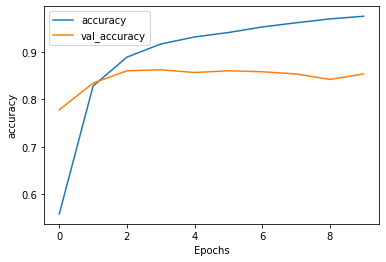

In [29]:
plot_graphs(history, 'accuracy')

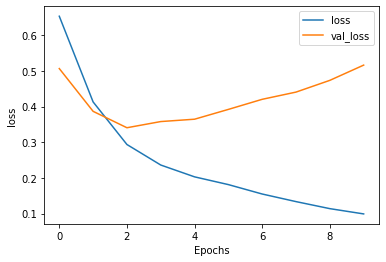

In [30]:
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
